### Setup packages 

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.94 s (started: 2022-07-18 16:03:38 +00:00)


In [92]:
%pip install progressbar
%pip install plotnine
%pip install torch
%pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 9.81 s (started: 2022-07-18 16:03:40 +00:00)


In [93]:
from plotnine import *
from plotnine.themes import *

time: 1.45 ms (started: 2022-07-18 16:03:50 +00:00)


In [94]:
from scipy.io import loadmat
import random
import math
from tqdm import tqdm

time: 885 µs (started: 2022-07-18 16:03:50 +00:00)


_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [95]:
paper_name = "dgm_cj"

time: 850 µs (started: 2022-07-18 16:03:50 +00:00)


In [96]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")

time: 20.5 ms (started: 2022-07-18 16:03:50 +00:00)


In [97]:
# Set up the imports
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

import site
import os
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


time: 6.9 ms (started: 2022-07-18 16:03:50 +00:00)


In [98]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import norm
from matplotlib import cm
import pdb
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.optim.swa_utils import AveragedModel, SWALR

time: 2.62 ms (started: 2022-07-18 16:03:50 +00:00)


In [99]:
import plotly.graph_objects as go
import plotly.express as px
from pprint import pprint as pp

time: 812 µs (started: 2022-07-18 16:03:50 +00:00)


### Shared functions across models

In [100]:
import pandas as pd

def plot_report(train_instance):
        
    history_tl_cpu = [ x for x in train_instance.history_tl ]
    history_internal_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_internal_cpu ]
    history_terminal_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_terminal ]
    history_initial_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_initial ]
    history_nonzero_cpu = [ x.cpu().detach().numpy() for x in train_instance.history_nonzero ]

    obs_data = pd.DataFrame({"Epochs" : [ (x+1)*train_instance.hook_interval for x in range(len(history_initial_cpu))], 
                             "AvgLogLoss": np.log(history_tl_cpu), 
                             "TerminalLogLoss" :  np.log(history_terminal_cpu),
                             "InternalLogLoss" :  np.log(history_internal_cpu),
                             "InitialLogLoss" : np.log(history_initial_cpu),
                             "NonZeroLogLoss" : np.log(history_nonzero_cpu),
                             })

    return (ggplot(obs_data, aes("Epochs","AvgLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","TerminalLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","InternalLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","InitialLogLoss")) + geom_line() + geom_point(),
            ggplot(obs_data, aes("Epochs","NonZeroLogLoss")) + geom_line() + geom_point(),
            )

def plot_activation_mean(train_instance):
    
    # pdb.set_trace()

    if train_instance.debug == False:
        print( 'error: debug is off , turn it on and train again ' )
    else:
        history = np.array(train_instance.history_mean_hooks)
        jet= plt.get_cmap('jet')
        colors = iter(jet(np.linspace(0,1,10)))
        fig, ax = plt.subplots()
        for i in range(history.shape[1]):
            ax.plot(history[:,i], '--r', label= i , color=next(colors) )
        fig.suptitle('Layers activation mean value', fontsize=10)
        leg = ax.legend();


time: 23.7 ms (started: 2022-07-18 16:03:50 +00:00)


In [101]:
# a set up that just maximizes the loss s.t. loss < eps (maximizeloss_weights_st) using the weights on the losses
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.optimize import Bounds
from functools import partial
from scipy.optimize import minimize
from functools import wraps

def negative(f):
    @wraps(f)
    def g(*args,**kwargs):
        return - f(*args,**kwargs)
    # g.__name__ = f'negative({f.__name__})'
    return g
# kl_loss = nn.KLDivLoss(size_average=None, reduction="batchmean")

# we can add more minimization functions here later (e.g. SS diff)
def KLDiffHere( varX, loss_terms, log_target = False, reduction = "mean"):  
  target = torch.tensor([1./len(loss_terms)]*len(loss_terms))*torch.tensor(loss_terms)
  input = torch.tensor(varX*loss_terms)
  loss_pointwise = target * (torch.log(target) - torch.log(input))
  if reduction == "mean":  # default
      loss = loss_pointwise.mean()
  elif reduction == "batchmean":  # mathematically correct
      loss = loss_pointwise.sum() / input.size(0)
  elif reduction == "sum":
      loss = loss_pointwise.sum()
  else:  # reduction == "none"
      loss = loss_pointwise  
  return loss

  # return torch.nn.KLDivLoss(varX*loss_terms,np.array([1./len(loss_terms)]*len(loss_terms))*loss_terms)

def minimize_weights_st(loss_terms, loss_func):
  bounds = Bounds([0]*len(loss_terms), [1.0]*len(loss_terms))
  linear_constraint = LinearConstraint([[1]*len(loss_terms)], [1.0], [1.0])
  x0 = [0.25]*len(loss_terms)
  res = minimize( partial(loss_func, loss_terms=loss_terms), 
                  x0, 
                  method='trust-constr', 
                  constraints=[linear_constraint],
                  options={'verbose': 0}, 
                  bounds=bounds )
  return res

def maximizeloss_weights_st(loss_terms, loss_func, eps):
  bounds = Bounds([0]*len(loss_terms), [1.0]*len(loss_terms))
  linear_constraint = LinearConstraint([[1]*len(loss_terms)], [1.0], [1.0])
  nonlinear_constraint  = NonlinearConstraint(negative(partial(loss_func, loss_terms=loss_terms)),1E-9,eps)
  # even though zero is the KL minimum it helps to put a negative number here to explore

  x0 = [1.0/len(loss_terms)]*len(loss_terms)
  res = minimize( negative(partial(loss_func, loss_terms=loss_terms)), 
                  x0, 
                  method='trust-constr', 
                  constraints=[linear_constraint, nonlinear_constraint],
                  options={'verbose': 0}, 
                  bounds=bounds )
  return res


time: 30.2 ms (started: 2022-07-18 16:03:50 +00:00)


In [102]:
r1 = maximizeloss_weights_st( [ 34.25, 100.12, 23.45] , KLDiffHere, 1E9)
print(r1.x)

[0.33334757 0.33333761 0.33331482]
time: 44.1 ms (started: 2022-07-18 16:03:50 +00:00)


In [103]:
### There is an issue getting this to work because of nonlinear_constraint  = NonlinearConstraint(negative(partial(loss_func, loss_terms=loss_terms)),1E-9,eps)

    # def calculateLossAdaptWeights(self , size = 2**8 , train = True, min_max = True):
    #     '''
    #     Helper function that Sample and Calculate loss,
    #     This is adapted in that it changes the weights on the losses to maximize the loss provided
    #     the KL distance of the new weighting is within self.eps of the previous distribution (starting at equally weighted)
    #     '''        
    #     x , x_terminal , x_boundary = self.sample(size)
    #     x = Variable( x , requires_grad=True)
    #     Ls = self.criterion( x , x_terminal , x_boundary )
    #     DO , TC , BC = Ls
    #     DOm = torch.mean(DO).detach().cpu().float().item()
    #     TCm = torch.mean(TC).detach().cpu().float().item()
    #     BCm = torch.mean(BC).detach().cpu().float().item()

    #     losses_for_reweighting = [ torch.mean(lv).detach().cpu().float().item() for lv in Ls if list(lv.size())] 
    #     mask_for_available_losses = [ True if list(lv.size()) else False for lv in Ls ]

    #     # print([ DOm, TCm, BCm])
    #     # if is.nan(DOm):
    #     #   print(DO)

    #     if self.weights is None:
    #       self.weights = torch.ones(1,len(Ls))/len(Ls)

    #     # pdb.set_trace()

    #     if min_max:
    #         r1 = maximizeloss_weights_st( losses_for_reweighting , KLDiffHere, self.eps)
    #         candidate_weigths = torch.zeros_like(self.weights).to(torch.device("cuda:0"))
    #         candidate_weigths[0][mask_for_available_losses] = torch.tensor(r1.x).to(torch.device("cuda:0")).float()
    #         self.weights = candidate_weigths.to(torch.device("cuda:0"))
    #         self.weights_tbl.append(self.weights.detach().cpu().numpy())

    #     numActive = np.sum([1 if list(lv.size()) else 0 for lv in Ls ])
    #     if train == True:
    #         return  (self.weights[0,0]*torch.mean(DO) + 
    #                  self.weights[0,1]*torch.mean(TC) + 
    #                  self.weights[0,2]*torch.mean(BC)) , \
    #                  self.weights[0,0]*torch.mean(DO) , \
    #                  self.weights[0,1]*torch.mean(TC) , \
    #                  self.weights[0,2]*torch.mean(BC) , \
    #                  (1./numActive*torch.mean(DO) + 
    #                  1./numActive*torch.mean(TC) + 
    #                  1./numActive*torch.mean(BC))             
    #     else:
    #         return  DO , TC , BC


time: 6.32 ms (started: 2022-07-18 16:03:50 +00:00)


In [104]:
import torch
from torch.distributions import Normal

std_norm_cdf = Normal(0, 1).cdf
std_norm_pdf = lambda x: torch.exp(Normal(0, 1).log_prob(x))

def bs_price(right, K, S, T, sigma, r):
    d_1 = (1 / (sigma * torch.sqrt(T))) * (torch.log(S / K) + (r + (torch.square(sigma) / 2)) * T)
    d_2 = d_1 - sigma * torch.sqrt(T)
    
    if right == "C":
        C = std_norm_cdf(d_1) * S - std_norm_cdf(d_2) * K * torch.exp(-r * T)
        return C
        
    elif right == "P":
        P = std_norm_cdf(-d_2) * K * torch.exp(-r * T) - std_norm_cdf(-d_1) * S
        return P

time: 11.3 ms (started: 2022-07-18 16:03:50 +00:00)


In [105]:
import torch

def to_cpu_detach(x):
  if isinstance(x, list):
    return [ y.detach().cpu().item() for y in x ]
  else:
    return x.detach().cpu().item()

time: 3.09 ms (started: 2022-07-18 16:03:50 +00:00)


In [106]:
def huber_loss_zero_target(x, delta = 1.0):
  loss_function = torch.nn.HuberLoss(delta=delta)
  return loss_function(x, torch.zeros_like(x))


time: 3.03 ms (started: 2022-07-18 16:03:50 +00:00)


In [107]:
# def save_model_train(lr, net,  eqLossFn, sample_method, trainObj, eqType, eqObject = None ):

#   model_id_str =  f"{eqType}_{datetime.datetime.now():%Y%m%d%H%M%S}_{eqLossFn}_{sample_method}_{trainObj.stop_epoch}_{str(lr).replace('.','p')}_{net.NL}_{net.NN}"
  
#   if eqObject is not None:
#     try:
#         beta = getattr(eqObject,"beta")
#         beta_str = str(beta).replace('.','p')
#         model_id_str = model_id_str + f"_beta{beta_str}"
#     except AttributeError:
#         pass
#     try:
#         wgamma = getattr(eqObject,"wgamma")
#         wgamma_str = str(wgamma).replace('.','p')
#         model_id_str = model_id_str + f"_wgamma{wgamma_str}"
#     except AttributeError:
#         pass
  
#   torch.save(net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{model_id_str}")
#   df_at_hookintervals = None
#   train_losses = None
#   validation_losses = None
#   try:
#       df_at_hookintervals = getattr(trainObj, "history_surfaces_hooks")
#       if df_at_hookintervals is not None:
#         df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{trainObj.hook_interval}_{model_id_str}.csv", index=False)
#   except AttributeError:
#       print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "history_surfaces_hooks"))

#   try:
#       train_losses = getattr(trainObj,"train_losses")
#       if train_losses is not None:
#         train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_str}.csv", sep = ',')    
#   except AttributeError:
#       print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))
#       # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

#   try:
#       validation_losses = getattr(trainObj,"validation_losses")
#       if validation_losses is not None:
#         validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_str}.csv", sep = ',')    
#   except AttributeError:
#       print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "validation_losses"))

time: 6.12 ms (started: 2022-07-18 16:03:50 +00:00)


In [108]:
def save_model_train_stratified(lr, net,  eqLossFn, sample_method, trainObj, eqType, eqObject = None ):

  model_id_str =  f"{eqType}_{datetime.datetime.now():%Y%m%d%H%M%S}_{eqLossFn}_{sample_method}_{trainObj.stop_epoch}_{str(lr).replace('.','p')}_{net.NL}_{net.NN}"
  
  if eqObject is not None:
    try:
        beta = getattr(eqObject,"beta")
        beta_str = str(beta).replace('.','p')
        model_id_str = model_id_str + f"_beta{beta_str}"
    except AttributeError:
        pass
    try:
        wgamma = getattr(eqObject,"wgamma")
        wgamma_str = str(wgamma).replace('.','p')
        model_id_str = model_id_str + f"_gamma{wgamma_str}"
    except AttributeError:
        pass
    try:
        xbreaks = getattr(eqObject,"xbreaks")
        xbreaks_str = str(len(xbreaks))
        model_id_str = model_id_str + f"_StSaXbrks{xbreaks_str}"
    except AttributeError:
        pass
    try:
        tbreaks = getattr(eqObject,"tbreaks")
        tbreaks_str = str(len(tbreaks))
        model_id_str = model_id_str + f"_StSaTbrks{tbreaks_str}"
    except AttributeError:
        pass
  
  torch.save(net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{model_id_str}")
  df_at_hookintervals = None
  train_losses = None
  validation_losses = None
  try:
      df_at_hookintervals = getattr(trainObj, "history_surfaces_hooks")
      if df_at_hookintervals is not None:
        df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{trainObj.hook_interval}_{model_id_str}.csv", index=False)
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "history_surfaces_hooks"))

  try:
      train_losses = getattr(trainObj,"train_losses")
      if train_losses is not None:
        train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))
      # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

  try:
      validation_losses = getattr(trainObj,"validation_losses")
      if validation_losses is not None:
        validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "validation_losses"))

time: 31.2 ms (started: 2022-07-18 16:03:50 +00:00)


### Cartea-Jaimungal Optimal Execution Problem

[Extensions of the Deep Galerkin Method](https://arxiv.org/pdf/1912.01455v3.pdf)

#### Plain Net - feed forward

In [109]:
import torch.nn.functional as F

class PlainNet(nn.Module):
    def __init__(self , in_size,  NL  , NN, activation = torch.tanh  ):
        super(PlainNet, self).__init__()
        self.in_size = in_size
        self.NL = NL
        self.NN = NN
        self.Input = in_size  
        self.fc_input = nn.Linear(self.Input,self.NN)
        torch.nn.init.xavier_uniform_(self.fc_input.weight)
        self.linears = nn.ModuleList([nn.Linear(self.NN, self.NN) for i in range(self.NL)])
        for i, l in enumerate(self.linears):    
            torch.nn.init.xavier_uniform_(l.weight)            
        # self.fc_output_d = nn.Linear(self.NN, 2)
        # self.fc_output = torch.nn.Softmax(dim=1)
        self.fc_output = nn.Linear(self.NN, 1)
        torch.nn.init.xavier_uniform_(self.fc_output.weight)
        self.act = activation
        
    def forward(self, x):
        h = self.act( self.fc_input(x)  )
        for i, l in enumerate(self.linears):
            h = self.act( l(h) )
        # out = self.fc_output_d(h)
        out = self.fc_output(h)
        return out
        

time: 13.6 ms (started: 2022-07-18 16:03:50 +00:00)


#### Alternative Net - LSTM-like architecture

[implement from github](https://github.com/Plemeur/DGM/blob/master/first_net.py)

In [110]:
class LinearWithXavier(nn.Module):
    """ Copy of linear module from Pytorch, modified to have a Xavier init,
        TODO : figure out what to do with the bias"""
    def __init__(self, in_features, out_features, bias=True, batch_normalize=False):
        super(LinearWithXavier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.batch_normalize = batch_normalize
        
        if self.batch_normalize == True:
          self.batch_norm = torch.nn.BatchNorm1d(out_features)
        
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?
    
    def forward(self, input):
        if self.batch_normalize == True:
          return self.batch_norm(torch.nn.functional.linear(input, self.weight, self.bias))
        return torch.nn.functional.linear(input, self.weight, self.bias)
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


class Cross(nn.Module):
    def __init__(self, input_features, batch_normalize=False):
        super().__init__()
        self.input_features = input_features

        self.batch_normalize = batch_normalize
        if self.batch_normalize == True:
          self.batch_norm = torch.nn.BatchNorm1d(input_features)

        self.weights = nn.Parameter(torch.Tensor(input_features, 1))
        self.bias = nn.Parameter(torch.Tensor(input_features))

        self.reset_parameters()
        
    def forward(self, x0, x):
        x0xl = torch.bmm(x0.unsqueeze(-1), x.unsqueeze(-2))
        if self.batch_normalize == True:
          return self.batch_norm(torch.tensordot(x0xl, self.weights, [[-1],[0]]).squeeze(-1) + self.bias.reshape(-1,1) + x)
        return torch.tensordot(x0xl, self.weights, [[-1],[0]]).squeeze(-1) + self.bias.reshape(-1,1) + x
    
    # Define some output to give when layer 
    def extra_repr(self):
        return 'in_features={}, out_features={}'.format(
            self.input_features, self.input_features
        )
            
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weights)
        if self.bias is not None:
            torch.nn.init.uniform_(self.bias, -1, 1) #boundary matter?


class DGM_layer(nn.Module):
    """ See readme for paper source"""
    def __init__(self, in_features, out_feature, residual=False, batch_normalize=False):
        super(DGM_layer, self).__init__()
        self.residual = residual

        self.Z = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UZ = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.G = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UG = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.R = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UR = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)
        self.H = LinearWithXavier(out_feature, out_feature, batch_normalize=batch_normalize)
        self.UH = LinearWithXavier(in_features, out_feature, bias=False, batch_normalize=batch_normalize)

    def forward(self, x, s):
        z = torch.tanh(self.UZ(x) + self.Z(s))
        g = torch.tanh(self.UG(x) + self.G(s))
        r = torch.tanh(self.UR(x) + self.R(s))
        h = torch.tanh(self.UH(x) + self.H(s * r))
        return (1 - g) * h + z * s


class AlternativeNet(nn.Module):

    def __init__(self, in_size, out_size, neurons, depth, 
                 batch_normalize=False, 
                 final_activation=None, 
                 use_cross=False):
        super(AlternativeNet, self).__init__()
        self.neurons=neurons
        self.depth=depth
        self.use_cross = use_cross

        self.dim = in_size
        self.input_layer = LinearWithXavier(in_size, neurons, batch_normalize=batch_normalize) if not use_cross else Cross(in_size, batch_normalize=batch_normalize)

        mod_list = [DGM_layer(in_size, neurons)] #if not use_cross else [DGM_layer(in_size*in_size, neurons)]
        for i in range(depth-1):
          mod_list.append(DGM_layer(in_size, neurons))  
        self.middle_layer = nn.ModuleList(mod_list)
        self.final_layer = LinearWithXavier(neurons, out_size, batch_normalize=batch_normalize)
        self.final_activation = final_activation

    def forward(self, X):
        #X = self.cross_layer(X, X)
        s = torch.tanh(self.input_layer(X)) if not self.use_cross else torch.tanh(self.input_layer(X,X))
        for i, layer in enumerate(self.middle_layer):
            s = torch.tanh(layer(X, s))
        
        # for i, layer in enumerate(self.middle_layer_2):
        #     s = torch.tanh(layer(X, s))
        
        # s = torch.nn.functional.gelu(self.input_layer(X))
        # for i, layer in enumerate(self.middle_layer):
        #     s = torch.nn.functional.elu(layer(X, s))
        # for i, layer in enumerate(self.middle_layer):
        #     s = torch.nn.functional.gelu(layer(X, s))
        # for i, layer in enumerate(self.middle_layer_2):
        #     s = torch.nn.functional.gelu(layer(X, s))
        
        if self.final_activation is not None:
            return self.final_activation(self.final_layer(s))
        else:
            return self.final_layer(s)

time: 168 ms (started: 2022-07-18 16:03:50 +00:00)


In [111]:
torch.tensor([ float(x) for x in range(10)]).device

device(type='cpu')

time: 3.54 ms (started: 2022-07-18 16:03:51 +00:00)


In [112]:
from pprint import pprint as pp
cl = Cross(10)
input = torch.tensor([ float(x) for x in range(10)]).reshape(-1,1)
pp(type(input))
pp(input.shape)
cl(input, input).shape

<class 'torch.Tensor'>
torch.Size([10, 1])


torch.Size([10, 1])

time: 7.96 ms (started: 2022-07-18 16:03:51 +00:00)


In [113]:
x0xl = torch.bmm(input.unsqueeze(-1), input.unsqueeze(-2))
d = torch.tensordot(x0xl, cl.weights, [[-1],[0]]).squeeze(-1)  + cl.bias.reshape(-1,1) # + input
pp(d.shape)
cl.bias.shape

torch.Size([10, 1])


torch.Size([10])

time: 5.98 ms (started: 2022-07-18 16:03:51 +00:00)


####Control equation

In [114]:
# tau, cash, asset price, inventory, asset volatility, running cost, terminal cost, temporary, and permament price impacts
# tau,   x,     S,           q,            sigma,         phi,         alpha,         kappa,             beta

class ControlEquation():

    def __init__(self, control_net, du_dx, du_dS, du_dq, curr_epoch=0):
        
        self.control_net = control_net
        self.grads = du_dx, du_dS, du_dq
        self.curr_epoch = curr_epoch

    def criterion(self, x_internal, grads):
      
      du_dx, du_dS, du_dq = grads
      #print('gradient shapes:', du_dx.shape, du_dS.shape, du_dq.shape)

      control_preds = self.control_net(x_internal)
      control_preds = control_preds.reshape(-1,1)
      #print('control net prediction shape:', control_preds.shape)

      S = x_internal[:,2].reshape(-1, 1)
      kappa = x_internal[:,7].reshape(-1, 1)
      beta = x_internal[:,8].reshape(-1, 1)

      
      intC = None
      # tau, cash, asset price, inventory, asset volatility, running cost, terminal cost, temporary, and permament price impacts
      if len(x_internal) == 0:
        intC_loss = torch.tensor(0).cuda().float()  
      else:
        
        # nu * (S - kappa * nu)
        loss_1 = control_preds * (S - kappa * control_preds)
        #print('loss1 shape:', loss_1.shape)
        
        # - b * nu
        loss_2 = -1. * beta * control_preds
        #print('loss2 shape:', loss_2.shape)
        
        # - nu
        loss_3 = -1. * control_preds
        #print('loss3 shape:', loss_3.shape)
        
        intC_loss = -1. * (loss_1 * du_dx + loss_2 * du_dS + loss_3 * du_dq)
        #print('total internal loss shape:', intC_loss.shape)

      return intC_loss

    def calculateControlLoss(self, x_internal, grads, keep_batch = False):
        '''
        Helper function that Sample and Calculate loss,
        '''        
        Ls = self.criterion( x_internal, grads)
        
        if not keep_batch:          
          return torch.mean(Ls)           
        else:
          return Ls

time: 24.3 ms (started: 2022-07-18 16:03:51 +00:00)


#### TrainInternalControlWithDGM


In [115]:
class TrainInternalControl():
    
    def __init__(self, value_equation, control_equation, BATCH_SIZE, epoch, lr, hook_interval=100):
        
        self.value_model = value_equation        
        self.control_model = control_equation
        self.BATCH_SIZE = BATCH_SIZE
        self.hook_interval = hook_interval

        self.optimizer_used = optim.Adam(self.control_model.control_net.parameters(), lr)
        self.stop_epoch = 0  
        self.epoch = epoch
        self.lr = lr
        
    def train(self , eqLossFn = 'calculateControlLoss', sample_method_X = "U", sample_batch = None):
        
        # set it to train mode
        self.control_model.control_net.train()
        
        optimizer = self.optimizer_used
        if self.value_model.control_optim_state is not None:
            optimizer.load_state_dict(self.value_model.control_optim_state)
        
        loss_avg = 0.0
        loss_calc_method = None
        
        try:
            loss_calc_method = getattr(self.control_model, eqLossFn)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(self.control_model.__class__.__name__, eqLossFn))
        
        if sample_batch is None:
            sample_batch = self.value_model.sample(sample_method_X = sample_method_X, size=self.BATCH_SIZE)

        x_internal, _ = sample_batch

        for e in range(self.epoch):

            optimizer.zero_grad()
  
            loss = loss_calc_method(x_internal, self.control_model.grads, keep_batch = False )            
            
            loss_avg = loss_avg + float(loss.item())
            
            loss.backward()
            
            optimizer.step()
            
            #if (e % self.hook_interval == (self.hook_interval-1)) or e == 0:
            if (self.control_model.curr_epoch % self.hook_interval == (self.hook_interval-1)) and e==0:

                self.control_model.control_net.eval()
                loss_avg = loss_avg/self.hook_interval
                print("Control Epoch {} - lr {} -  key loss: {}".format(self.control_model.curr_epoch, self.lr , loss_avg))
                int_mae_control = (torch.mean(torch.abs(self.control_model.control_net(x_internal) - nu_star(x_internal)))).item()
                self.value_model.control_losses.append((loss_avg, int_mae_control))
                loss_avg = 0.0

                self.control_model.control_net.train()
            
        #if self.control_model.curr_epoch == 80000:
        #    for g in optimizer.param_groups:
        #        g['lr'] *= 1/3.
        
        self.value_model.control_optim_state = optimizer.state_dict()
        self.stop_epoch = e

time: 42.3 ms (started: 2022-07-18 16:03:51 +00:00)


#### ValueEquation

In [116]:
class ValueEquation():
    
    def __init__(self , value_net, control_net, control_net_epoch, control_net_lr):

        self.value_net = value_net
        self.control_net = control_net

        self.T = 1.0
        self.MAX_x = 1.0
        self.MAX_S = 1.0
        self.MAX_q = 5.0
        self.MAX_sigma = 0.5
        self.MAX_phi = 0.2
        self.MAX_alpha = 0.2
        self.MAX_kappa = 0.05
        self.MAX_beta = 0.005

        self.control_net_epoch = control_net_epoch
        self.control_net_lr = control_net_lr
        self.control_optim_state = None
        self.epoch_of_u = None
        self.hook_interval = None
        self.control_losses = []


    @staticmethod
    def to_device(x, to_cpu):
      if to_cpu:
        return x.cpu()
      else:
        return x.cuda()


    def sample(self , sample_method_X = "U", size = 2**8, to_cpu = False ):
        '''
        Sampling function
        '''
        if sample_method_X in ["U"]:
            
            # tau,   x,     S,           q,            sigma,         phi,         alpha,         kappa,             beta
            ### internal samples of tau, cash, asset price, inventory, asset vol, running cost, terminal cost, temporary and permament price impacts
            
            #x_internal = self.to_device(torch.cat(( (1 - torch.rand([size,1])) * self.T, # tau
            #                                        (1 - torch.rand([size, 1])) * self.MAX_x, # cash
            #                                       (1 - torch.rand([size,1])) * self.MAX_S, # price
            #                                       torch.rand([size,1]) * self.MAX_q,  # inventory
            #                                       0.1 + (1 - torch.rand([size,1])) * self.MAX_sigma, # vol
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_phi, # running cost
            #                                       1e-3+ torch.rand([size,1]) * self.MAX_alpha, # terminal cost
            #                                       1e-3+ torch.rand([size,1]) * self.MAX_kappa, # temporaty impact
            #                                       1e-4+ torch.rand([size,1]) * self.MAX_beta, # permanent impact
            #                                       ) , dim = 1 ),to_cpu)
            
            
            ### Terminal time samples

            #x_terminal = self.to_device(torch.cat(( torch.zeros([size,1]), # tau
            #                                       (1 - torch.rand([size, 1])) * self.MAX_x, # cash
            #                                       (1 - torch.rand([size,1])) * self.MAX_S, # price
            #                                       torch.rand([size,1]) * self.MAX_q,  # inventory
            #                                       0.1 + (1 - torch.rand([size,1])) * self.MAX_sigma, # vol
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_phi, # running cost
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_alpha, # terminal cost
            #                                       1e-3 + torch.rand([size,1]) * self.MAX_kappa, # temporaty impact
            #                                       1e-4 + torch.rand([size,1]) * self.MAX_beta, # permanent impact
            #                                       ) , dim = 1 ),to_cpu)
            

            x_internal = self.to_device(torch.cat(( (1 - torch.rand([size,1])) * self.T, # tau
                                                    (1 - torch.rand([size, 1])) * self.MAX_x, # cash
                                                   (1 - torch.rand([size,1])) * self.MAX_S, # price
                                                   torch.rand([size,1]) * self.MAX_q,  # inventory
                                                   0.1 + (1 - torch.rand([size,1])) * self.MAX_sigma, # vol
                                                   
                                                   0.1 + torch.zeros([size,1]) , # running cost
                                                   0.1 + torch.zeros([size,1]),  # terminal cost
                                                   1e-2 + torch.zeros([size,1]) , # temporaty impact
                                                   1e-3 + torch.zeros([size,1]) , # permanent impact
                                                   ) , dim = 1 ),to_cpu)
            ### Terminal time samples

            x_terminal = self.to_device(torch.cat(( torch.zeros([size,1]), # tau
                                                    (1 - torch.rand([size, 1])) * self.MAX_x, # cash
                                                   (1 - torch.rand([size,1])) * self.MAX_S, # price
                                                   torch.rand([size,1]) * self.MAX_q,  # inventory
                                                   0.1 + (1 - torch.rand([size,1])) * self.MAX_sigma, # vol
                                                  
                                                   0.1 + torch.zeros([size,1]) , # running cost
                                                   0.1 + torch.zeros([size,1]),  # terminal cost
                                                   1e-2 + torch.zeros([size,1]) , # temporaty impact
                                                   1e-3 + torch.zeros([size,1]) , # permanent impact
                                                   ) , dim = 1 ),to_cpu)
            
            
            return x_internal , x_terminal

        raise ValueError(f"{sample_method_X} is not a supported sampling method")
        

    def get_num_control_epochs(self):

      return self.control_net_epoch


    def get_value_function_derivatives(self, value_net_val, x_internal, normalize=False):
        du = torch.autograd.grad( value_net_val, 
                                  x_internal, 
                                  grad_outputs=torch.ones_like(value_net_val),
                                  create_graph=True)
        #t, x, S, q
        du_dt = du[0][:,0].reshape(-1,1)
        du_dx = du[0][:,1].reshape(-1,1)
        du_dS = du[0][:,2].reshape(-1,1)
        du_dq = du[0][:,3].reshape(-1,1)  

        d2u_dS2 = torch.autograd.grad(du_dS, 
                                      x_internal , 
                                      grad_outputs=torch.ones_like(du_dS),
                                      create_graph=True, allow_unused=True
                                      )[0][:,2].reshape(-1,1)
        
        #print('Derivative shapes:', du_dt.shape, du_dx.shape, du_dS.shape, du_dq.shape, d2u_dS2.shape)
        
        return du_dt, du_dx, du_dS, du_dq, d2u_dS2

    def g_sol(self, tau, kappa, phi, alpha, beta):
        
        ksi = torch.sqrt(kappa * phi)
        gamma = torch.sqrt(phi / kappa)
        dzeta = (alpha - 0.5 * beta + ksi) / (alpha - 0.5 * beta - ksi)
        
        return ksi * (1 + dzeta * torch.exp(2 * gamma * tau)) / (1 - dzeta * torch.exp(2 * gamma * tau))
        

    def HtxSq(self, x_int):
        
        tau = x_int[:,0].reshape(-1, 1)
        x = x_int[:,1].reshape(-1, 1)
        S = x_int[:,2].reshape(-1, 1)
        q = x_int[:,3].reshape(-1, 1)
        #sigma = x_int[:,4].reshape(-1, 1)
        phi = x_int[:,5].reshape(-1, 1)
        alpha = x_int[:,6].reshape(-1, 1)
        kappa = x_int[:,7].reshape(-1, 1)
        beta = x_int[:,8].reshape(-1, 1)

        return x + q*S + (self.g_sol(tau, kappa, phi,  alpha, beta) - 0.5 * beta) * q**2

      
    def nu_star(self, x_int):

        tau = x_int[:,0].reshape(-1, 1)
        #x = x_int[:,1].reshape(-1, 1)
        #S = x_int[:,2].reshape(-1, 1)
        q = x_int[:,3].reshape(-1, 1)
        #sigma = x_int[:,4].reshape(-1, 1)
        phi = x_int[:,5].reshape(-1, 1)
        alpha = x_int[:,6].reshape(-1, 1)
        kappa = x_int[:,7].reshape(-1, 1)
        beta = x_int[:,8].reshape(-1, 1)

        return (-1. / kappa) * self.g_sol(tau, kappa, phi,  alpha, beta) * q
        


    def criterion(self, x_internal, x_terminal, loss_transforms = [torch.square]):
        '''
        Loss function that helps network find solution to equation
        '''   
        
        value_net_val = self.value_net(x_internal)
        #print(torch.mean(value_net_val), torch.min(value_net_val), torch.max(value_net_val))

        # Trying to used a correct solution to see control convergence
        #u_net_val = self.Htx(x_internal)
        #du_dx, d2u_dx2 = self.dHdx(x_internal), self.d2Hdx2(x_internal)
        #du_dt = torch.zeros_like(du_dx)


        du_dt, du_dx, du_dS, du_dq, d2u_dS2 = self.get_value_function_derivatives(value_net_val, x_internal)
        #print('Value net derivatives shape:', du_dt.shape, du_dx.shape, du_dS.shape, du_dq.shape, d2S_dS2.shape)


        control_model = ControlEquation(self.control_net, du_dx.detach(), du_dS.detach(), du_dq.detach())
        control_model.curr_epoch = self.epoch_of_u             
        
        control_trainer = TrainInternalControl(self, control_model, 
                                            x_internal.shape[0], 
                                            self.get_num_control_epochs(), 
                                            self.control_net_lr,
                                            hook_interval=self.hook_interval)
        
        control_trainer.train(sample_batch=(x_internal, x_terminal))

        #tau = x_internal[:,0].reshape(-1, 1)
        #x = x_internal[:,1].reshape(-1, 1)
        S = x_internal[:,2].reshape(-1, 1)
        q = x_internal[:,3].reshape(-1, 1)
        sigma = x_internal[:,4].reshape(-1, 1)
        phi = x_internal[:,5].reshape(-1, 1)
        #alpha = x_internal[:,6].reshape(-1, 1)
        kappa = x_internal[:,7].reshape(-1, 1)
        beta = x_internal[:,8].reshape(-1, 1)
          

        if loss_transforms is None:
          loss_transforms = [torch.square]

        intC = None
        terC = None

        if len(x_internal) == 0:
          intC = [ torch.tensor(0).cuda().float() for loss_transform in loss_transforms ] 
        else:
          
          control_preds = self.control_net(x_internal)
          #control_preds = self.nu_star(x_internal)
          
          control_preds = control_preds.detach().reshape(-1,1)
          #print('Control net prediction inside the value net:', control_preds.shape)

          # nu * (S - kappa * nu)
          loss_1 = control_preds * (S - kappa * control_preds)
          #print('loss1 shape:', loss_1.shape)
          
          # - b * nu
          loss_2 = -1. * beta * control_preds
          #print('loss2 shape:', loss_2.shape)
          
          # - nu
          loss_3 = -1. * control_preds
          #print('loss3 shape:', loss_3.shape)
          
          control_loss = loss_1 * du_dx + loss_2 * du_dS + loss_3 * du_dq
          #print('Control loss shape:', control_loss.shape)
          
          # it is minus in front of time derivative as it is time to maturity instead of elapsed time
          intC_loss = -du_dt + 0.5 * sigma**2 * d2u_dS2 - phi * q ** 2 + control_loss
          
          #print(torch.mean(intC_loss), torch.min(intC_loss), torch.max(intC_loss))
          #print('interim total loss in Value net shape:', intC_loss.shape)

          intC = [ loss_transform(intC_loss) for loss_transform in loss_transforms ] 
        
        #print('Terminal condition shapes:')
        #print(self.g(x_terminal).shape)
        #print(self.value_net(x_terminal).shape)

        terC = [ loss_transform(self.g_terminal(x_terminal) - self.value_net(x_terminal)) for loss_transform in loss_transforms ]
        
        #print('min d2u_dS2:', d2u_dS2.min(),'max d2u_dS2:', d2u_dS2.max())
        #print('min du_dx:', du_dx.min(),'max du_dx:', du_dx.max())
        #print('min du_dq:', du_dq.min(),'max du_dq:', du_dq.max())
        #print('min du_dS:', du_dS.min(),'max du_dS:', du_dS.max())
        
        return intC, terC

    
    def g_terminal(self, x):

        # x + S*q - alpha * q**2
        return x[:, 1].reshape(-1, 1) + x[:,2].reshape(-1, 1) * x[:,3].reshape(-1, 1) - x[:,6].reshape(-1, 1) *  x[:,3].reshape(-1, 1) ** 2

    
    def calculateLoss(self, batch_x, loss_transforms = [ torch.square ], keep_batch = False):
        '''
        Helper function that Sample and Calculate loss,
        '''        

        x_internal , x_terminal = batch_x
        x_internal = Variable( x_internal , requires_grad=True)
        
        Ls = self.criterion(x_internal , x_terminal, loss_transforms = loss_transforms)
        intC, terC = Ls

        return_losses = []
        # print('internal Loss', torch.mean(intC[0]))
        # print('external Loss', torch.mean(terC[0]))

        for lc in range(len(loss_transforms)):
          if not keep_batch:
            loss_equalWeightedByType = torch.mean(intC[lc]) + torch.mean(terC[lc])
            return_losses.append( [  1* loss_equalWeightedByType , 
                                     1* torch.mean(intC[lc]) , 
                                     1* torch.mean(terC[lc])
                                   ] )            
          else:
            return_losses.append( [intC.numpy(), terC.numpy()] )
        return return_losses


time: 571 ms (started: 2022-07-18 16:03:51 +00:00)


#### TrainHJBWithDGM

In [117]:
class TrainHJBWithDGM():
    
    def __init__(self , equation , BATCH_SIZE, lr, hook_interval=100):
        
        self.BATCH_SIZE = BATCH_SIZE
        self.model = equation
        self.hook_interval = hook_interval
        self.optimizer_used = optim.Adam(self.model.value_net.parameters(), lr, weight_decay=1e-6)
        self.stop_epoch = 0
        self.train_losses = []


    def train(self, 
              epoch, 
              eqLossFn = 'calculateLoss', 
              sample_method_X = "U", 
              key_loss_func = torch.square):
      
        self.model.hook_interval = self.hook_interval
        
        self.model.value_net.train()
        optimizer = self.optimizer_used#(self.model.value_net.parameters(), lr, weight_decay=1e-6)
        scheduler = MultiStepLR(optimizer, milestones=[10000, 20000, 50000, 130000], gamma=1./3)

        #swa_model = AveragedModel(self.model.value_net)
        #swa_start = 100
        #swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        

        loss_avg = 0.0
        loss_calc_method = None
        try:
            loss_calc_method = getattr(self.model, eqLossFn)
        except AttributeError:
            raise NotImplementedError("Class `{}` does not implement `{}`".format(self.model.__class__.__name__, eqLossFn))

        #full_dataset = self.model.sample(sample_method_X = sample_method_X, size=100000)
        #full_batch_internal = DataLoader(full_dataset[0], batch_size=self.BATCH_SIZE)
        #full_batch_terminal = DataLoader(full_dataset[1], batch_size=self.BATCH_SIZE)

        for e in tqdm(range(self.stop_epoch, self.stop_epoch + epoch)):
            
            sample_batch = self.model.sample(sample_method_X = sample_method_X, size=self.BATCH_SIZE)

            optimizer.zero_grad()
            self.model.epoch_of_u = e

            losses_L2 = loss_calc_method(sample_batch, loss_transforms = [key_loss_func], keep_batch=False)

            loss, internal, terminal = losses_L2[0]
            loss_avg =  float(loss.item())
            loss_int_avg = float(internal.item())
            
            loss.backward()
            optimizer.step()
            
            #if epoch > swa_start:
            #    swa_model.update_parameters(self.model.value_net)
            #    swa_scheduler.step()
            #else:
            #    scheduler.step()
            scheduler.step()

            if (e % self.hook_interval == (self.hook_interval-1)) or e == 0:
                
                optimizer.zero_grad()
                self.model.value_net.eval()
                int_mse = (torch.mean((self.model.value_net(sample_batch[0]) - HtxSq(sample_batch[0])) ** 2)).item()
                term_mse = (torch.mean((self.model.value_net(sample_batch[1]) - HtxSq(sample_batch[1])) ** 2)).item()

                print("Value net Epoch {} - lr {} - Total Loss: {} - Internal Loss: {} - Terminal Loss: {} - Internal MSE: {} - Terminal MSE: {}".format(e , lr , round(loss_avg, 6), round(loss_int_avg, 6), round(loss_avg - loss_int_avg, 6), round(int_mse, 6), round(term_mse, 6)))
                self.train_losses.append((loss_avg, loss_int_avg, int_mse, term_mse))
                
                self.model.value_net.train()

        self.stop_epoch = e
        #self.swa_model = swa_model

        state = {
        'epoch': e+1,
        'value_state_dict': self.model.value_net.state_dict(),
        'value_optimizer_state_dict': optimizer.state_dict(),
        'control_state_dict': self.model.control_net.state_dict(),
        'control_optimizer_state_dict': self.model.control_optim_state }
        
        filepath = '/content/drive/MyDrive/data_papers/dgm_cj/model_finals'
        torch.save(state, os.path.join(filepath, 'CJ_state_saved_{}_epochs.pt'.format(e+1)))
        

time: 58.9 ms (started: 2022-07-18 16:03:52 +00:00)


In [118]:
def g_sol(tau, kappa, phi, alpha, beta):
    
    ksi = torch.sqrt(kappa * phi)
    gamma = torch.sqrt(phi / kappa)
    dzeta = (alpha - 0.5 * beta + ksi) / (alpha - 0.5 * beta - ksi)
    
    return ksi * (1 + dzeta * torch.exp(2 * gamma * tau)) / (1 - dzeta * torch.exp(2 * gamma * tau))
    

def HtxSq(x_int):
    
    tau = x_int[:,0].reshape(-1, 1)
    x = x_int[:,1].reshape(-1, 1)
    S = x_int[:,2].reshape(-1, 1)
    q = x_int[:,3].reshape(-1, 1)
    #sigma = x_int[:,4].reshape(-1, 1)
    phi = x_int[:,5].reshape(-1, 1)
    alpha = x_int[:,6].reshape(-1, 1)
    kappa = x_int[:,7].reshape(-1, 1)
    beta = x_int[:,8].reshape(-1, 1)

    #print(torch.max(g_sol(tau, kappa, phi,  alpha, beta)), torch.min(g_sol(tau, kappa, phi,  alpha, beta)), torch.mean(g_sol(tau, kappa, phi,  alpha, beta)))

    return x + q*S + (g_sol(tau, kappa, phi,  alpha, beta) - 0.5 * beta) * q**2

  
def nu_star(x_int):

    tau = x_int[:,0].reshape(-1, 1)
    #x = x_int[:,1].reshape(-1, 1)
    #S = x_int[:,2].reshape(-1, 1)
    q = x_int[:,3].reshape(-1, 1)
    #sigma = x_int[:,4].reshape(-1, 1)
    phi = x_int[:,5].reshape(-1, 1)
    alpha = x_int[:,6].reshape(-1, 1)
    kappa = x_int[:,7].reshape(-1, 1)
    beta = x_int[:,8].reshape(-1, 1)

    return (-1. / kappa) * g_sol(tau, kappa, phi,  alpha, beta) * q
    

time: 19 ms (started: 2022-07-18 16:03:52 +00:00)


### Test Case

In [119]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

eqLossFn= 'calculateLoss'
sample_method= "U"
lr = 3e-4
lr_for_control = 3e-4
max_control_epochs = 1 # has to be low!!!

value_net = AlternativeNet( in_size = 9, 
                            out_size = 1, 
                            neurons = 64, 
                            depth=2, 
                            batch_normalize=False,
                            use_cross = False )
# #value_net = PlainNet(in_size=9, NL=2, NN=64)
value_net.to(torch.device("cuda:0")) 

control_net = AlternativeNet( in_size = 9 , 
                              out_size = 1, 
                              neurons = 64, 
                              depth=2, 
                              batch_normalize=False, 
                             use_cross = False)
# #control_net = PlainNet(in_size=9, NL=2, NN=64)
control_net.to(torch.device("cuda:0"))

value_equation = ValueEquation(value_net, control_net, max_control_epochs, lr_for_control)
trainAlloc = TrainHJBWithDGM(value_equation, BATCH_SIZE=2048, lr=lr, hook_interval=100)

trainAlloc.train(epoch = 200000, eqLossFn = eqLossFn, sample_method_X = sample_method)

  0%|          | 6/200000 [00:00<2:09:26, 25.75it/s]

Value net Epoch 0 - lr 0.0003 - Total Loss: 2.270631 - Internal Loss: 1.334001 - Terminal Loss: 0.93663 - Internal MSE: 0.992725 - Terminal MSE: 0.895034


  0%|          | 102/200000 [00:03<2:04:47, 26.70it/s]

Control Epoch 99 - lr 0.0003 -  key loss: -0.009502015113830566
Value net Epoch 99 - lr 0.0003 - Total Loss: 0.134699 - Internal Loss: 0.035141 - Terminal Loss: 0.099558 - Internal MSE: 0.465525 - Terminal MSE: 0.098737


  0%|          | 204/200000 [00:07<2:09:58, 25.62it/s]

Control Epoch 199 - lr 0.0003 -  key loss: -0.014144282341003418
Value net Epoch 199 - lr 0.0003 - Total Loss: 0.070655 - Internal Loss: 0.012781 - Terminal Loss: 0.057873 - Internal MSE: 0.202092 - Terminal MSE: 0.059909


  0%|          | 302/200000 [00:10<1:45:50, 31.45it/s]

Control Epoch 299 - lr 0.0003 -  key loss: -0.01993340492248535
Value net Epoch 299 - lr 0.0003 - Total Loss: 0.048813 - Internal Loss: 0.01099 - Terminal Loss: 0.037823 - Internal MSE: 0.247342 - Terminal MSE: 0.03821


  0%|          | 403/200000 [00:13<1:58:51, 27.99it/s]

Control Epoch 399 - lr 0.0003 -  key loss: -0.023069772720336914
Value net Epoch 399 - lr 0.0003 - Total Loss: 0.036781 - Internal Loss: 0.007817 - Terminal Loss: 0.028963 - Internal MSE: 0.418969 - Terminal MSE: 0.029343


  0%|          | 503/200000 [00:17<1:45:01, 31.66it/s]

Control Epoch 499 - lr 0.0003 -  key loss: -0.024664275646209717
Value net Epoch 499 - lr 0.0003 - Total Loss: 0.030934 - Internal Loss: 0.006274 - Terminal Loss: 0.02466 - Internal MSE: 0.624742 - Terminal MSE: 0.02446


  0%|          | 603/200000 [00:20<1:45:49, 31.41it/s]

Control Epoch 599 - lr 0.0003 -  key loss: -0.025863022804260255
Value net Epoch 599 - lr 0.0003 - Total Loss: 0.032009 - Internal Loss: 0.007835 - Terminal Loss: 0.024174 - Internal MSE: 0.770305 - Terminal MSE: 0.022457


  0%|          | 703/200000 [00:23<1:45:18, 31.54it/s]

Control Epoch 699 - lr 0.0003 -  key loss: -0.027441487312316895
Value net Epoch 699 - lr 0.0003 - Total Loss: 0.029701 - Internal Loss: 0.007901 - Terminal Loss: 0.0218 - Internal MSE: 0.905989 - Terminal MSE: 0.021004


  0%|          | 803/200000 [00:26<1:44:41, 31.71it/s]

Control Epoch 799 - lr 0.0003 -  key loss: -0.027449884414672852
Value net Epoch 799 - lr 0.0003 - Total Loss: 0.033774 - Internal Loss: 0.012012 - Terminal Loss: 0.021762 - Internal MSE: 1.026675 - Terminal MSE: 0.020586


  0%|          | 903/200000 [00:29<1:46:06, 31.27it/s]

Control Epoch 899 - lr 0.0003 -  key loss: -0.02876912832260132
Value net Epoch 899 - lr 0.0003 - Total Loss: 0.023574 - Internal Loss: 0.003967 - Terminal Loss: 0.019607 - Internal MSE: 1.134499 - Terminal MSE: 0.020056


  1%|          | 1003/200000 [00:32<1:45:11, 31.53it/s]

Control Epoch 999 - lr 0.0003 -  key loss: -0.030350568294525145
Value net Epoch 999 - lr 0.0003 - Total Loss: 0.031711 - Internal Loss: 0.012771 - Terminal Loss: 0.01894 - Internal MSE: 1.150617 - Terminal MSE: 0.020303


  1%|          | 1103/200000 [00:35<1:45:10, 31.52it/s]

Control Epoch 1099 - lr 0.0003 -  key loss: -0.030374627113342285
Value net Epoch 1099 - lr 0.0003 - Total Loss: 0.024122 - Internal Loss: 0.005081 - Terminal Loss: 0.019042 - Internal MSE: 1.193859 - Terminal MSE: 0.019775


  1%|          | 1203/200000 [00:39<1:43:57, 31.87it/s]

Control Epoch 1199 - lr 0.0003 -  key loss: -0.030541539192199707
Value net Epoch 1199 - lr 0.0003 - Total Loss: 0.022802 - Internal Loss: 0.003537 - Terminal Loss: 0.019264 - Internal MSE: 1.210586 - Terminal MSE: 0.01945


  1%|          | 1303/200000 [00:42<1:44:20, 31.74it/s]

Control Epoch 1299 - lr 0.0003 -  key loss: -0.029860358238220214
Value net Epoch 1299 - lr 0.0003 - Total Loss: 0.021988 - Internal Loss: 0.003029 - Terminal Loss: 0.018959 - Internal MSE: 1.263745 - Terminal MSE: 0.018743


  1%|          | 1403/200000 [00:45<1:45:06, 31.49it/s]

Control Epoch 1399 - lr 0.0003 -  key loss: -0.030472116470336916
Value net Epoch 1399 - lr 0.0003 - Total Loss: 0.020484 - Internal Loss: 0.002617 - Terminal Loss: 0.017867 - Internal MSE: 1.257998 - Terminal MSE: 0.017924


  1%|          | 1503/200000 [00:48<1:45:25, 31.38it/s]

Control Epoch 1499 - lr 0.0003 -  key loss: -0.029192190170288086
Value net Epoch 1499 - lr 0.0003 - Total Loss: 0.022271 - Internal Loss: 0.004041 - Terminal Loss: 0.01823 - Internal MSE: 1.322081 - Terminal MSE: 0.017599


  1%|          | 1602/200000 [00:51<1:46:51, 30.95it/s]

Control Epoch 1599 - lr 0.0003 -  key loss: -0.03034482717514038
Value net Epoch 1599 - lr 0.0003 - Total Loss: 0.025491 - Internal Loss: 0.007066 - Terminal Loss: 0.018426 - Internal MSE: 1.295128 - Terminal MSE: 0.018795


  1%|          | 1702/200000 [00:55<1:45:42, 31.27it/s]

Control Epoch 1699 - lr 0.0003 -  key loss: -0.029565184116363524
Value net Epoch 1699 - lr 0.0003 - Total Loss: 0.019733 - Internal Loss: 0.001952 - Terminal Loss: 0.017782 - Internal MSE: 1.27382 - Terminal MSE: 0.017519


  1%|          | 1802/200000 [00:58<1:44:29, 31.61it/s]

Control Epoch 1799 - lr 0.0003 -  key loss: -0.02924088954925537
Value net Epoch 1799 - lr 0.0003 - Total Loss: 0.020373 - Internal Loss: 0.001827 - Terminal Loss: 0.018545 - Internal MSE: 1.276103 - Terminal MSE: 0.018144


  1%|          | 1902/200000 [01:01<1:44:46, 31.51it/s]

Control Epoch 1899 - lr 0.0003 -  key loss: -0.028736879825592043
Value net Epoch 1899 - lr 0.0003 - Total Loss: 0.019603 - Internal Loss: 0.001644 - Terminal Loss: 0.017959 - Internal MSE: 1.293187 - Terminal MSE: 0.017584


  1%|          | 2002/200000 [01:04<1:45:21, 31.32it/s]

Control Epoch 1999 - lr 0.0003 -  key loss: -0.030037763118743895
Value net Epoch 1999 - lr 0.0003 - Total Loss: 0.025639 - Internal Loss: 0.008209 - Terminal Loss: 0.017429 - Internal MSE: 1.194181 - Terminal MSE: 0.018662


  1%|          | 2102/200000 [01:07<1:46:07, 31.08it/s]

Control Epoch 2099 - lr 0.0003 -  key loss: -0.02999950885772705
Value net Epoch 2099 - lr 0.0003 - Total Loss: 0.026215 - Internal Loss: 0.009748 - Terminal Loss: 0.016467 - Internal MSE: 1.211776 - Terminal MSE: 0.016885


  1%|          | 2202/200000 [01:10<1:45:24, 31.28it/s]

Control Epoch 2199 - lr 0.0003 -  key loss: -0.028913073539733887
Value net Epoch 2199 - lr 0.0003 - Total Loss: 0.019096 - Internal Loss: 0.001607 - Terminal Loss: 0.017489 - Internal MSE: 1.207625 - Terminal MSE: 0.017714


  1%|          | 2302/200000 [01:13<1:45:23, 31.27it/s]

Control Epoch 2299 - lr 0.0003 -  key loss: -0.02918948173522949
Value net Epoch 2299 - lr 0.0003 - Total Loss: 0.019907 - Internal Loss: 0.002025 - Terminal Loss: 0.017882 - Internal MSE: 1.092717 - Terminal MSE: 0.017945


  1%|          | 2402/200000 [01:17<1:43:26, 31.84it/s]

Control Epoch 2399 - lr 0.0003 -  key loss: -0.029250907897949218
Value net Epoch 2399 - lr 0.0003 - Total Loss: 0.019368 - Internal Loss: 0.002489 - Terminal Loss: 0.01688 - Internal MSE: 1.084247 - Terminal MSE: 0.017114


  1%|▏         | 2502/200000 [01:20<1:42:35, 32.09it/s]

Control Epoch 2499 - lr 0.0003 -  key loss: -0.028464913368225098
Value net Epoch 2499 - lr 0.0003 - Total Loss: 0.018921 - Internal Loss: 0.001301 - Terminal Loss: 0.017621 - Internal MSE: 1.089161 - Terminal MSE: 0.017493


  1%|▏         | 2602/200000 [01:23<1:46:47, 30.81it/s]

Control Epoch 2599 - lr 0.0003 -  key loss: -0.027688777446746825
Value net Epoch 2599 - lr 0.0003 - Total Loss: 0.020865 - Internal Loss: 0.00385 - Terminal Loss: 0.017016 - Internal MSE: 1.117882 - Terminal MSE: 0.016458


  1%|▏         | 2702/200000 [01:26<1:44:14, 31.54it/s]

Control Epoch 2699 - lr 0.0003 -  key loss: -0.028018031120300293
Value net Epoch 2699 - lr 0.0003 - Total Loss: 0.017959 - Internal Loss: 0.001306 - Terminal Loss: 0.016653 - Internal MSE: 1.023693 - Terminal MSE: 0.016351


  1%|▏         | 2802/200000 [01:29<1:42:47, 31.97it/s]

Control Epoch 2799 - lr 0.0003 -  key loss: -0.027554280757904052
Value net Epoch 2799 - lr 0.0003 - Total Loss: 0.017997 - Internal Loss: 0.001164 - Terminal Loss: 0.016833 - Internal MSE: 1.075052 - Terminal MSE: 0.016799


  1%|▏         | 2902/200000 [01:32<1:44:50, 31.33it/s]

Control Epoch 2899 - lr 0.0003 -  key loss: -0.02752925395965576
Value net Epoch 2899 - lr 0.0003 - Total Loss: 0.018991 - Internal Loss: 0.003349 - Terminal Loss: 0.015642 - Internal MSE: 0.991878 - Terminal MSE: 0.015836


  2%|▏         | 3002/200000 [01:35<1:44:30, 31.42it/s]

Control Epoch 2999 - lr 0.0003 -  key loss: -0.026951138973236085
Value net Epoch 2999 - lr 0.0003 - Total Loss: 0.018002 - Internal Loss: 0.001557 - Terminal Loss: 0.016446 - Internal MSE: 0.981897 - Terminal MSE: 0.016299


  2%|▏         | 3102/200000 [01:38<1:43:04, 31.84it/s]

Control Epoch 3099 - lr 0.0003 -  key loss: -0.027299354076385497
Value net Epoch 3099 - lr 0.0003 - Total Loss: 0.017777 - Internal Loss: 0.001666 - Terminal Loss: 0.016111 - Internal MSE: 0.908499 - Terminal MSE: 0.016228


  2%|▏         | 3202/200000 [01:42<1:43:18, 31.75it/s]

Control Epoch 3199 - lr 0.0003 -  key loss: -0.027224411964416505
Value net Epoch 3199 - lr 0.0003 - Total Loss: 0.01846 - Internal Loss: 0.002572 - Terminal Loss: 0.015888 - Internal MSE: 0.915857 - Terminal MSE: 0.016333


  2%|▏         | 3302/200000 [01:45<1:44:17, 31.43it/s]

Control Epoch 3299 - lr 0.0003 -  key loss: -0.026726293563842773
Value net Epoch 3299 - lr 0.0003 - Total Loss: 0.019844 - Internal Loss: 0.004239 - Terminal Loss: 0.015605 - Internal MSE: 0.908171 - Terminal MSE: 0.015847


  2%|▏         | 3402/200000 [01:48<1:43:25, 31.68it/s]

Control Epoch 3399 - lr 0.0003 -  key loss: -0.027111282348632814
Value net Epoch 3399 - lr 0.0003 - Total Loss: 0.018416 - Internal Loss: 0.002308 - Terminal Loss: 0.016108 - Internal MSE: 0.85993 - Terminal MSE: 0.016575


  2%|▏         | 3502/200000 [01:51<1:43:53, 31.52it/s]

Control Epoch 3499 - lr 0.0003 -  key loss: -0.026377387046813965
Value net Epoch 3499 - lr 0.0003 - Total Loss: 0.023397 - Internal Loss: 0.007503 - Terminal Loss: 0.015894 - Internal MSE: 0.829326 - Terminal MSE: 0.016398


  2%|▏         | 3602/200000 [01:54<1:43:53, 31.51it/s]

Control Epoch 3599 - lr 0.0003 -  key loss: -0.0251959490776062
Value net Epoch 3599 - lr 0.0003 - Total Loss: 0.016443 - Internal Loss: 0.001188 - Terminal Loss: 0.015255 - Internal MSE: 0.791837 - Terminal MSE: 0.015136


  2%|▏         | 3702/200000 [01:57<1:43:15, 31.68it/s]

Control Epoch 3699 - lr 0.0003 -  key loss: -0.024930815696716308
Value net Epoch 3699 - lr 0.0003 - Total Loss: 0.016862 - Internal Loss: 0.001051 - Terminal Loss: 0.015811 - Internal MSE: 0.744933 - Terminal MSE: 0.015578


  2%|▏         | 3802/200000 [02:00<1:42:47, 31.81it/s]

Control Epoch 3799 - lr 0.0003 -  key loss: -0.024821572303771973
Value net Epoch 3799 - lr 0.0003 - Total Loss: 0.016127 - Internal Loss: 0.001012 - Terminal Loss: 0.015115 - Internal MSE: 0.690278 - Terminal MSE: 0.015139


  2%|▏         | 3902/200000 [02:04<1:43:25, 31.60it/s]

Control Epoch 3899 - lr 0.0003 -  key loss: -0.025038280487060548
Value net Epoch 3899 - lr 0.0003 - Total Loss: 0.017087 - Internal Loss: 0.002359 - Terminal Loss: 0.014728 - Internal MSE: 0.696764 - Terminal MSE: 0.014941


  2%|▏         | 4002/200000 [02:07<1:42:37, 31.83it/s]

Control Epoch 3999 - lr 0.0003 -  key loss: -0.023752732276916502
Value net Epoch 3999 - lr 0.0003 - Total Loss: 0.01737 - Internal Loss: 0.002831 - Terminal Loss: 0.014539 - Internal MSE: 0.643566 - Terminal MSE: 0.014312


  2%|▏         | 4102/200000 [02:10<1:43:16, 31.61it/s]

Control Epoch 4099 - lr 0.0003 -  key loss: -0.02361140251159668
Value net Epoch 4099 - lr 0.0003 - Total Loss: 0.016706 - Internal Loss: 0.002807 - Terminal Loss: 0.013899 - Internal MSE: 0.610531 - Terminal MSE: 0.013803


  2%|▏         | 4202/200000 [02:13<1:43:37, 31.49it/s]

Control Epoch 4199 - lr 0.0003 -  key loss: -0.023522098064422608
Value net Epoch 4199 - lr 0.0003 - Total Loss: 0.016227 - Internal Loss: 0.001267 - Terminal Loss: 0.01496 - Internal MSE: 0.596671 - Terminal MSE: 0.014945


  2%|▏         | 4302/200000 [02:16<1:42:48, 31.73it/s]

Control Epoch 4299 - lr 0.0003 -  key loss: -0.02368342161178589
Value net Epoch 4299 - lr 0.0003 - Total Loss: 0.015985 - Internal Loss: 0.001837 - Terminal Loss: 0.014148 - Internal MSE: 0.528074 - Terminal MSE: 0.014211


  2%|▏         | 4402/200000 [02:19<1:45:25, 30.92it/s]

Control Epoch 4399 - lr 0.0003 -  key loss: -0.022816967964172364
Value net Epoch 4399 - lr 0.0003 - Total Loss: 0.014589 - Internal Loss: 0.001391 - Terminal Loss: 0.013198 - Internal MSE: 0.513267 - Terminal MSE: 0.013266


  2%|▏         | 4502/200000 [02:22<1:42:32, 31.77it/s]

Control Epoch 4499 - lr 0.0003 -  key loss: -0.02216590404510498
Value net Epoch 4499 - lr 0.0003 - Total Loss: 0.013686 - Internal Loss: 0.000869 - Terminal Loss: 0.012817 - Internal MSE: 0.492162 - Terminal MSE: 0.012846


  2%|▏         | 4602/200000 [02:25<1:43:50, 31.36it/s]

Control Epoch 4599 - lr 0.0003 -  key loss: -0.02129099130630493
Value net Epoch 4599 - lr 0.0003 - Total Loss: 0.014086 - Internal Loss: 0.001077 - Terminal Loss: 0.01301 - Internal MSE: 0.45874 - Terminal MSE: 0.012841


  2%|▏         | 4702/200000 [02:29<1:44:01, 31.29it/s]

Control Epoch 4699 - lr 0.0003 -  key loss: -0.021281485557556153
Value net Epoch 4699 - lr 0.0003 - Total Loss: 0.018783 - Internal Loss: 0.006385 - Terminal Loss: 0.012399 - Internal MSE: 0.386785 - Terminal MSE: 0.011822


  2%|▏         | 4802/200000 [02:32<1:45:00, 30.98it/s]

Control Epoch 4799 - lr 0.0003 -  key loss: -0.020835516452789308
Value net Epoch 4799 - lr 0.0003 - Total Loss: 0.012463 - Internal Loss: 0.001168 - Terminal Loss: 0.011295 - Internal MSE: 0.360457 - Terminal MSE: 0.011208


  2%|▏         | 4902/200000 [02:35<1:44:56, 30.99it/s]

Control Epoch 4899 - lr 0.0003 -  key loss: -0.020637359619140625
Value net Epoch 4899 - lr 0.0003 - Total Loss: 0.011945 - Internal Loss: 0.000968 - Terminal Loss: 0.010977 - Internal MSE: 0.313595 - Terminal MSE: 0.010877


  3%|▎         | 5002/200000 [02:38<1:41:43, 31.95it/s]

Control Epoch 4999 - lr 0.0003 -  key loss: -0.019717996120452882
Value net Epoch 4999 - lr 0.0003 - Total Loss: 0.011349 - Internal Loss: 0.001613 - Terminal Loss: 0.009735 - Internal MSE: 0.281378 - Terminal MSE: 0.009812


  3%|▎         | 5102/200000 [02:41<1:41:13, 32.09it/s]

Control Epoch 5099 - lr 0.0003 -  key loss: -0.01915825843811035
Value net Epoch 5099 - lr 0.0003 - Total Loss: 0.010899 - Internal Loss: 0.001985 - Terminal Loss: 0.008914 - Internal MSE: 0.23259 - Terminal MSE: 0.009154


  3%|▎         | 5202/200000 [02:44<1:41:28, 31.99it/s]

Control Epoch 5199 - lr 0.0003 -  key loss: -0.01913639307022095
Value net Epoch 5199 - lr 0.0003 - Total Loss: 0.009078 - Internal Loss: 0.001334 - Terminal Loss: 0.007744 - Internal MSE: 0.19816 - Terminal MSE: 0.007726


  3%|▎         | 5302/200000 [02:47<1:42:39, 31.61it/s]

Control Epoch 5299 - lr 0.0003 -  key loss: -0.01724756360054016
Value net Epoch 5299 - lr 0.0003 - Total Loss: 0.00915 - Internal Loss: 0.00151 - Terminal Loss: 0.00764 - Internal MSE: 0.170466 - Terminal MSE: 0.007488


  3%|▎         | 5402/200000 [02:50<1:43:15, 31.41it/s]

Control Epoch 5399 - lr 0.0003 -  key loss: -0.01689758777618408
Value net Epoch 5399 - lr 0.0003 - Total Loss: 0.007157 - Internal Loss: 0.001055 - Terminal Loss: 0.006102 - Internal MSE: 0.13653 - Terminal MSE: 0.006056


  3%|▎         | 5502/200000 [02:54<1:43:30, 31.32it/s]

Control Epoch 5499 - lr 0.0003 -  key loss: -0.017185230255126954
Value net Epoch 5499 - lr 0.0003 - Total Loss: 0.01091 - Internal Loss: 0.005718 - Terminal Loss: 0.005192 - Internal MSE: 0.108371 - Terminal MSE: 0.005502


  3%|▎         | 5602/200000 [02:57<1:42:46, 31.52it/s]

Control Epoch 5599 - lr 0.0003 -  key loss: -0.016339517831802368
Value net Epoch 5599 - lr 0.0003 - Total Loss: 0.006238 - Internal Loss: 0.001988 - Terminal Loss: 0.004249 - Internal MSE: 0.092646 - Terminal MSE: 0.004254


  3%|▎         | 5702/200000 [03:00<1:42:59, 31.44it/s]

Control Epoch 5699 - lr 0.0003 -  key loss: -0.015559607744216919
Value net Epoch 5699 - lr 0.0003 - Total Loss: 0.004671 - Internal Loss: 0.001089 - Terminal Loss: 0.003582 - Internal MSE: 0.077776 - Terminal MSE: 0.003579


  3%|▎         | 5802/200000 [03:03<1:42:46, 31.49it/s]

Control Epoch 5799 - lr 0.0003 -  key loss: -0.01534850001335144
Value net Epoch 5799 - lr 0.0003 - Total Loss: 0.004453 - Internal Loss: 0.001508 - Terminal Loss: 0.002945 - Internal MSE: 0.065013 - Terminal MSE: 0.003004


  3%|▎         | 5902/200000 [03:06<1:43:09, 31.36it/s]

Control Epoch 5899 - lr 0.0003 -  key loss: -0.014218063354492187
Value net Epoch 5899 - lr 0.0003 - Total Loss: 0.005176 - Internal Loss: 0.002936 - Terminal Loss: 0.00224 - Internal MSE: 0.058189 - Terminal MSE: 0.002098


  3%|▎         | 6002/200000 [03:09<1:42:44, 31.47it/s]

Control Epoch 5999 - lr 0.0003 -  key loss: -0.014850820302963258
Value net Epoch 5999 - lr 0.0003 - Total Loss: 0.003084 - Internal Loss: 0.001402 - Terminal Loss: 0.001682 - Internal MSE: 0.04903 - Terminal MSE: 0.001699


  3%|▎         | 6102/200000 [03:12<1:41:45, 31.76it/s]

Control Epoch 6099 - lr 0.0003 -  key loss: -0.014014366865158081
Value net Epoch 6099 - lr 0.0003 - Total Loss: 0.002685 - Internal Loss: 0.001122 - Terminal Loss: 0.001563 - Internal MSE: 0.04876 - Terminal MSE: 0.001641


  3%|▎         | 6206/200000 [03:16<1:39:15, 32.54it/s]

Control Epoch 6199 - lr 0.0003 -  key loss: -0.014575283527374267
Value net Epoch 6199 - lr 0.0003 - Total Loss: 0.002754 - Internal Loss: 0.001578 - Terminal Loss: 0.001176 - Internal MSE: 0.040333 - Terminal MSE: 0.001239


  3%|▎         | 6302/200000 [03:19<1:40:55, 31.99it/s]

Control Epoch 6299 - lr 0.0003 -  key loss: -0.013725652694702148
Value net Epoch 6299 - lr 0.0003 - Total Loss: 0.002783 - Internal Loss: 0.001634 - Terminal Loss: 0.001149 - Internal MSE: 0.040243 - Terminal MSE: 0.001062


  3%|▎         | 6406/200000 [03:22<1:38:27, 32.77it/s]

Control Epoch 6399 - lr 0.0003 -  key loss: -0.015083103179931641
Value net Epoch 6399 - lr 0.0003 - Total Loss: 0.001843 - Internal Loss: 0.000956 - Terminal Loss: 0.000887 - Internal MSE: 0.03923 - Terminal MSE: 0.000954


  3%|▎         | 6502/200000 [03:25<1:39:20, 32.46it/s]

Control Epoch 6499 - lr 0.0003 -  key loss: -0.014228537082672119
Value net Epoch 6499 - lr 0.0003 - Total Loss: 0.001685 - Internal Loss: 0.001028 - Terminal Loss: 0.000657 - Internal MSE: 0.039252 - Terminal MSE: 0.000713


  3%|▎         | 6602/200000 [03:28<1:39:09, 32.51it/s]

Control Epoch 6599 - lr 0.0003 -  key loss: -0.013665698766708374
Value net Epoch 6599 - lr 0.0003 - Total Loss: 0.001901 - Internal Loss: 0.001258 - Terminal Loss: 0.000643 - Internal MSE: 0.03429 - Terminal MSE: 0.000595


  3%|▎         | 6706/200000 [03:31<1:38:57, 32.56it/s]

Control Epoch 6699 - lr 0.0003 -  key loss: -0.014348992109298707
Value net Epoch 6699 - lr 0.0003 - Total Loss: 0.001809 - Internal Loss: 0.001287 - Terminal Loss: 0.000522 - Internal MSE: 0.035581 - Terminal MSE: 0.000581


  3%|▎         | 6806/200000 [03:34<1:38:29, 32.69it/s]

Control Epoch 6799 - lr 0.0003 -  key loss: -0.013503328561782837
Value net Epoch 6799 - lr 0.0003 - Total Loss: 0.002334 - Internal Loss: 0.001819 - Terminal Loss: 0.000514 - Internal MSE: 0.037392 - Terminal MSE: 0.000504


  3%|▎         | 6906/200000 [03:37<1:38:39, 32.62it/s]

Control Epoch 6899 - lr 0.0003 -  key loss: -0.014701744318008423
Value net Epoch 6899 - lr 0.0003 - Total Loss: 0.001298 - Internal Loss: 0.00084 - Terminal Loss: 0.000458 - Internal MSE: 0.033552 - Terminal MSE: 0.000522


  4%|▎         | 7006/200000 [03:40<1:38:23, 32.69it/s]

Control Epoch 6999 - lr 0.0003 -  key loss: -0.013362672328948975
Value net Epoch 6999 - lr 0.0003 - Total Loss: 0.003276 - Internal Loss: 0.002793 - Terminal Loss: 0.000483 - Internal MSE: 0.03375 - Terminal MSE: 0.000461


  4%|▎         | 7102/200000 [03:43<1:39:59, 32.15it/s]

Control Epoch 7099 - lr 0.0003 -  key loss: -0.014058396816253663
Value net Epoch 7099 - lr 0.0003 - Total Loss: 0.002876 - Internal Loss: 0.002448 - Terminal Loss: 0.000427 - Internal MSE: 0.033436 - Terminal MSE: 0.000578


  4%|▎         | 7206/200000 [03:46<1:38:25, 32.64it/s]

Control Epoch 7199 - lr 0.0003 -  key loss: -0.013564717769622803
Value net Epoch 7199 - lr 0.0003 - Total Loss: 0.001203 - Internal Loss: 0.000751 - Terminal Loss: 0.000452 - Internal MSE: 0.032561 - Terminal MSE: 0.000372


  4%|▎         | 7302/200000 [03:49<1:40:39, 31.91it/s]

Control Epoch 7299 - lr 0.0003 -  key loss: -0.013581011295318603
Value net Epoch 7299 - lr 0.0003 - Total Loss: 0.001667 - Internal Loss: 0.001333 - Terminal Loss: 0.000335 - Internal MSE: 0.035524 - Terminal MSE: 0.000325


  4%|▎         | 7402/200000 [03:52<1:43:30, 31.01it/s]

Control Epoch 7399 - lr 0.0003 -  key loss: -0.013299503326416016
Value net Epoch 7399 - lr 0.0003 - Total Loss: 0.000991 - Internal Loss: 0.000681 - Terminal Loss: 0.000309 - Internal MSE: 0.030777 - Terminal MSE: 0.000317


  4%|▍         | 7502/200000 [03:55<1:42:18, 31.36it/s]

Control Epoch 7499 - lr 0.0003 -  key loss: -0.014034814834594726
Value net Epoch 7499 - lr 0.0003 - Total Loss: 0.001033 - Internal Loss: 0.000743 - Terminal Loss: 0.000289 - Internal MSE: 0.031835 - Terminal MSE: 0.000303


  4%|▍         | 7602/200000 [03:59<1:42:51, 31.18it/s]

Control Epoch 7599 - lr 0.0003 -  key loss: -0.01428515911102295
Value net Epoch 7599 - lr 0.0003 - Total Loss: 0.000955 - Internal Loss: 0.00067 - Terminal Loss: 0.000285 - Internal MSE: 0.031184 - Terminal MSE: 0.000294


  4%|▍         | 7702/200000 [04:02<1:42:08, 31.38it/s]

Control Epoch 7699 - lr 0.0003 -  key loss: -0.0141039776802063
Value net Epoch 7699 - lr 0.0003 - Total Loss: 0.00184 - Internal Loss: 0.001472 - Terminal Loss: 0.000368 - Internal MSE: 0.033219 - Terminal MSE: 0.000384


  4%|▍         | 7802/200000 [04:05<1:43:03, 31.08it/s]

Control Epoch 7799 - lr 0.0003 -  key loss: -0.01325685977935791
Value net Epoch 7799 - lr 0.0003 - Total Loss: 0.004736 - Internal Loss: 0.004399 - Terminal Loss: 0.000337 - Internal MSE: 0.029548 - Terminal MSE: 0.000294


  4%|▍         | 7902/200000 [04:08<1:40:37, 31.82it/s]

Control Epoch 7899 - lr 0.0003 -  key loss: -0.013377366065979003
Value net Epoch 7899 - lr 0.0003 - Total Loss: 0.001548 - Internal Loss: 0.001252 - Terminal Loss: 0.000296 - Internal MSE: 0.03191 - Terminal MSE: 0.000415


  4%|▍         | 8002/200000 [04:11<1:41:19, 31.58it/s]

Control Epoch 7999 - lr 0.0003 -  key loss: -0.013837556838989257
Value net Epoch 7999 - lr 0.0003 - Total Loss: 0.000773 - Internal Loss: 0.000492 - Terminal Loss: 0.000282 - Internal MSE: 0.028047 - Terminal MSE: 0.000296


  4%|▍         | 8102/200000 [04:14<1:41:55, 31.38it/s]

Control Epoch 8099 - lr 0.0003 -  key loss: -0.012926822900772095
Value net Epoch 8099 - lr 0.0003 - Total Loss: 0.001628 - Internal Loss: 0.001299 - Terminal Loss: 0.000329 - Internal MSE: 0.030295 - Terminal MSE: 0.000287


  4%|▍         | 8202/200000 [04:17<1:41:04, 31.63it/s]

Control Epoch 8199 - lr 0.0003 -  key loss: -0.014151012897491455
Value net Epoch 8199 - lr 0.0003 - Total Loss: 0.000782 - Internal Loss: 0.000512 - Terminal Loss: 0.00027 - Internal MSE: 0.027605 - Terminal MSE: 0.000275


  4%|▍         | 8302/200000 [04:21<1:42:02, 31.31it/s]

Control Epoch 8299 - lr 0.0003 -  key loss: -0.013679678440093995
Value net Epoch 8299 - lr 0.0003 - Total Loss: 0.000767 - Internal Loss: 0.00053 - Terminal Loss: 0.000238 - Internal MSE: 0.028327 - Terminal MSE: 0.00022


  4%|▍         | 8402/200000 [04:24<1:41:38, 31.42it/s]

Control Epoch 8399 - lr 0.0003 -  key loss: -0.013123294115066528
Value net Epoch 8399 - lr 0.0003 - Total Loss: 0.002838 - Internal Loss: 0.002306 - Terminal Loss: 0.000532 - Internal MSE: 0.03114 - Terminal MSE: 0.00025


  4%|▍         | 8502/200000 [04:27<1:41:11, 31.54it/s]

Control Epoch 8499 - lr 0.0003 -  key loss: -0.01359553337097168
Value net Epoch 8499 - lr 0.0003 - Total Loss: 0.000571 - Internal Loss: 0.000331 - Terminal Loss: 0.00024 - Internal MSE: 0.028372 - Terminal MSE: 0.00022


  4%|▍         | 8602/200000 [04:30<1:41:06, 31.55it/s]

Control Epoch 8599 - lr 0.0003 -  key loss: -0.013882584571838379
Value net Epoch 8599 - lr 0.0003 - Total Loss: 0.000692 - Internal Loss: 0.000469 - Terminal Loss: 0.000223 - Internal MSE: 0.026808 - Terminal MSE: 0.000226


  4%|▍         | 8702/200000 [04:33<1:41:13, 31.50it/s]

Control Epoch 8699 - lr 0.0003 -  key loss: -0.013042645454406738
Value net Epoch 8699 - lr 0.0003 - Total Loss: 0.00136 - Internal Loss: 0.001127 - Terminal Loss: 0.000233 - Internal MSE: 0.024853 - Terminal MSE: 0.000214


  4%|▍         | 8802/200000 [04:36<1:41:33, 31.38it/s]

Control Epoch 8799 - lr 0.0003 -  key loss: -0.013245612382888794
Value net Epoch 8799 - lr 0.0003 - Total Loss: 0.001304 - Internal Loss: 0.000799 - Terminal Loss: 0.000505 - Internal MSE: 0.027019 - Terminal MSE: 0.000197


  4%|▍         | 8902/200000 [04:39<1:42:22, 31.11it/s]

Control Epoch 8899 - lr 0.0003 -  key loss: -0.014055247306823731
Value net Epoch 8899 - lr 0.0003 - Total Loss: 0.000549 - Internal Loss: 0.000346 - Terminal Loss: 0.000202 - Internal MSE: 0.02644 - Terminal MSE: 0.000201


  5%|▍         | 9002/200000 [04:43<1:40:45, 31.59it/s]

Control Epoch 8999 - lr 0.0003 -  key loss: -0.01442257285118103
Value net Epoch 8999 - lr 0.0003 - Total Loss: 0.000552 - Internal Loss: 0.000353 - Terminal Loss: 0.0002 - Internal MSE: 0.027562 - Terminal MSE: 0.000196


  5%|▍         | 9102/200000 [04:46<1:42:06, 31.16it/s]

Control Epoch 9099 - lr 0.0003 -  key loss: -0.014114377498626708
Value net Epoch 9099 - lr 0.0003 - Total Loss: 0.000706 - Internal Loss: 0.00049 - Terminal Loss: 0.000216 - Internal MSE: 0.029552 - Terminal MSE: 0.000212


  5%|▍         | 9202/200000 [04:49<1:42:42, 30.96it/s]

Control Epoch 9199 - lr 0.0003 -  key loss: -0.013687405586242676
Value net Epoch 9199 - lr 0.0003 - Total Loss: 0.001588 - Internal Loss: 0.001352 - Terminal Loss: 0.000236 - Internal MSE: 0.026605 - Terminal MSE: 0.00021


  5%|▍         | 9302/200000 [04:52<1:40:08, 31.74it/s]

Control Epoch 9299 - lr 0.0003 -  key loss: -0.013584110736846924
Value net Epoch 9299 - lr 0.0003 - Total Loss: 0.002738 - Internal Loss: 0.002432 - Terminal Loss: 0.000306 - Internal MSE: 0.02595 - Terminal MSE: 0.000208


  5%|▍         | 9402/200000 [04:55<1:40:07, 31.73it/s]

Control Epoch 9399 - lr 0.0003 -  key loss: -0.014074803590774536
Value net Epoch 9399 - lr 0.0003 - Total Loss: 0.002597 - Internal Loss: 0.002433 - Terminal Loss: 0.000164 - Internal MSE: 0.02341 - Terminal MSE: 0.000199


  5%|▍         | 9502/200000 [04:58<1:41:22, 31.32it/s]

Control Epoch 9499 - lr 0.0003 -  key loss: -0.01407384991645813
Value net Epoch 9499 - lr 0.0003 - Total Loss: 0.001014 - Internal Loss: 0.000765 - Terminal Loss: 0.000249 - Internal MSE: 0.023905 - Terminal MSE: 0.000262


  5%|▍         | 9602/200000 [05:01<1:40:36, 31.54it/s]

Control Epoch 9599 - lr 0.0003 -  key loss: -0.013308973312377929
Value net Epoch 9599 - lr 0.0003 - Total Loss: 0.00064 - Internal Loss: 0.000458 - Terminal Loss: 0.000182 - Internal MSE: 0.021922 - Terminal MSE: 0.000178


  5%|▍         | 9702/200000 [05:05<1:40:42, 31.49it/s]

Control Epoch 9699 - lr 0.0003 -  key loss: -0.014497363567352295
Value net Epoch 9699 - lr 0.0003 - Total Loss: 0.000529 - Internal Loss: 0.000351 - Terminal Loss: 0.000178 - Internal MSE: 0.028334 - Terminal MSE: 0.000168


  5%|▍         | 9802/200000 [05:08<1:42:22, 30.97it/s]

Control Epoch 9799 - lr 0.0003 -  key loss: -0.014305552244186401
Value net Epoch 9799 - lr 0.0003 - Total Loss: 0.000811 - Internal Loss: 0.000603 - Terminal Loss: 0.000209 - Internal MSE: 0.025146 - Terminal MSE: 0.00025


  5%|▍         | 9902/200000 [05:11<1:41:43, 31.15it/s]

Control Epoch 9899 - lr 0.0003 -  key loss: -0.014960229396820068
Value net Epoch 9899 - lr 0.0003 - Total Loss: 0.014472 - Internal Loss: 0.014297 - Terminal Loss: 0.000174 - Internal MSE: 0.025422 - Terminal MSE: 0.000671


  5%|▌         | 10002/200000 [05:14<1:41:25, 31.22it/s]

Control Epoch 9999 - lr 0.0003 -  key loss: -0.014136333465576172
Value net Epoch 9999 - lr 0.0003 - Total Loss: 0.000337 - Internal Loss: 0.000178 - Terminal Loss: 0.000159 - Internal MSE: 0.027208 - Terminal MSE: 0.000161


  5%|▌         | 10102/200000 [05:17<1:42:17, 30.94it/s]

Control Epoch 10099 - lr 0.0003 -  key loss: -0.013522861003875732
Value net Epoch 10099 - lr 0.0003 - Total Loss: 0.000361 - Internal Loss: 0.000195 - Terminal Loss: 0.000166 - Internal MSE: 0.027129 - Terminal MSE: 0.000169


  5%|▌         | 10202/200000 [05:20<1:40:53, 31.35it/s]

Control Epoch 10199 - lr 0.0003 -  key loss: -0.01370514988899231
Value net Epoch 10199 - lr 0.0003 - Total Loss: 0.000344 - Internal Loss: 0.000192 - Terminal Loss: 0.000152 - Internal MSE: 0.026955 - Terminal MSE: 0.000152


  5%|▌         | 10302/200000 [05:24<1:41:22, 31.19it/s]

Control Epoch 10299 - lr 0.0003 -  key loss: -0.014210162162780761
Value net Epoch 10299 - lr 0.0003 - Total Loss: 0.000391 - Internal Loss: 0.000238 - Terminal Loss: 0.000154 - Internal MSE: 0.024304 - Terminal MSE: 0.000152


  5%|▌         | 10402/200000 [05:27<1:39:06, 31.88it/s]

Control Epoch 10399 - lr 0.0003 -  key loss: -0.01402263879776001
Value net Epoch 10399 - lr 0.0003 - Total Loss: 0.000447 - Internal Loss: 0.000296 - Terminal Loss: 0.00015 - Internal MSE: 0.023158 - Terminal MSE: 0.000149


  5%|▌         | 10502/200000 [05:30<1:40:13, 31.51it/s]

Control Epoch 10499 - lr 0.0003 -  key loss: -0.014092217683792114
Value net Epoch 10499 - lr 0.0003 - Total Loss: 0.000331 - Internal Loss: 0.000196 - Terminal Loss: 0.000136 - Internal MSE: 0.023713 - Terminal MSE: 0.000135


  5%|▌         | 10602/200000 [05:33<1:39:48, 31.63it/s]

Control Epoch 10599 - lr 0.0003 -  key loss: -0.014249174594879151
Value net Epoch 10599 - lr 0.0003 - Total Loss: 0.000354 - Internal Loss: 0.000217 - Terminal Loss: 0.000137 - Internal MSE: 0.02684 - Terminal MSE: 0.000139


  5%|▌         | 10702/200000 [05:36<1:39:43, 31.64it/s]

Control Epoch 10699 - lr 0.0003 -  key loss: -0.01364079475402832
Value net Epoch 10699 - lr 0.0003 - Total Loss: 0.000334 - Internal Loss: 0.0002 - Terminal Loss: 0.000133 - Internal MSE: 0.02297 - Terminal MSE: 0.000133


  5%|▌         | 10802/200000 [05:39<1:40:23, 31.41it/s]

Control Epoch 10799 - lr 0.0003 -  key loss: -0.01374790906906128
Value net Epoch 10799 - lr 0.0003 - Total Loss: 0.000364 - Internal Loss: 0.000236 - Terminal Loss: 0.000128 - Internal MSE: 0.023728 - Terminal MSE: 0.000128


  5%|▌         | 10902/200000 [05:42<1:40:16, 31.43it/s]

Control Epoch 10899 - lr 0.0003 -  key loss: -0.01376088261604309
Value net Epoch 10899 - lr 0.0003 - Total Loss: 0.000307 - Internal Loss: 0.000185 - Terminal Loss: 0.000122 - Internal MSE: 0.025424 - Terminal MSE: 0.000122


  6%|▌         | 11002/200000 [05:45<1:42:47, 30.64it/s]

Control Epoch 10999 - lr 0.0003 -  key loss: -0.014019150733947754
Value net Epoch 10999 - lr 0.0003 - Total Loss: 0.000327 - Internal Loss: 0.000186 - Terminal Loss: 0.000142 - Internal MSE: 0.021772 - Terminal MSE: 0.000141


  6%|▌         | 11102/200000 [05:49<1:38:43, 31.89it/s]

Control Epoch 11099 - lr 0.0003 -  key loss: -0.014176583290100098
Value net Epoch 11099 - lr 0.0003 - Total Loss: 0.000374 - Internal Loss: 0.000237 - Terminal Loss: 0.000136 - Internal MSE: 0.022033 - Terminal MSE: 0.000137


  6%|▌         | 11202/200000 [05:52<1:38:49, 31.84it/s]

Control Epoch 11199 - lr 0.0003 -  key loss: -0.01388035535812378
Value net Epoch 11199 - lr 0.0003 - Total Loss: 0.000379 - Internal Loss: 0.00025 - Terminal Loss: 0.00013 - Internal MSE: 0.021653 - Terminal MSE: 0.00013


  6%|▌         | 11302/200000 [05:55<1:40:24, 31.32it/s]

Control Epoch 11299 - lr 0.0003 -  key loss: -0.01401411771774292
Value net Epoch 11299 - lr 0.0003 - Total Loss: 0.00029 - Internal Loss: 0.000158 - Terminal Loss: 0.000132 - Internal MSE: 0.021646 - Terminal MSE: 0.000131


  6%|▌         | 11402/200000 [05:58<1:39:54, 31.46it/s]

Control Epoch 11399 - lr 0.0003 -  key loss: -0.014123790264129639
Value net Epoch 11399 - lr 0.0003 - Total Loss: 0.000356 - Internal Loss: 0.000241 - Terminal Loss: 0.000114 - Internal MSE: 0.020617 - Terminal MSE: 0.000117


  6%|▌         | 11502/200000 [06:01<1:39:10, 31.68it/s]

Control Epoch 11499 - lr 0.0003 -  key loss: -0.013312590122222901
Value net Epoch 11499 - lr 0.0003 - Total Loss: 0.000321 - Internal Loss: 0.000204 - Terminal Loss: 0.000116 - Internal MSE: 0.023157 - Terminal MSE: 0.000107


  6%|▌         | 11602/200000 [06:04<1:39:05, 31.69it/s]

Control Epoch 11599 - lr 0.0003 -  key loss: -0.013839082717895508
Value net Epoch 11599 - lr 0.0003 - Total Loss: 0.000326 - Internal Loss: 0.000204 - Terminal Loss: 0.000122 - Internal MSE: 0.021195 - Terminal MSE: 0.000125


  6%|▌         | 11702/200000 [06:07<1:40:00, 31.38it/s]

Control Epoch 11699 - lr 0.0003 -  key loss: -0.013559380769729614
Value net Epoch 11699 - lr 0.0003 - Total Loss: 0.000384 - Internal Loss: 0.000257 - Terminal Loss: 0.000126 - Internal MSE: 0.021341 - Terminal MSE: 0.000126


  6%|▌         | 11802/200000 [06:11<1:38:08, 31.96it/s]

Control Epoch 11799 - lr 0.0003 -  key loss: -0.014578471183776856
Value net Epoch 11799 - lr 0.0003 - Total Loss: 0.00032 - Internal Loss: 0.000203 - Terminal Loss: 0.000117 - Internal MSE: 0.019466 - Terminal MSE: 0.000129


  6%|▌         | 11902/200000 [06:14<1:39:58, 31.36it/s]

Control Epoch 11899 - lr 0.0003 -  key loss: -0.013421751260757446
Value net Epoch 11899 - lr 0.0003 - Total Loss: 0.000301 - Internal Loss: 0.000193 - Terminal Loss: 0.000108 - Internal MSE: 0.020296 - Terminal MSE: 0.000107


  6%|▌         | 12002/200000 [06:17<1:39:21, 31.53it/s]

Control Epoch 11999 - lr 0.0003 -  key loss: -0.013320940732955932
Value net Epoch 11999 - lr 0.0003 - Total Loss: 0.000259 - Internal Loss: 0.000151 - Terminal Loss: 0.000108 - Internal MSE: 0.020718 - Terminal MSE: 0.000117


  6%|▌         | 12102/200000 [06:20<1:38:56, 31.65it/s]

Control Epoch 12099 - lr 0.0003 -  key loss: -0.014117944240570068
Value net Epoch 12099 - lr 0.0003 - Total Loss: 0.000309 - Internal Loss: 0.00021 - Terminal Loss: 9.9e-05 - Internal MSE: 0.020421 - Terminal MSE: 0.000101


  6%|▌         | 12202/200000 [06:23<1:42:29, 30.54it/s]

Control Epoch 12199 - lr 0.0003 -  key loss: -0.014126615524291992
Value net Epoch 12199 - lr 0.0003 - Total Loss: 0.000765 - Internal Loss: 0.000645 - Terminal Loss: 0.00012 - Internal MSE: 0.01933 - Terminal MSE: 0.000115


  6%|▌         | 12302/200000 [06:26<1:39:10, 31.54it/s]

Control Epoch 12299 - lr 0.0003 -  key loss: -0.013981077671051025
Value net Epoch 12299 - lr 0.0003 - Total Loss: 0.000386 - Internal Loss: 0.000279 - Terminal Loss: 0.000107 - Internal MSE: 0.020385 - Terminal MSE: 0.000109


  6%|▌         | 12402/200000 [06:29<1:40:37, 31.07it/s]

Control Epoch 12399 - lr 0.0003 -  key loss: -0.013971245288848877
Value net Epoch 12399 - lr 0.0003 - Total Loss: 0.000321 - Internal Loss: 0.000221 - Terminal Loss: 0.0001 - Internal MSE: 0.019253 - Terminal MSE: 9.1e-05


  6%|▋         | 12502/200000 [06:33<1:40:14, 31.17it/s]

Control Epoch 12499 - lr 0.0003 -  key loss: -0.013399919271469116
Value net Epoch 12499 - lr 0.0003 - Total Loss: 0.000465 - Internal Loss: 0.000354 - Terminal Loss: 0.00011 - Internal MSE: 0.02012 - Terminal MSE: 9.6e-05


  6%|▋         | 12602/200000 [06:36<1:40:17, 31.14it/s]

Control Epoch 12599 - lr 0.0003 -  key loss: -0.013780560493469238
Value net Epoch 12599 - lr 0.0003 - Total Loss: 0.000297 - Internal Loss: 0.000193 - Terminal Loss: 0.000104 - Internal MSE: 0.018046 - Terminal MSE: 9.9e-05


  6%|▋         | 12702/200000 [06:39<1:39:41, 31.31it/s]

Control Epoch 12699 - lr 0.0003 -  key loss: -0.013282067775726318
Value net Epoch 12699 - lr 0.0003 - Total Loss: 0.000261 - Internal Loss: 0.000156 - Terminal Loss: 0.000104 - Internal MSE: 0.019282 - Terminal MSE: 9.7e-05


  6%|▋         | 12802/200000 [06:42<1:38:35, 31.64it/s]

Control Epoch 12799 - lr 0.0003 -  key loss: -0.013622920513153076
Value net Epoch 12799 - lr 0.0003 - Total Loss: 0.000267 - Internal Loss: 0.000165 - Terminal Loss: 0.000102 - Internal MSE: 0.017855 - Terminal MSE: 0.000102


  6%|▋         | 12902/200000 [06:45<1:38:24, 31.69it/s]

Control Epoch 12899 - lr 0.0003 -  key loss: -0.014064736366271972
Value net Epoch 12899 - lr 0.0003 - Total Loss: 0.000288 - Internal Loss: 0.000198 - Terminal Loss: 9e-05 - Internal MSE: 0.019513 - Terminal MSE: 9.2e-05


  7%|▋         | 13002/200000 [06:48<1:37:50, 31.85it/s]

Control Epoch 12999 - lr 0.0003 -  key loss: -0.01373536229133606
Value net Epoch 12999 - lr 0.0003 - Total Loss: 0.000263 - Internal Loss: 0.000181 - Terminal Loss: 8.2e-05 - Internal MSE: 0.019618 - Terminal MSE: 8.2e-05


  7%|▋         | 13102/200000 [06:51<1:40:05, 31.12it/s]

Control Epoch 13099 - lr 0.0003 -  key loss: -0.013929202556610107
Value net Epoch 13099 - lr 0.0003 - Total Loss: 0.000467 - Internal Loss: 0.000373 - Terminal Loss: 9.3e-05 - Internal MSE: 0.018516 - Terminal MSE: 9e-05


  7%|▋         | 13202/200000 [06:55<1:39:34, 31.27it/s]

Control Epoch 13199 - lr 0.0003 -  key loss: -0.013356516361236572
Value net Epoch 13199 - lr 0.0003 - Total Loss: 0.000604 - Internal Loss: 0.000488 - Terminal Loss: 0.000116 - Internal MSE: 0.019423 - Terminal MSE: 9.1e-05


  7%|▋         | 13302/200000 [06:58<1:39:53, 31.15it/s]

Control Epoch 13299 - lr 0.0003 -  key loss: -0.014345872402191161
Value net Epoch 13299 - lr 0.0003 - Total Loss: 0.000283 - Internal Loss: 0.000194 - Terminal Loss: 8.9e-05 - Internal MSE: 0.019106 - Terminal MSE: 8.6e-05


  7%|▋         | 13402/200000 [07:01<1:39:22, 31.30it/s]

Control Epoch 13399 - lr 0.0003 -  key loss: -0.013739840984344482
Value net Epoch 13399 - lr 0.0003 - Total Loss: 0.000221 - Internal Loss: 0.000142 - Terminal Loss: 7.8e-05 - Internal MSE: 0.018817 - Terminal MSE: 8e-05


  7%|▋         | 13502/200000 [07:04<1:38:17, 31.63it/s]

Control Epoch 13499 - lr 0.0003 -  key loss: -0.013979116678237915
Value net Epoch 13499 - lr 0.0003 - Total Loss: 0.000343 - Internal Loss: 0.000247 - Terminal Loss: 9.5e-05 - Internal MSE: 0.017628 - Terminal MSE: 9.5e-05


  7%|▋         | 13602/200000 [07:07<1:43:09, 30.11it/s]

Control Epoch 13599 - lr 0.0003 -  key loss: -0.013920217752456665
Value net Epoch 13599 - lr 0.0003 - Total Loss: 0.000238 - Internal Loss: 0.000158 - Terminal Loss: 8e-05 - Internal MSE: 0.017081 - Terminal MSE: 8.7e-05


  7%|▋         | 13705/200000 [07:11<1:42:46, 30.21it/s]

Control Epoch 13699 - lr 0.0003 -  key loss: -0.014901913404464721
Value net Epoch 13699 - lr 0.0003 - Total Loss: 0.000262 - Internal Loss: 0.000172 - Terminal Loss: 9e-05 - Internal MSE: 0.018088 - Terminal MSE: 8.2e-05


  7%|▋         | 13805/200000 [07:14<1:43:36, 29.95it/s]

Control Epoch 13799 - lr 0.0003 -  key loss: -0.014012454748153687
Value net Epoch 13799 - lr 0.0003 - Total Loss: 0.000292 - Internal Loss: 0.000208 - Terminal Loss: 8.4e-05 - Internal MSE: 0.018344 - Terminal MSE: 9.3e-05


  7%|▋         | 13904/200000 [07:17<1:38:48, 31.39it/s]

Control Epoch 13899 - lr 0.0003 -  key loss: -0.01411224365234375
Value net Epoch 13899 - lr 0.0003 - Total Loss: 0.000307 - Internal Loss: 0.000224 - Terminal Loss: 8.3e-05 - Internal MSE: 0.019407 - Terminal MSE: 7.9e-05


  7%|▋         | 14004/200000 [07:20<1:39:36, 31.12it/s]

Control Epoch 13999 - lr 0.0003 -  key loss: -0.013816359043121338
Value net Epoch 13999 - lr 0.0003 - Total Loss: 0.000236 - Internal Loss: 0.000153 - Terminal Loss: 8.3e-05 - Internal MSE: 0.017304 - Terminal MSE: 8e-05


  7%|▋         | 14104/200000 [07:23<1:40:50, 30.73it/s]

Control Epoch 14099 - lr 0.0003 -  key loss: -0.013322453498840332
Value net Epoch 14099 - lr 0.0003 - Total Loss: 0.00106 - Internal Loss: 0.000965 - Terminal Loss: 9.4e-05 - Internal MSE: 0.017104 - Terminal MSE: 0.000103


  7%|▋         | 14204/200000 [07:27<1:38:24, 31.47it/s]

Control Epoch 14199 - lr 0.0003 -  key loss: -0.01442764163017273
Value net Epoch 14199 - lr 0.0003 - Total Loss: 0.000205 - Internal Loss: 0.000132 - Terminal Loss: 7.3e-05 - Internal MSE: 0.01619 - Terminal MSE: 7.2e-05


  7%|▋         | 14304/200000 [07:30<1:37:39, 31.69it/s]

Control Epoch 14299 - lr 0.0003 -  key loss: -0.013631632328033447
Value net Epoch 14299 - lr 0.0003 - Total Loss: 0.000245 - Internal Loss: 0.000152 - Terminal Loss: 9.3e-05 - Internal MSE: 0.016328 - Terminal MSE: 8.5e-05


  7%|▋         | 14404/200000 [07:33<1:38:24, 31.43it/s]

Control Epoch 14399 - lr 0.0003 -  key loss: -0.013450485467910767
Value net Epoch 14399 - lr 0.0003 - Total Loss: 0.000863 - Internal Loss: 0.00078 - Terminal Loss: 8.4e-05 - Internal MSE: 0.01786 - Terminal MSE: 8e-05


  7%|▋         | 14504/200000 [07:36<1:38:39, 31.34it/s]

Control Epoch 14499 - lr 0.0003 -  key loss: -0.013763511180877685
Value net Epoch 14499 - lr 0.0003 - Total Loss: 0.000246 - Internal Loss: 0.000166 - Terminal Loss: 8e-05 - Internal MSE: 0.016006 - Terminal MSE: 7.3e-05


  7%|▋         | 14604/200000 [07:39<1:38:19, 31.42it/s]

Control Epoch 14599 - lr 0.0003 -  key loss: -0.01394152045249939
Value net Epoch 14599 - lr 0.0003 - Total Loss: 0.00024 - Internal Loss: 0.000167 - Terminal Loss: 7.3e-05 - Internal MSE: 0.015546 - Terminal MSE: 7.3e-05


  7%|▋         | 14704/200000 [07:42<1:39:13, 31.13it/s]

Control Epoch 14699 - lr 0.0003 -  key loss: -0.013764185905456543
Value net Epoch 14699 - lr 0.0003 - Total Loss: 0.00031 - Internal Loss: 0.000234 - Terminal Loss: 7.6e-05 - Internal MSE: 0.016157 - Terminal MSE: 7.9e-05


  7%|▋         | 14804/200000 [07:45<1:37:46, 31.57it/s]

Control Epoch 14799 - lr 0.0003 -  key loss: -0.014306418895721436
Value net Epoch 14799 - lr 0.0003 - Total Loss: 0.000208 - Internal Loss: 0.000136 - Terminal Loss: 7.2e-05 - Internal MSE: 0.01518 - Terminal MSE: 7.2e-05


  7%|▋         | 14904/200000 [07:49<1:37:13, 31.73it/s]

Control Epoch 14899 - lr 0.0003 -  key loss: -0.013554537296295166
Value net Epoch 14899 - lr 0.0003 - Total Loss: 0.000378 - Internal Loss: 0.000308 - Terminal Loss: 7e-05 - Internal MSE: 0.018028 - Terminal MSE: 7.4e-05


  8%|▊         | 15004/200000 [07:52<1:38:43, 31.23it/s]

Control Epoch 14999 - lr 0.0003 -  key loss: -0.013532037734985352
Value net Epoch 14999 - lr 0.0003 - Total Loss: 0.000889 - Internal Loss: 0.000815 - Terminal Loss: 7.4e-05 - Internal MSE: 0.015086 - Terminal MSE: 7.8e-05


  8%|▊         | 15104/200000 [07:55<1:39:18, 31.03it/s]

Control Epoch 15099 - lr 0.0003 -  key loss: -0.013623845577239991
Value net Epoch 15099 - lr 0.0003 - Total Loss: 0.000183 - Internal Loss: 0.000111 - Terminal Loss: 7.2e-05 - Internal MSE: 0.018092 - Terminal MSE: 7.3e-05


  8%|▊         | 15204/200000 [07:58<1:38:15, 31.35it/s]

Control Epoch 15199 - lr 0.0003 -  key loss: -0.014107365608215332
Value net Epoch 15199 - lr 0.0003 - Total Loss: 0.000203 - Internal Loss: 0.000121 - Terminal Loss: 8.2e-05 - Internal MSE: 0.015187 - Terminal MSE: 8.2e-05


  8%|▊         | 15304/200000 [08:01<1:37:30, 31.57it/s]

Control Epoch 15299 - lr 0.0003 -  key loss: -0.01378424882888794
Value net Epoch 15299 - lr 0.0003 - Total Loss: 0.000168 - Internal Loss: 0.000104 - Terminal Loss: 6.3e-05 - Internal MSE: 0.015808 - Terminal MSE: 6.3e-05


  8%|▊         | 15404/200000 [08:04<1:37:22, 31.59it/s]

Control Epoch 15399 - lr 0.0003 -  key loss: -0.01420056700706482
Value net Epoch 15399 - lr 0.0003 - Total Loss: 0.000195 - Internal Loss: 0.000122 - Terminal Loss: 7.3e-05 - Internal MSE: 0.017187 - Terminal MSE: 7.1e-05


  8%|▊         | 15504/200000 [08:08<1:37:34, 31.51it/s]

Control Epoch 15499 - lr 0.0003 -  key loss: -0.01377206802368164
Value net Epoch 15499 - lr 0.0003 - Total Loss: 0.000211 - Internal Loss: 0.000138 - Terminal Loss: 7.2e-05 - Internal MSE: 0.015829 - Terminal MSE: 7e-05


  8%|▊         | 15604/200000 [08:11<1:40:10, 30.68it/s]

Control Epoch 15599 - lr 0.0003 -  key loss: -0.014301825761795044
Value net Epoch 15599 - lr 0.0003 - Total Loss: 0.000977 - Internal Loss: 0.000844 - Terminal Loss: 0.000133 - Internal MSE: 0.016782 - Terminal MSE: 6.7e-05


  8%|▊         | 15704/200000 [08:14<1:36:25, 31.86it/s]

Control Epoch 15699 - lr 0.0003 -  key loss: -0.013256409168243409
Value net Epoch 15699 - lr 0.0003 - Total Loss: 0.00017 - Internal Loss: 0.000106 - Terminal Loss: 6.4e-05 - Internal MSE: 0.015627 - Terminal MSE: 6.3e-05


  8%|▊         | 15804/200000 [08:17<1:38:20, 31.22it/s]

Control Epoch 15799 - lr 0.0003 -  key loss: -0.013459985256195068
Value net Epoch 15799 - lr 0.0003 - Total Loss: 0.000181 - Internal Loss: 0.000117 - Terminal Loss: 6.4e-05 - Internal MSE: 0.014432 - Terminal MSE: 6.2e-05


  8%|▊         | 15904/200000 [08:20<1:38:35, 31.12it/s]

Control Epoch 15899 - lr 0.0003 -  key loss: -0.013306334018707275
Value net Epoch 15899 - lr 0.0003 - Total Loss: 0.000194 - Internal Loss: 0.000132 - Terminal Loss: 6.2e-05 - Internal MSE: 0.015364 - Terminal MSE: 5.7e-05


  8%|▊         | 16004/200000 [08:24<1:41:33, 30.19it/s]

Control Epoch 15999 - lr 0.0003 -  key loss: -0.014577306509017944
Value net Epoch 15999 - lr 0.0003 - Total Loss: 0.000466 - Internal Loss: 0.000401 - Terminal Loss: 6.5e-05 - Internal MSE: 0.013844 - Terminal MSE: 6.8e-05


  8%|▊         | 16104/200000 [08:27<1:37:12, 31.53it/s]

Control Epoch 16099 - lr 0.0003 -  key loss: -0.014303048849105835
Value net Epoch 16099 - lr 0.0003 - Total Loss: 0.000171 - Internal Loss: 0.000105 - Terminal Loss: 6.6e-05 - Internal MSE: 0.014692 - Terminal MSE: 6.5e-05


  8%|▊         | 16204/200000 [08:30<1:36:13, 31.84it/s]

Control Epoch 16199 - lr 0.0003 -  key loss: -0.014438266754150391
Value net Epoch 16199 - lr 0.0003 - Total Loss: 0.000216 - Internal Loss: 0.000163 - Terminal Loss: 5.3e-05 - Internal MSE: 0.014883 - Terminal MSE: 5.4e-05


  8%|▊         | 16304/200000 [08:33<1:36:58, 31.57it/s]

Control Epoch 16299 - lr 0.0003 -  key loss: -0.01379067063331604
Value net Epoch 16299 - lr 0.0003 - Total Loss: 0.000273 - Internal Loss: 0.000205 - Terminal Loss: 6.7e-05 - Internal MSE: 0.013335 - Terminal MSE: 7.1e-05


  8%|▊         | 16404/200000 [08:36<1:36:21, 31.75it/s]

Control Epoch 16399 - lr 0.0003 -  key loss: -0.0141866135597229
Value net Epoch 16399 - lr 0.0003 - Total Loss: 0.000441 - Internal Loss: 0.000381 - Terminal Loss: 6e-05 - Internal MSE: 0.016527 - Terminal MSE: 6.8e-05


  8%|▊         | 16504/200000 [08:39<1:35:54, 31.89it/s]

Control Epoch 16499 - lr 0.0003 -  key loss: -0.014062089920043945
Value net Epoch 16499 - lr 0.0003 - Total Loss: 0.000269 - Internal Loss: 0.000206 - Terminal Loss: 6.4e-05 - Internal MSE: 0.014507 - Terminal MSE: 8.2e-05


  8%|▊         | 16604/200000 [08:42<1:36:32, 31.66it/s]

Control Epoch 16599 - lr 0.0003 -  key loss: -0.013663198947906494
Value net Epoch 16599 - lr 0.0003 - Total Loss: 0.000324 - Internal Loss: 0.000265 - Terminal Loss: 5.9e-05 - Internal MSE: 0.01363 - Terminal MSE: 5.6e-05


  8%|▊         | 16704/200000 [08:45<1:36:09, 31.77it/s]

Control Epoch 16699 - lr 0.0003 -  key loss: -0.013616725206375122
Value net Epoch 16699 - lr 0.0003 - Total Loss: 0.000171 - Internal Loss: 9.8e-05 - Terminal Loss: 7.4e-05 - Internal MSE: 0.013953 - Terminal MSE: 5.8e-05


  8%|▊         | 16804/200000 [08:49<1:37:49, 31.21it/s]

Control Epoch 16799 - lr 0.0003 -  key loss: -0.013595199584960938
Value net Epoch 16799 - lr 0.0003 - Total Loss: 0.00016 - Internal Loss: 0.000108 - Terminal Loss: 5.2e-05 - Internal MSE: 0.014803 - Terminal MSE: 5.1e-05


  8%|▊         | 16904/200000 [08:52<1:36:59, 31.46it/s]

Control Epoch 16899 - lr 0.0003 -  key loss: -0.014317700862884522
Value net Epoch 16899 - lr 0.0003 - Total Loss: 0.000181 - Internal Loss: 0.00012 - Terminal Loss: 6.1e-05 - Internal MSE: 0.013043 - Terminal MSE: 5.6e-05


  9%|▊         | 17004/200000 [08:55<1:37:15, 31.36it/s]

Control Epoch 16999 - lr 0.0003 -  key loss: -0.0145046329498291
Value net Epoch 16999 - lr 0.0003 - Total Loss: 0.000173 - Internal Loss: 0.000121 - Terminal Loss: 5.2e-05 - Internal MSE: 0.013466 - Terminal MSE: 5.1e-05


  9%|▊         | 17104/200000 [08:58<1:35:58, 31.76it/s]

Control Epoch 17099 - lr 0.0003 -  key loss: -0.014364943504333497
Value net Epoch 17099 - lr 0.0003 - Total Loss: 0.0002 - Internal Loss: 0.000139 - Terminal Loss: 6.1e-05 - Internal MSE: 0.012544 - Terminal MSE: 6.1e-05


  9%|▊         | 17204/200000 [09:01<1:35:45, 31.82it/s]

Control Epoch 17199 - lr 0.0003 -  key loss: -0.01375936508178711
Value net Epoch 17199 - lr 0.0003 - Total Loss: 0.000489 - Internal Loss: 0.000427 - Terminal Loss: 6.2e-05 - Internal MSE: 0.014655 - Terminal MSE: 5.2e-05


  9%|▊         | 17304/200000 [09:04<1:36:39, 31.50it/s]

Control Epoch 17299 - lr 0.0003 -  key loss: -0.013753650188446044
Value net Epoch 17299 - lr 0.0003 - Total Loss: 0.000185 - Internal Loss: 0.000132 - Terminal Loss: 5.4e-05 - Internal MSE: 0.014455 - Terminal MSE: 5.5e-05


  9%|▊         | 17404/200000 [09:07<1:36:24, 31.57it/s]

Control Epoch 17399 - lr 0.0003 -  key loss: -0.013839268684387207
Value net Epoch 17399 - lr 0.0003 - Total Loss: 0.000163 - Internal Loss: 0.000102 - Terminal Loss: 6.1e-05 - Internal MSE: 0.013972 - Terminal MSE: 5.6e-05


  9%|▉         | 17504/200000 [09:11<1:36:17, 31.59it/s]

Control Epoch 17499 - lr 0.0003 -  key loss: -0.01382008671760559
Value net Epoch 17499 - lr 0.0003 - Total Loss: 0.000184 - Internal Loss: 0.000134 - Terminal Loss: 5e-05 - Internal MSE: 0.01424 - Terminal MSE: 5e-05


  9%|▉         | 17604/200000 [09:14<1:36:32, 31.49it/s]

Control Epoch 17599 - lr 0.0003 -  key loss: -0.014712626934051514
Value net Epoch 17599 - lr 0.0003 - Total Loss: 0.000326 - Internal Loss: 0.000262 - Terminal Loss: 6.5e-05 - Internal MSE: 0.013552 - Terminal MSE: 4.8e-05


  9%|▉         | 17704/200000 [09:17<1:37:57, 31.01it/s]

Control Epoch 17699 - lr 0.0003 -  key loss: -0.013762495517730712
Value net Epoch 17699 - lr 0.0003 - Total Loss: 0.00017 - Internal Loss: 0.000119 - Terminal Loss: 5.1e-05 - Internal MSE: 0.0137 - Terminal MSE: 5e-05


  9%|▉         | 17804/200000 [09:20<1:38:01, 30.98it/s]

Control Epoch 17799 - lr 0.0003 -  key loss: -0.014297208786010741
Value net Epoch 17799 - lr 0.0003 - Total Loss: 0.000174 - Internal Loss: 0.000117 - Terminal Loss: 5.7e-05 - Internal MSE: 0.014167 - Terminal MSE: 5e-05


  9%|▉         | 17904/200000 [09:23<1:33:26, 32.48it/s]

Control Epoch 17899 - lr 0.0003 -  key loss: -0.014349665641784668
Value net Epoch 17899 - lr 0.0003 - Total Loss: 0.000295 - Internal Loss: 0.000236 - Terminal Loss: 5.9e-05 - Internal MSE: 0.013683 - Terminal MSE: 6.3e-05


  9%|▉         | 18004/200000 [09:26<1:34:07, 32.22it/s]

Control Epoch 17999 - lr 0.0003 -  key loss: -0.01375879168510437
Value net Epoch 17999 - lr 0.0003 - Total Loss: 0.000134 - Internal Loss: 8.4e-05 - Terminal Loss: 4.9e-05 - Internal MSE: 0.013715 - Terminal MSE: 5.1e-05


  9%|▉         | 18104/200000 [09:29<1:37:06, 31.22it/s]

Control Epoch 18099 - lr 0.0003 -  key loss: -0.012940640449523927
Value net Epoch 18099 - lr 0.0003 - Total Loss: 0.000382 - Internal Loss: 0.000334 - Terminal Loss: 4.8e-05 - Internal MSE: 0.013877 - Terminal MSE: 5e-05


  9%|▉         | 18204/200000 [09:33<1:34:59, 31.90it/s]

Control Epoch 18199 - lr 0.0003 -  key loss: -0.013769463300704957
Value net Epoch 18199 - lr 0.0003 - Total Loss: 0.000143 - Internal Loss: 8.9e-05 - Terminal Loss: 5.4e-05 - Internal MSE: 0.013869 - Terminal MSE: 5.4e-05


  9%|▉         | 18304/200000 [09:36<1:36:37, 31.34it/s]

Control Epoch 18299 - lr 0.0003 -  key loss: -0.013990716934204101
Value net Epoch 18299 - lr 0.0003 - Total Loss: 0.000121 - Internal Loss: 7.7e-05 - Terminal Loss: 4.4e-05 - Internal MSE: 0.012025 - Terminal MSE: 4.4e-05


  9%|▉         | 18404/200000 [09:39<1:35:15, 31.77it/s]

Control Epoch 18399 - lr 0.0003 -  key loss: -0.014190670251846314
Value net Epoch 18399 - lr 0.0003 - Total Loss: 0.000985 - Internal Loss: 0.00091 - Terminal Loss: 7.5e-05 - Internal MSE: 0.013734 - Terminal MSE: 8.3e-05


  9%|▉         | 18504/200000 [09:42<1:35:15, 31.76it/s]

Control Epoch 18499 - lr 0.0003 -  key loss: -0.013209161758422851
Value net Epoch 18499 - lr 0.0003 - Total Loss: 0.000203 - Internal Loss: 0.000147 - Terminal Loss: 5.7e-05 - Internal MSE: 0.011809 - Terminal MSE: 4.7e-05


  9%|▉         | 18604/200000 [09:45<1:33:44, 32.25it/s]

Control Epoch 18599 - lr 0.0003 -  key loss: -0.01469815731048584
Value net Epoch 18599 - lr 0.0003 - Total Loss: 0.00013 - Internal Loss: 8.7e-05 - Terminal Loss: 4.3e-05 - Internal MSE: 0.013199 - Terminal MSE: 4.3e-05


  9%|▉         | 18704/200000 [09:48<1:35:19, 31.70it/s]

Control Epoch 18699 - lr 0.0003 -  key loss: -0.014140547513961791
Value net Epoch 18699 - lr 0.0003 - Total Loss: 0.000203 - Internal Loss: 0.000145 - Terminal Loss: 5.8e-05 - Internal MSE: 0.014014 - Terminal MSE: 4.8e-05


  9%|▉         | 18804/200000 [09:51<1:34:52, 31.83it/s]

Control Epoch 18799 - lr 0.0003 -  key loss: -0.014023531675338746
Value net Epoch 18799 - lr 0.0003 - Total Loss: 0.000157 - Internal Loss: 9.7e-05 - Terminal Loss: 6e-05 - Internal MSE: 0.012634 - Terminal MSE: 5.2e-05


  9%|▉         | 18904/200000 [09:55<1:36:00, 31.44it/s]

Control Epoch 18899 - lr 0.0003 -  key loss: -0.014321398735046387
Value net Epoch 18899 - lr 0.0003 - Total Loss: 0.00016 - Internal Loss: 0.000112 - Terminal Loss: 4.8e-05 - Internal MSE: 0.013467 - Terminal MSE: 4.9e-05


 10%|▉         | 19004/200000 [09:58<1:36:04, 31.40it/s]

Control Epoch 18999 - lr 0.0003 -  key loss: -0.013258249759674072
Value net Epoch 18999 - lr 0.0003 - Total Loss: 0.000111 - Internal Loss: 7e-05 - Terminal Loss: 4.1e-05 - Internal MSE: 0.014046 - Terminal MSE: 4.2e-05


 10%|▉         | 19104/200000 [10:01<1:36:48, 31.14it/s]

Control Epoch 19099 - lr 0.0003 -  key loss: -0.014554412364959716
Value net Epoch 19099 - lr 0.0003 - Total Loss: 0.000317 - Internal Loss: 0.000262 - Terminal Loss: 5.5e-05 - Internal MSE: 0.012823 - Terminal MSE: 5.3e-05


 10%|▉         | 19204/200000 [10:04<1:35:04, 31.70it/s]

Control Epoch 19199 - lr 0.0003 -  key loss: -0.013954539299011231
Value net Epoch 19199 - lr 0.0003 - Total Loss: 0.000153 - Internal Loss: 0.000109 - Terminal Loss: 4.4e-05 - Internal MSE: 0.013028 - Terminal MSE: 4.6e-05


 10%|▉         | 19304/200000 [10:07<1:35:00, 31.70it/s]

Control Epoch 19299 - lr 0.0003 -  key loss: -0.01391833186149597
Value net Epoch 19299 - lr 0.0003 - Total Loss: 0.000223 - Internal Loss: 0.000175 - Terminal Loss: 4.8e-05 - Internal MSE: 0.012775 - Terminal MSE: 5e-05


 10%|▉         | 19404/200000 [10:10<1:35:40, 31.46it/s]

Control Epoch 19399 - lr 0.0003 -  key loss: -0.01420271635055542
Value net Epoch 19399 - lr 0.0003 - Total Loss: 0.000181 - Internal Loss: 0.000141 - Terminal Loss: 4e-05 - Internal MSE: 0.012172 - Terminal MSE: 4.4e-05


 10%|▉         | 19504/200000 [10:13<1:34:26, 31.85it/s]

Control Epoch 19499 - lr 0.0003 -  key loss: -0.014155136346817017
Value net Epoch 19499 - lr 0.0003 - Total Loss: 0.000143 - Internal Loss: 9.5e-05 - Terminal Loss: 4.8e-05 - Internal MSE: 0.012397 - Terminal MSE: 4.5e-05


 10%|▉         | 19604/200000 [10:17<1:34:09, 31.93it/s]

Control Epoch 19599 - lr 0.0003 -  key loss: -0.014636666774749755
Value net Epoch 19599 - lr 0.0003 - Total Loss: 0.000662 - Internal Loss: 0.000595 - Terminal Loss: 6.7e-05 - Internal MSE: 0.011846 - Terminal MSE: 8.5e-05


 10%|▉         | 19704/200000 [10:20<1:35:06, 31.59it/s]

Control Epoch 19699 - lr 0.0003 -  key loss: -0.013500990867614747
Value net Epoch 19699 - lr 0.0003 - Total Loss: 0.000128 - Internal Loss: 8.6e-05 - Terminal Loss: 4.2e-05 - Internal MSE: 0.013505 - Terminal MSE: 4.2e-05


 10%|▉         | 19804/200000 [10:23<1:34:43, 31.71it/s]

Control Epoch 19799 - lr 0.0003 -  key loss: -0.01453967809677124
Value net Epoch 19799 - lr 0.0003 - Total Loss: 0.00013 - Internal Loss: 8.1e-05 - Terminal Loss: 4.9e-05 - Internal MSE: 0.012153 - Terminal MSE: 5.1e-05


 10%|▉         | 19904/200000 [10:26<1:33:58, 31.94it/s]

Control Epoch 19899 - lr 0.0003 -  key loss: -0.013340132236480713
Value net Epoch 19899 - lr 0.0003 - Total Loss: 0.000153 - Internal Loss: 0.000112 - Terminal Loss: 4.1e-05 - Internal MSE: 0.013467 - Terminal MSE: 3.9e-05


 10%|█         | 20004/200000 [10:29<1:35:35, 31.38it/s]

Control Epoch 19999 - lr 0.0003 -  key loss: -0.01460670232772827
Value net Epoch 19999 - lr 0.0003 - Total Loss: 0.000683 - Internal Loss: 0.000637 - Terminal Loss: 4.6e-05 - Internal MSE: 0.012704 - Terminal MSE: 6.3e-05


 10%|█         | 20104/200000 [10:32<1:36:25, 31.10it/s]

Control Epoch 20099 - lr 0.0003 -  key loss: -0.01442875862121582
Value net Epoch 20099 - lr 0.0003 - Total Loss: 0.00011 - Internal Loss: 6.6e-05 - Terminal Loss: 4.4e-05 - Internal MSE: 0.012023 - Terminal MSE: 4.4e-05


 10%|█         | 20204/200000 [10:35<1:36:51, 30.94it/s]

Control Epoch 20199 - lr 0.0003 -  key loss: -0.014431174993515015
Value net Epoch 20199 - lr 0.0003 - Total Loss: 0.00012 - Internal Loss: 7.7e-05 - Terminal Loss: 4.3e-05 - Internal MSE: 0.011749 - Terminal MSE: 4.3e-05


 10%|█         | 20304/200000 [10:39<1:36:36, 31.00it/s]

Control Epoch 20299 - lr 0.0003 -  key loss: -0.013340846300125123
Value net Epoch 20299 - lr 0.0003 - Total Loss: 0.000104 - Internal Loss: 6.3e-05 - Terminal Loss: 4.1e-05 - Internal MSE: 0.012261 - Terminal MSE: 4.1e-05


 10%|█         | 20404/200000 [10:42<1:34:32, 31.66it/s]

Control Epoch 20399 - lr 0.0003 -  key loss: -0.01421975612640381
Value net Epoch 20399 - lr 0.0003 - Total Loss: 0.000115 - Internal Loss: 7.2e-05 - Terminal Loss: 4.3e-05 - Internal MSE: 0.014388 - Terminal MSE: 4.3e-05


 10%|█         | 20504/200000 [10:45<1:34:46, 31.57it/s]

Control Epoch 20499 - lr 0.0003 -  key loss: -0.014301531314849854
Value net Epoch 20499 - lr 0.0003 - Total Loss: 0.000111 - Internal Loss: 6.9e-05 - Terminal Loss: 4.2e-05 - Internal MSE: 0.011731 - Terminal MSE: 4.2e-05


 10%|█         | 20604/200000 [10:48<1:34:07, 31.77it/s]

Control Epoch 20599 - lr 0.0003 -  key loss: -0.01369403600692749
Value net Epoch 20599 - lr 0.0003 - Total Loss: 9.9e-05 - Internal Loss: 5.8e-05 - Terminal Loss: 4.1e-05 - Internal MSE: 0.012085 - Terminal MSE: 4.1e-05


 10%|█         | 20704/200000 [10:51<1:34:01, 31.78it/s]

Control Epoch 20699 - lr 0.0003 -  key loss: -0.013747428655624389
Value net Epoch 20699 - lr 0.0003 - Total Loss: 0.000118 - Internal Loss: 7.4e-05 - Terminal Loss: 4.4e-05 - Internal MSE: 0.012858 - Terminal MSE: 4.5e-05


 10%|█         | 20804/200000 [10:54<1:34:39, 31.55it/s]

Control Epoch 20799 - lr 0.0003 -  key loss: -0.013855773210525512
Value net Epoch 20799 - lr 0.0003 - Total Loss: 0.000104 - Internal Loss: 6.2e-05 - Terminal Loss: 4.3e-05 - Internal MSE: 0.013672 - Terminal MSE: 4.3e-05


 10%|█         | 20904/200000 [10:58<1:33:26, 31.94it/s]

Control Epoch 20899 - lr 0.0003 -  key loss: -0.01409899115562439
Value net Epoch 20899 - lr 0.0003 - Total Loss: 0.000105 - Internal Loss: 6.3e-05 - Terminal Loss: 4.2e-05 - Internal MSE: 0.012387 - Terminal MSE: 4.3e-05


 11%|█         | 21004/200000 [11:01<1:35:11, 31.34it/s]

Control Epoch 20999 - lr 0.0003 -  key loss: -0.01337206244468689
Value net Epoch 20999 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 6.2e-05 - Terminal Loss: 4.2e-05 - Internal MSE: 0.011161 - Terminal MSE: 4.2e-05


 11%|█         | 21104/200000 [11:04<1:34:50, 31.44it/s]

Control Epoch 21099 - lr 0.0003 -  key loss: -0.013340669870376586
Value net Epoch 21099 - lr 0.0003 - Total Loss: 0.000106 - Internal Loss: 6.7e-05 - Terminal Loss: 3.9e-05 - Internal MSE: 0.011815 - Terminal MSE: 3.8e-05


 11%|█         | 21204/200000 [11:07<1:34:34, 31.51it/s]

Control Epoch 21199 - lr 0.0003 -  key loss: -0.01413533926010132
Value net Epoch 21199 - lr 0.0003 - Total Loss: 0.000117 - Internal Loss: 7.6e-05 - Terminal Loss: 4.1e-05 - Internal MSE: 0.012442 - Terminal MSE: 4e-05


 11%|█         | 21304/200000 [11:10<1:34:00, 31.68it/s]

Control Epoch 21299 - lr 0.0003 -  key loss: -0.013757264614105225
Value net Epoch 21299 - lr 0.0003 - Total Loss: 0.00012 - Internal Loss: 7.6e-05 - Terminal Loss: 4.4e-05 - Internal MSE: 0.012015 - Terminal MSE: 4.2e-05


 11%|█         | 21404/200000 [11:13<1:34:13, 31.59it/s]

Control Epoch 21399 - lr 0.0003 -  key loss: -0.013990453481674194
Value net Epoch 21399 - lr 0.0003 - Total Loss: 0.000135 - Internal Loss: 9.7e-05 - Terminal Loss: 3.8e-05 - Internal MSE: 0.012315 - Terminal MSE: 3.9e-05


 11%|█         | 21504/200000 [11:16<1:33:40, 31.76it/s]

Control Epoch 21499 - lr 0.0003 -  key loss: -0.014413964748382569
Value net Epoch 21499 - lr 0.0003 - Total Loss: 0.000104 - Internal Loss: 6.8e-05 - Terminal Loss: 3.6e-05 - Internal MSE: 0.012029 - Terminal MSE: 3.6e-05


 11%|█         | 21604/200000 [11:20<1:34:07, 31.59it/s]

Control Epoch 21599 - lr 0.0003 -  key loss: -0.014356372356414794
Value net Epoch 21599 - lr 0.0003 - Total Loss: 0.000101 - Internal Loss: 6.1e-05 - Terminal Loss: 4e-05 - Internal MSE: 0.011773 - Terminal MSE: 4e-05


 11%|█         | 21704/200000 [11:23<1:33:59, 31.61it/s]

Control Epoch 21699 - lr 0.0003 -  key loss: -0.01401688814163208
Value net Epoch 21699 - lr 0.0003 - Total Loss: 0.000117 - Internal Loss: 7.6e-05 - Terminal Loss: 4.1e-05 - Internal MSE: 0.012166 - Terminal MSE: 3.9e-05


 11%|█         | 21804/200000 [11:26<1:34:01, 31.58it/s]

Control Epoch 21799 - lr 0.0003 -  key loss: -0.014090166091918946
Value net Epoch 21799 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 6.6e-05 - Terminal Loss: 3.7e-05 - Internal MSE: 0.012512 - Terminal MSE: 3.9e-05


 11%|█         | 21904/200000 [11:29<1:34:10, 31.52it/s]

Control Epoch 21899 - lr 0.0003 -  key loss: -0.01495296597480774
Value net Epoch 21899 - lr 0.0003 - Total Loss: 0.00012 - Internal Loss: 7.5e-05 - Terminal Loss: 4.5e-05 - Internal MSE: 0.012188 - Terminal MSE: 4.4e-05


 11%|█         | 22004/200000 [11:32<1:33:00, 31.89it/s]

Control Epoch 21999 - lr 0.0003 -  key loss: -0.013855714797973633
Value net Epoch 21999 - lr 0.0003 - Total Loss: 0.000109 - Internal Loss: 7.1e-05 - Terminal Loss: 3.8e-05 - Internal MSE: 0.010686 - Terminal MSE: 3.8e-05


 11%|█         | 22104/200000 [11:35<1:34:04, 31.52it/s]

Control Epoch 22099 - lr 0.0003 -  key loss: -0.013659313917160035
Value net Epoch 22099 - lr 0.0003 - Total Loss: 0.000112 - Internal Loss: 7.7e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.01177 - Terminal MSE: 3.6e-05


 11%|█         | 22204/200000 [11:38<1:34:04, 31.50it/s]

Control Epoch 22199 - lr 0.0003 -  key loss: -0.013745214939117432
Value net Epoch 22199 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 5.5e-05 - Terminal Loss: 3.8e-05 - Internal MSE: 0.011922 - Terminal MSE: 3.9e-05


 11%|█         | 22304/200000 [11:42<1:55:55, 25.55it/s]

Control Epoch 22299 - lr 0.0003 -  key loss: -0.01435267448425293
Value net Epoch 22299 - lr 0.0003 - Total Loss: 0.000112 - Internal Loss: 7.1e-05 - Terminal Loss: 4.1e-05 - Internal MSE: 0.0121 - Terminal MSE: 3.9e-05


 11%|█         | 22404/200000 [11:45<1:33:13, 31.75it/s]

Control Epoch 22399 - lr 0.0003 -  key loss: -0.01318540334701538
Value net Epoch 22399 - lr 0.0003 - Total Loss: 0.000185 - Internal Loss: 0.000145 - Terminal Loss: 4.1e-05 - Internal MSE: 0.013076 - Terminal MSE: 4e-05


 11%|█▏        | 22504/200000 [11:48<1:33:51, 31.52it/s]

Control Epoch 22499 - lr 0.0003 -  key loss: -0.014225172996520995
Value net Epoch 22499 - lr 0.0003 - Total Loss: 9.4e-05 - Internal Loss: 6.3e-05 - Terminal Loss: 3.1e-05 - Internal MSE: 0.012359 - Terminal MSE: 3e-05


 11%|█▏        | 22604/200000 [11:51<1:34:11, 31.39it/s]

Control Epoch 22599 - lr 0.0003 -  key loss: -0.014163947105407715
Value net Epoch 22599 - lr 0.0003 - Total Loss: 0.000105 - Internal Loss: 6.8e-05 - Terminal Loss: 3.6e-05 - Internal MSE: 0.010854 - Terminal MSE: 3.6e-05


 11%|█▏        | 22704/200000 [11:54<1:34:59, 31.11it/s]

Control Epoch 22699 - lr 0.0003 -  key loss: -0.013842254877090454
Value net Epoch 22699 - lr 0.0003 - Total Loss: 0.000102 - Internal Loss: 6.4e-05 - Terminal Loss: 3.7e-05 - Internal MSE: 0.012808 - Terminal MSE: 3.8e-05


 11%|█▏        | 22804/200000 [11:58<1:34:29, 31.26it/s]

Control Epoch 22799 - lr 0.0003 -  key loss: -0.013810641765594482
Value net Epoch 22799 - lr 0.0003 - Total Loss: 0.00013 - Internal Loss: 9.1e-05 - Terminal Loss: 3.9e-05 - Internal MSE: 0.010544 - Terminal MSE: 4.1e-05


 11%|█▏        | 22904/200000 [12:01<1:36:16, 30.66it/s]

Control Epoch 22899 - lr 0.0003 -  key loss: -0.014541547298431396
Value net Epoch 22899 - lr 0.0003 - Total Loss: 0.000111 - Internal Loss: 7.5e-05 - Terminal Loss: 3.6e-05 - Internal MSE: 0.010156 - Terminal MSE: 3.6e-05


 12%|█▏        | 23004/200000 [12:04<1:35:09, 31.00it/s]

Control Epoch 22999 - lr 0.0003 -  key loss: -0.014310741424560547
Value net Epoch 22999 - lr 0.0003 - Total Loss: 9.9e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.012393 - Terminal MSE: 3.5e-05


 12%|█▏        | 23104/200000 [12:07<1:33:47, 31.43it/s]

Control Epoch 23099 - lr 0.0003 -  key loss: -0.014207669496536256
Value net Epoch 23099 - lr 0.0003 - Total Loss: 9.9e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.011351 - Terminal MSE: 3.5e-05


 12%|█▏        | 23204/200000 [12:10<1:32:45, 31.77it/s]

Control Epoch 23199 - lr 0.0003 -  key loss: -0.01397167682647705
Value net Epoch 23199 - lr 0.0003 - Total Loss: 9.4e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 3.4e-05 - Internal MSE: 0.010305 - Terminal MSE: 3.4e-05


 12%|█▏        | 23304/200000 [12:13<1:34:23, 31.20it/s]

Control Epoch 23299 - lr 0.0003 -  key loss: -0.013574494123458862
Value net Epoch 23299 - lr 0.0003 - Total Loss: 0.000122 - Internal Loss: 8.8e-05 - Terminal Loss: 3.4e-05 - Internal MSE: 0.010217 - Terminal MSE: 3.4e-05


 12%|█▏        | 23404/200000 [12:17<1:34:07, 31.27it/s]

Control Epoch 23399 - lr 0.0003 -  key loss: -0.015246461629867553
Value net Epoch 23399 - lr 0.0003 - Total Loss: 0.000112 - Internal Loss: 8.2e-05 - Terminal Loss: 3e-05 - Internal MSE: 0.010569 - Terminal MSE: 3.2e-05


 12%|█▏        | 23504/200000 [12:20<1:33:07, 31.59it/s]

Control Epoch 23499 - lr 0.0003 -  key loss: -0.013874433040618896
Value net Epoch 23499 - lr 0.0003 - Total Loss: 9.4e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.010854 - Terminal MSE: 3.5e-05


 12%|█▏        | 23604/200000 [12:23<1:33:11, 31.55it/s]

Control Epoch 23599 - lr 0.0003 -  key loss: -0.014694477319717408
Value net Epoch 23599 - lr 0.0003 - Total Loss: 0.000107 - Internal Loss: 7.4e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.010646 - Terminal MSE: 3.1e-05


 12%|█▏        | 23704/200000 [12:26<1:32:37, 31.72it/s]

Control Epoch 23699 - lr 0.0003 -  key loss: -0.013211401700973511
Value net Epoch 23699 - lr 0.0003 - Total Loss: 0.000114 - Internal Loss: 8.1e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.011773 - Terminal MSE: 3.2e-05


 12%|█▏        | 23804/200000 [12:29<1:34:18, 31.14it/s]

Control Epoch 23799 - lr 0.0003 -  key loss: -0.01366026997566223
Value net Epoch 23799 - lr 0.0003 - Total Loss: 0.000124 - Internal Loss: 8.6e-05 - Terminal Loss: 3.7e-05 - Internal MSE: 0.011406 - Terminal MSE: 3.8e-05


 12%|█▏        | 23904/200000 [12:32<1:32:32, 31.72it/s]

Control Epoch 23899 - lr 0.0003 -  key loss: -0.01443912386894226
Value net Epoch 23899 - lr 0.0003 - Total Loss: 0.000109 - Internal Loss: 7.6e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.011371 - Terminal MSE: 3.6e-05


 12%|█▏        | 24004/200000 [12:35<1:33:45, 31.28it/s]

Control Epoch 23999 - lr 0.0003 -  key loss: -0.014026838541030883
Value net Epoch 23999 - lr 0.0003 - Total Loss: 0.000116 - Internal Loss: 8.2e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.012011 - Terminal MSE: 3.3e-05


 12%|█▏        | 24104/200000 [12:39<1:32:04, 31.84it/s]

Control Epoch 24099 - lr 0.0003 -  key loss: -0.013218187093734741
Value net Epoch 24099 - lr 0.0003 - Total Loss: 0.0001 - Internal Loss: 6.8e-05 - Terminal Loss: 3.1e-05 - Internal MSE: 0.011181 - Terminal MSE: 3.1e-05


 12%|█▏        | 24204/200000 [12:42<1:32:01, 31.84it/s]

Control Epoch 24199 - lr 0.0003 -  key loss: -0.01355780839920044
Value net Epoch 24199 - lr 0.0003 - Total Loss: 0.000148 - Internal Loss: 0.000108 - Terminal Loss: 4.1e-05 - Internal MSE: 0.010808 - Terminal MSE: 3.2e-05


 12%|█▏        | 24304/200000 [12:45<1:32:54, 31.52it/s]

Control Epoch 24299 - lr 0.0003 -  key loss: -0.014039894342422485
Value net Epoch 24299 - lr 0.0003 - Total Loss: 0.000108 - Internal Loss: 7.2e-05 - Terminal Loss: 3.6e-05 - Internal MSE: 0.011015 - Terminal MSE: 3.7e-05


 12%|█▏        | 24404/200000 [12:48<1:32:29, 31.64it/s]

Control Epoch 24399 - lr 0.0003 -  key loss: -0.013856642246246338
Value net Epoch 24399 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 7.2e-05 - Terminal Loss: 3.1e-05 - Internal MSE: 0.010347 - Terminal MSE: 3.1e-05


 12%|█▏        | 24504/200000 [12:51<1:33:22, 31.32it/s]

Control Epoch 24499 - lr 0.0003 -  key loss: -0.013970497846603393
Value net Epoch 24499 - lr 0.0003 - Total Loss: 0.000129 - Internal Loss: 9.5e-05 - Terminal Loss: 3.4e-05 - Internal MSE: 0.010817 - Terminal MSE: 3.9e-05


 12%|█▏        | 24604/200000 [12:54<1:32:56, 31.45it/s]

Control Epoch 24599 - lr 0.0003 -  key loss: -0.013271734714508057
Value net Epoch 24599 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 7.1e-05 - Terminal Loss: 3.2e-05 - Internal MSE: 0.01071 - Terminal MSE: 3.3e-05


 12%|█▏        | 24704/200000 [12:58<1:32:14, 31.67it/s]

Control Epoch 24699 - lr 0.0003 -  key loss: -0.013764793872833253
Value net Epoch 24699 - lr 0.0003 - Total Loss: 0.000108 - Internal Loss: 7.2e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.011588 - Terminal MSE: 3.5e-05


 12%|█▏        | 24804/200000 [13:01<1:32:49, 31.46it/s]

Control Epoch 24799 - lr 0.0003 -  key loss: -0.014459481239318847
Value net Epoch 24799 - lr 0.0003 - Total Loss: 8.9e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.010602 - Terminal MSE: 3.5e-05


 12%|█▏        | 24904/200000 [13:04<1:35:15, 30.64it/s]

Control Epoch 24899 - lr 0.0003 -  key loss: -0.014195964336395264
Value net Epoch 24899 - lr 0.0003 - Total Loss: 0.000107 - Internal Loss: 7.5e-05 - Terminal Loss: 3.2e-05 - Internal MSE: 0.010087 - Terminal MSE: 3.2e-05


 13%|█▎        | 25003/200000 [13:07<1:32:33, 31.51it/s]

Control Epoch 24999 - lr 0.0003 -  key loss: -0.014340447187423706
Value net Epoch 24999 - lr 0.0003 - Total Loss: 9.9e-05 - Internal Loss: 6.6e-05 - Terminal Loss: 3.4e-05 - Internal MSE: 0.009367 - Terminal MSE: 3.4e-05


 13%|█▎        | 25103/200000 [13:10<1:33:35, 31.14it/s]

Control Epoch 25099 - lr 0.0003 -  key loss: -0.013935245275497436
Value net Epoch 25099 - lr 0.0003 - Total Loss: 0.000104 - Internal Loss: 7.4e-05 - Terminal Loss: 3e-05 - Internal MSE: 0.009602 - Terminal MSE: 3.1e-05


 13%|█▎        | 25203/200000 [13:13<1:33:14, 31.25it/s]

Control Epoch 25199 - lr 0.0003 -  key loss: -0.01405758261680603
Value net Epoch 25199 - lr 0.0003 - Total Loss: 9.5e-05 - Internal Loss: 6.3e-05 - Terminal Loss: 3.1e-05 - Internal MSE: 0.008632 - Terminal MSE: 3.1e-05


 13%|█▎        | 25303/200000 [13:17<1:33:38, 31.09it/s]

Control Epoch 25299 - lr 0.0003 -  key loss: -0.014279153347015381
Value net Epoch 25299 - lr 0.0003 - Total Loss: 8.8e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.010357 - Terminal MSE: 3e-05


 13%|█▎        | 25403/200000 [13:20<1:33:21, 31.17it/s]

Control Epoch 25399 - lr 0.0003 -  key loss: -0.013507506847381591
Value net Epoch 25399 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 6e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.0095 - Terminal MSE: 3.3e-05


 13%|█▎        | 25503/200000 [13:23<1:33:18, 31.17it/s]

Control Epoch 25499 - lr 0.0003 -  key loss: -0.01451511263847351
Value net Epoch 25499 - lr 0.0003 - Total Loss: 0.000108 - Internal Loss: 7.4e-05 - Terminal Loss: 3.4e-05 - Internal MSE: 0.010426 - Terminal MSE: 3.6e-05


 13%|█▎        | 25603/200000 [13:26<1:32:15, 31.51it/s]

Control Epoch 25599 - lr 0.0003 -  key loss: -0.013327035903930664
Value net Epoch 25599 - lr 0.0003 - Total Loss: 0.000102 - Internal Loss: 7.3e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.009949 - Terminal MSE: 2.9e-05


 13%|█▎        | 25703/200000 [13:29<1:32:09, 31.52it/s]

Control Epoch 25699 - lr 0.0003 -  key loss: -0.013892991542816162
Value net Epoch 25699 - lr 0.0003 - Total Loss: 0.000152 - Internal Loss: 0.000116 - Terminal Loss: 3.5e-05 - Internal MSE: 0.011073 - Terminal MSE: 4e-05


 13%|█▎        | 25803/200000 [13:32<1:32:16, 31.46it/s]

Control Epoch 25799 - lr 0.0003 -  key loss: -0.01362424373626709
Value net Epoch 25799 - lr 0.0003 - Total Loss: 0.000138 - Internal Loss: 0.000106 - Terminal Loss: 3.2e-05 - Internal MSE: 0.010524 - Terminal MSE: 3.3e-05


 13%|█▎        | 25903/200000 [13:35<1:31:53, 31.58it/s]

Control Epoch 25899 - lr 0.0003 -  key loss: -0.014153714179992677
Value net Epoch 25899 - lr 0.0003 - Total Loss: 9.5e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 3.1e-05 - Internal MSE: 0.010371 - Terminal MSE: 3.1e-05


 13%|█▎        | 26003/200000 [13:39<1:30:45, 31.95it/s]

Control Epoch 25999 - lr 0.0003 -  key loss: -0.015365257263183593
Value net Epoch 25999 - lr 0.0003 - Total Loss: 0.000141 - Internal Loss: 0.000112 - Terminal Loss: 3e-05 - Internal MSE: 0.009476 - Terminal MSE: 3e-05


 13%|█▎        | 26103/200000 [13:42<1:31:16, 31.75it/s]

Control Epoch 26099 - lr 0.0003 -  key loss: -0.013630039691925049
Value net Epoch 26099 - lr 0.0003 - Total Loss: 9.1e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.010001 - Terminal MSE: 3.2e-05


 13%|█▎        | 26203/200000 [13:45<1:30:58, 31.84it/s]

Control Epoch 26199 - lr 0.0003 -  key loss: -0.014120116233825683
Value net Epoch 26199 - lr 0.0003 - Total Loss: 0.000147 - Internal Loss: 0.000114 - Terminal Loss: 3.3e-05 - Internal MSE: 0.009387 - Terminal MSE: 3.2e-05


 13%|█▎        | 26303/200000 [13:48<1:31:28, 31.65it/s]

Control Epoch 26299 - lr 0.0003 -  key loss: -0.014074969291687011
Value net Epoch 26299 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.009275 - Terminal MSE: 3.3e-05


 13%|█▎        | 26403/200000 [13:51<1:33:15, 31.02it/s]

Control Epoch 26399 - lr 0.0003 -  key loss: -0.013792901039123536
Value net Epoch 26399 - lr 0.0003 - Total Loss: 9.4e-05 - Internal Loss: 6.1e-05 - Terminal Loss: 3.3e-05 - Internal MSE: 0.010783 - Terminal MSE: 3.4e-05


 13%|█▎        | 26503/200000 [13:54<1:31:01, 31.77it/s]

Control Epoch 26499 - lr 0.0003 -  key loss: -0.014221289157867432
Value net Epoch 26499 - lr 0.0003 - Total Loss: 8.8e-05 - Internal Loss: 6e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009968 - Terminal MSE: 2.9e-05


 13%|█▎        | 26603/200000 [13:57<1:31:59, 31.41it/s]

Control Epoch 26599 - lr 0.0003 -  key loss: -0.013644275665283203
Value net Epoch 26599 - lr 0.0003 - Total Loss: 9.2e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 3e-05 - Internal MSE: 0.010411 - Terminal MSE: 3.1e-05


 13%|█▎        | 26703/200000 [14:00<1:32:05, 31.36it/s]

Control Epoch 26699 - lr 0.0003 -  key loss: -0.013095262050628663
Value net Epoch 26699 - lr 0.0003 - Total Loss: 0.000109 - Internal Loss: 7.9e-05 - Terminal Loss: 3e-05 - Internal MSE: 0.009531 - Terminal MSE: 2.9e-05


 13%|█▎        | 26803/200000 [14:04<1:32:14, 31.30it/s]

Control Epoch 26799 - lr 0.0003 -  key loss: -0.013423982858657837
Value net Epoch 26799 - lr 0.0003 - Total Loss: 0.000115 - Internal Loss: 8.6e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.009043 - Terminal MSE: 3e-05


 13%|█▎        | 26903/200000 [14:07<1:32:01, 31.35it/s]

Control Epoch 26899 - lr 0.0003 -  key loss: -0.014628928899765015
Value net Epoch 26899 - lr 0.0003 - Total Loss: 9.8e-05 - Internal Loss: 7e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.010335 - Terminal MSE: 2.7e-05


 14%|█▎        | 27003/200000 [14:10<1:32:22, 31.21it/s]

Control Epoch 26999 - lr 0.0003 -  key loss: -0.01416316270828247
Value net Epoch 26999 - lr 0.0003 - Total Loss: 0.00013 - Internal Loss: 9.5e-05 - Terminal Loss: 3.5e-05 - Internal MSE: 0.009695 - Terminal MSE: 3.1e-05


 14%|█▎        | 27103/200000 [14:13<1:31:17, 31.56it/s]

Control Epoch 27099 - lr 0.0003 -  key loss: -0.014186923503875732
Value net Epoch 27099 - lr 0.0003 - Total Loss: 0.000106 - Internal Loss: 7.6e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.010314 - Terminal MSE: 3.1e-05


 14%|█▎        | 27203/200000 [14:16<1:32:02, 31.29it/s]

Control Epoch 27199 - lr 0.0003 -  key loss: -0.014216287136077881
Value net Epoch 27199 - lr 0.0003 - Total Loss: 0.000168 - Internal Loss: 0.00014 - Terminal Loss: 2.8e-05 - Internal MSE: 0.010634 - Terminal MSE: 2.8e-05


 14%|█▎        | 27303/200000 [14:19<1:31:28, 31.47it/s]

Control Epoch 27299 - lr 0.0003 -  key loss: -0.014297444820404053
Value net Epoch 27299 - lr 0.0003 - Total Loss: 9.2e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 3.8e-05 - Internal MSE: 0.009708 - Terminal MSE: 3.1e-05


 14%|█▎        | 27403/200000 [14:22<1:31:15, 31.52it/s]

Control Epoch 27399 - lr 0.0003 -  key loss: -0.013430027961730958
Value net Epoch 27399 - lr 0.0003 - Total Loss: 8e-05 - Internal Loss: 5e-05 - Terminal Loss: 3e-05 - Internal MSE: 0.009542 - Terminal MSE: 3e-05


 14%|█▍        | 27503/200000 [14:26<1:32:01, 31.24it/s]

Control Epoch 27499 - lr 0.0003 -  key loss: -0.014120674133300782
Value net Epoch 27499 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.00902 - Terminal MSE: 2.8e-05


 14%|█▍        | 27603/200000 [14:29<1:31:24, 31.43it/s]

Control Epoch 27599 - lr 0.0003 -  key loss: -0.014224679470062255
Value net Epoch 27599 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.009077 - Terminal MSE: 2.8e-05


 14%|█▍        | 27703/200000 [14:32<1:30:48, 31.62it/s]

Control Epoch 27699 - lr 0.0003 -  key loss: -0.013689815998077393
Value net Epoch 27699 - lr 0.0003 - Total Loss: 8.4e-05 - Internal Loss: 5.5e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.008976 - Terminal MSE: 2.9e-05


 14%|█▍        | 27803/200000 [14:35<1:31:16, 31.45it/s]

Control Epoch 27799 - lr 0.0003 -  key loss: -0.014174880981445313
Value net Epoch 27799 - lr 0.0003 - Total Loss: 0.0001 - Internal Loss: 6.9e-05 - Terminal Loss: 3.1e-05 - Internal MSE: 0.009447 - Terminal MSE: 2.9e-05


 14%|█▍        | 27903/200000 [14:38<1:31:17, 31.42it/s]

Control Epoch 27899 - lr 0.0003 -  key loss: -0.014112734794616699
Value net Epoch 27899 - lr 0.0003 - Total Loss: 8.8e-05 - Internal Loss: 6.1e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009944 - Terminal MSE: 2.8e-05


 14%|█▍        | 28003/200000 [14:41<1:32:15, 31.07it/s]

Control Epoch 27999 - lr 0.0003 -  key loss: -0.013343312740325929
Value net Epoch 27999 - lr 0.0003 - Total Loss: 9.5e-05 - Internal Loss: 6.8e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.008705 - Terminal MSE: 2.8e-05


 14%|█▍        | 28103/200000 [14:45<1:31:04, 31.46it/s]

Control Epoch 28099 - lr 0.0003 -  key loss: -0.014349284172058106
Value net Epoch 28099 - lr 0.0003 - Total Loss: 8.1e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009828 - Terminal MSE: 2.7e-05


 14%|█▍        | 28203/200000 [14:48<1:31:19, 31.35it/s]

Control Epoch 28199 - lr 0.0003 -  key loss: -0.01499187469482422
Value net Epoch 28199 - lr 0.0003 - Total Loss: 0.000125 - Internal Loss: 9.2e-05 - Terminal Loss: 3.2e-05 - Internal MSE: 0.009612 - Terminal MSE: 3.3e-05


 14%|█▍        | 28303/200000 [14:51<1:30:15, 31.71it/s]

Control Epoch 28299 - lr 0.0003 -  key loss: -0.014184043407440186
Value net Epoch 28299 - lr 0.0003 - Total Loss: 8.9e-05 - Internal Loss: 6.1e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009358 - Terminal MSE: 2.8e-05


 14%|█▍        | 28403/200000 [14:54<1:31:16, 31.33it/s]

Control Epoch 28399 - lr 0.0003 -  key loss: -0.014650373458862305
Value net Epoch 28399 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009491 - Terminal MSE: 2.6e-05


 14%|█▍        | 28503/200000 [14:57<1:30:36, 31.55it/s]

Control Epoch 28499 - lr 0.0003 -  key loss: -0.013459367752075195
Value net Epoch 28499 - lr 0.0003 - Total Loss: 8.2e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009482 - Terminal MSE: 2.8e-05


 14%|█▍        | 28603/200000 [15:00<1:30:09, 31.68it/s]

Control Epoch 28599 - lr 0.0003 -  key loss: -0.014832735061645508
Value net Epoch 28599 - lr 0.0003 - Total Loss: 7.8e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009132 - Terminal MSE: 2.7e-05


 14%|█▍        | 28703/200000 [15:03<1:30:44, 31.46it/s]

Control Epoch 28699 - lr 0.0003 -  key loss: -0.014253590106964111
Value net Epoch 28699 - lr 0.0003 - Total Loss: 8.7e-05 - Internal Loss: 6e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.010429 - Terminal MSE: 2.5e-05


 14%|█▍        | 28803/200000 [15:06<1:31:17, 31.25it/s]

Control Epoch 28799 - lr 0.0003 -  key loss: -0.01396883487701416
Value net Epoch 28799 - lr 0.0003 - Total Loss: 0.000124 - Internal Loss: 9.9e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009863 - Terminal MSE: 2.6e-05


 14%|█▍        | 28903/200000 [15:10<1:31:22, 31.21it/s]

Control Epoch 28899 - lr 0.0003 -  key loss: -0.014219813346862793
Value net Epoch 28899 - lr 0.0003 - Total Loss: 8.9e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009281 - Terminal MSE: 2.6e-05


 15%|█▍        | 29003/200000 [15:13<1:29:38, 31.79it/s]

Control Epoch 28999 - lr 0.0003 -  key loss: -0.015003530979156495
Value net Epoch 28999 - lr 0.0003 - Total Loss: 9e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009129 - Terminal MSE: 2.9e-05


 15%|█▍        | 29103/200000 [15:16<1:30:43, 31.39it/s]

Control Epoch 29099 - lr 0.0003 -  key loss: -0.013567941188812256
Value net Epoch 29099 - lr 0.0003 - Total Loss: 8.6e-05 - Internal Loss: 5.7e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009698 - Terminal MSE: 2.9e-05


 15%|█▍        | 29203/200000 [15:19<1:30:46, 31.36it/s]

Control Epoch 29199 - lr 0.0003 -  key loss: -0.013414030075073241
Value net Epoch 29199 - lr 0.0003 - Total Loss: 9.7e-05 - Internal Loss: 6.8e-05 - Terminal Loss: 2.9e-05 - Internal MSE: 0.009225 - Terminal MSE: 2.8e-05


 15%|█▍        | 29303/200000 [15:22<1:30:52, 31.31it/s]

Control Epoch 29299 - lr 0.0003 -  key loss: -0.01406160593032837
Value net Epoch 29299 - lr 0.0003 - Total Loss: 7.4e-05 - Internal Loss: 4.8e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009244 - Terminal MSE: 2.7e-05


 15%|█▍        | 29403/200000 [15:25<1:30:00, 31.59it/s]

Control Epoch 29399 - lr 0.0003 -  key loss: -0.01380530595779419
Value net Epoch 29399 - lr 0.0003 - Total Loss: 7.9e-05 - Internal Loss: 5.2e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009856 - Terminal MSE: 2.7e-05


 15%|█▍        | 29503/200000 [15:28<1:32:18, 30.78it/s]

Control Epoch 29499 - lr 0.0003 -  key loss: -0.014227313995361328
Value net Epoch 29499 - lr 0.0003 - Total Loss: 8.7e-05 - Internal Loss: 6e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.009484 - Terminal MSE: 2.9e-05


 15%|█▍        | 29603/200000 [15:32<1:28:30, 32.09it/s]

Control Epoch 29599 - lr 0.0003 -  key loss: -0.01417252779006958
Value net Epoch 29599 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 4.5e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.010145 - Terminal MSE: 2.4e-05


 15%|█▍        | 29703/200000 [15:35<1:29:51, 31.59it/s]

Control Epoch 29699 - lr 0.0003 -  key loss: -0.01447952389717102
Value net Epoch 29699 - lr 0.0003 - Total Loss: 9.9e-05 - Internal Loss: 7.3e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009614 - Terminal MSE: 2.4e-05


 15%|█▍        | 29803/200000 [15:38<1:29:51, 31.57it/s]

Control Epoch 29799 - lr 0.0003 -  key loss: -0.014478272199630738
Value net Epoch 29799 - lr 0.0003 - Total Loss: 0.000154 - Internal Loss: 0.000127 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009665 - Terminal MSE: 3e-05


 15%|█▍        | 29903/200000 [15:41<1:29:47, 31.57it/s]

Control Epoch 29899 - lr 0.0003 -  key loss: -0.01506913423538208
Value net Epoch 29899 - lr 0.0003 - Total Loss: 7.8e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.00927 - Terminal MSE: 2.3e-05


 15%|█▌        | 30003/200000 [15:44<1:30:08, 31.43it/s]

Control Epoch 29999 - lr 0.0003 -  key loss: -0.013722679615020751
Value net Epoch 29999 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.009841 - Terminal MSE: 2.5e-05


 15%|█▌        | 30103/200000 [15:47<1:28:37, 31.95it/s]

Control Epoch 30099 - lr 0.0003 -  key loss: -0.013919682502746581
Value net Epoch 30099 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 7.7e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009818 - Terminal MSE: 2.6e-05


 15%|█▌        | 30203/200000 [15:50<1:29:58, 31.45it/s]

Control Epoch 30199 - lr 0.0003 -  key loss: -0.013498022556304931
Value net Epoch 30199 - lr 0.0003 - Total Loss: 7.2e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009058 - Terminal MSE: 2.8e-05


 15%|█▌        | 30303/200000 [15:53<1:29:24, 31.64it/s]

Control Epoch 30299 - lr 0.0003 -  key loss: -0.014082391262054444
Value net Epoch 30299 - lr 0.0003 - Total Loss: 0.000134 - Internal Loss: 0.000105 - Terminal Loss: 2.8e-05 - Internal MSE: 0.008628 - Terminal MSE: 2.9e-05


 15%|█▌        | 30403/200000 [15:57<1:31:02, 31.05it/s]

Control Epoch 30399 - lr 0.0003 -  key loss: -0.014432497024536133
Value net Epoch 30399 - lr 0.0003 - Total Loss: 8.7e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.008955 - Terminal MSE: 2.5e-05


 15%|█▌        | 30503/200000 [16:00<1:31:12, 30.97it/s]

Control Epoch 30499 - lr 0.0003 -  key loss: -0.013572638034820556
Value net Epoch 30499 - lr 0.0003 - Total Loss: 7.4e-05 - Internal Loss: 4.6e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.008817 - Terminal MSE: 2.6e-05


 15%|█▌        | 30603/200000 [16:03<1:30:33, 31.17it/s]

Control Epoch 30599 - lr 0.0003 -  key loss: -0.014235954284667968
Value net Epoch 30599 - lr 0.0003 - Total Loss: 7.4e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009085 - Terminal MSE: 2.4e-05


 15%|█▌        | 30703/200000 [16:06<1:29:53, 31.39it/s]

Control Epoch 30699 - lr 0.0003 -  key loss: -0.014052505493164063
Value net Epoch 30699 - lr 0.0003 - Total Loss: 8.4e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.008486 - Terminal MSE: 2.5e-05


 15%|█▌        | 30803/200000 [16:09<1:29:20, 31.57it/s]

Control Epoch 30799 - lr 0.0003 -  key loss: -0.013421294689178466
Value net Epoch 30799 - lr 0.0003 - Total Loss: 0.000119 - Internal Loss: 9.2e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.010065 - Terminal MSE: 2.5e-05


 15%|█▌        | 30903/200000 [16:12<1:29:32, 31.47it/s]

Control Epoch 30899 - lr 0.0003 -  key loss: -0.013395648002624511
Value net Epoch 30899 - lr 0.0003 - Total Loss: 7.7e-05 - Internal Loss: 5.2e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009207 - Terminal MSE: 2.5e-05


 16%|█▌        | 31003/200000 [16:16<1:29:36, 31.43it/s]

Control Epoch 30999 - lr 0.0003 -  key loss: -0.014143655300140381
Value net Epoch 30999 - lr 0.0003 - Total Loss: 9e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.010382 - Terminal MSE: 2.8e-05


 16%|█▌        | 31103/200000 [16:19<1:29:31, 31.44it/s]

Control Epoch 31099 - lr 0.0003 -  key loss: -0.01383359670639038
Value net Epoch 31099 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 5e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009004 - Terminal MSE: 2.6e-05


 16%|█▌        | 31203/200000 [16:22<1:28:03, 31.95it/s]

Control Epoch 31199 - lr 0.0003 -  key loss: -0.014381132125854491
Value net Epoch 31199 - lr 0.0003 - Total Loss: 7.8e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009045 - Terminal MSE: 2.8e-05


 16%|█▌        | 31303/200000 [16:25<1:29:30, 31.41it/s]

Control Epoch 31299 - lr 0.0003 -  key loss: -0.013552122116088867
Value net Epoch 31299 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 5.2e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.008297 - Terminal MSE: 2.3e-05


 16%|█▌        | 31403/200000 [16:28<1:29:45, 31.31it/s]

Control Epoch 31399 - lr 0.0003 -  key loss: -0.013621833324432373
Value net Epoch 31399 - lr 0.0003 - Total Loss: 8e-05 - Internal Loss: 5.5e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009287 - Terminal MSE: 2.5e-05


 16%|█▌        | 31503/200000 [16:31<1:28:06, 31.87it/s]

Control Epoch 31499 - lr 0.0003 -  key loss: -0.013453350067138672
Value net Epoch 31499 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 7.6e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.008821 - Terminal MSE: 2.3e-05


 16%|█▌        | 31603/200000 [16:34<1:29:18, 31.43it/s]

Control Epoch 31599 - lr 0.0003 -  key loss: -0.013853883743286133
Value net Epoch 31599 - lr 0.0003 - Total Loss: 9.4e-05 - Internal Loss: 6.8e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009113 - Terminal MSE: 2.9e-05


 16%|█▌        | 31703/200000 [16:37<1:29:30, 31.34it/s]

Control Epoch 31699 - lr 0.0003 -  key loss: -0.013441789150238036
Value net Epoch 31699 - lr 0.0003 - Total Loss: 8.2e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.009553 - Terminal MSE: 2.1e-05


 16%|█▌        | 31803/200000 [16:41<1:31:33, 30.62it/s]

Control Epoch 31799 - lr 0.0003 -  key loss: -0.012873156070709229
Value net Epoch 31799 - lr 0.0003 - Total Loss: 6.8e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.00982 - Terminal MSE: 2.7e-05


 16%|█▌        | 31903/200000 [16:44<1:28:43, 31.57it/s]

Control Epoch 31899 - lr 0.0003 -  key loss: -0.014019348621368409
Value net Epoch 31899 - lr 0.0003 - Total Loss: 0.000147 - Internal Loss: 0.000118 - Terminal Loss: 2.9e-05 - Internal MSE: 0.009399 - Terminal MSE: 2.5e-05


 16%|█▌        | 32003/200000 [16:47<1:29:16, 31.37it/s]

Control Epoch 31999 - lr 0.0003 -  key loss: -0.013828555345535279
Value net Epoch 31999 - lr 0.0003 - Total Loss: 0.000104 - Internal Loss: 7.7e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.009142 - Terminal MSE: 2.8e-05


 16%|█▌        | 32103/200000 [16:50<1:29:16, 31.34it/s]

Control Epoch 32099 - lr 0.0003 -  key loss: -0.015098822116851807
Value net Epoch 32099 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009335 - Terminal MSE: 2.4e-05


 16%|█▌        | 32203/200000 [16:53<1:28:27, 31.61it/s]

Control Epoch 32199 - lr 0.0003 -  key loss: -0.013956376314163209
Value net Epoch 32199 - lr 0.0003 - Total Loss: 0.000121 - Internal Loss: 9.6e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.008674 - Terminal MSE: 2.5e-05


 16%|█▌        | 32303/200000 [16:56<1:28:09, 31.70it/s]

Control Epoch 32299 - lr 0.0003 -  key loss: -0.014760823249816894
Value net Epoch 32299 - lr 0.0003 - Total Loss: 0.0001 - Internal Loss: 7.4e-05 - Terminal Loss: 2.6e-05 - Internal MSE: 0.009265 - Terminal MSE: 2.6e-05


 16%|█▌        | 32403/200000 [16:59<1:28:11, 31.67it/s]

Control Epoch 32399 - lr 0.0003 -  key loss: -0.013928790092468262
Value net Epoch 32399 - lr 0.0003 - Total Loss: 9.1e-05 - Internal Loss: 6.8e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008958 - Terminal MSE: 2.5e-05


 16%|█▋        | 32503/200000 [17:02<1:27:33, 31.88it/s]

Control Epoch 32499 - lr 0.0003 -  key loss: -0.013294677734375
Value net Epoch 32499 - lr 0.0003 - Total Loss: 7.8e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 2.7e-05 - Internal MSE: 0.008397 - Terminal MSE: 2.7e-05


 16%|█▋        | 32603/200000 [17:06<1:28:23, 31.57it/s]

Control Epoch 32599 - lr 0.0003 -  key loss: -0.01395702600479126
Value net Epoch 32599 - lr 0.0003 - Total Loss: 9.8e-05 - Internal Loss: 7.5e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008197 - Terminal MSE: 2.3e-05


 16%|█▋        | 32703/200000 [17:09<1:27:47, 31.76it/s]

Control Epoch 32699 - lr 0.0003 -  key loss: -0.013914942741394043
Value net Epoch 32699 - lr 0.0003 - Total Loss: 6.5e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.00848 - Terminal MSE: 2.4e-05


 16%|█▋        | 32803/200000 [17:12<1:28:41, 31.42it/s]

Control Epoch 32799 - lr 0.0003 -  key loss: -0.013939895629882813
Value net Epoch 32799 - lr 0.0003 - Total Loss: 0.000119 - Internal Loss: 9.1e-05 - Terminal Loss: 2.8e-05 - Internal MSE: 0.008402 - Terminal MSE: 2.4e-05


 16%|█▋        | 32903/200000 [17:15<1:30:31, 30.77it/s]

Control Epoch 32899 - lr 0.0003 -  key loss: -0.013442164659500122
Value net Epoch 32899 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.008428 - Terminal MSE: 2.3e-05


 17%|█▋        | 33003/200000 [17:18<1:29:41, 31.03it/s]

Control Epoch 32999 - lr 0.0003 -  key loss: -0.013003937005996703
Value net Epoch 32999 - lr 0.0003 - Total Loss: 0.000129 - Internal Loss: 0.000104 - Terminal Loss: 2.5e-05 - Internal MSE: 0.008777 - Terminal MSE: 2.4e-05


 17%|█▋        | 33103/200000 [17:21<1:30:10, 30.85it/s]

Control Epoch 33099 - lr 0.0003 -  key loss: -0.015267009735107423
Value net Epoch 33099 - lr 0.0003 - Total Loss: 7.1e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.00789 - Terminal MSE: 2.3e-05


 17%|█▋        | 33203/200000 [17:25<1:30:39, 30.66it/s]

Control Epoch 33199 - lr 0.0003 -  key loss: -0.013961932659149169
Value net Epoch 33199 - lr 0.0003 - Total Loss: 0.000144 - Internal Loss: 0.000121 - Terminal Loss: 2.4e-05 - Internal MSE: 0.00787 - Terminal MSE: 2.4e-05


 17%|█▋        | 33303/200000 [17:28<1:28:11, 31.51it/s]

Control Epoch 33299 - lr 0.0003 -  key loss: -0.014201967716217042
Value net Epoch 33299 - lr 0.0003 - Total Loss: 8.2e-05 - Internal Loss: 6e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.008875 - Terminal MSE: 2.1e-05


 17%|█▋        | 33403/200000 [17:31<1:26:44, 32.01it/s]

Control Epoch 33399 - lr 0.0003 -  key loss: -0.014650402069091796
Value net Epoch 33399 - lr 0.0003 - Total Loss: 6.7e-05 - Internal Loss: 4.6e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008375 - Terminal MSE: 2.1e-05


 17%|█▋        | 33503/200000 [17:34<1:28:27, 31.37it/s]

Control Epoch 33499 - lr 0.0003 -  key loss: -0.014221117496490479
Value net Epoch 33499 - lr 0.0003 - Total Loss: 0.000104 - Internal Loss: 7.8e-05 - Terminal Loss: 2.5e-05 - Internal MSE: 0.009068 - Terminal MSE: 2.5e-05


 17%|█▋        | 33603/200000 [17:37<1:27:44, 31.61it/s]

Control Epoch 33599 - lr 0.0003 -  key loss: -0.014253072738647461
Value net Epoch 33599 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 5.2e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008643 - Terminal MSE: 2.3e-05


 17%|█▋        | 33703/200000 [17:40<1:28:19, 31.38it/s]

Control Epoch 33699 - lr 0.0003 -  key loss: -0.013872498273849487
Value net Epoch 33699 - lr 0.0003 - Total Loss: 7.1e-05 - Internal Loss: 4.8e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008351 - Terminal MSE: 1.9e-05


 17%|█▋        | 33803/200000 [17:43<1:27:27, 31.67it/s]

Control Epoch 33799 - lr 0.0003 -  key loss: -0.013804230690002441
Value net Epoch 33799 - lr 0.0003 - Total Loss: 7.3e-05 - Internal Loss: 5.2e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.00804 - Terminal MSE: 2.2e-05


 17%|█▋        | 33903/200000 [17:47<1:27:27, 31.65it/s]

Control Epoch 33899 - lr 0.0003 -  key loss: -0.014461350440979005
Value net Epoch 33899 - lr 0.0003 - Total Loss: 8.1e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.007922 - Terminal MSE: 2.2e-05


 17%|█▋        | 34003/200000 [17:50<1:29:14, 31.00it/s]

Control Epoch 33999 - lr 0.0003 -  key loss: -0.014483072757720948
Value net Epoch 33999 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 4.8e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.008382 - Terminal MSE: 2.2e-05


 17%|█▋        | 34103/200000 [17:53<1:27:41, 31.53it/s]

Control Epoch 34099 - lr 0.0003 -  key loss: -0.013668142557144165
Value net Epoch 34099 - lr 0.0003 - Total Loss: 0.000118 - Internal Loss: 9.7e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.0087 - Terminal MSE: 2.1e-05


 17%|█▋        | 34203/200000 [17:56<1:30:33, 30.51it/s]

Control Epoch 34199 - lr 0.0003 -  key loss: -0.013864704370498658
Value net Epoch 34199 - lr 0.0003 - Total Loss: 8.8e-05 - Internal Loss: 6.5e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008187 - Terminal MSE: 2.2e-05


 17%|█▋        | 34303/200000 [17:59<1:26:53, 31.78it/s]

Control Epoch 34299 - lr 0.0003 -  key loss: -0.013840281963348388
Value net Epoch 34299 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.007402 - Terminal MSE: 2.3e-05


 17%|█▋        | 34403/200000 [18:02<1:26:30, 31.90it/s]

Control Epoch 34399 - lr 0.0003 -  key loss: -0.013743997812271118
Value net Epoch 34399 - lr 0.0003 - Total Loss: 8.1e-05 - Internal Loss: 5.8e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008048 - Terminal MSE: 2.4e-05


 17%|█▋        | 34503/200000 [18:05<1:27:24, 31.56it/s]

Control Epoch 34499 - lr 0.0003 -  key loss: -0.013931351900100707
Value net Epoch 34499 - lr 0.0003 - Total Loss: 0.000111 - Internal Loss: 8.9e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008765 - Terminal MSE: 2.1e-05


 17%|█▋        | 34603/200000 [18:08<1:26:59, 31.69it/s]

Control Epoch 34599 - lr 0.0003 -  key loss: -0.013357231616973877
Value net Epoch 34599 - lr 0.0003 - Total Loss: 9.5e-05 - Internal Loss: 7.1e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.008269 - Terminal MSE: 2.4e-05


 17%|█▋        | 34703/200000 [18:12<1:24:17, 32.69it/s]

Control Epoch 34699 - lr 0.0003 -  key loss: -0.014308949708938598
Value net Epoch 34699 - lr 0.0003 - Total Loss: 7.8e-05 - Internal Loss: 5.7e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008097 - Terminal MSE: 2.1e-05


 17%|█▋        | 34803/200000 [18:15<1:28:01, 31.28it/s]

Control Epoch 34799 - lr 0.0003 -  key loss: -0.014915289878845215
Value net Epoch 34799 - lr 0.0003 - Total Loss: 8.1e-05 - Internal Loss: 6e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.008544 - Terminal MSE: 2.1e-05


 17%|█▋        | 34903/200000 [18:18<1:26:32, 31.79it/s]

Control Epoch 34899 - lr 0.0003 -  key loss: -0.01427261471748352
Value net Epoch 34899 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.008205 - Terminal MSE: 2.3e-05


 18%|█▊        | 35003/200000 [18:21<1:26:59, 31.61it/s]

Control Epoch 34999 - lr 0.0003 -  key loss: -0.013774104118347168
Value net Epoch 34999 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 7e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008373 - Terminal MSE: 2.3e-05


 18%|█▊        | 35103/200000 [18:24<1:26:18, 31.85it/s]

Control Epoch 35099 - lr 0.0003 -  key loss: -0.013597033023834228
Value net Epoch 35099 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008951 - Terminal MSE: 2.1e-05


 18%|█▊        | 35203/200000 [18:27<1:27:49, 31.27it/s]

Control Epoch 35199 - lr 0.0003 -  key loss: -0.013880643844604492
Value net Epoch 35199 - lr 0.0003 - Total Loss: 8.3e-05 - Internal Loss: 6.1e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.00745 - Terminal MSE: 2.2e-05


 18%|█▊        | 35303/200000 [18:30<1:26:19, 31.80it/s]

Control Epoch 35299 - lr 0.0003 -  key loss: -0.014099023342132568
Value net Epoch 35299 - lr 0.0003 - Total Loss: 6.5e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.00904 - Terminal MSE: 2.2e-05


 18%|█▊        | 35403/200000 [18:33<1:28:19, 31.06it/s]

Control Epoch 35399 - lr 0.0003 -  key loss: -0.013838399648666382
Value net Epoch 35399 - lr 0.0003 - Total Loss: 7.2e-05 - Internal Loss: 5e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.00765 - Terminal MSE: 2.1e-05


 18%|█▊        | 35503/200000 [18:37<1:27:42, 31.26it/s]

Control Epoch 35499 - lr 0.0003 -  key loss: -0.013808529376983642
Value net Epoch 35499 - lr 0.0003 - Total Loss: 7.8e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.00806 - Terminal MSE: 2.1e-05


 18%|█▊        | 35603/200000 [18:40<1:26:31, 31.67it/s]

Control Epoch 35599 - lr 0.0003 -  key loss: -0.014454090595245361
Value net Epoch 35599 - lr 0.0003 - Total Loss: 7.1e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007768 - Terminal MSE: 2e-05


 18%|█▊        | 35703/200000 [18:43<1:27:37, 31.25it/s]

Control Epoch 35699 - lr 0.0003 -  key loss: -0.014675819873809814
Value net Epoch 35699 - lr 0.0003 - Total Loss: 6.7e-05 - Internal Loss: 4.7e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007547 - Terminal MSE: 2.1e-05


 18%|█▊        | 35803/200000 [18:46<1:28:19, 30.98it/s]

Control Epoch 35799 - lr 0.0003 -  key loss: -0.013902831077575683
Value net Epoch 35799 - lr 0.0003 - Total Loss: 6.5e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.008529 - Terminal MSE: 2.4e-05


 18%|█▊        | 35903/200000 [18:49<1:27:26, 31.27it/s]

Control Epoch 35899 - lr 0.0003 -  key loss: -0.013398702144622803
Value net Epoch 35899 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 4.8e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.008319 - Terminal MSE: 2.1e-05


 18%|█▊        | 36003/200000 [18:52<1:26:13, 31.70it/s]

Control Epoch 35999 - lr 0.0003 -  key loss: -0.013302533626556397
Value net Epoch 35999 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008323 - Terminal MSE: 2e-05


 18%|█▊        | 36103/200000 [18:55<1:26:56, 31.42it/s]

Control Epoch 36099 - lr 0.0003 -  key loss: -0.012999882698059082
Value net Epoch 36099 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.009026 - Terminal MSE: 2.2e-05


 18%|█▊        | 36203/200000 [18:59<1:25:42, 31.85it/s]

Control Epoch 36199 - lr 0.0003 -  key loss: -0.014420504570007325
Value net Epoch 36199 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 4e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.008561 - Terminal MSE: 2e-05


 18%|█▊        | 36303/200000 [19:02<1:26:28, 31.55it/s]

Control Epoch 36299 - lr 0.0003 -  key loss: -0.014259625673294068
Value net Epoch 36299 - lr 0.0003 - Total Loss: 8.3e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007861 - Terminal MSE: 2.1e-05


 18%|█▊        | 36403/200000 [19:05<1:27:02, 31.33it/s]

Control Epoch 36399 - lr 0.0003 -  key loss: -0.013840103149414062
Value net Epoch 36399 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.008026 - Terminal MSE: 2e-05


 18%|█▊        | 36503/200000 [19:08<1:26:00, 31.68it/s]

Control Epoch 36499 - lr 0.0003 -  key loss: -0.014922826290130616
Value net Epoch 36499 - lr 0.0003 - Total Loss: 6.5e-05 - Internal Loss: 4.5e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007812 - Terminal MSE: 2e-05


 18%|█▊        | 36603/200000 [19:11<1:25:48, 31.74it/s]

Control Epoch 36599 - lr 0.0003 -  key loss: -0.014327549934387207
Value net Epoch 36599 - lr 0.0003 - Total Loss: 7.2e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007557 - Terminal MSE: 2.1e-05


 18%|█▊        | 36703/200000 [19:14<1:26:07, 31.60it/s]

Control Epoch 36699 - lr 0.0003 -  key loss: -0.0141300368309021
Value net Epoch 36699 - lr 0.0003 - Total Loss: 9.6e-05 - Internal Loss: 7.3e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.007932 - Terminal MSE: 2e-05


 18%|█▊        | 36803/200000 [19:17<1:26:13, 31.54it/s]

Control Epoch 36799 - lr 0.0003 -  key loss: -0.014642961025238037
Value net Epoch 36799 - lr 0.0003 - Total Loss: 6.8e-05 - Internal Loss: 4.8e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007328 - Terminal MSE: 2.1e-05


 18%|█▊        | 36903/200000 [19:21<1:26:21, 31.48it/s]

Control Epoch 36899 - lr 0.0003 -  key loss: -0.013999226093292237
Value net Epoch 36899 - lr 0.0003 - Total Loss: 0.000107 - Internal Loss: 8.4e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008205 - Terminal MSE: 2.4e-05


 19%|█▊        | 37003/200000 [19:24<1:26:23, 31.45it/s]

Control Epoch 36999 - lr 0.0003 -  key loss: -0.014420715570449829
Value net Epoch 36999 - lr 0.0003 - Total Loss: 6.7e-05 - Internal Loss: 4.6e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008459 - Terminal MSE: 2.1e-05


 19%|█▊        | 37103/200000 [19:27<1:26:53, 31.25it/s]

Control Epoch 37099 - lr 0.0003 -  key loss: -0.013955758810043335
Value net Epoch 37099 - lr 0.0003 - Total Loss: 9.3e-05 - Internal Loss: 7.3e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.00735 - Terminal MSE: 2.1e-05


 19%|█▊        | 37203/200000 [19:30<1:26:08, 31.49it/s]

Control Epoch 37199 - lr 0.0003 -  key loss: -0.013909451961517334
Value net Epoch 37199 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008262 - Terminal MSE: 2.1e-05


 19%|█▊        | 37303/200000 [19:33<1:26:44, 31.26it/s]

Control Epoch 37299 - lr 0.0003 -  key loss: -0.013797178268432617
Value net Epoch 37299 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.008766 - Terminal MSE: 2.2e-05


 19%|█▊        | 37403/200000 [19:36<1:27:10, 31.09it/s]

Control Epoch 37399 - lr 0.0003 -  key loss: -0.013135236501693726
Value net Epoch 37399 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 2.4e-05 - Internal MSE: 0.007006 - Terminal MSE: 2.2e-05


 19%|█▉        | 37503/200000 [19:39<1:26:45, 31.21it/s]

Control Epoch 37499 - lr 0.0003 -  key loss: -0.013481366634368896
Value net Epoch 37499 - lr 0.0003 - Total Loss: 0.000106 - Internal Loss: 8.6e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007566 - Terminal MSE: 2.1e-05


 19%|█▉        | 37603/200000 [19:43<1:26:09, 31.41it/s]

Control Epoch 37599 - lr 0.0003 -  key loss: -0.013440449237823487
Value net Epoch 37599 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.009166 - Terminal MSE: 2.1e-05


 19%|█▉        | 37703/200000 [19:46<1:26:51, 31.14it/s]

Control Epoch 37699 - lr 0.0003 -  key loss: -0.014576926231384277
Value net Epoch 37699 - lr 0.0003 - Total Loss: 8e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.008968 - Terminal MSE: 2.1e-05


 19%|█▉        | 37803/200000 [19:49<1:26:17, 31.33it/s]

Control Epoch 37799 - lr 0.0003 -  key loss: -0.01389629602432251
Value net Epoch 37799 - lr 0.0003 - Total Loss: 6e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007361 - Terminal MSE: 2.1e-05


 19%|█▉        | 37903/200000 [19:52<1:26:14, 31.32it/s]

Control Epoch 37899 - lr 0.0003 -  key loss: -0.014435560703277587
Value net Epoch 37899 - lr 0.0003 - Total Loss: 8.3e-05 - Internal Loss: 6e-05 - Terminal Loss: 2.3e-05 - Internal MSE: 0.007561 - Terminal MSE: 1.9e-05


 19%|█▉        | 38003/200000 [19:55<1:26:12, 31.32it/s]

Control Epoch 37999 - lr 0.0003 -  key loss: -0.013464279174804687
Value net Epoch 37999 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 4.7e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007987 - Terminal MSE: 2e-05


 19%|█▉        | 38103/200000 [19:58<1:26:56, 31.03it/s]

Control Epoch 38099 - lr 0.0003 -  key loss: -0.01410062313079834
Value net Epoch 38099 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 5.5e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007323 - Terminal MSE: 2.1e-05


 19%|█▉        | 38203/200000 [20:02<1:26:18, 31.25it/s]

Control Epoch 38199 - lr 0.0003 -  key loss: -0.014159029722213745
Value net Epoch 38199 - lr 0.0003 - Total Loss: 7.3e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007749 - Terminal MSE: 2.1e-05


 19%|█▉        | 38303/200000 [20:05<1:26:42, 31.08it/s]

Control Epoch 38299 - lr 0.0003 -  key loss: -0.013828246593475342
Value net Epoch 38299 - lr 0.0003 - Total Loss: 9.8e-05 - Internal Loss: 7.7e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007232 - Terminal MSE: 2.1e-05


 19%|█▉        | 38403/200000 [20:08<1:25:55, 31.35it/s]

Control Epoch 38399 - lr 0.0003 -  key loss: -0.013979600667953491
Value net Epoch 38399 - lr 0.0003 - Total Loss: 5.8e-05 - Internal Loss: 4e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007778 - Terminal MSE: 1.8e-05


 19%|█▉        | 38503/200000 [20:11<1:25:52, 31.34it/s]

Control Epoch 38499 - lr 0.0003 -  key loss: -0.013598496913909913
Value net Epoch 38499 - lr 0.0003 - Total Loss: 7.4e-05 - Internal Loss: 5.2e-05 - Terminal Loss: 2.2e-05 - Internal MSE: 0.006929 - Terminal MSE: 2.2e-05


 19%|█▉        | 38603/200000 [20:14<1:24:51, 31.70it/s]

Control Epoch 38599 - lr 0.0003 -  key loss: -0.013706233501434326
Value net Epoch 38599 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007489 - Terminal MSE: 1.8e-05


 19%|█▉        | 38703/200000 [20:17<1:27:05, 30.87it/s]

Control Epoch 38699 - lr 0.0003 -  key loss: -0.014424490928649902
Value net Epoch 38699 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007971 - Terminal MSE: 2e-05


 19%|█▉        | 38803/200000 [20:21<1:27:08, 30.83it/s]

Control Epoch 38799 - lr 0.0003 -  key loss: -0.014057471752166747
Value net Epoch 38799 - lr 0.0003 - Total Loss: 6.3e-05 - Internal Loss: 4.5e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.008625 - Terminal MSE: 1.9e-05


 19%|█▉        | 38903/200000 [20:24<1:26:15, 31.12it/s]

Control Epoch 38899 - lr 0.0003 -  key loss: -0.01376354217529297
Value net Epoch 38899 - lr 0.0003 - Total Loss: 6.8e-05 - Internal Loss: 4.6e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007944 - Terminal MSE: 2.5e-05


 20%|█▉        | 39003/200000 [20:27<1:25:13, 31.49it/s]

Control Epoch 38999 - lr 0.0003 -  key loss: -0.01384115695953369
Value net Epoch 38999 - lr 0.0003 - Total Loss: 9.5e-05 - Internal Loss: 7.7e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.009031 - Terminal MSE: 1.8e-05


 20%|█▉        | 39103/200000 [20:30<1:25:27, 31.38it/s]

Control Epoch 39099 - lr 0.0003 -  key loss: -0.013427960872650146
Value net Epoch 39099 - lr 0.0003 - Total Loss: 6e-05 - Internal Loss: 4e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.00792 - Terminal MSE: 2e-05


 20%|█▉        | 39203/200000 [20:33<1:25:17, 31.42it/s]

Control Epoch 39199 - lr 0.0003 -  key loss: -0.01427645206451416
Value net Epoch 39199 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007505 - Terminal MSE: 1.7e-05


 20%|█▉        | 39303/200000 [20:36<1:25:42, 31.25it/s]

Control Epoch 39299 - lr 0.0003 -  key loss: -0.013941361904144287
Value net Epoch 39299 - lr 0.0003 - Total Loss: 7.3e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007519 - Terminal MSE: 1.7e-05


 20%|█▉        | 39403/200000 [20:39<1:26:04, 31.10it/s]

Control Epoch 39399 - lr 0.0003 -  key loss: -0.014181281328201295
Value net Epoch 39399 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 5.5e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007156 - Terminal MSE: 2e-05


 20%|█▉        | 39503/200000 [20:43<1:25:32, 31.27it/s]

Control Epoch 39499 - lr 0.0003 -  key loss: -0.013795056343078614
Value net Epoch 39499 - lr 0.0003 - Total Loss: 6.3e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007766 - Terminal MSE: 1.9e-05


 20%|█▉        | 39603/200000 [20:46<1:23:56, 31.85it/s]

Control Epoch 39599 - lr 0.0003 -  key loss: -0.013761045932769776
Value net Epoch 39599 - lr 0.0003 - Total Loss: 8e-05 - Internal Loss: 6e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007732 - Terminal MSE: 2e-05


 20%|█▉        | 39703/200000 [20:49<1:26:56, 30.73it/s]

Control Epoch 39699 - lr 0.0003 -  key loss: -0.013730549812316894
Value net Epoch 39699 - lr 0.0003 - Total Loss: 9e-05 - Internal Loss: 7.3e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006955 - Terminal MSE: 1.8e-05


 20%|█▉        | 39803/200000 [20:52<1:24:38, 31.54it/s]

Control Epoch 39799 - lr 0.0003 -  key loss: -0.01397809624671936
Value net Epoch 39799 - lr 0.0003 - Total Loss: 5.5e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006895 - Terminal MSE: 1.9e-05


 20%|█▉        | 39903/200000 [20:55<1:24:26, 31.60it/s]

Control Epoch 39899 - lr 0.0003 -  key loss: -0.013908199071884154
Value net Epoch 39899 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.007 - Terminal MSE: 2.1e-05


 20%|██        | 40003/200000 [20:58<1:23:57, 31.76it/s]

Control Epoch 39999 - lr 0.0003 -  key loss: -0.013366277217864991
Value net Epoch 39999 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006637 - Terminal MSE: 1.8e-05


 20%|██        | 40103/200000 [21:01<1:24:38, 31.49it/s]

Control Epoch 40099 - lr 0.0003 -  key loss: -0.013987989425659179
Value net Epoch 40099 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 4.5e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007972 - Terminal MSE: 1.7e-05


 20%|██        | 40203/200000 [21:05<1:23:49, 31.77it/s]

Control Epoch 40199 - lr 0.0003 -  key loss: -0.01393740177154541
Value net Epoch 40199 - lr 0.0003 - Total Loss: 6.7e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.00657 - Terminal MSE: 1.8e-05


 20%|██        | 40303/200000 [21:08<1:23:50, 31.74it/s]

Control Epoch 40299 - lr 0.0003 -  key loss: -0.01399740695953369
Value net Epoch 40299 - lr 0.0003 - Total Loss: 6.9e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007362 - Terminal MSE: 2e-05


 20%|██        | 40403/200000 [21:11<1:24:19, 31.55it/s]

Control Epoch 40399 - lr 0.0003 -  key loss: -0.014766883850097657
Value net Epoch 40399 - lr 0.0003 - Total Loss: 0.000118 - Internal Loss: 0.0001 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006615 - Terminal MSE: 1.7e-05


 20%|██        | 40503/200000 [21:14<1:23:55, 31.68it/s]

Control Epoch 40499 - lr 0.0003 -  key loss: -0.01452753782272339
Value net Epoch 40499 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 4.6e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007152 - Terminal MSE: 2e-05


 20%|██        | 40603/200000 [21:17<1:23:30, 31.81it/s]

Control Epoch 40599 - lr 0.0003 -  key loss: -0.01475098729133606
Value net Epoch 40599 - lr 0.0003 - Total Loss: 7.9e-05 - Internal Loss: 6.3e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007407 - Terminal MSE: 1.6e-05


 20%|██        | 40703/200000 [21:20<1:24:57, 31.25it/s]

Control Epoch 40699 - lr 0.0003 -  key loss: -0.01338618278503418
Value net Epoch 40699 - lr 0.0003 - Total Loss: 6.1e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007075 - Terminal MSE: 1.8e-05


 20%|██        | 40803/200000 [21:23<1:24:45, 31.31it/s]

Control Epoch 40799 - lr 0.0003 -  key loss: -0.015477566719055176
Value net Epoch 40799 - lr 0.0003 - Total Loss: 5.8e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006864 - Terminal MSE: 1.9e-05


 20%|██        | 40903/200000 [21:27<1:25:00, 31.19it/s]

Control Epoch 40899 - lr 0.0003 -  key loss: -0.01434956431388855
Value net Epoch 40899 - lr 0.0003 - Total Loss: 6.3e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.007285 - Terminal MSE: 1.9e-05


 21%|██        | 41003/200000 [21:30<1:24:03, 31.52it/s]

Control Epoch 40999 - lr 0.0003 -  key loss: -0.01357630729675293
Value net Epoch 40999 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007551 - Terminal MSE: 1.8e-05


 21%|██        | 41103/200000 [21:33<1:23:50, 31.58it/s]

Control Epoch 41099 - lr 0.0003 -  key loss: -0.013482232093811036
Value net Epoch 41099 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007457 - Terminal MSE: 1.9e-05


 21%|██        | 41203/200000 [21:36<1:23:08, 31.84it/s]

Control Epoch 41199 - lr 0.0003 -  key loss: -0.014068865776062011
Value net Epoch 41199 - lr 0.0003 - Total Loss: 7.2e-05 - Internal Loss: 5.5e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.008003 - Terminal MSE: 1.7e-05


 21%|██        | 41303/200000 [21:39<1:24:07, 31.44it/s]

Control Epoch 41299 - lr 0.0003 -  key loss: -0.013837707042694092
Value net Epoch 41299 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007428 - Terminal MSE: 1.7e-05


 21%|██        | 41403/200000 [21:42<1:22:46, 31.93it/s]

Control Epoch 41399 - lr 0.0003 -  key loss: -0.013728103637695312
Value net Epoch 41399 - lr 0.0003 - Total Loss: 7.3e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.0074 - Terminal MSE: 1.9e-05


 21%|██        | 41503/200000 [21:45<1:23:32, 31.62it/s]

Control Epoch 41499 - lr 0.0003 -  key loss: -0.015144872665405273
Value net Epoch 41499 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006801 - Terminal MSE: 1.8e-05


 21%|██        | 41603/200000 [21:48<1:23:11, 31.73it/s]

Control Epoch 41599 - lr 0.0003 -  key loss: -0.014400672912597657
Value net Epoch 41599 - lr 0.0003 - Total Loss: 6.9e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006511 - Terminal MSE: 1.7e-05


 21%|██        | 41703/200000 [21:52<1:24:14, 31.32it/s]

Control Epoch 41699 - lr 0.0003 -  key loss: -0.013633139133453369
Value net Epoch 41699 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 4.7e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.007029 - Terminal MSE: 1.9e-05


 21%|██        | 41803/200000 [21:55<1:22:56, 31.79it/s]

Control Epoch 41799 - lr 0.0003 -  key loss: -0.013894605636596679
Value net Epoch 41799 - lr 0.0003 - Total Loss: 8.4e-05 - Internal Loss: 6.7e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006644 - Terminal MSE: 1.7e-05


 21%|██        | 41903/200000 [21:58<1:24:36, 31.15it/s]

Control Epoch 41899 - lr 0.0003 -  key loss: -0.014827048778533936
Value net Epoch 41899 - lr 0.0003 - Total Loss: 0.000111 - Internal Loss: 9.4e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007681 - Terminal MSE: 2e-05


 21%|██        | 42003/200000 [22:01<1:23:21, 31.59it/s]

Control Epoch 41999 - lr 0.0003 -  key loss: -0.014326430559158325
Value net Epoch 41999 - lr 0.0003 - Total Loss: 6.8e-05 - Internal Loss: 5e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007042 - Terminal MSE: 1.8e-05


 21%|██        | 42103/200000 [22:04<1:23:52, 31.37it/s]

Control Epoch 42099 - lr 0.0003 -  key loss: -0.013743538856506348
Value net Epoch 42099 - lr 0.0003 - Total Loss: 6.1e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.00715 - Terminal MSE: 1.8e-05


 21%|██        | 42203/200000 [22:07<1:22:54, 31.72it/s]

Control Epoch 42199 - lr 0.0003 -  key loss: -0.013919658660888672
Value net Epoch 42199 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 6e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007265 - Terminal MSE: 1.6e-05


 21%|██        | 42303/200000 [22:10<1:23:09, 31.60it/s]

Control Epoch 42299 - lr 0.0003 -  key loss: -0.014794094562530518
Value net Epoch 42299 - lr 0.0003 - Total Loss: 7.1e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006776 - Terminal MSE: 1.7e-05


 21%|██        | 42403/200000 [22:13<1:22:06, 31.99it/s]

Control Epoch 42399 - lr 0.0003 -  key loss: -0.014440536499023438
Value net Epoch 42399 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007164 - Terminal MSE: 1.8e-05


 21%|██▏       | 42503/200000 [22:16<1:22:41, 31.74it/s]

Control Epoch 42499 - lr 0.0003 -  key loss: -0.014929049015045166
Value net Epoch 42499 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007161 - Terminal MSE: 1.7e-05


 21%|██▏       | 42603/200000 [22:20<1:23:39, 31.36it/s]

Control Epoch 42599 - lr 0.0003 -  key loss: -0.01396531581878662
Value net Epoch 42599 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.7e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006779 - Terminal MSE: 1.6e-05


 21%|██▏       | 42703/200000 [22:23<1:22:21, 31.83it/s]

Control Epoch 42699 - lr 0.0003 -  key loss: -0.013725581169128418
Value net Epoch 42699 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006933 - Terminal MSE: 1.6e-05


 21%|██▏       | 42803/200000 [22:26<1:23:52, 31.24it/s]

Control Epoch 42799 - lr 0.0003 -  key loss: -0.01417834758758545
Value net Epoch 42799 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007666 - Terminal MSE: 1.5e-05


 21%|██▏       | 42903/200000 [22:29<1:23:09, 31.49it/s]

Control Epoch 42899 - lr 0.0003 -  key loss: -0.013961894512176514
Value net Epoch 42899 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 5e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007491 - Terminal MSE: 1.7e-05


 22%|██▏       | 43003/200000 [22:32<1:23:27, 31.35it/s]

Control Epoch 42999 - lr 0.0003 -  key loss: -0.013859748840332031
Value net Epoch 42999 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007398 - Terminal MSE: 1.6e-05


 22%|██▏       | 43103/200000 [22:35<1:21:55, 31.92it/s]

Control Epoch 43099 - lr 0.0003 -  key loss: -0.013750011920928956
Value net Epoch 43099 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.006965 - Terminal MSE: 2e-05


 22%|██▏       | 43203/200000 [22:38<1:23:31, 31.29it/s]

Control Epoch 43199 - lr 0.0003 -  key loss: -0.013949809074401855
Value net Epoch 43199 - lr 0.0003 - Total Loss: 5.7e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007703 - Terminal MSE: 1.7e-05


 22%|██▏       | 43303/200000 [22:42<1:22:53, 31.50it/s]

Control Epoch 43299 - lr 0.0003 -  key loss: -0.013433475494384766
Value net Epoch 43299 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007233 - Terminal MSE: 1.7e-05


 22%|██▏       | 43403/200000 [22:45<1:23:20, 31.32it/s]

Control Epoch 43399 - lr 0.0003 -  key loss: -0.0134273362159729
Value net Epoch 43399 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006766 - Terminal MSE: 1.6e-05


 22%|██▏       | 43502/200000 [22:48<1:23:56, 31.07it/s]

Control Epoch 43499 - lr 0.0003 -  key loss: -0.01341907262802124
Value net Epoch 43499 - lr 0.0003 - Total Loss: 0.0001 - Internal Loss: 7.9e-05 - Terminal Loss: 2.1e-05 - Internal MSE: 0.0064 - Terminal MSE: 1.7e-05


 22%|██▏       | 43602/200000 [22:51<1:21:20, 32.04it/s]

Control Epoch 43599 - lr 0.0003 -  key loss: -0.013468210697174072
Value net Epoch 43599 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006629 - Terminal MSE: 1.5e-05


 22%|██▏       | 43702/200000 [22:54<1:22:37, 31.53it/s]

Control Epoch 43699 - lr 0.0003 -  key loss: -0.013758630752563476
Value net Epoch 43699 - lr 0.0003 - Total Loss: 5.4e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006983 - Terminal MSE: 1.7e-05


 22%|██▏       | 43802/200000 [22:57<1:21:51, 31.80it/s]

Control Epoch 43799 - lr 0.0003 -  key loss: -0.014070355892181396
Value net Epoch 43799 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 5.6e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.007001 - Terminal MSE: 1.8e-05


 22%|██▏       | 43902/200000 [23:00<1:22:06, 31.69it/s]

Control Epoch 43899 - lr 0.0003 -  key loss: -0.01401202917098999
Value net Epoch 43899 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 4.5e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006119 - Terminal MSE: 1.6e-05


 22%|██▏       | 44002/200000 [23:03<1:21:27, 31.92it/s]

Control Epoch 43999 - lr 0.0003 -  key loss: -0.01424983024597168
Value net Epoch 43999 - lr 0.0003 - Total Loss: 8.3e-05 - Internal Loss: 6.6e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007736 - Terminal MSE: 1.7e-05


 22%|██▏       | 44102/200000 [23:07<1:22:41, 31.42it/s]

Control Epoch 44099 - lr 0.0003 -  key loss: -0.014087049961090089
Value net Epoch 44099 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 4.2e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006903 - Terminal MSE: 1.7e-05


 22%|██▏       | 44202/200000 [23:10<1:22:59, 31.29it/s]

Control Epoch 44199 - lr 0.0003 -  key loss: -0.013550313711166382
Value net Epoch 44199 - lr 0.0003 - Total Loss: 6.8e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.00655 - Terminal MSE: 1.7e-05


 22%|██▏       | 44302/200000 [23:13<1:21:14, 31.94it/s]

Control Epoch 44299 - lr 0.0003 -  key loss: -0.013505756855010986
Value net Epoch 44299 - lr 0.0003 - Total Loss: 5.8e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.9e-05 - Internal MSE: 0.005952 - Terminal MSE: 2.1e-05


 22%|██▏       | 44402/200000 [23:16<1:22:57, 31.26it/s]

Control Epoch 44399 - lr 0.0003 -  key loss: -0.013919297456741333
Value net Epoch 44399 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.00639 - Terminal MSE: 1.6e-05


 22%|██▏       | 44502/200000 [23:19<1:23:07, 31.18it/s]

Control Epoch 44499 - lr 0.0003 -  key loss: -0.014043068885803223
Value net Epoch 44499 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006297 - Terminal MSE: 1.6e-05


 22%|██▏       | 44602/200000 [23:22<1:23:54, 30.87it/s]

Control Epoch 44599 - lr 0.0003 -  key loss: -0.014748096466064453
Value net Epoch 44599 - lr 0.0003 - Total Loss: 8.6e-05 - Internal Loss: 7e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006505 - Terminal MSE: 1.6e-05


 22%|██▏       | 44702/200000 [23:25<1:22:54, 31.22it/s]

Control Epoch 44699 - lr 0.0003 -  key loss: -0.013518766164779664
Value net Epoch 44699 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006547 - Terminal MSE: 1.7e-05


 22%|██▏       | 44802/200000 [23:28<1:20:50, 31.99it/s]

Control Epoch 44799 - lr 0.0003 -  key loss: -0.013993809223175049
Value net Epoch 44799 - lr 0.0003 - Total Loss: 6.5e-05 - Internal Loss: 4.5e-05 - Terminal Loss: 2e-05 - Internal MSE: 0.00615 - Terminal MSE: 1.9e-05


 22%|██▏       | 44902/200000 [23:32<1:22:15, 31.43it/s]

Control Epoch 44899 - lr 0.0003 -  key loss: -0.014331905841827393
Value net Epoch 44899 - lr 0.0003 - Total Loss: 7.1e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006467 - Terminal MSE: 1.8e-05


 23%|██▎       | 45002/200000 [23:35<1:20:55, 31.92it/s]

Control Epoch 44999 - lr 0.0003 -  key loss: -0.014408032894134521
Value net Epoch 44999 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006995 - Terminal MSE: 1.6e-05


 23%|██▎       | 45102/200000 [23:38<1:20:32, 32.05it/s]

Control Epoch 45099 - lr 0.0003 -  key loss: -0.014146878719329833
Value net Epoch 45099 - lr 0.0003 - Total Loss: 0.000139 - Internal Loss: 0.00012 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006937 - Terminal MSE: 2e-05


 23%|██▎       | 45202/200000 [23:41<1:20:44, 31.95it/s]

Control Epoch 45199 - lr 0.0003 -  key loss: -0.01448939561843872
Value net Epoch 45199 - lr 0.0003 - Total Loss: 7.7e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007254 - Terminal MSE: 1.6e-05


 23%|██▎       | 45302/200000 [23:44<1:20:48, 31.90it/s]

Control Epoch 45299 - lr 0.0003 -  key loss: -0.014073748588562012
Value net Epoch 45299 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006206 - Terminal MSE: 1.5e-05


 23%|██▎       | 45402/200000 [23:47<1:20:43, 31.92it/s]

Control Epoch 45399 - lr 0.0003 -  key loss: -0.014163440465927124
Value net Epoch 45399 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.7e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007005 - Terminal MSE: 1.6e-05


 23%|██▎       | 45502/200000 [23:50<1:20:25, 32.01it/s]

Control Epoch 45499 - lr 0.0003 -  key loss: -0.014658776521682739
Value net Epoch 45499 - lr 0.0003 - Total Loss: 7e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007059 - Terminal MSE: 1.8e-05


 23%|██▎       | 45602/200000 [23:53<1:22:10, 31.32it/s]

Control Epoch 45599 - lr 0.0003 -  key loss: -0.013741419315338135
Value net Epoch 45599 - lr 0.0003 - Total Loss: 6.4e-05 - Internal Loss: 4.8e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007457 - Terminal MSE: 1.5e-05


 23%|██▎       | 45702/200000 [23:57<1:20:58, 31.76it/s]

Control Epoch 45699 - lr 0.0003 -  key loss: -0.013560686111450195
Value net Epoch 45699 - lr 0.0003 - Total Loss: 6e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007004 - Terminal MSE: 1.7e-05


 23%|██▎       | 45802/200000 [24:00<1:20:41, 31.85it/s]

Control Epoch 45799 - lr 0.0003 -  key loss: -0.013749691247940064
Value net Epoch 45799 - lr 0.0003 - Total Loss: 7.4e-05 - Internal Loss: 5.9e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006607 - Terminal MSE: 1.6e-05


 23%|██▎       | 45902/200000 [24:03<1:21:48, 31.39it/s]

Control Epoch 45899 - lr 0.0003 -  key loss: -0.013936483860015869
Value net Epoch 45899 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.007077 - Terminal MSE: 1.5e-05


 23%|██▎       | 46002/200000 [24:06<1:21:01, 31.68it/s]

Control Epoch 45999 - lr 0.0003 -  key loss: -0.013730849027633668
Value net Epoch 45999 - lr 0.0003 - Total Loss: 5.2e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.005488 - Terminal MSE: 1.6e-05


 23%|██▎       | 46102/200000 [24:09<1:21:17, 31.56it/s]

Control Epoch 46099 - lr 0.0003 -  key loss: -0.012500176429748535
Value net Epoch 46099 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007043 - Terminal MSE: 1.5e-05


 23%|██▎       | 46202/200000 [24:12<1:21:00, 31.64it/s]

Control Epoch 46199 - lr 0.0003 -  key loss: -0.013634653091430663
Value net Epoch 46199 - lr 0.0003 - Total Loss: 5.7e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.00671 - Terminal MSE: 1.6e-05


 23%|██▎       | 46302/200000 [24:15<1:20:46, 31.71it/s]

Control Epoch 46299 - lr 0.0003 -  key loss: -0.014640605449676514
Value net Epoch 46299 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 4.6e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006251 - Terminal MSE: 1.6e-05


 23%|██▎       | 46402/200000 [24:18<1:21:07, 31.55it/s]

Control Epoch 46399 - lr 0.0003 -  key loss: -0.013626345396041871
Value net Epoch 46399 - lr 0.0003 - Total Loss: 6.9e-05 - Internal Loss: 5.4e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.007756 - Terminal MSE: 1.4e-05


 23%|██▎       | 46502/200000 [24:22<1:20:17, 31.86it/s]

Control Epoch 46499 - lr 0.0003 -  key loss: -0.01350773572921753
Value net Epoch 46499 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007209 - Terminal MSE: 1.6e-05


 23%|██▎       | 46602/200000 [24:25<1:20:58, 31.57it/s]

Control Epoch 46599 - lr 0.0003 -  key loss: -0.013606843948364257
Value net Epoch 46599 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006249 - Terminal MSE: 1.6e-05


 23%|██▎       | 46702/200000 [24:28<1:21:21, 31.40it/s]

Control Epoch 46699 - lr 0.0003 -  key loss: -0.014048376083374024
Value net Epoch 46699 - lr 0.0003 - Total Loss: 6.9e-05 - Internal Loss: 5.3e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006044 - Terminal MSE: 1.6e-05


 23%|██▎       | 46802/200000 [24:31<1:19:59, 31.92it/s]

Control Epoch 46799 - lr 0.0003 -  key loss: -0.01458946943283081
Value net Epoch 46799 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006098 - Terminal MSE: 1.4e-05


 23%|██▎       | 46902/200000 [24:34<1:19:47, 31.98it/s]

Control Epoch 46899 - lr 0.0003 -  key loss: -0.014055485725402833
Value net Epoch 46899 - lr 0.0003 - Total Loss: 5.4e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.8e-05 - Internal MSE: 0.006062 - Terminal MSE: 1.8e-05


 24%|██▎       | 47002/200000 [24:37<1:20:22, 31.73it/s]

Control Epoch 46999 - lr 0.0003 -  key loss: -0.01352435827255249
Value net Epoch 46999 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006182 - Terminal MSE: 1.2e-05


 24%|██▎       | 47102/200000 [24:40<1:20:23, 31.70it/s]

Control Epoch 47099 - lr 0.0003 -  key loss: -0.014111217260360718
Value net Epoch 47099 - lr 0.0003 - Total Loss: 9e-05 - Internal Loss: 7.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006999 - Terminal MSE: 1.6e-05


 24%|██▎       | 47202/200000 [24:43<1:20:27, 31.65it/s]

Control Epoch 47199 - lr 0.0003 -  key loss: -0.013678838014602662
Value net Epoch 47199 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006786 - Terminal MSE: 1.7e-05


 24%|██▎       | 47302/200000 [24:46<1:20:16, 31.70it/s]

Control Epoch 47299 - lr 0.0003 -  key loss: -0.01310716152191162
Value net Epoch 47299 - lr 0.0003 - Total Loss: 6.2e-05 - Internal Loss: 4.7e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006996 - Terminal MSE: 1.5e-05


 24%|██▎       | 47402/200000 [24:50<1:20:38, 31.54it/s]

Control Epoch 47399 - lr 0.0003 -  key loss: -0.014140009880065918
Value net Epoch 47399 - lr 0.0003 - Total Loss: 6.6e-05 - Internal Loss: 5.1e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006742 - Terminal MSE: 1.5e-05


 24%|██▍       | 47502/200000 [24:53<1:20:50, 31.44it/s]

Control Epoch 47499 - lr 0.0003 -  key loss: -0.013526263236999512
Value net Epoch 47499 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006954 - Terminal MSE: 1.4e-05


 24%|██▍       | 47602/200000 [24:56<1:20:51, 31.41it/s]

Control Epoch 47599 - lr 0.0003 -  key loss: -0.013688619136810303
Value net Epoch 47599 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006048 - Terminal MSE: 1.5e-05


 24%|██▍       | 47702/200000 [24:59<1:19:31, 31.92it/s]

Control Epoch 47699 - lr 0.0003 -  key loss: -0.013783035278320312
Value net Epoch 47699 - lr 0.0003 - Total Loss: 6.3e-05 - Internal Loss: 5e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005851 - Terminal MSE: 1.3e-05


 24%|██▍       | 47802/200000 [25:02<1:20:11, 31.63it/s]

Control Epoch 47799 - lr 0.0003 -  key loss: -0.01447128176689148
Value net Epoch 47799 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006173 - Terminal MSE: 1.4e-05


 24%|██▍       | 47902/200000 [25:05<1:19:23, 31.93it/s]

Control Epoch 47899 - lr 0.0003 -  key loss: -0.014616248607635498
Value net Epoch 47899 - lr 0.0003 - Total Loss: 0.000103 - Internal Loss: 8.5e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.006692 - Terminal MSE: 1.4e-05


 24%|██▍       | 48002/200000 [25:08<1:19:46, 31.75it/s]

Control Epoch 47999 - lr 0.0003 -  key loss: -0.014290446043014526
Value net Epoch 47999 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006993 - Terminal MSE: 1.4e-05


 24%|██▍       | 48102/200000 [25:11<1:22:43, 30.60it/s]

Control Epoch 48099 - lr 0.0003 -  key loss: -0.014634467363357544
Value net Epoch 48099 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006652 - Terminal MSE: 1.4e-05


 24%|██▍       | 48202/200000 [25:15<1:19:50, 31.69it/s]

Control Epoch 48199 - lr 0.0003 -  key loss: -0.013916323184967041
Value net Epoch 48199 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.00605 - Terminal MSE: 1.4e-05


 24%|██▍       | 48302/200000 [25:18<1:19:00, 32.00it/s]

Control Epoch 48299 - lr 0.0003 -  key loss: -0.013710732460021973
Value net Epoch 48299 - lr 0.0003 - Total Loss: 5.9e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.00702 - Terminal MSE: 1.5e-05


 24%|██▍       | 48402/200000 [25:21<1:20:45, 31.29it/s]

Control Epoch 48399 - lr 0.0003 -  key loss: -0.014089977741241455
Value net Epoch 48399 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006133 - Terminal MSE: 1.5e-05


 24%|██▍       | 48502/200000 [25:24<1:18:52, 32.01it/s]

Control Epoch 48499 - lr 0.0003 -  key loss: -0.013938761949539184
Value net Epoch 48499 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006703 - Terminal MSE: 1.6e-05


 24%|██▍       | 48602/200000 [25:27<1:20:08, 31.48it/s]

Control Epoch 48599 - lr 0.0003 -  key loss: -0.01339920997619629
Value net Epoch 48599 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.00624 - Terminal MSE: 1.6e-05


 24%|██▍       | 48702/200000 [25:30<1:19:30, 31.71it/s]

Control Epoch 48699 - lr 0.0003 -  key loss: -0.013747636079788208
Value net Epoch 48699 - lr 0.0003 - Total Loss: 5.2e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.005746 - Terminal MSE: 1.6e-05


 24%|██▍       | 48802/200000 [25:33<1:19:08, 31.84it/s]

Control Epoch 48799 - lr 0.0003 -  key loss: -0.014203305244445802
Value net Epoch 48799 - lr 0.0003 - Total Loss: 6e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.005835 - Terminal MSE: 1.5e-05


 24%|██▍       | 48902/200000 [25:37<1:19:47, 31.56it/s]

Control Epoch 48899 - lr 0.0003 -  key loss: -0.013881492614746093
Value net Epoch 48899 - lr 0.0003 - Total Loss: 6.5e-05 - Internal Loss: 5e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006927 - Terminal MSE: 1.8e-05


 25%|██▍       | 49002/200000 [25:40<1:19:50, 31.52it/s]

Control Epoch 48999 - lr 0.0003 -  key loss: -0.014106378555297852
Value net Epoch 48999 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006314 - Terminal MSE: 1.5e-05


 25%|██▍       | 49102/200000 [25:43<1:19:30, 31.63it/s]

Control Epoch 49099 - lr 0.0003 -  key loss: -0.014189622402191161
Value net Epoch 49099 - lr 0.0003 - Total Loss: 8.6e-05 - Internal Loss: 7.1e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.007137 - Terminal MSE: 1.6e-05


 25%|██▍       | 49202/200000 [25:46<1:19:19, 31.68it/s]

Control Epoch 49199 - lr 0.0003 -  key loss: -0.013832297325134277
Value net Epoch 49199 - lr 0.0003 - Total Loss: 0.000105 - Internal Loss: 8.9e-05 - Terminal Loss: 1.7e-05 - Internal MSE: 0.007086 - Terminal MSE: 1.4e-05


 25%|██▍       | 49302/200000 [25:49<1:19:39, 31.53it/s]

Control Epoch 49299 - lr 0.0003 -  key loss: -0.014104702472686768
Value net Epoch 49299 - lr 0.0003 - Total Loss: 5.2e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006163 - Terminal MSE: 1.5e-05


 25%|██▍       | 49402/200000 [25:52<1:18:39, 31.91it/s]

Control Epoch 49399 - lr 0.0003 -  key loss: -0.013680436611175538
Value net Epoch 49399 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006767 - Terminal MSE: 1.4e-05


 25%|██▍       | 49502/200000 [25:55<1:19:15, 31.65it/s]

Control Epoch 49499 - lr 0.0003 -  key loss: -0.013594446182250976
Value net Epoch 49499 - lr 0.0003 - Total Loss: 5.2e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006584 - Terminal MSE: 1.5e-05


 25%|██▍       | 49602/200000 [25:58<1:18:56, 31.75it/s]

Control Epoch 49599 - lr 0.0003 -  key loss: -0.013890249729156494
Value net Epoch 49599 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006642 - Terminal MSE: 1.3e-05


 25%|██▍       | 49702/200000 [26:01<1:19:24, 31.54it/s]

Control Epoch 49699 - lr 0.0003 -  key loss: -0.013568037748336792
Value net Epoch 49699 - lr 0.0003 - Total Loss: 5.4e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006089 - Terminal MSE: 1.6e-05


 25%|██▍       | 49802/200000 [26:05<1:19:08, 31.63it/s]

Control Epoch 49799 - lr 0.0003 -  key loss: -0.013438620567321778
Value net Epoch 49799 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.00672 - Terminal MSE: 1.5e-05


 25%|██▍       | 49902/200000 [26:08<1:19:02, 31.65it/s]

Control Epoch 49899 - lr 0.0003 -  key loss: -0.013894052505493163
Value net Epoch 49899 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.006037 - Terminal MSE: 1.4e-05


 25%|██▌       | 50002/200000 [26:11<1:19:14, 31.55it/s]

Control Epoch 49999 - lr 0.0003 -  key loss: -0.014543323516845704
Value net Epoch 49999 - lr 0.0003 - Total Loss: 7.5e-05 - Internal Loss: 6.2e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006456 - Terminal MSE: 1.3e-05


 25%|██▌       | 50102/200000 [26:14<1:19:45, 31.32it/s]

Control Epoch 50099 - lr 0.0003 -  key loss: -0.014206421375274659
Value net Epoch 50099 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005773 - Terminal MSE: 1.4e-05


 25%|██▌       | 50202/200000 [26:17<1:18:54, 31.64it/s]

Control Epoch 50199 - lr 0.0003 -  key loss: -0.013390284776687623
Value net Epoch 50199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006747 - Terminal MSE: 1.5e-05


 25%|██▌       | 50302/200000 [26:20<1:17:34, 32.16it/s]

Control Epoch 50299 - lr 0.0003 -  key loss: -0.01346507430076599
Value net Epoch 50299 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006159 - Terminal MSE: 1.4e-05


 25%|██▌       | 50402/200000 [26:23<1:18:03, 31.94it/s]

Control Epoch 50399 - lr 0.0003 -  key loss: -0.01369443416595459
Value net Epoch 50399 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006353 - Terminal MSE: 1.4e-05


 25%|██▌       | 50502/200000 [26:26<1:21:33, 30.55it/s]

Control Epoch 50499 - lr 0.0003 -  key loss: -0.014274368286132813
Value net Epoch 50499 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.007333 - Terminal MSE: 1.5e-05


 25%|██▌       | 50602/200000 [26:30<1:18:55, 31.55it/s]

Control Epoch 50599 - lr 0.0003 -  key loss: -0.013627984523773194
Value net Epoch 50599 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006601 - Terminal MSE: 1.3e-05


 25%|██▌       | 50702/200000 [26:33<1:18:19, 31.77it/s]

Control Epoch 50699 - lr 0.0003 -  key loss: -0.014133872985839844
Value net Epoch 50699 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005546 - Terminal MSE: 1.4e-05


 25%|██▌       | 50802/200000 [26:36<1:19:08, 31.42it/s]

Control Epoch 50799 - lr 0.0003 -  key loss: -0.013400725126266479
Value net Epoch 50799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006422 - Terminal MSE: 1.2e-05


 25%|██▌       | 50902/200000 [26:39<1:18:15, 31.76it/s]

Control Epoch 50899 - lr 0.0003 -  key loss: -0.013523986339569092
Value net Epoch 50899 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006525 - Terminal MSE: 1.3e-05


 26%|██▌       | 51002/200000 [26:42<1:19:17, 31.32it/s]

Control Epoch 50999 - lr 0.0003 -  key loss: -0.01365018606185913
Value net Epoch 50999 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.005411 - Terminal MSE: 1.5e-05


 26%|██▌       | 51102/200000 [26:45<1:18:33, 31.59it/s]

Control Epoch 51099 - lr 0.0003 -  key loss: -0.014596927165985107
Value net Epoch 51099 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006253 - Terminal MSE: 1.4e-05


 26%|██▌       | 51202/200000 [26:48<1:18:15, 31.69it/s]

Control Epoch 51199 - lr 0.0003 -  key loss: -0.013320295810699464
Value net Epoch 51199 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006328 - Terminal MSE: 1.3e-05


 26%|██▌       | 51302/200000 [26:52<1:17:11, 32.10it/s]

Control Epoch 51299 - lr 0.0003 -  key loss: -0.013521976470947265
Value net Epoch 51299 - lr 0.0003 - Total Loss: 5.3e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005308 - Terminal MSE: 1.4e-05


 26%|██▌       | 51402/200000 [26:55<1:18:46, 31.44it/s]

Control Epoch 51399 - lr 0.0003 -  key loss: -0.014019439220428467
Value net Epoch 51399 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006597 - Terminal MSE: 1.4e-05


 26%|██▌       | 51502/200000 [26:58<1:19:01, 31.32it/s]

Control Epoch 51499 - lr 0.0003 -  key loss: -0.013813114166259766
Value net Epoch 51499 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005384 - Terminal MSE: 1.4e-05


 26%|██▌       | 51602/200000 [27:01<1:18:09, 31.64it/s]

Control Epoch 51599 - lr 0.0003 -  key loss: -0.014029635190963745
Value net Epoch 51599 - lr 0.0003 - Total Loss: 5.3e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006568 - Terminal MSE: 1.4e-05


 26%|██▌       | 51702/200000 [27:04<1:18:36, 31.44it/s]

Control Epoch 51699 - lr 0.0003 -  key loss: -0.014854784011840821
Value net Epoch 51699 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006487 - Terminal MSE: 1.4e-05


 26%|██▌       | 51802/200000 [27:07<1:17:39, 31.80it/s]

Control Epoch 51799 - lr 0.0003 -  key loss: -0.014318509101867676
Value net Epoch 51799 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.005773 - Terminal MSE: 1.5e-05


 26%|██▌       | 51902/200000 [27:10<1:17:55, 31.68it/s]

Control Epoch 51899 - lr 0.0003 -  key loss: -0.013714467287063598
Value net Epoch 51899 - lr 0.0003 - Total Loss: 5.3e-05 - Internal Loss: 4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006394 - Terminal MSE: 1.3e-05


 26%|██▌       | 52002/200000 [27:13<1:17:46, 31.72it/s]

Control Epoch 51999 - lr 0.0003 -  key loss: -0.014007244110107422
Value net Epoch 51999 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005616 - Terminal MSE: 1.3e-05


 26%|██▌       | 52102/200000 [27:17<1:18:07, 31.55it/s]

Control Epoch 52099 - lr 0.0003 -  key loss: -0.013887397050857543
Value net Epoch 52099 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005739 - Terminal MSE: 1.4e-05


 26%|██▌       | 52202/200000 [27:20<1:17:39, 31.72it/s]

Control Epoch 52199 - lr 0.0003 -  key loss: -0.014622015953063965
Value net Epoch 52199 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006903 - Terminal MSE: 1.6e-05


 26%|██▌       | 52306/200000 [27:23<1:15:38, 32.54it/s]

Control Epoch 52299 - lr 0.0003 -  key loss: -0.01394859790802002
Value net Epoch 52299 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006175 - Terminal MSE: 1.2e-05


 26%|██▌       | 52402/200000 [27:26<1:16:57, 31.96it/s]

Control Epoch 52399 - lr 0.0003 -  key loss: -0.014298717975616455
Value net Epoch 52399 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006222 - Terminal MSE: 1.3e-05


 26%|██▋       | 52502/200000 [27:29<1:17:09, 31.86it/s]

Control Epoch 52499 - lr 0.0003 -  key loss: -0.014263145923614502
Value net Epoch 52499 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.6e-05 - Internal MSE: 0.005731 - Terminal MSE: 1.6e-05


 26%|██▋       | 52602/200000 [27:32<1:18:05, 31.46it/s]

Control Epoch 52599 - lr 0.0003 -  key loss: -0.013804419040679932
Value net Epoch 52599 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005723 - Terminal MSE: 1.4e-05


 26%|██▋       | 52702/200000 [27:35<1:21:22, 30.17it/s]

Control Epoch 52699 - lr 0.0003 -  key loss: -0.014170099496841431
Value net Epoch 52699 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005999 - Terminal MSE: 1.3e-05


 26%|██▋       | 52803/200000 [27:38<1:17:40, 31.59it/s]

Control Epoch 52799 - lr 0.0003 -  key loss: -0.014416667222976685
Value net Epoch 52799 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005037 - Terminal MSE: 1.3e-05


 26%|██▋       | 52903/200000 [27:42<1:17:09, 31.77it/s]

Control Epoch 52899 - lr 0.0003 -  key loss: -0.013631044626235963
Value net Epoch 52899 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.00671 - Terminal MSE: 1.5e-05


 27%|██▋       | 53003/200000 [27:45<1:18:18, 31.29it/s]

Control Epoch 52999 - lr 0.0003 -  key loss: -0.014452006816864014
Value net Epoch 52999 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006926 - Terminal MSE: 1.6e-05


 27%|██▋       | 53103/200000 [27:48<1:17:40, 31.52it/s]

Control Epoch 53099 - lr 0.0003 -  key loss: -0.01463295578956604
Value net Epoch 53099 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005873 - Terminal MSE: 1.3e-05


 27%|██▋       | 53203/200000 [27:51<1:17:33, 31.54it/s]

Control Epoch 53199 - lr 0.0003 -  key loss: -0.01428217887878418
Value net Epoch 53199 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006851 - Terminal MSE: 1.2e-05


 27%|██▋       | 53303/200000 [27:54<1:16:26, 31.98it/s]

Control Epoch 53299 - lr 0.0003 -  key loss: -0.013987083435058594
Value net Epoch 53299 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006192 - Terminal MSE: 1.4e-05


 27%|██▋       | 53403/200000 [27:57<1:17:04, 31.70it/s]

Control Epoch 53399 - lr 0.0003 -  key loss: -0.014533731937408447
Value net Epoch 53399 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005945 - Terminal MSE: 1.3e-05


 27%|██▋       | 53503/200000 [28:00<1:17:31, 31.50it/s]

Control Epoch 53499 - lr 0.0003 -  key loss: -0.01437412977218628
Value net Epoch 53499 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006968 - Terminal MSE: 1.5e-05


 27%|██▋       | 53603/200000 [28:04<1:17:37, 31.43it/s]

Control Epoch 53599 - lr 0.0003 -  key loss: -0.014483118057250976
Value net Epoch 53599 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005664 - Terminal MSE: 1.3e-05


 27%|██▋       | 53703/200000 [28:07<1:18:10, 31.19it/s]

Control Epoch 53699 - lr 0.0003 -  key loss: -0.013701105117797851
Value net Epoch 53699 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006255 - Terminal MSE: 1.2e-05


 27%|██▋       | 53803/200000 [28:10<1:20:24, 30.30it/s]

Control Epoch 53799 - lr 0.0003 -  key loss: -0.014610269069671632
Value net Epoch 53799 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.00638 - Terminal MSE: 1.3e-05


 27%|██▋       | 53903/200000 [28:13<1:16:53, 31.67it/s]

Control Epoch 53899 - lr 0.0003 -  key loss: -0.013565067052841186
Value net Epoch 53899 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006569 - Terminal MSE: 1.4e-05


 27%|██▋       | 54003/200000 [28:16<1:16:28, 31.82it/s]

Control Epoch 53999 - lr 0.0003 -  key loss: -0.01401867151260376
Value net Epoch 53999 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006252 - Terminal MSE: 1.3e-05


 27%|██▋       | 54103/200000 [28:19<1:17:09, 31.52it/s]

Control Epoch 54099 - lr 0.0003 -  key loss: -0.013964717388153075
Value net Epoch 54099 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.00596 - Terminal MSE: 1.4e-05


 27%|██▋       | 54203/200000 [28:22<1:17:06, 31.51it/s]

Control Epoch 54199 - lr 0.0003 -  key loss: -0.014248762130737305
Value net Epoch 54199 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005434 - Terminal MSE: 1.4e-05


 27%|██▋       | 54303/200000 [28:25<1:17:41, 31.25it/s]

Control Epoch 54299 - lr 0.0003 -  key loss: -0.014222712516784667
Value net Epoch 54299 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006175 - Terminal MSE: 1.5e-05


 27%|██▋       | 54403/200000 [28:29<1:16:35, 31.68it/s]

Control Epoch 54399 - lr 0.0003 -  key loss: -0.014229786396026612
Value net Epoch 54399 - lr 0.0003 - Total Loss: 5.7e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005585 - Terminal MSE: 1.3e-05


 27%|██▋       | 54503/200000 [28:32<1:19:12, 30.61it/s]

Control Epoch 54499 - lr 0.0003 -  key loss: -0.01388392448425293
Value net Epoch 54499 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006268 - Terminal MSE: 1.4e-05


 27%|██▋       | 54603/200000 [28:35<1:16:55, 31.50it/s]

Control Epoch 54599 - lr 0.0003 -  key loss: -0.01396880030632019
Value net Epoch 54599 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005541 - Terminal MSE: 1.3e-05


 27%|██▋       | 54703/200000 [28:38<1:16:31, 31.64it/s]

Control Epoch 54699 - lr 0.0003 -  key loss: -0.013742250204086304
Value net Epoch 54699 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006584 - Terminal MSE: 1.3e-05


 27%|██▋       | 54803/200000 [28:41<1:15:26, 32.08it/s]

Control Epoch 54799 - lr 0.0003 -  key loss: -0.013969106674194336
Value net Epoch 54799 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005619 - Terminal MSE: 1.2e-05


 27%|██▋       | 54903/200000 [28:44<1:16:19, 31.68it/s]

Control Epoch 54899 - lr 0.0003 -  key loss: -0.014260433912277222
Value net Epoch 54899 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005595 - Terminal MSE: 1.4e-05


 28%|██▊       | 55003/200000 [28:47<1:15:31, 32.00it/s]

Control Epoch 54999 - lr 0.0003 -  key loss: -0.01444372296333313
Value net Epoch 54999 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.007304 - Terminal MSE: 1.3e-05


 28%|██▊       | 55103/200000 [28:50<1:16:30, 31.57it/s]

Control Epoch 55099 - lr 0.0003 -  key loss: -0.014595322608947754
Value net Epoch 55099 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.005835 - Terminal MSE: 1.4e-05


 28%|██▊       | 55203/200000 [28:54<1:15:43, 31.87it/s]

Control Epoch 55199 - lr 0.0003 -  key loss: -0.013799972534179687
Value net Epoch 55199 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005924 - Terminal MSE: 1.3e-05


 28%|██▊       | 55303/200000 [28:57<1:16:03, 31.71it/s]

Control Epoch 55299 - lr 0.0003 -  key loss: -0.014495971202850342
Value net Epoch 55299 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006227 - Terminal MSE: 1.1e-05


 28%|██▊       | 55403/200000 [29:00<1:16:36, 31.46it/s]

Control Epoch 55399 - lr 0.0003 -  key loss: -0.013917570114135741
Value net Epoch 55399 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005579 - Terminal MSE: 1.3e-05


 28%|██▊       | 55503/200000 [29:03<1:15:46, 31.78it/s]

Control Epoch 55499 - lr 0.0003 -  key loss: -0.013869394063949585
Value net Epoch 55499 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006209 - Terminal MSE: 1.4e-05


 28%|██▊       | 55603/200000 [29:06<1:15:30, 31.87it/s]

Control Epoch 55599 - lr 0.0003 -  key loss: -0.013610260486602783
Value net Epoch 55599 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005552 - Terminal MSE: 1.3e-05


 28%|██▊       | 55703/200000 [29:09<1:16:36, 31.39it/s]

Control Epoch 55699 - lr 0.0003 -  key loss: -0.013511617183685303
Value net Epoch 55699 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006062 - Terminal MSE: 1.4e-05


 28%|██▊       | 55803/200000 [29:12<1:15:14, 31.94it/s]

Control Epoch 55799 - lr 0.0003 -  key loss: -0.01324535846710205
Value net Epoch 55799 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005901 - Terminal MSE: 1.3e-05


 28%|██▊       | 55903/200000 [29:15<1:15:38, 31.75it/s]

Control Epoch 55899 - lr 0.0003 -  key loss: -0.013499108552932739
Value net Epoch 55899 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005758 - Terminal MSE: 1.2e-05


 28%|██▊       | 56003/200000 [29:18<1:15:51, 31.64it/s]

Control Epoch 55999 - lr 0.0003 -  key loss: -0.013517540693283082
Value net Epoch 55999 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005825 - Terminal MSE: 1.2e-05


 28%|██▊       | 56103/200000 [29:22<1:16:58, 31.15it/s]

Control Epoch 56099 - lr 0.0003 -  key loss: -0.013677295446395874
Value net Epoch 56099 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.00561 - Terminal MSE: 1.5e-05


 28%|██▊       | 56203/200000 [29:25<1:15:44, 31.64it/s]

Control Epoch 56199 - lr 0.0003 -  key loss: -0.014106786251068116
Value net Epoch 56199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005959 - Terminal MSE: 1.2e-05


 28%|██▊       | 56303/200000 [29:28<1:16:09, 31.45it/s]

Control Epoch 56299 - lr 0.0003 -  key loss: -0.012960124015808105
Value net Epoch 56299 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005756 - Terminal MSE: 1.3e-05


 28%|██▊       | 56403/200000 [29:31<1:15:40, 31.62it/s]

Control Epoch 56399 - lr 0.0003 -  key loss: -0.01468991756439209
Value net Epoch 56399 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005843 - Terminal MSE: 1.3e-05


 28%|██▊       | 56503/200000 [29:34<1:15:40, 31.60it/s]

Control Epoch 56499 - lr 0.0003 -  key loss: -0.013406625986099242
Value net Epoch 56499 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006285 - Terminal MSE: 1.2e-05


 28%|██▊       | 56603/200000 [29:37<1:14:53, 31.91it/s]

Control Epoch 56599 - lr 0.0003 -  key loss: -0.013869650363922119
Value net Epoch 56599 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006206 - Terminal MSE: 1.2e-05


 28%|██▊       | 56703/200000 [29:40<1:15:19, 31.70it/s]

Control Epoch 56699 - lr 0.0003 -  key loss: -0.01387312650680542
Value net Epoch 56699 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005529 - Terminal MSE: 1.4e-05


 28%|██▊       | 56803/200000 [29:44<1:15:42, 31.53it/s]

Control Epoch 56799 - lr 0.0003 -  key loss: -0.013231885433197022
Value net Epoch 56799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005379 - Terminal MSE: 1.3e-05


 28%|██▊       | 56903/200000 [29:47<1:15:44, 31.49it/s]

Control Epoch 56899 - lr 0.0003 -  key loss: -0.013774726390838623
Value net Epoch 56899 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005524 - Terminal MSE: 1.1e-05


 29%|██▊       | 57003/200000 [29:50<1:15:09, 31.71it/s]

Control Epoch 56999 - lr 0.0003 -  key loss: -0.013794379234313965
Value net Epoch 56999 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.00578 - Terminal MSE: 1.4e-05


 29%|██▊       | 57103/200000 [29:53<1:13:50, 32.25it/s]

Control Epoch 57099 - lr 0.0003 -  key loss: -0.014191296100616455
Value net Epoch 57099 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005622 - Terminal MSE: 1.4e-05


 29%|██▊       | 57203/200000 [29:56<1:14:30, 31.95it/s]

Control Epoch 57199 - lr 0.0003 -  key loss: -0.013816019296646118
Value net Epoch 57199 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006613 - Terminal MSE: 1.3e-05


 29%|██▊       | 57303/200000 [29:59<1:14:01, 32.13it/s]

Control Epoch 57299 - lr 0.0003 -  key loss: -0.01395554542541504
Value net Epoch 57299 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005513 - Terminal MSE: 1.3e-05


 29%|██▊       | 57403/200000 [30:02<1:17:04, 30.83it/s]

Control Epoch 57399 - lr 0.0003 -  key loss: -0.014073317050933837
Value net Epoch 57399 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006297 - Terminal MSE: 1.3e-05


 29%|██▉       | 57503/200000 [30:05<1:14:33, 31.85it/s]

Control Epoch 57499 - lr 0.0003 -  key loss: -0.014130856990814209
Value net Epoch 57499 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.006304 - Terminal MSE: 1.4e-05


 29%|██▉       | 57603/200000 [30:08<1:14:59, 31.65it/s]

Control Epoch 57599 - lr 0.0003 -  key loss: -0.014662413597106934
Value net Epoch 57599 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005747 - Terminal MSE: 1.2e-05


 29%|██▉       | 57703/200000 [30:12<1:14:52, 31.67it/s]

Control Epoch 57699 - lr 0.0003 -  key loss: -0.013855876922607422
Value net Epoch 57699 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005446 - Terminal MSE: 1.4e-05


 29%|██▉       | 57803/200000 [30:15<1:14:32, 31.79it/s]

Control Epoch 57799 - lr 0.0003 -  key loss: -0.01377382516860962
Value net Epoch 57799 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006647 - Terminal MSE: 1.2e-05


 29%|██▉       | 57903/200000 [30:18<1:13:52, 32.06it/s]

Control Epoch 57899 - lr 0.0003 -  key loss: -0.013416972160339356
Value net Epoch 57899 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006184 - Terminal MSE: 1.1e-05


 29%|██▉       | 58003/200000 [30:21<1:14:45, 31.66it/s]

Control Epoch 57999 - lr 0.0003 -  key loss: -0.01304607629776001
Value net Epoch 57999 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005345 - Terminal MSE: 1.4e-05


 29%|██▉       | 58103/200000 [30:24<1:13:42, 32.08it/s]

Control Epoch 58099 - lr 0.0003 -  key loss: -0.013582484722137451
Value net Epoch 58099 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005709 - Terminal MSE: 1.2e-05


 29%|██▉       | 58203/200000 [30:27<1:13:34, 32.12it/s]

Control Epoch 58199 - lr 0.0003 -  key loss: -0.01378732681274414
Value net Epoch 58199 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005583 - Terminal MSE: 1.2e-05


 29%|██▉       | 58303/200000 [30:30<1:15:05, 31.45it/s]

Control Epoch 58299 - lr 0.0003 -  key loss: -0.013763923645019532
Value net Epoch 58299 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005335 - Terminal MSE: 1.2e-05


 29%|██▉       | 58403/200000 [30:33<1:15:00, 31.46it/s]

Control Epoch 58399 - lr 0.0003 -  key loss: -0.014652085304260255
Value net Epoch 58399 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.00589 - Terminal MSE: 1.2e-05


 29%|██▉       | 58503/200000 [30:37<1:14:44, 31.55it/s]

Control Epoch 58499 - lr 0.0003 -  key loss: -0.013520815372467042
Value net Epoch 58499 - lr 0.0003 - Total Loss: 5.2e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005767 - Terminal MSE: 1.3e-05


 29%|██▉       | 58603/200000 [30:40<1:15:32, 31.19it/s]

Control Epoch 58599 - lr 0.0003 -  key loss: -0.014147310256958008
Value net Epoch 58599 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005903 - Terminal MSE: 1.3e-05


 29%|██▉       | 58703/200000 [30:43<1:14:03, 31.80it/s]

Control Epoch 58699 - lr 0.0003 -  key loss: -0.01354346513748169
Value net Epoch 58699 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.006087 - Terminal MSE: 1.3e-05


 29%|██▉       | 58803/200000 [30:46<1:14:46, 31.47it/s]

Control Epoch 58799 - lr 0.0003 -  key loss: -0.014167954921722412
Value net Epoch 58799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005825 - Terminal MSE: 1.3e-05


 29%|██▉       | 58903/200000 [30:49<1:14:42, 31.47it/s]

Control Epoch 58899 - lr 0.0003 -  key loss: -0.01450731635093689
Value net Epoch 58899 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005419 - Terminal MSE: 1.2e-05


 30%|██▉       | 59003/200000 [30:52<1:12:32, 32.40it/s]

Control Epoch 58999 - lr 0.0003 -  key loss: -0.014364583492279053
Value net Epoch 58999 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005985 - Terminal MSE: 1.3e-05


 30%|██▉       | 59103/200000 [30:55<1:13:43, 31.85it/s]

Control Epoch 59099 - lr 0.0003 -  key loss: -0.013612964153289796
Value net Epoch 59099 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005669 - Terminal MSE: 1.2e-05


 30%|██▉       | 59203/200000 [30:58<1:13:55, 31.74it/s]

Control Epoch 59199 - lr 0.0003 -  key loss: -0.013903838396072388
Value net Epoch 59199 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.00595 - Terminal MSE: 1.3e-05


 30%|██▉       | 59303/200000 [31:01<1:13:10, 32.05it/s]

Control Epoch 59299 - lr 0.0003 -  key loss: -0.014014602899551391
Value net Epoch 59299 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.00591 - Terminal MSE: 1.2e-05


 30%|██▉       | 59403/200000 [31:05<1:13:37, 31.83it/s]

Control Epoch 59399 - lr 0.0003 -  key loss: -0.013741519451141358
Value net Epoch 59399 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.0056 - Terminal MSE: 1.4e-05


 30%|██▉       | 59503/200000 [31:08<1:13:06, 32.03it/s]

Control Epoch 59499 - lr 0.0003 -  key loss: -0.014182667732238769
Value net Epoch 59499 - lr 0.0003 - Total Loss: 7.6e-05 - Internal Loss: 6.4e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005842 - Terminal MSE: 1.2e-05


 30%|██▉       | 59603/200000 [31:11<1:13:39, 31.77it/s]

Control Epoch 59599 - lr 0.0003 -  key loss: -0.014051368236541748
Value net Epoch 59599 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005937 - Terminal MSE: 1.3e-05


 30%|██▉       | 59703/200000 [31:14<1:11:45, 32.59it/s]

Control Epoch 59699 - lr 0.0003 -  key loss: -0.013985166549682617
Value net Epoch 59699 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.00572 - Terminal MSE: 1.2e-05


 30%|██▉       | 59803/200000 [31:17<1:13:51, 31.64it/s]

Control Epoch 59799 - lr 0.0003 -  key loss: -0.014006109237670898
Value net Epoch 59799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.5e-05 - Internal MSE: 0.006683 - Terminal MSE: 1.5e-05


 30%|██▉       | 59903/200000 [31:20<1:14:00, 31.55it/s]

Control Epoch 59899 - lr 0.0003 -  key loss: -0.01333857536315918
Value net Epoch 59899 - lr 0.0003 - Total Loss: 5.4e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005468 - Terminal MSE: 1.4e-05


 30%|███       | 60003/200000 [31:23<1:12:56, 31.99it/s]

Control Epoch 59999 - lr 0.0003 -  key loss: -0.013473870754241944
Value net Epoch 59999 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.00533 - Terminal MSE: 1.1e-05


 30%|███       | 60103/200000 [31:26<1:14:43, 31.20it/s]

Control Epoch 60099 - lr 0.0003 -  key loss: -0.014881885051727295
Value net Epoch 60099 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005516 - Terminal MSE: 1.3e-05


 30%|███       | 60203/200000 [31:29<1:13:44, 31.60it/s]

Control Epoch 60199 - lr 0.0003 -  key loss: -0.013889374732971192
Value net Epoch 60199 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005677 - Terminal MSE: 1.2e-05


 30%|███       | 60303/200000 [31:33<1:12:56, 31.92it/s]

Control Epoch 60299 - lr 0.0003 -  key loss: -0.013963873386383057
Value net Epoch 60299 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.4e-05 - Internal MSE: 0.005579 - Terminal MSE: 1.4e-05


 30%|███       | 60403/200000 [31:36<1:13:48, 31.52it/s]

Control Epoch 60399 - lr 0.0003 -  key loss: -0.013639345169067382
Value net Epoch 60399 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006391 - Terminal MSE: 1.2e-05


 30%|███       | 60503/200000 [31:39<1:13:33, 31.61it/s]

Control Epoch 60499 - lr 0.0003 -  key loss: -0.013633766174316407
Value net Epoch 60499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006048 - Terminal MSE: 1.2e-05


 30%|███       | 60603/200000 [31:42<1:12:43, 31.95it/s]

Control Epoch 60599 - lr 0.0003 -  key loss: -0.01411807894706726
Value net Epoch 60599 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.00687 - Terminal MSE: 1.1e-05


 30%|███       | 60703/200000 [31:45<1:13:58, 31.38it/s]

Control Epoch 60699 - lr 0.0003 -  key loss: -0.013683855533599854
Value net Epoch 60699 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.004973 - Terminal MSE: 1.3e-05


 30%|███       | 60803/200000 [31:48<1:13:05, 31.74it/s]

Control Epoch 60799 - lr 0.0003 -  key loss: -0.01336984395980835
Value net Epoch 60799 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005581 - Terminal MSE: 1.2e-05


 30%|███       | 60903/200000 [31:51<1:12:57, 31.78it/s]

Control Epoch 60899 - lr 0.0003 -  key loss: -0.013500597476959229
Value net Epoch 60899 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006542 - Terminal MSE: 1.2e-05


 31%|███       | 61003/200000 [31:54<1:13:13, 31.64it/s]

Control Epoch 60999 - lr 0.0003 -  key loss: -0.014366252422332764
Value net Epoch 60999 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005297 - Terminal MSE: 1.1e-05


 31%|███       | 61103/200000 [31:58<1:13:23, 31.55it/s]

Control Epoch 61099 - lr 0.0003 -  key loss: -0.013797698020935058
Value net Epoch 61099 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005043 - Terminal MSE: 1.2e-05


 31%|███       | 61203/200000 [32:01<1:13:53, 31.31it/s]

Control Epoch 61199 - lr 0.0003 -  key loss: -0.013680176734924316
Value net Epoch 61199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006203 - Terminal MSE: 1.2e-05


 31%|███       | 61303/200000 [32:04<1:14:34, 31.00it/s]

Control Epoch 61299 - lr 0.0003 -  key loss: -0.013684920072555541
Value net Epoch 61299 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005419 - Terminal MSE: 1.1e-05


 31%|███       | 61403/200000 [32:07<1:14:04, 31.18it/s]

Control Epoch 61399 - lr 0.0003 -  key loss: -0.013826078176498413
Value net Epoch 61399 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005142 - Terminal MSE: 1.2e-05


 31%|███       | 61503/200000 [32:10<1:14:15, 31.09it/s]

Control Epoch 61499 - lr 0.0003 -  key loss: -0.013571749925613403
Value net Epoch 61499 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005431 - Terminal MSE: 1.2e-05


 31%|███       | 61603/200000 [32:13<1:13:23, 31.43it/s]

Control Epoch 61599 - lr 0.0003 -  key loss: -0.014359577894210815
Value net Epoch 61599 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006449 - Terminal MSE: 1.2e-05


 31%|███       | 61703/200000 [32:17<1:13:28, 31.37it/s]

Control Epoch 61699 - lr 0.0003 -  key loss: -0.013986443281173705
Value net Epoch 61699 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.006117 - Terminal MSE: 1.2e-05


 31%|███       | 61803/200000 [32:20<1:13:33, 31.31it/s]

Control Epoch 61799 - lr 0.0003 -  key loss: -0.013254859447479249
Value net Epoch 61799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006034 - Terminal MSE: 1.1e-05


 31%|███       | 61903/200000 [32:23<1:12:42, 31.65it/s]

Control Epoch 61899 - lr 0.0003 -  key loss: -0.013942875862121583
Value net Epoch 61899 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005954 - Terminal MSE: 1.1e-05


 31%|███       | 62003/200000 [32:26<1:16:57, 29.88it/s]

Control Epoch 61999 - lr 0.0003 -  key loss: -0.014699521064758301
Value net Epoch 61999 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005553 - Terminal MSE: 1.1e-05


 31%|███       | 62103/200000 [32:29<1:14:12, 30.97it/s]

Control Epoch 62099 - lr 0.0003 -  key loss: -0.012724578380584717
Value net Epoch 62099 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005328 - Terminal MSE: 1e-05


 31%|███       | 62203/200000 [32:32<1:13:16, 31.35it/s]

Control Epoch 62199 - lr 0.0003 -  key loss: -0.014417414665222167
Value net Epoch 62199 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.004823 - Terminal MSE: 1.1e-05


 31%|███       | 62303/200000 [32:36<1:13:37, 31.17it/s]

Control Epoch 62299 - lr 0.0003 -  key loss: -0.01386864185333252
Value net Epoch 62299 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005602 - Terminal MSE: 1.2e-05


 31%|███       | 62403/200000 [32:39<1:12:51, 31.48it/s]

Control Epoch 62399 - lr 0.0003 -  key loss: -0.012952979803085327
Value net Epoch 62399 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005927 - Terminal MSE: 1.1e-05


 31%|███▏      | 62503/200000 [32:42<1:12:07, 31.77it/s]

Control Epoch 62499 - lr 0.0003 -  key loss: -0.013683876991271972
Value net Epoch 62499 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004963 - Terminal MSE: 1.1e-05


 31%|███▏      | 62603/200000 [32:45<1:12:14, 31.70it/s]

Control Epoch 62599 - lr 0.0003 -  key loss: -0.014333881139755249
Value net Epoch 62599 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006058 - Terminal MSE: 1.1e-05


 31%|███▏      | 62703/200000 [32:48<1:13:03, 31.32it/s]

Control Epoch 62699 - lr 0.0003 -  key loss: -0.013619132041931152
Value net Epoch 62699 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005859 - Terminal MSE: 1.1e-05


 31%|███▏      | 62803/200000 [32:51<1:11:01, 32.19it/s]

Control Epoch 62799 - lr 0.0003 -  key loss: -0.013231656551361083
Value net Epoch 62799 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005325 - Terminal MSE: 1.2e-05


 31%|███▏      | 62903/200000 [32:54<1:10:21, 32.48it/s]

Control Epoch 62899 - lr 0.0003 -  key loss: -0.013615813255310059
Value net Epoch 62899 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005179 - Terminal MSE: 1.3e-05


 32%|███▏      | 63003/200000 [32:57<1:10:50, 32.23it/s]

Control Epoch 62999 - lr 0.0003 -  key loss: -0.013783144950866699
Value net Epoch 62999 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005646 - Terminal MSE: 1e-05


 32%|███▏      | 63103/200000 [33:00<1:10:19, 32.44it/s]

Control Epoch 63099 - lr 0.0003 -  key loss: -0.013551924228668213
Value net Epoch 63099 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005677 - Terminal MSE: 1.2e-05


 32%|███▏      | 63203/200000 [33:03<1:10:47, 32.21it/s]

Control Epoch 63199 - lr 0.0003 -  key loss: -0.013321359157562256
Value net Epoch 63199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005716 - Terminal MSE: 1.3e-05


 32%|███▏      | 63303/200000 [33:06<1:10:09, 32.47it/s]

Control Epoch 63299 - lr 0.0003 -  key loss: -0.013991680145263672
Value net Epoch 63299 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005602 - Terminal MSE: 1.2e-05


 32%|███▏      | 63403/200000 [33:10<1:10:57, 32.08it/s]

Control Epoch 63399 - lr 0.0003 -  key loss: -0.014157373905181885
Value net Epoch 63399 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005686 - Terminal MSE: 1.1e-05


 32%|███▏      | 63503/200000 [33:13<1:09:26, 32.76it/s]

Control Epoch 63499 - lr 0.0003 -  key loss: -0.013925390243530273
Value net Epoch 63499 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004674 - Terminal MSE: 1e-05


 32%|███▏      | 63603/200000 [33:16<1:12:52, 31.20it/s]

Control Epoch 63599 - lr 0.0003 -  key loss: -0.014761449098587036
Value net Epoch 63599 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005149 - Terminal MSE: 1.2e-05


 32%|███▏      | 63703/200000 [33:19<1:12:20, 31.40it/s]

Control Epoch 63699 - lr 0.0003 -  key loss: -0.014747653007507324
Value net Epoch 63699 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004795 - Terminal MSE: 1.1e-05


 32%|███▏      | 63803/200000 [33:22<1:12:01, 31.51it/s]

Control Epoch 63799 - lr 0.0003 -  key loss: -0.01465304970741272
Value net Epoch 63799 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005929 - Terminal MSE: 1e-05


 32%|███▏      | 63903/200000 [33:25<1:12:56, 31.09it/s]

Control Epoch 63899 - lr 0.0003 -  key loss: -0.014375882148742676
Value net Epoch 63899 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005252 - Terminal MSE: 1.1e-05


 32%|███▏      | 64003/200000 [33:28<1:12:41, 31.18it/s]

Control Epoch 63999 - lr 0.0003 -  key loss: -0.01375075340270996
Value net Epoch 63999 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005352 - Terminal MSE: 1.1e-05


 32%|███▏      | 64103/200000 [33:31<1:12:15, 31.34it/s]

Control Epoch 64099 - lr 0.0003 -  key loss: -0.013497756719589233
Value net Epoch 64099 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005415 - Terminal MSE: 1.2e-05


 32%|███▏      | 64203/200000 [33:35<1:11:42, 31.56it/s]

Control Epoch 64199 - lr 0.0003 -  key loss: -0.013231563568115234
Value net Epoch 64199 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005219 - Terminal MSE: 1e-05


 32%|███▏      | 64303/200000 [33:38<1:11:44, 31.52it/s]

Control Epoch 64299 - lr 0.0003 -  key loss: -0.014254958629608154
Value net Epoch 64299 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005458 - Terminal MSE: 1.2e-05


 32%|███▏      | 64403/200000 [33:41<1:11:03, 31.80it/s]

Control Epoch 64399 - lr 0.0003 -  key loss: -0.013829690217971802
Value net Epoch 64399 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006187 - Terminal MSE: 1.1e-05


 32%|███▏      | 64503/200000 [33:44<1:11:27, 31.60it/s]

Control Epoch 64499 - lr 0.0003 -  key loss: -0.01396230936050415
Value net Epoch 64499 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006121 - Terminal MSE: 1.1e-05


 32%|███▏      | 64603/200000 [33:47<1:12:08, 31.28it/s]

Control Epoch 64599 - lr 0.0003 -  key loss: -0.013509817123413086
Value net Epoch 64599 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005156 - Terminal MSE: 1.1e-05


 32%|███▏      | 64703/200000 [33:50<1:11:21, 31.60it/s]

Control Epoch 64699 - lr 0.0003 -  key loss: -0.013562828302383423
Value net Epoch 64699 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005526 - Terminal MSE: 1.2e-05


 32%|███▏      | 64803/200000 [33:53<1:10:36, 31.91it/s]

Control Epoch 64799 - lr 0.0003 -  key loss: -0.014107872247695923
Value net Epoch 64799 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005352 - Terminal MSE: 1.1e-05


 32%|███▏      | 64903/200000 [33:57<1:10:48, 31.80it/s]

Control Epoch 64899 - lr 0.0003 -  key loss: -0.013826947212219238
Value net Epoch 64899 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006072 - Terminal MSE: 1.1e-05


 33%|███▎      | 65003/200000 [34:00<1:12:01, 31.24it/s]

Control Epoch 64999 - lr 0.0003 -  key loss: -0.014236887693405151
Value net Epoch 64999 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004561 - Terminal MSE: 1.1e-05


 33%|███▎      | 65103/200000 [34:03<1:11:23, 31.49it/s]

Control Epoch 65099 - lr 0.0003 -  key loss: -0.013860423564910889
Value net Epoch 65099 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005424 - Terminal MSE: 1.3e-05


 33%|███▎      | 65203/200000 [34:06<1:10:57, 31.66it/s]

Control Epoch 65199 - lr 0.0003 -  key loss: -0.014347552061080933
Value net Epoch 65199 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005302 - Terminal MSE: 1.1e-05


 33%|███▎      | 65303/200000 [34:09<1:12:11, 31.10it/s]

Control Epoch 65299 - lr 0.0003 -  key loss: -0.014487128257751464
Value net Epoch 65299 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005735 - Terminal MSE: 1e-05


 33%|███▎      | 65403/200000 [34:12<1:11:17, 31.46it/s]

Control Epoch 65399 - lr 0.0003 -  key loss: -0.01355901598930359
Value net Epoch 65399 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.004992 - Terminal MSE: 1.2e-05


 33%|███▎      | 65503/200000 [34:15<1:10:59, 31.57it/s]

Control Epoch 65499 - lr 0.0003 -  key loss: -0.014266197681427001
Value net Epoch 65499 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005267 - Terminal MSE: 1.2e-05


 33%|███▎      | 65603/200000 [34:19<1:10:06, 31.95it/s]

Control Epoch 65599 - lr 0.0003 -  key loss: -0.014030528068542481
Value net Epoch 65599 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005168 - Terminal MSE: 1.1e-05


 33%|███▎      | 65703/200000 [34:22<1:11:38, 31.24it/s]

Control Epoch 65699 - lr 0.0003 -  key loss: -0.013683139085769654
Value net Epoch 65699 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.00537 - Terminal MSE: 1.2e-05


 33%|███▎      | 65803/200000 [34:25<1:10:07, 31.89it/s]

Control Epoch 65799 - lr 0.0003 -  key loss: -0.013863747119903564
Value net Epoch 65799 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005424 - Terminal MSE: 1.1e-05


 33%|███▎      | 65903/200000 [34:28<1:09:25, 32.19it/s]

Control Epoch 65899 - lr 0.0003 -  key loss: -0.01451535701751709
Value net Epoch 65899 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005039 - Terminal MSE: 1.1e-05


 33%|███▎      | 66003/200000 [34:31<1:11:11, 31.37it/s]

Control Epoch 65999 - lr 0.0003 -  key loss: -0.013707170486450196
Value net Epoch 65999 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006087 - Terminal MSE: 1.1e-05


 33%|███▎      | 66103/200000 [34:34<1:10:47, 31.52it/s]

Control Epoch 66099 - lr 0.0003 -  key loss: -0.014127404689788818
Value net Epoch 66099 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.00481 - Terminal MSE: 1.1e-05


 33%|███▎      | 66203/200000 [34:37<1:09:59, 31.86it/s]

Control Epoch 66199 - lr 0.0003 -  key loss: -0.014173016548156739
Value net Epoch 66199 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005284 - Terminal MSE: 1.2e-05


 33%|███▎      | 66303/200000 [34:40<1:11:33, 31.14it/s]

Control Epoch 66299 - lr 0.0003 -  key loss: -0.01402021050453186
Value net Epoch 66299 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.0054 - Terminal MSE: 1.1e-05


 33%|███▎      | 66403/200000 [34:44<1:11:32, 31.13it/s]

Control Epoch 66399 - lr 0.0003 -  key loss: -0.014433143138885498
Value net Epoch 66399 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005452 - Terminal MSE: 1.1e-05


 33%|███▎      | 66503/200000 [34:47<1:12:24, 30.73it/s]

Control Epoch 66499 - lr 0.0003 -  key loss: -0.014090378284454346
Value net Epoch 66499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005166 - Terminal MSE: 1e-05


 33%|███▎      | 66602/200000 [34:50<1:11:35, 31.05it/s]

Control Epoch 66599 - lr 0.0003 -  key loss: -0.013279385566711426
Value net Epoch 66599 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005518 - Terminal MSE: 1.1e-05


 33%|███▎      | 66702/200000 [34:53<1:12:16, 30.74it/s]

Control Epoch 66699 - lr 0.0003 -  key loss: -0.013887839317321777
Value net Epoch 66699 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005519 - Terminal MSE: 1e-05


 33%|███▎      | 66802/200000 [34:56<1:10:30, 31.49it/s]

Control Epoch 66799 - lr 0.0003 -  key loss: -0.013635965585708619
Value net Epoch 66799 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.006171 - Terminal MSE: 1.1e-05


 33%|███▎      | 66902/200000 [35:00<1:09:35, 31.87it/s]

Control Epoch 66899 - lr 0.0003 -  key loss: -0.01471774935722351
Value net Epoch 66899 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005311 - Terminal MSE: 1.1e-05


 34%|███▎      | 67002/200000 [35:03<1:10:56, 31.24it/s]

Control Epoch 66999 - lr 0.0003 -  key loss: -0.014211533069610595
Value net Epoch 66999 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004933 - Terminal MSE: 1.1e-05


 34%|███▎      | 67102/200000 [35:06<1:10:07, 31.58it/s]

Control Epoch 67099 - lr 0.0003 -  key loss: -0.014281973838806153
Value net Epoch 67099 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005761 - Terminal MSE: 1e-05


 34%|███▎      | 67202/200000 [35:09<1:10:44, 31.29it/s]

Control Epoch 67199 - lr 0.0003 -  key loss: -0.013359875679016113
Value net Epoch 67199 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005583 - Terminal MSE: 1.2e-05


 34%|███▎      | 67306/200000 [35:12<1:09:00, 32.05it/s]

Control Epoch 67299 - lr 0.0003 -  key loss: -0.014220216274261475
Value net Epoch 67299 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.0049 - Terminal MSE: 1.2e-05


 34%|███▎      | 67402/200000 [35:15<1:10:20, 31.42it/s]

Control Epoch 67399 - lr 0.0003 -  key loss: -0.01376167058944702
Value net Epoch 67399 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005976 - Terminal MSE: 1e-05


 34%|███▍      | 67502/200000 [35:18<1:10:36, 31.27it/s]

Control Epoch 67499 - lr 0.0003 -  key loss: -0.014511754512786865
Value net Epoch 67499 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005064 - Terminal MSE: 9e-06


 34%|███▍      | 67602/200000 [35:22<1:09:31, 31.74it/s]

Control Epoch 67599 - lr 0.0003 -  key loss: -0.014380011558532715
Value net Epoch 67599 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005794 - Terminal MSE: 1.1e-05


 34%|███▍      | 67702/200000 [35:25<1:09:49, 31.58it/s]

Control Epoch 67699 - lr 0.0003 -  key loss: -0.01410032033920288
Value net Epoch 67699 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005906 - Terminal MSE: 1.1e-05


 34%|███▍      | 67802/200000 [35:28<1:09:43, 31.60it/s]

Control Epoch 67799 - lr 0.0003 -  key loss: -0.014518052339553833
Value net Epoch 67799 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004971 - Terminal MSE: 1e-05


 34%|███▍      | 67902/200000 [35:31<1:09:05, 31.86it/s]

Control Epoch 67899 - lr 0.0003 -  key loss: -0.014094675779342652
Value net Epoch 67899 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005502 - Terminal MSE: 1e-05


 34%|███▍      | 68002/200000 [35:34<1:09:30, 31.65it/s]

Control Epoch 67999 - lr 0.0003 -  key loss: -0.013927221298217773
Value net Epoch 67999 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005812 - Terminal MSE: 1.1e-05


 34%|███▍      | 68102/200000 [35:37<1:09:37, 31.58it/s]

Control Epoch 68099 - lr 0.0003 -  key loss: -0.01357585310935974
Value net Epoch 68099 - lr 0.0003 - Total Loss: 5e-05 - Internal Loss: 4.1e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005145 - Terminal MSE: 1e-05


 34%|███▍      | 68202/200000 [35:40<1:09:44, 31.50it/s]

Control Epoch 68199 - lr 0.0003 -  key loss: -0.012669672966003418
Value net Epoch 68199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005221 - Terminal MSE: 1.2e-05


 34%|███▍      | 68302/200000 [35:44<1:10:39, 31.07it/s]

Control Epoch 68299 - lr 0.0003 -  key loss: -0.01366248369216919
Value net Epoch 68299 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.00504 - Terminal MSE: 1.1e-05


 34%|███▍      | 68402/200000 [35:47<1:11:03, 30.87it/s]

Control Epoch 68399 - lr 0.0003 -  key loss: -0.013660356998443604
Value net Epoch 68399 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005842 - Terminal MSE: 1e-05


 34%|███▍      | 68502/200000 [35:50<1:09:50, 31.38it/s]

Control Epoch 68499 - lr 0.0003 -  key loss: -0.014201278686523438
Value net Epoch 68499 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005569 - Terminal MSE: 1.1e-05


 34%|███▍      | 68602/200000 [35:53<1:08:40, 31.89it/s]

Control Epoch 68599 - lr 0.0003 -  key loss: -0.013911240100860596
Value net Epoch 68599 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005529 - Terminal MSE: 1.1e-05


 34%|███▍      | 68702/200000 [35:56<1:08:59, 31.72it/s]

Control Epoch 68699 - lr 0.0003 -  key loss: -0.013427257537841797
Value net Epoch 68699 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005692 - Terminal MSE: 1e-05


 34%|███▍      | 68802/200000 [35:59<1:09:34, 31.43it/s]

Control Epoch 68799 - lr 0.0003 -  key loss: -0.014047069549560547
Value net Epoch 68799 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005538 - Terminal MSE: 1e-05


 34%|███▍      | 68902/200000 [36:02<1:09:58, 31.23it/s]

Control Epoch 68899 - lr 0.0003 -  key loss: -0.014508063793182374
Value net Epoch 68899 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004983 - Terminal MSE: 1.1e-05


 35%|███▍      | 69002/200000 [36:06<1:09:30, 31.41it/s]

Control Epoch 68999 - lr 0.0003 -  key loss: -0.013979549407958985
Value net Epoch 68999 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004931 - Terminal MSE: 1.1e-05


 35%|███▍      | 69102/200000 [36:09<1:10:16, 31.05it/s]

Control Epoch 69099 - lr 0.0003 -  key loss: -0.014055559635162354
Value net Epoch 69099 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005777 - Terminal MSE: 1e-05


 35%|███▍      | 69202/200000 [36:12<1:09:53, 31.19it/s]

Control Epoch 69199 - lr 0.0003 -  key loss: -0.013838789463043212
Value net Epoch 69199 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005641 - Terminal MSE: 1e-05


 35%|███▍      | 69302/200000 [36:15<1:10:01, 31.11it/s]

Control Epoch 69299 - lr 0.0003 -  key loss: -0.01381758451461792
Value net Epoch 69299 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00587 - Terminal MSE: 1e-05


 35%|███▍      | 69402/200000 [36:18<1:08:41, 31.69it/s]

Control Epoch 69399 - lr 0.0003 -  key loss: -0.014344080686569213
Value net Epoch 69399 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005191 - Terminal MSE: 1.1e-05


 35%|███▍      | 69502/200000 [36:21<1:08:56, 31.55it/s]

Control Epoch 69499 - lr 0.0003 -  key loss: -0.014666376113891601
Value net Epoch 69499 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005478 - Terminal MSE: 1.1e-05


 35%|███▍      | 69602/200000 [36:25<1:09:11, 31.41it/s]

Control Epoch 69599 - lr 0.0003 -  key loss: -0.014134994745254516
Value net Epoch 69599 - lr 0.0003 - Total Loss: 4.5e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004914 - Terminal MSE: 1e-05


 35%|███▍      | 69702/200000 [36:28<1:08:59, 31.48it/s]

Control Epoch 69699 - lr 0.0003 -  key loss: -0.013385140895843506
Value net Epoch 69699 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005521 - Terminal MSE: 1.2e-05


 35%|███▍      | 69802/200000 [36:31<1:08:26, 31.70it/s]

Control Epoch 69799 - lr 0.0003 -  key loss: -0.014208685159683227
Value net Epoch 69799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004834 - Terminal MSE: 1.1e-05


 35%|███▍      | 69902/200000 [36:34<1:09:22, 31.26it/s]

Control Epoch 69899 - lr 0.0003 -  key loss: -0.013726391792297364
Value net Epoch 69899 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.004892 - Terminal MSE: 1.2e-05


 35%|███▌      | 70002/200000 [36:37<1:09:33, 31.15it/s]

Control Epoch 69999 - lr 0.0003 -  key loss: -0.01379472851753235
Value net Epoch 69999 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.004662 - Terminal MSE: 1.1e-05


 35%|███▌      | 70102/200000 [36:40<1:08:49, 31.46it/s]

Control Epoch 70099 - lr 0.0003 -  key loss: -0.013498990535736085
Value net Epoch 70099 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.004836 - Terminal MSE: 1.1e-05


 35%|███▌      | 70202/200000 [36:43<1:09:10, 31.28it/s]

Control Epoch 70199 - lr 0.0003 -  key loss: -0.014374758005142213
Value net Epoch 70199 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005546 - Terminal MSE: 1.1e-05


 35%|███▌      | 70302/200000 [36:47<1:08:47, 31.42it/s]

Control Epoch 70299 - lr 0.0003 -  key loss: -0.013494569063186645
Value net Epoch 70299 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005867 - Terminal MSE: 1.2e-05


 35%|███▌      | 70402/200000 [36:50<1:09:27, 31.10it/s]

Control Epoch 70399 - lr 0.0003 -  key loss: -0.013657283782958985
Value net Epoch 70399 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005323 - Terminal MSE: 1e-05


 35%|███▌      | 70502/200000 [36:53<1:08:16, 31.61it/s]

Control Epoch 70499 - lr 0.0003 -  key loss: -0.014340921640396118
Value net Epoch 70499 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005082 - Terminal MSE: 1e-05


 35%|███▌      | 70602/200000 [36:56<1:09:27, 31.05it/s]

Control Epoch 70599 - lr 0.0003 -  key loss: -0.014048184156417847
Value net Epoch 70599 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004803 - Terminal MSE: 1e-05


 35%|███▌      | 70702/200000 [36:59<1:09:11, 31.14it/s]

Control Epoch 70699 - lr 0.0003 -  key loss: -0.014739344120025635
Value net Epoch 70699 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005315 - Terminal MSE: 1.3e-05


 35%|███▌      | 70802/200000 [37:02<1:08:12, 31.57it/s]

Control Epoch 70799 - lr 0.0003 -  key loss: -0.01404346466064453
Value net Epoch 70799 - lr 0.0003 - Total Loss: 4.9e-05 - Internal Loss: 3.9e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004732 - Terminal MSE: 1.1e-05


 35%|███▌      | 70902/200000 [37:06<1:08:18, 31.50it/s]

Control Epoch 70899 - lr 0.0003 -  key loss: -0.014130676984786988
Value net Epoch 70899 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005473 - Terminal MSE: 9e-06


 36%|███▌      | 71002/200000 [37:09<1:07:31, 31.84it/s]

Control Epoch 70999 - lr 0.0003 -  key loss: -0.013818931579589844
Value net Epoch 70999 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005268 - Terminal MSE: 1e-05


 36%|███▌      | 71102/200000 [37:12<1:09:21, 30.98it/s]

Control Epoch 71099 - lr 0.0003 -  key loss: -0.013532404899597167
Value net Epoch 71099 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005767 - Terminal MSE: 1.2e-05


 36%|███▌      | 71202/200000 [37:15<1:08:34, 31.30it/s]

Control Epoch 71199 - lr 0.0003 -  key loss: -0.014415466785430908
Value net Epoch 71199 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005335 - Terminal MSE: 1.1e-05


 36%|███▌      | 71302/200000 [37:18<1:08:20, 31.39it/s]

Control Epoch 71299 - lr 0.0003 -  key loss: -0.013213440179824829
Value net Epoch 71299 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005425 - Terminal MSE: 1.1e-05


 36%|███▌      | 71402/200000 [37:21<1:08:54, 31.11it/s]

Control Epoch 71399 - lr 0.0003 -  key loss: -0.014295318126678468
Value net Epoch 71399 - lr 0.0003 - Total Loss: 4.6e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 1.3e-05 - Internal MSE: 0.005142 - Terminal MSE: 1.3e-05


 36%|███▌      | 71502/200000 [37:25<1:08:28, 31.27it/s]

Control Epoch 71499 - lr 0.0003 -  key loss: -0.013972800970077515
Value net Epoch 71499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005027 - Terminal MSE: 1.1e-05


 36%|███▌      | 71602/200000 [37:28<1:08:31, 31.23it/s]

Control Epoch 71599 - lr 0.0003 -  key loss: -0.013567047119140625
Value net Epoch 71599 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005289 - Terminal MSE: 1e-05


 36%|███▌      | 71702/200000 [37:31<1:08:36, 31.17it/s]

Control Epoch 71699 - lr 0.0003 -  key loss: -0.013912638425827026
Value net Epoch 71699 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00503 - Terminal MSE: 9e-06


 36%|███▌      | 71802/200000 [37:34<1:08:42, 31.10it/s]

Control Epoch 71799 - lr 0.0003 -  key loss: -0.014441219568252563
Value net Epoch 71799 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004256 - Terminal MSE: 1e-05


 36%|███▌      | 71902/200000 [37:37<1:06:46, 31.97it/s]

Control Epoch 71899 - lr 0.0003 -  key loss: -0.014177544116973877
Value net Epoch 71899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.0047 - Terminal MSE: 1e-05


 36%|███▌      | 72002/200000 [37:40<1:07:25, 31.64it/s]

Control Epoch 71999 - lr 0.0003 -  key loss: -0.013481118679046632
Value net Epoch 71999 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.004874 - Terminal MSE: 1.2e-05


 36%|███▌      | 72102/200000 [37:43<1:07:41, 31.49it/s]

Control Epoch 72099 - lr 0.0003 -  key loss: -0.014031763076782227
Value net Epoch 72099 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004934 - Terminal MSE: 1e-05


 36%|███▌      | 72202/200000 [37:47<1:07:44, 31.44it/s]

Control Epoch 72199 - lr 0.0003 -  key loss: -0.01356411337852478
Value net Epoch 72199 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005396 - Terminal MSE: 1.1e-05


 36%|███▌      | 72302/200000 [37:50<1:07:28, 31.55it/s]

Control Epoch 72299 - lr 0.0003 -  key loss: -0.013762487173080444
Value net Epoch 72299 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005201 - Terminal MSE: 1.1e-05


 36%|███▌      | 72402/200000 [37:53<1:07:08, 31.67it/s]

Control Epoch 72399 - lr 0.0003 -  key loss: -0.013530250787734985
Value net Epoch 72399 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005509 - Terminal MSE: 9e-06


 36%|███▋      | 72502/200000 [37:56<1:07:33, 31.46it/s]

Control Epoch 72499 - lr 0.0003 -  key loss: -0.014033867120742798
Value net Epoch 72499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004478 - Terminal MSE: 1e-05


 36%|███▋      | 72602/200000 [37:59<1:07:19, 31.54it/s]

Control Epoch 72599 - lr 0.0003 -  key loss: -0.013615647554397583
Value net Epoch 72599 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004993 - Terminal MSE: 1e-05


 36%|███▋      | 72702/200000 [38:02<1:07:29, 31.44it/s]

Control Epoch 72699 - lr 0.0003 -  key loss: -0.013482891321182251
Value net Epoch 72699 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005662 - Terminal MSE: 1.1e-05


 36%|███▋      | 72802/200000 [38:05<1:08:28, 30.96it/s]

Control Epoch 72799 - lr 0.0003 -  key loss: -0.013554173707962035
Value net Epoch 72799 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005326 - Terminal MSE: 1.1e-05


 36%|███▋      | 72902/200000 [38:09<1:06:32, 31.83it/s]

Control Epoch 72899 - lr 0.0003 -  key loss: -0.013596142530441285
Value net Epoch 72899 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005012 - Terminal MSE: 1e-05


 37%|███▋      | 73002/200000 [38:12<1:07:24, 31.40it/s]

Control Epoch 72999 - lr 0.0003 -  key loss: -0.013537601232528687
Value net Epoch 72999 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004543 - Terminal MSE: 1.1e-05


 37%|███▋      | 73102/200000 [38:15<1:07:22, 31.39it/s]

Control Epoch 73099 - lr 0.0003 -  key loss: -0.013963401317596436
Value net Epoch 73099 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004617 - Terminal MSE: 9e-06


 37%|███▋      | 73202/200000 [38:18<1:07:44, 31.20it/s]

Control Epoch 73199 - lr 0.0003 -  key loss: -0.01434552788734436
Value net Epoch 73199 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005331 - Terminal MSE: 1.1e-05


 37%|███▋      | 73302/200000 [38:21<1:07:29, 31.29it/s]

Control Epoch 73299 - lr 0.0003 -  key loss: -0.013606314659118652
Value net Epoch 73299 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005571 - Terminal MSE: 1e-05


 37%|███▋      | 73402/200000 [38:24<1:07:09, 31.42it/s]

Control Epoch 73399 - lr 0.0003 -  key loss: -0.01364704966545105
Value net Epoch 73399 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004793 - Terminal MSE: 1e-05


 37%|███▋      | 73502/200000 [38:27<1:08:50, 30.63it/s]

Control Epoch 73499 - lr 0.0003 -  key loss: -0.013487603664398193
Value net Epoch 73499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005197 - Terminal MSE: 1.1e-05


 37%|███▋      | 73602/200000 [38:31<1:06:56, 31.47it/s]

Control Epoch 73599 - lr 0.0003 -  key loss: -0.013754825592041015
Value net Epoch 73599 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004952 - Terminal MSE: 9e-06


 37%|███▋      | 73702/200000 [38:34<1:07:30, 31.18it/s]

Control Epoch 73699 - lr 0.0003 -  key loss: -0.013949618339538575
Value net Epoch 73699 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005135 - Terminal MSE: 1e-05


 37%|███▋      | 73802/200000 [38:37<1:06:19, 31.71it/s]

Control Epoch 73799 - lr 0.0003 -  key loss: -0.013983203172683716
Value net Epoch 73799 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005259 - Terminal MSE: 1e-05


 37%|███▋      | 73902/200000 [38:40<1:06:11, 31.75it/s]

Control Epoch 73899 - lr 0.0003 -  key loss: -0.01347069263458252
Value net Epoch 73899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005335 - Terminal MSE: 1e-05


 37%|███▋      | 74002/200000 [38:43<1:07:16, 31.22it/s]

Control Epoch 73999 - lr 0.0003 -  key loss: -0.013439552783966064
Value net Epoch 73999 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005803 - Terminal MSE: 1.1e-05


 37%|███▋      | 74102/200000 [38:46<1:06:32, 31.53it/s]

Control Epoch 74099 - lr 0.0003 -  key loss: -0.01391226887702942
Value net Epoch 74099 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.2e-05 - Internal MSE: 0.005213 - Terminal MSE: 1.2e-05


 37%|███▋      | 74202/200000 [38:50<1:06:48, 31.38it/s]

Control Epoch 74199 - lr 0.0003 -  key loss: -0.013462822437286377
Value net Epoch 74199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005136 - Terminal MSE: 1e-05


 37%|███▋      | 74302/200000 [38:53<1:07:29, 31.04it/s]

Control Epoch 74299 - lr 0.0003 -  key loss: -0.013470044136047363
Value net Epoch 74299 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004837 - Terminal MSE: 1e-05


 37%|███▋      | 74402/200000 [38:56<1:06:48, 31.34it/s]

Control Epoch 74399 - lr 0.0003 -  key loss: -0.013305628299713134
Value net Epoch 74399 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005423 - Terminal MSE: 1e-05


 37%|███▋      | 74502/200000 [38:59<1:07:10, 31.14it/s]

Control Epoch 74499 - lr 0.0003 -  key loss: -0.013936405181884765
Value net Epoch 74499 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00545 - Terminal MSE: 9e-06


 37%|███▋      | 74602/200000 [39:02<1:05:33, 31.88it/s]

Control Epoch 74599 - lr 0.0003 -  key loss: -0.014041380882263184
Value net Epoch 74599 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005209 - Terminal MSE: 1e-05


 37%|███▋      | 74702/200000 [39:05<1:05:17, 31.98it/s]

Control Epoch 74699 - lr 0.0003 -  key loss: -0.013656880855560303
Value net Epoch 74699 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004828 - Terminal MSE: 1e-05


 37%|███▋      | 74802/200000 [39:08<1:06:28, 31.39it/s]

Control Epoch 74799 - lr 0.0003 -  key loss: -0.014190170764923096
Value net Epoch 74799 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004398 - Terminal MSE: 1.1e-05


 37%|███▋      | 74902/200000 [39:11<1:06:31, 31.34it/s]

Control Epoch 74899 - lr 0.0003 -  key loss: -0.013208413124084472
Value net Epoch 74899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004557 - Terminal MSE: 1e-05


 38%|███▊      | 75002/200000 [39:15<1:06:03, 31.53it/s]

Control Epoch 74999 - lr 0.0003 -  key loss: -0.013851964473724365
Value net Epoch 74999 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005558 - Terminal MSE: 1.1e-05


 38%|███▊      | 75102/200000 [39:18<1:06:17, 31.40it/s]

Control Epoch 75099 - lr 0.0003 -  key loss: -0.014858270883560181
Value net Epoch 75099 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005399 - Terminal MSE: 1.1e-05


 38%|███▊      | 75202/200000 [39:21<1:06:39, 31.20it/s]

Control Epoch 75199 - lr 0.0003 -  key loss: -0.01387831449508667
Value net Epoch 75199 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005437 - Terminal MSE: 1e-05


 38%|███▊      | 75302/200000 [39:24<1:06:07, 31.43it/s]

Control Epoch 75299 - lr 0.0003 -  key loss: -0.014300270080566406
Value net Epoch 75299 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004655 - Terminal MSE: 1.1e-05


 38%|███▊      | 75402/200000 [39:27<1:06:41, 31.14it/s]

Control Epoch 75399 - lr 0.0003 -  key loss: -0.01439806342124939
Value net Epoch 75399 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.00506 - Terminal MSE: 1e-05


 38%|███▊      | 75502/200000 [39:30<1:06:36, 31.15it/s]

Control Epoch 75499 - lr 0.0003 -  key loss: -0.014223158359527588
Value net Epoch 75499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004317 - Terminal MSE: 1e-05


 38%|███▊      | 75602/200000 [39:33<1:06:32, 31.16it/s]

Control Epoch 75599 - lr 0.0003 -  key loss: -0.013768274784088135
Value net Epoch 75599 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004958 - Terminal MSE: 1e-05


 38%|███▊      | 75702/200000 [39:37<1:08:24, 30.28it/s]

Control Epoch 75699 - lr 0.0003 -  key loss: -0.014060035943984986
Value net Epoch 75699 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004895 - Terminal MSE: 1e-05


 38%|███▊      | 75802/200000 [39:40<1:06:17, 31.23it/s]

Control Epoch 75799 - lr 0.0003 -  key loss: -0.013945001363754272
Value net Epoch 75799 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005267 - Terminal MSE: 1e-05


 38%|███▊      | 75902/200000 [39:43<1:05:08, 31.75it/s]

Control Epoch 75899 - lr 0.0003 -  key loss: -0.013340072631835937
Value net Epoch 75899 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005059 - Terminal MSE: 9e-06


 38%|███▊      | 76002/200000 [39:46<1:05:35, 31.50it/s]

Control Epoch 75999 - lr 0.0003 -  key loss: -0.013890311717987061
Value net Epoch 75999 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004444 - Terminal MSE: 1e-05


 38%|███▊      | 76102/200000 [39:49<1:06:08, 31.22it/s]

Control Epoch 76099 - lr 0.0003 -  key loss: -0.013770333528518676
Value net Epoch 76099 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004499 - Terminal MSE: 1e-05


 38%|███▊      | 76202/200000 [39:52<1:04:32, 31.97it/s]

Control Epoch 76199 - lr 0.0003 -  key loss: -0.013814566135406494
Value net Epoch 76199 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005074 - Terminal MSE: 1e-05


 38%|███▊      | 76302/200000 [39:55<1:05:26, 31.50it/s]

Control Epoch 76299 - lr 0.0003 -  key loss: -0.014671549797058106
Value net Epoch 76299 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004608 - Terminal MSE: 1.1e-05


 38%|███▊      | 76402/200000 [39:59<1:04:21, 32.01it/s]

Control Epoch 76399 - lr 0.0003 -  key loss: -0.014462106227874756
Value net Epoch 76399 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005047 - Terminal MSE: 1e-05


 38%|███▊      | 76502/200000 [40:02<1:05:03, 31.64it/s]

Control Epoch 76499 - lr 0.0003 -  key loss: -0.013843241930007934
Value net Epoch 76499 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005016 - Terminal MSE: 9e-06


 38%|███▊      | 76602/200000 [40:05<1:06:49, 30.78it/s]

Control Epoch 76599 - lr 0.0003 -  key loss: -0.013600361347198487
Value net Epoch 76599 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005618 - Terminal MSE: 1e-05


 38%|███▊      | 76702/200000 [40:08<1:05:54, 31.18it/s]

Control Epoch 76699 - lr 0.0003 -  key loss: -0.013487572669982911
Value net Epoch 76699 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004855 - Terminal MSE: 1e-05


 38%|███▊      | 76802/200000 [40:11<1:06:25, 30.91it/s]

Control Epoch 76799 - lr 0.0003 -  key loss: -0.014189801216125487
Value net Epoch 76799 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004667 - Terminal MSE: 1e-05


 38%|███▊      | 76902/200000 [40:14<1:05:42, 31.22it/s]

Control Epoch 76899 - lr 0.0003 -  key loss: -0.013799145221710205
Value net Epoch 76899 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004847 - Terminal MSE: 1e-05


 39%|███▊      | 77002/200000 [40:18<1:05:55, 31.10it/s]

Control Epoch 76999 - lr 0.0003 -  key loss: -0.01373988151550293
Value net Epoch 76999 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005038 - Terminal MSE: 1e-05


 39%|███▊      | 77102/200000 [40:21<1:05:37, 31.21it/s]

Control Epoch 77099 - lr 0.0003 -  key loss: -0.014337818622589111
Value net Epoch 77099 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004845 - Terminal MSE: 9e-06


 39%|███▊      | 77202/200000 [40:24<1:05:15, 31.36it/s]

Control Epoch 77199 - lr 0.0003 -  key loss: -0.013670872449874878
Value net Epoch 77199 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004412 - Terminal MSE: 1e-05


 39%|███▊      | 77302/200000 [40:27<1:06:54, 30.56it/s]

Control Epoch 77299 - lr 0.0003 -  key loss: -0.014725722074508667
Value net Epoch 77299 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00381 - Terminal MSE: 9e-06


 39%|███▊      | 77402/200000 [40:30<1:04:20, 31.76it/s]

Control Epoch 77399 - lr 0.0003 -  key loss: -0.013828002214431763
Value net Epoch 77399 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004876 - Terminal MSE: 9e-06


 39%|███▉      | 77502/200000 [40:33<1:04:31, 31.64it/s]

Control Epoch 77499 - lr 0.0003 -  key loss: -0.013624606132507324
Value net Epoch 77499 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004448 - Terminal MSE: 1e-05


 39%|███▉      | 77602/200000 [40:36<1:03:07, 32.32it/s]

Control Epoch 77599 - lr 0.0003 -  key loss: -0.013926476240158081
Value net Epoch 77599 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00491 - Terminal MSE: 1e-05


 39%|███▉      | 77702/200000 [40:39<1:04:16, 31.71it/s]

Control Epoch 77699 - lr 0.0003 -  key loss: -0.014434244632720947
Value net Epoch 77699 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004676 - Terminal MSE: 9e-06


 39%|███▉      | 77802/200000 [40:43<1:04:31, 31.56it/s]

Control Epoch 77799 - lr 0.0003 -  key loss: -0.013401843309402466
Value net Epoch 77799 - lr 0.0003 - Total Loss: 4.1e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005697 - Terminal MSE: 9e-06


 39%|███▉      | 77902/200000 [40:46<1:05:21, 31.13it/s]

Control Epoch 77899 - lr 0.0003 -  key loss: -0.014401414394378663
Value net Epoch 77899 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.0048 - Terminal MSE: 9e-06


 39%|███▉      | 78002/200000 [40:49<1:05:29, 31.05it/s]

Control Epoch 77999 - lr 0.0003 -  key loss: -0.013717210292816162
Value net Epoch 77999 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005137 - Terminal MSE: 1e-05


 39%|███▉      | 78102/200000 [40:52<1:05:18, 31.11it/s]

Control Epoch 78099 - lr 0.0003 -  key loss: -0.013701919317245483
Value net Epoch 78099 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004503 - Terminal MSE: 9e-06


 39%|███▉      | 78202/200000 [40:55<1:04:40, 31.39it/s]

Control Epoch 78199 - lr 0.0003 -  key loss: -0.013278203010559082
Value net Epoch 78199 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004901 - Terminal MSE: 9e-06


 39%|███▉      | 78302/200000 [40:58<1:03:29, 31.95it/s]

Control Epoch 78299 - lr 0.0003 -  key loss: -0.013892302513122559
Value net Epoch 78299 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004501 - Terminal MSE: 1e-05


 39%|███▉      | 78402/200000 [41:01<1:04:05, 31.62it/s]

Control Epoch 78399 - lr 0.0003 -  key loss: -0.013134284019470215
Value net Epoch 78399 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005787 - Terminal MSE: 8e-06


 39%|███▉      | 78502/200000 [41:05<1:03:55, 31.68it/s]

Control Epoch 78499 - lr 0.0003 -  key loss: -0.013882129192352296
Value net Epoch 78499 - lr 0.0003 - Total Loss: 4.8e-05 - Internal Loss: 3.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004521 - Terminal MSE: 1e-05


 39%|███▉      | 78602/200000 [41:08<1:03:51, 31.68it/s]

Control Epoch 78599 - lr 0.0003 -  key loss: -0.013789393901824952
Value net Epoch 78599 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005 - Terminal MSE: 1e-05


 39%|███▉      | 78702/200000 [41:11<1:04:20, 31.42it/s]

Control Epoch 78699 - lr 0.0003 -  key loss: -0.013633954524993896
Value net Epoch 78699 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004396 - Terminal MSE: 9e-06


 39%|███▉      | 78802/200000 [41:14<1:04:05, 31.51it/s]

Control Epoch 78799 - lr 0.0003 -  key loss: -0.013053982257843018
Value net Epoch 78799 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005478 - Terminal MSE: 9e-06


 39%|███▉      | 78902/200000 [41:17<1:04:36, 31.24it/s]

Control Epoch 78899 - lr 0.0003 -  key loss: -0.013390809297561646
Value net Epoch 78899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004525 - Terminal MSE: 9e-06


 40%|███▉      | 79002/200000 [41:20<1:05:18, 30.88it/s]

Control Epoch 78999 - lr 0.0003 -  key loss: -0.014016594886779785
Value net Epoch 78999 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004174 - Terminal MSE: 8e-06


 40%|███▉      | 79102/200000 [41:23<1:04:27, 31.26it/s]

Control Epoch 79099 - lr 0.0003 -  key loss: -0.014248765707015991
Value net Epoch 79099 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.005025 - Terminal MSE: 9e-06


 40%|███▉      | 79202/200000 [41:27<1:03:44, 31.59it/s]

Control Epoch 79199 - lr 0.0003 -  key loss: -0.014181606769561768
Value net Epoch 79199 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 3e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.00525 - Terminal MSE: 1e-05


 40%|███▉      | 79302/200000 [41:30<1:04:53, 31.00it/s]

Control Epoch 79299 - lr 0.0003 -  key loss: -0.014534549713134766
Value net Epoch 79299 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004419 - Terminal MSE: 9e-06


 40%|███▉      | 79402/200000 [41:33<1:04:12, 31.31it/s]

Control Epoch 79399 - lr 0.0003 -  key loss: -0.014286258220672608
Value net Epoch 79399 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004833 - Terminal MSE: 9e-06


 40%|███▉      | 79502/200000 [41:36<1:04:42, 31.04it/s]

Control Epoch 79499 - lr 0.0003 -  key loss: -0.014359577894210815
Value net Epoch 79499 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004802 - Terminal MSE: 9e-06


 40%|███▉      | 79602/200000 [41:39<1:03:48, 31.45it/s]

Control Epoch 79599 - lr 0.0003 -  key loss: -0.014507806301116944
Value net Epoch 79599 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004652 - Terminal MSE: 9e-06


 40%|███▉      | 79702/200000 [41:42<1:05:37, 30.55it/s]

Control Epoch 79699 - lr 0.0003 -  key loss: -0.01432367205619812
Value net Epoch 79699 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005232 - Terminal MSE: 9e-06


 40%|███▉      | 79802/200000 [41:46<1:04:24, 31.10it/s]

Control Epoch 79799 - lr 0.0003 -  key loss: -0.014075257778167725
Value net Epoch 79799 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005454 - Terminal MSE: 9e-06


 40%|███▉      | 79902/200000 [41:49<1:03:44, 31.41it/s]

Control Epoch 79899 - lr 0.0003 -  key loss: -0.013535284996032714
Value net Epoch 79899 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005109 - Terminal MSE: 9e-06


 40%|████      | 80002/200000 [41:52<1:04:45, 30.89it/s]

Control Epoch 79999 - lr 0.0003 -  key loss: -0.013765916824340821
Value net Epoch 79999 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004644 - Terminal MSE: 1e-05


 40%|████      | 80102/200000 [41:55<1:03:41, 31.37it/s]

Control Epoch 80099 - lr 0.0003 -  key loss: -0.014169429540634155
Value net Epoch 80099 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004681 - Terminal MSE: 9e-06


 40%|████      | 80202/200000 [41:58<1:03:49, 31.28it/s]

Control Epoch 80199 - lr 0.0003 -  key loss: -0.013648173809051513
Value net Epoch 80199 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004948 - Terminal MSE: 1e-05


 40%|████      | 80302/200000 [42:01<1:05:07, 30.64it/s]

Control Epoch 80299 - lr 0.0003 -  key loss: -0.013933963775634765
Value net Epoch 80299 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005246 - Terminal MSE: 9e-06


 40%|████      | 80402/200000 [42:05<1:04:07, 31.08it/s]

Control Epoch 80399 - lr 0.0003 -  key loss: -0.013716666698455811
Value net Epoch 80399 - lr 0.0003 - Total Loss: 4.7e-05 - Internal Loss: 3.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005048 - Terminal MSE: 1e-05


 40%|████      | 80502/200000 [42:08<1:03:14, 31.49it/s]

Control Epoch 80499 - lr 0.0003 -  key loss: -0.013824256658554078
Value net Epoch 80499 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005055 - Terminal MSE: 9e-06


 40%|████      | 80602/200000 [42:11<1:02:08, 32.02it/s]

Control Epoch 80599 - lr 0.0003 -  key loss: -0.013821942806243897
Value net Epoch 80599 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004912 - Terminal MSE: 1e-05


 40%|████      | 80702/200000 [42:14<1:02:52, 31.62it/s]

Control Epoch 80699 - lr 0.0003 -  key loss: -0.01408761739730835
Value net Epoch 80699 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004854 - Terminal MSE: 9e-06


 40%|████      | 80802/200000 [42:17<1:03:12, 31.43it/s]

Control Epoch 80799 - lr 0.0003 -  key loss: -0.014365863800048829
Value net Epoch 80799 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004908 - Terminal MSE: 9e-06


 40%|████      | 80902/200000 [42:20<1:04:24, 30.81it/s]

Control Epoch 80899 - lr 0.0003 -  key loss: -0.01357229232788086
Value net Epoch 80899 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005002 - Terminal MSE: 9e-06


 41%|████      | 81002/200000 [42:23<1:03:48, 31.08it/s]

Control Epoch 80999 - lr 0.0003 -  key loss: -0.013699228763580323
Value net Epoch 80999 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004831 - Terminal MSE: 9e-06


 41%|████      | 81102/200000 [42:27<1:02:54, 31.50it/s]

Control Epoch 81099 - lr 0.0003 -  key loss: -0.013076753616333007
Value net Epoch 81099 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004581 - Terminal MSE: 9e-06


 41%|████      | 81202/200000 [42:30<1:02:59, 31.43it/s]

Control Epoch 81199 - lr 0.0003 -  key loss: -0.013492817878723145
Value net Epoch 81199 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004935 - Terminal MSE: 8e-06


 41%|████      | 81302/200000 [42:33<1:03:26, 31.18it/s]

Control Epoch 81299 - lr 0.0003 -  key loss: -0.013779821395874024
Value net Epoch 81299 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004534 - Terminal MSE: 9e-06


 41%|████      | 81402/200000 [42:36<1:03:03, 31.34it/s]

Control Epoch 81399 - lr 0.0003 -  key loss: -0.014729708433151245
Value net Epoch 81399 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004628 - Terminal MSE: 1e-05


 41%|████      | 81502/200000 [42:39<1:02:15, 31.72it/s]

Control Epoch 81499 - lr 0.0003 -  key loss: -0.013456733226776122
Value net Epoch 81499 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004542 - Terminal MSE: 9e-06


 41%|████      | 81602/200000 [42:42<1:02:44, 31.45it/s]

Control Epoch 81599 - lr 0.0003 -  key loss: -0.013602075576782226
Value net Epoch 81599 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004301 - Terminal MSE: 1e-05


 41%|████      | 81702/200000 [42:45<1:02:26, 31.58it/s]

Control Epoch 81699 - lr 0.0003 -  key loss: -0.01416573405265808
Value net Epoch 81699 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004476 - Terminal MSE: 9e-06


 41%|████      | 81802/200000 [42:49<1:03:12, 31.17it/s]

Control Epoch 81799 - lr 0.0003 -  key loss: -0.01372598648071289
Value net Epoch 81799 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004314 - Terminal MSE: 9e-06


 41%|████      | 81902/200000 [42:52<1:02:50, 31.32it/s]

Control Epoch 81899 - lr 0.0003 -  key loss: -0.013787915706634521
Value net Epoch 81899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004101 - Terminal MSE: 1e-05


 41%|████      | 82002/200000 [42:55<1:04:02, 30.70it/s]

Control Epoch 81999 - lr 0.0003 -  key loss: -0.013762966394424439
Value net Epoch 81999 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004644 - Terminal MSE: 9e-06


 41%|████      | 82102/200000 [42:58<1:03:23, 31.00it/s]

Control Epoch 82099 - lr 0.0003 -  key loss: -0.01350574254989624
Value net Epoch 82099 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004525 - Terminal MSE: 9e-06


 41%|████      | 82202/200000 [43:01<1:01:44, 31.79it/s]

Control Epoch 82199 - lr 0.0003 -  key loss: -0.014062995910644532
Value net Epoch 82199 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004385 - Terminal MSE: 9e-06


 41%|████      | 82302/200000 [43:04<1:02:41, 31.29it/s]

Control Epoch 82299 - lr 0.0003 -  key loss: -0.014380545616149902
Value net Epoch 82299 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.003951 - Terminal MSE: 9e-06


 41%|████      | 82402/200000 [43:08<1:01:51, 31.69it/s]

Control Epoch 82399 - lr 0.0003 -  key loss: -0.013700175285339355
Value net Epoch 82399 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004882 - Terminal MSE: 9e-06


 41%|████▏     | 82502/200000 [43:11<1:03:19, 30.92it/s]

Control Epoch 82499 - lr 0.0003 -  key loss: -0.013719748258590698
Value net Epoch 82499 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004252 - Terminal MSE: 8e-06


 41%|████▏     | 82602/200000 [43:14<1:02:29, 31.31it/s]

Control Epoch 82599 - lr 0.0003 -  key loss: -0.014039101600646973
Value net Epoch 82599 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004439 - Terminal MSE: 9e-06


 41%|████▏     | 82702/200000 [43:17<1:03:33, 30.76it/s]

Control Epoch 82699 - lr 0.0003 -  key loss: -0.012883224487304688
Value net Epoch 82699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004096 - Terminal MSE: 9e-06


 41%|████▏     | 82802/200000 [43:20<1:03:13, 30.89it/s]

Control Epoch 82799 - lr 0.0003 -  key loss: -0.013979575634002685
Value net Epoch 82799 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.005055 - Terminal MSE: 9e-06


 41%|████▏     | 82902/200000 [43:23<1:02:07, 31.41it/s]

Control Epoch 82899 - lr 0.0003 -  key loss: -0.013664350509643555
Value net Epoch 82899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004159 - Terminal MSE: 9e-06


 42%|████▏     | 83002/200000 [43:27<1:02:13, 31.34it/s]

Control Epoch 82999 - lr 0.0003 -  key loss: -0.01335771918296814
Value net Epoch 82999 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00431 - Terminal MSE: 9e-06


 42%|████▏     | 83102/200000 [43:30<1:01:37, 31.61it/s]

Control Epoch 83099 - lr 0.0003 -  key loss: -0.014209927320480346
Value net Epoch 83099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005114 - Terminal MSE: 8e-06


 42%|████▏     | 83202/200000 [43:33<1:01:11, 31.81it/s]

Control Epoch 83199 - lr 0.0003 -  key loss: -0.013493615388870239
Value net Epoch 83199 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005077 - Terminal MSE: 9e-06


 42%|████▏     | 83302/200000 [43:36<1:01:14, 31.76it/s]

Control Epoch 83299 - lr 0.0003 -  key loss: -0.013811023235321044
Value net Epoch 83299 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00453 - Terminal MSE: 9e-06


 42%|████▏     | 83402/200000 [43:39<1:01:47, 31.45it/s]

Control Epoch 83399 - lr 0.0003 -  key loss: -0.014268320798873902
Value net Epoch 83399 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005099 - Terminal MSE: 9e-06


 42%|████▏     | 83502/200000 [43:42<1:01:19, 31.66it/s]

Control Epoch 83499 - lr 0.0003 -  key loss: -0.013708088397979736
Value net Epoch 83499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004374 - Terminal MSE: 9e-06


 42%|████▏     | 83602/200000 [43:45<1:01:10, 31.71it/s]

Control Epoch 83599 - lr 0.0003 -  key loss: -0.014413747787475586
Value net Epoch 83599 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004519 - Terminal MSE: 9e-06


 42%|████▏     | 83702/200000 [43:49<1:01:30, 31.51it/s]

Control Epoch 83699 - lr 0.0003 -  key loss: -0.013613064289093018
Value net Epoch 83699 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005373 - Terminal MSE: 9e-06


 42%|████▏     | 83802/200000 [43:52<1:02:24, 31.04it/s]

Control Epoch 83799 - lr 0.0003 -  key loss: -0.013114898204803467
Value net Epoch 83799 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005049 - Terminal MSE: 9e-06


 42%|████▏     | 83902/200000 [43:55<1:00:57, 31.74it/s]

Control Epoch 83899 - lr 0.0003 -  key loss: -0.014045362472534179
Value net Epoch 83899 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004089 - Terminal MSE: 8e-06


 42%|████▏     | 84002/200000 [43:58<1:02:14, 31.06it/s]

Control Epoch 83999 - lr 0.0003 -  key loss: -0.013662960529327393
Value net Epoch 83999 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00503 - Terminal MSE: 8e-06


 42%|████▏     | 84102/200000 [44:01<1:01:04, 31.63it/s]

Control Epoch 84099 - lr 0.0003 -  key loss: -0.014338481426239013
Value net Epoch 84099 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004769 - Terminal MSE: 8e-06


 42%|████▏     | 84202/200000 [44:04<1:00:58, 31.65it/s]

Control Epoch 84199 - lr 0.0003 -  key loss: -0.013475947380065918
Value net Epoch 84199 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004593 - Terminal MSE: 9e-06


 42%|████▏     | 84302/200000 [44:07<1:00:58, 31.63it/s]

Control Epoch 84299 - lr 0.0003 -  key loss: -0.013225924968719483
Value net Epoch 84299 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004364 - Terminal MSE: 9e-06


 42%|████▏     | 84402/200000 [44:10<1:02:08, 31.00it/s]

Control Epoch 84399 - lr 0.0003 -  key loss: -0.013726022243499756
Value net Epoch 84399 - lr 0.0003 - Total Loss: 4.4e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.00565 - Terminal MSE: 9e-06


 42%|████▏     | 84502/200000 [44:14<1:02:10, 30.96it/s]

Control Epoch 84499 - lr 0.0003 -  key loss: -0.014070050716400146
Value net Epoch 84499 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004573 - Terminal MSE: 9e-06


 42%|████▏     | 84602/200000 [44:17<1:01:36, 31.22it/s]

Control Epoch 84599 - lr 0.0003 -  key loss: -0.014071911573410034
Value net Epoch 84599 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004448 - Terminal MSE: 9e-06


 42%|████▏     | 84702/200000 [44:20<1:01:20, 31.32it/s]

Control Epoch 84699 - lr 0.0003 -  key loss: -0.013257968425750732
Value net Epoch 84699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004891 - Terminal MSE: 8e-06


 42%|████▏     | 84802/200000 [44:23<1:03:04, 30.44it/s]

Control Epoch 84799 - lr 0.0003 -  key loss: -0.013736093044281006
Value net Epoch 84799 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004431 - Terminal MSE: 9e-06


 42%|████▏     | 84902/200000 [44:26<1:01:18, 31.29it/s]

Control Epoch 84899 - lr 0.0003 -  key loss: -0.013710134029388428
Value net Epoch 84899 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005556 - Terminal MSE: 9e-06


 43%|████▎     | 85002/200000 [44:30<1:03:24, 30.22it/s]

Control Epoch 84999 - lr 0.0003 -  key loss: -0.013738338947296142
Value net Epoch 84999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004133 - Terminal MSE: 1e-05


 43%|████▎     | 85102/200000 [44:33<1:00:27, 31.67it/s]

Control Epoch 85099 - lr 0.0003 -  key loss: -0.013956730365753173
Value net Epoch 85099 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00432 - Terminal MSE: 9e-06


 43%|████▎     | 85202/200000 [44:36<1:00:28, 31.64it/s]

Control Epoch 85199 - lr 0.0003 -  key loss: -0.013938241004943848
Value net Epoch 85199 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004647 - Terminal MSE: 9e-06


 43%|████▎     | 85302/200000 [44:39<1:00:28, 31.61it/s]

Control Epoch 85299 - lr 0.0003 -  key loss: -0.014591987133026124
Value net Epoch 85299 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00437 - Terminal MSE: 8e-06


 43%|████▎     | 85402/200000 [44:42<1:00:13, 31.71it/s]

Control Epoch 85399 - lr 0.0003 -  key loss: -0.014333200454711915
Value net Epoch 85399 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004778 - Terminal MSE: 9e-06


 43%|████▎     | 85502/200000 [44:45<1:00:42, 31.44it/s]

Control Epoch 85499 - lr 0.0003 -  key loss: -0.013743278980255126
Value net Epoch 85499 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004183 - Terminal MSE: 1e-05


 43%|████▎     | 85602/200000 [44:48<1:00:15, 31.64it/s]

Control Epoch 85599 - lr 0.0003 -  key loss: -0.014050151109695435
Value net Epoch 85599 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004583 - Terminal MSE: 7e-06


 43%|████▎     | 85702/200000 [44:52<1:00:16, 31.61it/s]

Control Epoch 85699 - lr 0.0003 -  key loss: -0.013491392135620117
Value net Epoch 85699 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004627 - Terminal MSE: 9e-06


 43%|████▎     | 85802/200000 [44:55<1:00:00, 31.72it/s]

Control Epoch 85799 - lr 0.0003 -  key loss: -0.01371172547340393
Value net Epoch 85799 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.0041 - Terminal MSE: 9e-06


 43%|████▎     | 85902/200000 [44:58<1:01:03, 31.15it/s]

Control Epoch 85899 - lr 0.0003 -  key loss: -0.014084305763244629
Value net Epoch 85899 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004337 - Terminal MSE: 8e-06


 43%|████▎     | 86002/200000 [45:01<1:00:18, 31.50it/s]

Control Epoch 85999 - lr 0.0003 -  key loss: -0.01445758581161499
Value net Epoch 85999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004746 - Terminal MSE: 8e-06


 43%|████▎     | 86106/200000 [45:04<58:46, 32.30it/s]

Control Epoch 86099 - lr 0.0003 -  key loss: -0.01459249496459961
Value net Epoch 86099 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004565 - Terminal MSE: 8e-06


 43%|████▎     | 86202/200000 [45:07<1:00:03, 31.58it/s]

Control Epoch 86199 - lr 0.0003 -  key loss: -0.013870118856430054
Value net Epoch 86199 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004327 - Terminal MSE: 9e-06


 43%|████▎     | 86302/200000 [45:10<59:38, 31.78it/s]

Control Epoch 86299 - lr 0.0003 -  key loss: -0.013518344163894653
Value net Epoch 86299 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005279 - Terminal MSE: 8e-06


 43%|████▎     | 86402/200000 [45:13<1:00:02, 31.54it/s]

Control Epoch 86399 - lr 0.0003 -  key loss: -0.013940862417221069
Value net Epoch 86399 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004522 - Terminal MSE: 8e-06


 43%|████▎     | 86502/200000 [45:17<1:00:11, 31.42it/s]

Control Epoch 86499 - lr 0.0003 -  key loss: -0.013110897541046142
Value net Epoch 86499 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00405 - Terminal MSE: 9e-06


 43%|████▎     | 86602/200000 [45:20<59:50, 31.58it/s]

Control Epoch 86599 - lr 0.0003 -  key loss: -0.014257649183273316
Value net Epoch 86599 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004393 - Terminal MSE: 8e-06


 43%|████▎     | 86702/200000 [45:23<59:24, 31.78it/s]

Control Epoch 86699 - lr 0.0003 -  key loss: -0.013547983169555664
Value net Epoch 86699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004838 - Terminal MSE: 8e-06


 43%|████▎     | 86802/200000 [45:26<59:40, 31.61it/s]

Control Epoch 86799 - lr 0.0003 -  key loss: -0.013952689170837402
Value net Epoch 86799 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004161 - Terminal MSE: 8e-06


 43%|████▎     | 86902/200000 [45:29<1:00:54, 30.94it/s]

Control Epoch 86899 - lr 0.0003 -  key loss: -0.01413188099861145
Value net Epoch 86899 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004584 - Terminal MSE: 9e-06


 44%|████▎     | 87002/200000 [45:32<1:00:12, 31.28it/s]

Control Epoch 86999 - lr 0.0003 -  key loss: -0.014017930030822754
Value net Epoch 86999 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00454 - Terminal MSE: 9e-06


 44%|████▎     | 87102/200000 [45:36<1:00:46, 30.96it/s]

Control Epoch 87099 - lr 0.0003 -  key loss: -0.01382556438446045
Value net Epoch 87099 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004254 - Terminal MSE: 8e-06


 44%|████▎     | 87202/200000 [45:39<1:00:22, 31.13it/s]

Control Epoch 87199 - lr 0.0003 -  key loss: -0.0134287428855896
Value net Epoch 87199 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004618 - Terminal MSE: 9e-06


 44%|████▎     | 87302/200000 [45:42<59:55, 31.34it/s]

Control Epoch 87299 - lr 0.0003 -  key loss: -0.01393269419670105
Value net Epoch 87299 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004459 - Terminal MSE: 9e-06


 44%|████▎     | 87402/200000 [45:45<59:34, 31.50it/s]

Control Epoch 87399 - lr 0.0003 -  key loss: -0.01418555736541748
Value net Epoch 87399 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004249 - Terminal MSE: 9e-06


 44%|████▍     | 87502/200000 [45:48<1:00:05, 31.20it/s]

Control Epoch 87499 - lr 0.0003 -  key loss: -0.013601326942443847
Value net Epoch 87499 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003988 - Terminal MSE: 8e-06


 44%|████▍     | 87602/200000 [45:51<57:52, 32.36it/s]

Control Epoch 87599 - lr 0.0003 -  key loss: -0.01339416742324829
Value net Epoch 87599 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1.1e-05 - Internal MSE: 0.004738 - Terminal MSE: 9e-06


 44%|████▍     | 87702/200000 [45:54<59:13, 31.60it/s]

Control Epoch 87699 - lr 0.0003 -  key loss: -0.013740503787994384
Value net Epoch 87699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00518 - Terminal MSE: 8e-06


 44%|████▍     | 87802/200000 [45:58<59:49, 31.26it/s]

Control Epoch 87799 - lr 0.0003 -  key loss: -0.013200864791870118
Value net Epoch 87799 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005221 - Terminal MSE: 8e-06


 44%|████▍     | 87902/200000 [46:01<59:15, 31.53it/s]

Control Epoch 87899 - lr 0.0003 -  key loss: -0.014261298179626465
Value net Epoch 87899 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005051 - Terminal MSE: 9e-06


 44%|████▍     | 88002/200000 [46:04<59:12, 31.53it/s]

Control Epoch 87999 - lr 0.0003 -  key loss: -0.014113068580627441
Value net Epoch 87999 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.00446 - Terminal MSE: 1.1e-05


 44%|████▍     | 88102/200000 [46:07<58:40, 31.79it/s]

Control Epoch 88099 - lr 0.0003 -  key loss: -0.01399928092956543
Value net Epoch 88099 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004229 - Terminal MSE: 8e-06


 44%|████▍     | 88206/200000 [46:10<57:50, 32.21it/s]

Control Epoch 88199 - lr 0.0003 -  key loss: -0.014315868616104127
Value net Epoch 88199 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004117 - Terminal MSE: 9e-06


 44%|████▍     | 88302/200000 [46:13<58:59, 31.56it/s]

Control Epoch 88299 - lr 0.0003 -  key loss: -0.012962238788604736
Value net Epoch 88299 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 1e-05 - Internal MSE: 0.004792 - Terminal MSE: 9e-06


 44%|████▍     | 88402/200000 [46:16<58:57, 31.55it/s]

Control Epoch 88399 - lr 0.0003 -  key loss: -0.013532097339630128
Value net Epoch 88399 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004603 - Terminal MSE: 8e-06


 44%|████▍     | 88502/200000 [46:19<58:44, 31.63it/s]

Control Epoch 88499 - lr 0.0003 -  key loss: -0.013434832096099853
Value net Epoch 88499 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004313 - Terminal MSE: 8e-06


 44%|████▍     | 88602/200000 [46:23<59:06, 31.41it/s]

Control Epoch 88599 - lr 0.0003 -  key loss: -0.014541575908660889
Value net Epoch 88599 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004691 - Terminal MSE: 9e-06


 44%|████▍     | 88702/200000 [46:26<58:47, 31.55it/s]

Control Epoch 88699 - lr 0.0003 -  key loss: -0.013997559547424316
Value net Epoch 88699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004109 - Terminal MSE: 9e-06


 44%|████▍     | 88802/200000 [46:29<58:21, 31.76it/s]

Control Epoch 88799 - lr 0.0003 -  key loss: -0.013890165090560912
Value net Epoch 88799 - lr 0.0003 - Total Loss: 4.3e-05 - Internal Loss: 3.6e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004388 - Terminal MSE: 8e-06


 44%|████▍     | 88902/200000 [46:32<58:25, 31.70it/s]

Control Epoch 88899 - lr 0.0003 -  key loss: -0.013448431491851806
Value net Epoch 88899 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004245 - Terminal MSE: 8e-06


 45%|████▍     | 89002/200000 [46:35<59:12, 31.25it/s]

Control Epoch 88999 - lr 0.0003 -  key loss: -0.014717836380004883
Value net Epoch 88999 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004709 - Terminal MSE: 8e-06


 45%|████▍     | 89102/200000 [46:38<58:21, 31.67it/s]

Control Epoch 89099 - lr 0.0003 -  key loss: -0.014296045303344726
Value net Epoch 89099 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004652 - Terminal MSE: 8e-06


 45%|████▍     | 89202/200000 [46:41<59:07, 31.23it/s]

Control Epoch 89199 - lr 0.0003 -  key loss: -0.013420848846435547
Value net Epoch 89199 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004113 - Terminal MSE: 9e-06


 45%|████▍     | 89302/200000 [46:45<1:00:30, 30.49it/s]

Control Epoch 89299 - lr 0.0003 -  key loss: -0.013699578046798706
Value net Epoch 89299 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004976 - Terminal MSE: 9e-06


 45%|████▍     | 89402/200000 [46:48<58:41, 31.40it/s]

Control Epoch 89399 - lr 0.0003 -  key loss: -0.013327484130859374
Value net Epoch 89399 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004818 - Terminal MSE: 8e-06


 45%|████▍     | 89502/200000 [46:51<58:27, 31.50it/s]

Control Epoch 89499 - lr 0.0003 -  key loss: -0.01410067081451416
Value net Epoch 89499 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004501 - Terminal MSE: 8e-06


 45%|████▍     | 89602/200000 [46:54<58:37, 31.38it/s]

Control Epoch 89599 - lr 0.0003 -  key loss: -0.013778518438339233
Value net Epoch 89599 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00432 - Terminal MSE: 8e-06


 45%|████▍     | 89702/200000 [46:57<59:03, 31.13it/s]

Control Epoch 89699 - lr 0.0003 -  key loss: -0.013274283409118652
Value net Epoch 89699 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004643 - Terminal MSE: 8e-06


 45%|████▍     | 89802/200000 [47:01<58:51, 31.20it/s]

Control Epoch 89799 - lr 0.0003 -  key loss: -0.013029336929321289
Value net Epoch 89799 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004474 - Terminal MSE: 9e-06


 45%|████▍     | 89902/200000 [47:04<58:26, 31.40it/s]

Control Epoch 89899 - lr 0.0003 -  key loss: -0.012943325042724609
Value net Epoch 89899 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004401 - Terminal MSE: 9e-06


 45%|████▌     | 90002/200000 [47:07<58:42, 31.22it/s]

Control Epoch 89999 - lr 0.0003 -  key loss: -0.013890556097030639
Value net Epoch 89999 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004192 - Terminal MSE: 9e-06


 45%|████▌     | 90102/200000 [47:10<58:54, 31.09it/s]

Control Epoch 90099 - lr 0.0003 -  key loss: -0.014317901134490966
Value net Epoch 90099 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004832 - Terminal MSE: 9e-06


 45%|████▌     | 90202/200000 [47:13<58:25, 31.32it/s]

Control Epoch 90199 - lr 0.0003 -  key loss: -0.014040846824645997
Value net Epoch 90199 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004313 - Terminal MSE: 8e-06


 45%|████▌     | 90302/200000 [47:16<57:55, 31.57it/s]

Control Epoch 90299 - lr 0.0003 -  key loss: -0.013693742752075196
Value net Epoch 90299 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005225 - Terminal MSE: 8e-06


 45%|████▌     | 90402/200000 [47:19<58:15, 31.35it/s]

Control Epoch 90399 - lr 0.0003 -  key loss: -0.013928053379058837
Value net Epoch 90399 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004612 - Terminal MSE: 8e-06


 45%|████▌     | 90502/200000 [47:23<58:14, 31.33it/s]

Control Epoch 90499 - lr 0.0003 -  key loss: -0.014155004024505615
Value net Epoch 90499 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003981 - Terminal MSE: 8e-06


 45%|████▌     | 90602/200000 [47:26<57:33, 31.68it/s]

Control Epoch 90599 - lr 0.0003 -  key loss: -0.013601239919662476
Value net Epoch 90599 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004262 - Terminal MSE: 9e-06


 45%|████▌     | 90702/200000 [47:29<57:54, 31.46it/s]

Control Epoch 90699 - lr 0.0003 -  key loss: -0.014138412475585938
Value net Epoch 90699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004416 - Terminal MSE: 8e-06


 45%|████▌     | 90802/200000 [47:32<58:41, 31.01it/s]

Control Epoch 90799 - lr 0.0003 -  key loss: -0.01401928186416626
Value net Epoch 90799 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004834 - Terminal MSE: 8e-06


 45%|████▌     | 90902/200000 [47:35<57:51, 31.43it/s]

Control Epoch 90899 - lr 0.0003 -  key loss: -0.013359811305999756
Value net Epoch 90899 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.005007 - Terminal MSE: 9e-06


 46%|████▌     | 91002/200000 [47:38<57:46, 31.45it/s]

Control Epoch 90999 - lr 0.0003 -  key loss: -0.013985905647277832
Value net Epoch 90999 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003943 - Terminal MSE: 8e-06


 46%|████▌     | 91102/200000 [47:41<57:35, 31.51it/s]

Control Epoch 91099 - lr 0.0003 -  key loss: -0.01401899814605713
Value net Epoch 91099 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.00437 - Terminal MSE: 7e-06


 46%|████▌     | 91202/200000 [47:45<57:10, 31.71it/s]

Control Epoch 91199 - lr 0.0003 -  key loss: -0.01380093812942505
Value net Epoch 91199 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004071 - Terminal MSE: 7e-06


 46%|████▌     | 91302/200000 [47:48<57:51, 31.32it/s]

Control Epoch 91299 - lr 0.0003 -  key loss: -0.013847980499267578
Value net Epoch 91299 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004854 - Terminal MSE: 8e-06


 46%|████▌     | 91402/200000 [47:51<56:46, 31.88it/s]

Control Epoch 91399 - lr 0.0003 -  key loss: -0.014024101495742798
Value net Epoch 91399 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004086 - Terminal MSE: 8e-06


 46%|████▌     | 91502/200000 [47:54<57:46, 31.30it/s]

Control Epoch 91499 - lr 0.0003 -  key loss: -0.013567042350769044
Value net Epoch 91499 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003291 - Terminal MSE: 8e-06


 46%|████▌     | 91602/200000 [47:57<57:17, 31.53it/s]

Control Epoch 91599 - lr 0.0003 -  key loss: -0.014149091243743896
Value net Epoch 91599 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00436 - Terminal MSE: 8e-06


 46%|████▌     | 91702/200000 [48:00<57:12, 31.55it/s]

Control Epoch 91699 - lr 0.0003 -  key loss: -0.014098272323608399
Value net Epoch 91699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004496 - Terminal MSE: 7e-06


 46%|████▌     | 91802/200000 [48:03<57:08, 31.56it/s]

Control Epoch 91799 - lr 0.0003 -  key loss: -0.013291785717010498
Value net Epoch 91799 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004653 - Terminal MSE: 8e-06


 46%|████▌     | 91902/200000 [48:07<57:32, 31.31it/s]

Control Epoch 91899 - lr 0.0003 -  key loss: -0.013419119119644165
Value net Epoch 91899 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004046 - Terminal MSE: 9e-06


 46%|████▌     | 92002/200000 [48:10<57:13, 31.46it/s]

Control Epoch 91999 - lr 0.0003 -  key loss: -0.01391324520111084
Value net Epoch 91999 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004075 - Terminal MSE: 9e-06


 46%|████▌     | 92102/200000 [48:13<57:55, 31.04it/s]

Control Epoch 92099 - lr 0.0003 -  key loss: -0.01405232071876526
Value net Epoch 92099 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004859 - Terminal MSE: 7e-06


 46%|████▌     | 92202/200000 [48:16<57:44, 31.12it/s]

Control Epoch 92199 - lr 0.0003 -  key loss: -0.014289789199829102
Value net Epoch 92199 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004656 - Terminal MSE: 8e-06


 46%|████▌     | 92302/200000 [48:19<58:39, 30.60it/s]

Control Epoch 92299 - lr 0.0003 -  key loss: -0.014460313320159911
Value net Epoch 92299 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004537 - Terminal MSE: 8e-06


 46%|████▌     | 92402/200000 [48:22<57:46, 31.04it/s]

Control Epoch 92399 - lr 0.0003 -  key loss: -0.014222689867019654
Value net Epoch 92399 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004216 - Terminal MSE: 8e-06


 46%|████▋     | 92502/200000 [48:26<59:09, 30.29it/s]

Control Epoch 92499 - lr 0.0003 -  key loss: -0.014063236713409423
Value net Epoch 92499 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004408 - Terminal MSE: 8e-06


 46%|████▋     | 92602/200000 [48:29<57:12, 31.29it/s]

Control Epoch 92599 - lr 0.0003 -  key loss: -0.0139559006690979
Value net Epoch 92599 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004128 - Terminal MSE: 9e-06


 46%|████▋     | 92702/200000 [48:32<56:30, 31.65it/s]

Control Epoch 92699 - lr 0.0003 -  key loss: -0.013388525247573852
Value net Epoch 92699 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00397 - Terminal MSE: 8e-06


 46%|████▋     | 92802/200000 [48:35<57:39, 30.99it/s]

Control Epoch 92799 - lr 0.0003 -  key loss: -0.014144824743270874
Value net Epoch 92799 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004183 - Terminal MSE: 7e-06


 46%|████▋     | 92902/200000 [48:38<56:07, 31.80it/s]

Control Epoch 92899 - lr 0.0003 -  key loss: -0.014027079343795776
Value net Epoch 92899 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004921 - Terminal MSE: 7e-06


 47%|████▋     | 93002/200000 [48:41<56:49, 31.39it/s]

Control Epoch 92999 - lr 0.0003 -  key loss: -0.013549165725708008
Value net Epoch 92999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004471 - Terminal MSE: 7e-06


 47%|████▋     | 93102/200000 [48:44<56:43, 31.41it/s]

Control Epoch 93099 - lr 0.0003 -  key loss: -0.013495384454727173
Value net Epoch 93099 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004911 - Terminal MSE: 7e-06


 47%|████▋     | 93202/200000 [48:48<57:08, 31.15it/s]

Control Epoch 93199 - lr 0.0003 -  key loss: -0.014376366138458252
Value net Epoch 93199 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004584 - Terminal MSE: 9e-06


 47%|████▋     | 93302/200000 [48:51<56:06, 31.69it/s]

Control Epoch 93299 - lr 0.0003 -  key loss: -0.013498616218566895
Value net Epoch 93299 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003952 - Terminal MSE: 7e-06


 47%|████▋     | 93402/200000 [48:54<57:03, 31.13it/s]

Control Epoch 93399 - lr 0.0003 -  key loss: -0.014336986541748047
Value net Epoch 93399 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.005106 - Terminal MSE: 9e-06


 47%|████▋     | 93502/200000 [48:57<56:22, 31.48it/s]

Control Epoch 93499 - lr 0.0003 -  key loss: -0.013560185432434082
Value net Epoch 93499 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004439 - Terminal MSE: 7e-06


 47%|████▋     | 93606/200000 [49:00<54:26, 32.57it/s]

Control Epoch 93599 - lr 0.0003 -  key loss: -0.014410841464996337
Value net Epoch 93599 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004303 - Terminal MSE: 7e-06


 47%|████▋     | 93702/200000 [49:03<56:06, 31.58it/s]

Control Epoch 93699 - lr 0.0003 -  key loss: -0.014101696014404298
Value net Epoch 93699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004768 - Terminal MSE: 7e-06


 47%|████▋     | 93802/200000 [49:06<57:02, 31.03it/s]

Control Epoch 93799 - lr 0.0003 -  key loss: -0.014206221103668213
Value net Epoch 93799 - lr 0.0003 - Total Loss: 4.2e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004061 - Terminal MSE: 7e-06


 47%|████▋     | 93902/200000 [49:10<56:48, 31.13it/s]

Control Epoch 93899 - lr 0.0003 -  key loss: -0.01396573543548584
Value net Epoch 93899 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004532 - Terminal MSE: 7e-06


 47%|████▋     | 94002/200000 [49:13<56:18, 31.38it/s]

Control Epoch 93999 - lr 0.0003 -  key loss: -0.013904038667678833
Value net Epoch 93999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004461 - Terminal MSE: 8e-06


 47%|████▋     | 94102/200000 [49:16<56:31, 31.22it/s]

Control Epoch 94099 - lr 0.0003 -  key loss: -0.014648479223251343
Value net Epoch 94099 - lr 0.0003 - Total Loss: 5.2e-05 - Internal Loss: 4.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004259 - Terminal MSE: 7e-06


 47%|████▋     | 94202/200000 [49:19<56:30, 31.21it/s]

Control Epoch 94199 - lr 0.0003 -  key loss: -0.013754987716674804
Value net Epoch 94199 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004349 - Terminal MSE: 8e-06


 47%|████▋     | 94302/200000 [49:22<56:26, 31.21it/s]

Control Epoch 94299 - lr 0.0003 -  key loss: -0.013614094257354737
Value net Epoch 94299 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004394 - Terminal MSE: 7e-06


 47%|████▋     | 94402/200000 [49:25<56:10, 31.33it/s]

Control Epoch 94399 - lr 0.0003 -  key loss: -0.014353039264678956
Value net Epoch 94399 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004309 - Terminal MSE: 8e-06


 47%|████▋     | 94502/200000 [49:29<56:37, 31.05it/s]

Control Epoch 94499 - lr 0.0003 -  key loss: -0.013543087244033813
Value net Epoch 94499 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004349 - Terminal MSE: 8e-06


 47%|████▋     | 94602/200000 [49:32<54:55, 31.98it/s]

Control Epoch 94599 - lr 0.0003 -  key loss: -0.015168828964233399
Value net Epoch 94599 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00403 - Terminal MSE: 9e-06


 47%|████▋     | 94702/200000 [49:35<55:36, 31.56it/s]

Control Epoch 94699 - lr 0.0003 -  key loss: -0.014244134426116944
Value net Epoch 94699 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004776 - Terminal MSE: 7e-06


 47%|████▋     | 94802/200000 [49:38<56:06, 31.25it/s]

Control Epoch 94799 - lr 0.0003 -  key loss: -0.014144128561019898
Value net Epoch 94799 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004505 - Terminal MSE: 8e-06


 47%|████▋     | 94902/200000 [49:41<56:22, 31.07it/s]

Control Epoch 94899 - lr 0.0003 -  key loss: -0.014182708263397216
Value net Epoch 94899 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004614 - Terminal MSE: 8e-06


 48%|████▊     | 95002/200000 [49:44<56:27, 31.00it/s]

Control Epoch 94999 - lr 0.0003 -  key loss: -0.013581866025924682
Value net Epoch 94999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004503 - Terminal MSE: 7e-06


 48%|████▊     | 95102/200000 [49:48<56:07, 31.15it/s]

Control Epoch 95099 - lr 0.0003 -  key loss: -0.014219319820404053
Value net Epoch 95099 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003991 - Terminal MSE: 7e-06


 48%|████▊     | 95202/200000 [49:51<55:36, 31.41it/s]

Control Epoch 95199 - lr 0.0003 -  key loss: -0.01362621784210205
Value net Epoch 95199 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004681 - Terminal MSE: 8e-06


 48%|████▊     | 95302/200000 [49:54<54:57, 31.75it/s]

Control Epoch 95299 - lr 0.0003 -  key loss: -0.01415640115737915
Value net Epoch 95299 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004354 - Terminal MSE: 8e-06


 48%|████▊     | 95402/200000 [49:57<55:39, 31.33it/s]

Control Epoch 95399 - lr 0.0003 -  key loss: -0.014085779190063477
Value net Epoch 95399 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004507 - Terminal MSE: 8e-06


 48%|████▊     | 95502/200000 [50:00<55:33, 31.35it/s]

Control Epoch 95499 - lr 0.0003 -  key loss: -0.012975367307662964
Value net Epoch 95499 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004005 - Terminal MSE: 7e-06


 48%|████▊     | 95602/200000 [50:03<55:25, 31.39it/s]

Control Epoch 95599 - lr 0.0003 -  key loss: -0.013878287076950073
Value net Epoch 95599 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004146 - Terminal MSE: 8e-06


 48%|████▊     | 95702/200000 [50:06<55:09, 31.51it/s]

Control Epoch 95699 - lr 0.0003 -  key loss: -0.013713787794113159
Value net Epoch 95699 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004462 - Terminal MSE: 7e-06


 48%|████▊     | 95802/200000 [50:10<56:10, 30.91it/s]

Control Epoch 95799 - lr 0.0003 -  key loss: -0.014234941005706787
Value net Epoch 95799 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004572 - Terminal MSE: 7e-06


 48%|████▊     | 95902/200000 [50:13<54:27, 31.86it/s]

Control Epoch 95899 - lr 0.0003 -  key loss: -0.013248565196990967
Value net Epoch 95899 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00398 - Terminal MSE: 8e-06


 48%|████▊     | 96002/200000 [50:16<54:30, 31.80it/s]

Control Epoch 95999 - lr 0.0003 -  key loss: -0.013231418132781982
Value net Epoch 95999 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003827 - Terminal MSE: 8e-06


 48%|████▊     | 96102/200000 [50:19<55:47, 31.04it/s]

Control Epoch 96099 - lr 0.0003 -  key loss: -0.013440947532653808
Value net Epoch 96099 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004901 - Terminal MSE: 7e-06


 48%|████▊     | 96202/200000 [50:22<55:49, 30.99it/s]

Control Epoch 96199 - lr 0.0003 -  key loss: -0.013582658767700196
Value net Epoch 96199 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003712 - Terminal MSE: 8e-06


 48%|████▊     | 96302/200000 [50:25<55:28, 31.16it/s]

Control Epoch 96299 - lr 0.0003 -  key loss: -0.01445732355117798
Value net Epoch 96299 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004752 - Terminal MSE: 8e-06


 48%|████▊     | 96402/200000 [50:29<55:12, 31.27it/s]

Control Epoch 96399 - lr 0.0003 -  key loss: -0.013554191589355469
Value net Epoch 96399 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003803 - Terminal MSE: 7e-06


 48%|████▊     | 96502/200000 [50:32<54:53, 31.43it/s]

Control Epoch 96499 - lr 0.0003 -  key loss: -0.014756009578704835
Value net Epoch 96499 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003707 - Terminal MSE: 9e-06


 48%|████▊     | 96602/200000 [50:35<54:39, 31.53it/s]

Control Epoch 96599 - lr 0.0003 -  key loss: -0.013972430229187012
Value net Epoch 96599 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004305 - Terminal MSE: 7e-06


 48%|████▊     | 96702/200000 [50:38<54:34, 31.55it/s]

Control Epoch 96699 - lr 0.0003 -  key loss: -0.01330887794494629
Value net Epoch 96699 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004371 - Terminal MSE: 8e-06


 48%|████▊     | 96802/200000 [50:41<54:30, 31.55it/s]

Control Epoch 96799 - lr 0.0003 -  key loss: -0.014552797079086304
Value net Epoch 96799 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004373 - Terminal MSE: 6e-06


 48%|████▊     | 96902/200000 [50:44<54:38, 31.45it/s]

Control Epoch 96899 - lr 0.0003 -  key loss: -0.013614819049835206
Value net Epoch 96899 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004359 - Terminal MSE: 6e-06


 49%|████▊     | 97002/200000 [50:47<54:16, 31.63it/s]

Control Epoch 96999 - lr 0.0003 -  key loss: -0.013575940132141114
Value net Epoch 96999 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004363 - Terminal MSE: 7e-06


 49%|████▊     | 97102/200000 [50:51<54:22, 31.54it/s]

Control Epoch 97099 - lr 0.0003 -  key loss: -0.01363959550857544
Value net Epoch 97099 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004004 - Terminal MSE: 8e-06


 49%|████▊     | 97202/200000 [50:54<54:30, 31.43it/s]

Control Epoch 97199 - lr 0.0003 -  key loss: -0.014103920459747314
Value net Epoch 97199 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004395 - Terminal MSE: 8e-06


 49%|████▊     | 97302/200000 [50:57<54:55, 31.17it/s]

Control Epoch 97299 - lr 0.0003 -  key loss: -0.014293874502182008
Value net Epoch 97299 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004063 - Terminal MSE: 7e-06


 49%|████▊     | 97402/200000 [51:00<54:46, 31.22it/s]

Control Epoch 97399 - lr 0.0003 -  key loss: -0.013199710845947265
Value net Epoch 97399 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004423 - Terminal MSE: 7e-06


 49%|████▉     | 97502/200000 [51:03<54:57, 31.08it/s]

Control Epoch 97499 - lr 0.0003 -  key loss: -0.013751102685928345
Value net Epoch 97499 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00384 - Terminal MSE: 8e-06


 49%|████▉     | 97602/200000 [51:06<53:52, 31.68it/s]

Control Epoch 97599 - lr 0.0003 -  key loss: -0.013755748271942139
Value net Epoch 97599 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00508 - Terminal MSE: 8e-06


 49%|████▉     | 97702/200000 [51:09<55:40, 30.62it/s]

Control Epoch 97699 - lr 0.0003 -  key loss: -0.012866485118865966
Value net Epoch 97699 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00431 - Terminal MSE: 7e-06


 49%|████▉     | 97802/200000 [51:13<53:59, 31.55it/s]

Control Epoch 97799 - lr 0.0003 -  key loss: -0.013360645771026611
Value net Epoch 97799 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004456 - Terminal MSE: 7e-06


 49%|████▉     | 97902/200000 [51:16<54:30, 31.22it/s]

Control Epoch 97899 - lr 0.0003 -  key loss: -0.014204068183898926
Value net Epoch 97899 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004072 - Terminal MSE: 8e-06


 49%|████▉     | 98002/200000 [51:19<55:35, 30.58it/s]

Control Epoch 97999 - lr 0.0003 -  key loss: -0.01373308539390564
Value net Epoch 97999 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004216 - Terminal MSE: 8e-06


 49%|████▉     | 98102/200000 [51:22<53:45, 31.59it/s]

Control Epoch 98099 - lr 0.0003 -  key loss: -0.013764954805374145
Value net Epoch 98099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003986 - Terminal MSE: 7e-06


 49%|████▉     | 98202/200000 [51:25<54:32, 31.10it/s]

Control Epoch 98199 - lr 0.0003 -  key loss: -0.013483045101165771
Value net Epoch 98199 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004953 - Terminal MSE: 7e-06


 49%|████▉     | 98302/200000 [51:28<54:42, 30.98it/s]

Control Epoch 98299 - lr 0.0003 -  key loss: -0.01338963508605957
Value net Epoch 98299 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004179 - Terminal MSE: 8e-06


 49%|████▉     | 98402/200000 [51:32<54:15, 31.21it/s]

Control Epoch 98399 - lr 0.0003 -  key loss: -0.013680623769760132
Value net Epoch 98399 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004222 - Terminal MSE: 7e-06


 49%|████▉     | 98502/200000 [51:35<53:56, 31.36it/s]

Control Epoch 98499 - lr 0.0003 -  key loss: -0.014128677845001221
Value net Epoch 98499 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.0046 - Terminal MSE: 8e-06


 49%|████▉     | 98602/200000 [51:38<54:07, 31.23it/s]

Control Epoch 98599 - lr 0.0003 -  key loss: -0.01370287299156189
Value net Epoch 98599 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.005068 - Terminal MSE: 7e-06


 49%|████▉     | 98702/200000 [51:41<53:26, 31.59it/s]

Control Epoch 98699 - lr 0.0003 -  key loss: -0.014503737688064575
Value net Epoch 98699 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004029 - Terminal MSE: 8e-06


 49%|████▉     | 98802/200000 [51:44<52:53, 31.89it/s]

Control Epoch 98799 - lr 0.0003 -  key loss: -0.013253259658813476
Value net Epoch 98799 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004183 - Terminal MSE: 7e-06


 49%|████▉     | 98902/200000 [51:47<53:19, 31.60it/s]

Control Epoch 98899 - lr 0.0003 -  key loss: -0.01356451392173767
Value net Epoch 98899 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.005191 - Terminal MSE: 7e-06


 50%|████▉     | 99002/200000 [51:50<54:14, 31.03it/s]

Control Epoch 98999 - lr 0.0003 -  key loss: -0.01354123830795288
Value net Epoch 98999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004158 - Terminal MSE: 7e-06


 50%|████▉     | 99102/200000 [51:54<53:13, 31.60it/s]

Control Epoch 99099 - lr 0.0003 -  key loss: -0.01343259334564209
Value net Epoch 99099 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003841 - Terminal MSE: 8e-06


 50%|████▉     | 99202/200000 [51:57<53:07, 31.62it/s]

Control Epoch 99199 - lr 0.0003 -  key loss: -0.014182972908020019
Value net Epoch 99199 - lr 0.0003 - Total Loss: 5.1e-05 - Internal Loss: 4.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003878 - Terminal MSE: 8e-06


 50%|████▉     | 99302/200000 [52:00<54:28, 30.81it/s]

Control Epoch 99299 - lr 0.0003 -  key loss: -0.013909537792205811
Value net Epoch 99299 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00417 - Terminal MSE: 8e-06


 50%|████▉     | 99402/200000 [52:03<53:15, 31.48it/s]

Control Epoch 99399 - lr 0.0003 -  key loss: -0.013161954879760742
Value net Epoch 99399 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003904 - Terminal MSE: 7e-06


 50%|████▉     | 99502/200000 [52:06<53:43, 31.18it/s]

Control Epoch 99499 - lr 0.0003 -  key loss: -0.013674935102462768
Value net Epoch 99499 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003892 - Terminal MSE: 8e-06


 50%|████▉     | 99602/200000 [52:09<52:30, 31.87it/s]

Control Epoch 99599 - lr 0.0003 -  key loss: -0.01396216630935669
Value net Epoch 99599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003561 - Terminal MSE: 8e-06


 50%|████▉     | 99702/200000 [52:12<53:35, 31.20it/s]

Control Epoch 99699 - lr 0.0003 -  key loss: -0.01389867901802063
Value net Epoch 99699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003577 - Terminal MSE: 7e-06


 50%|████▉     | 99802/200000 [52:16<53:51, 31.01it/s]

Control Epoch 99799 - lr 0.0003 -  key loss: -0.01420507550239563
Value net Epoch 99799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003833 - Terminal MSE: 7e-06


 50%|████▉     | 99902/200000 [52:19<52:56, 31.51it/s]

Control Epoch 99899 - lr 0.0003 -  key loss: -0.01411604404449463
Value net Epoch 99899 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003921 - Terminal MSE: 7e-06


 50%|█████     | 100002/200000 [52:22<53:44, 31.01it/s]

Control Epoch 99999 - lr 0.0003 -  key loss: -0.012969686985015869
Value net Epoch 99999 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2e-05 - Terminal Loss: 9e-06 - Internal MSE: 0.004625 - Terminal MSE: 9e-06


 50%|█████     | 100102/200000 [52:25<52:49, 31.52it/s]

Control Epoch 100099 - lr 0.0003 -  key loss: -0.014717049598693847
Value net Epoch 100099 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004332 - Terminal MSE: 7e-06


 50%|█████     | 100202/200000 [52:28<53:38, 31.00it/s]

Control Epoch 100199 - lr 0.0003 -  key loss: -0.013829648494720459
Value net Epoch 100199 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004218 - Terminal MSE: 8e-06


 50%|█████     | 100302/200000 [52:31<53:09, 31.26it/s]

Control Epoch 100299 - lr 0.0003 -  key loss: -0.01391953945159912
Value net Epoch 100299 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003875 - Terminal MSE: 8e-06


 50%|█████     | 100402/200000 [52:34<51:51, 32.01it/s]

Control Epoch 100399 - lr 0.0003 -  key loss: -0.013502233028411866
Value net Epoch 100399 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00482 - Terminal MSE: 6e-06


 50%|█████     | 100502/200000 [52:38<52:56, 31.32it/s]

Control Epoch 100499 - lr 0.0003 -  key loss: -0.014191291332244872
Value net Epoch 100499 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003866 - Terminal MSE: 7e-06


 50%|█████     | 100602/200000 [52:41<53:05, 31.20it/s]

Control Epoch 100599 - lr 0.0003 -  key loss: -0.014871580600738525
Value net Epoch 100599 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004147 - Terminal MSE: 7e-06


 50%|█████     | 100702/200000 [52:44<52:12, 31.70it/s]

Control Epoch 100699 - lr 0.0003 -  key loss: -0.013328169584274291
Value net Epoch 100699 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003982 - Terminal MSE: 8e-06


 50%|█████     | 100802/200000 [52:47<52:13, 31.66it/s]

Control Epoch 100799 - lr 0.0003 -  key loss: -0.013897311687469483
Value net Epoch 100799 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004081 - Terminal MSE: 8e-06


 50%|█████     | 100902/200000 [52:50<52:14, 31.61it/s]

Control Epoch 100899 - lr 0.0003 -  key loss: -0.013673064708709716
Value net Epoch 100899 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004721 - Terminal MSE: 8e-06


 51%|█████     | 101002/200000 [52:53<52:01, 31.71it/s]

Control Epoch 100999 - lr 0.0003 -  key loss: -0.013609085083007812
Value net Epoch 100999 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004501 - Terminal MSE: 7e-06


 51%|█████     | 101102/200000 [52:56<52:47, 31.22it/s]

Control Epoch 101099 - lr 0.0003 -  key loss: -0.01328526735305786
Value net Epoch 101099 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003961 - Terminal MSE: 8e-06


 51%|█████     | 101202/200000 [52:59<51:29, 31.97it/s]

Control Epoch 101199 - lr 0.0003 -  key loss: -0.01386210560798645
Value net Epoch 101199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004141 - Terminal MSE: 7e-06


 51%|█████     | 101302/200000 [53:03<52:10, 31.53it/s]

Control Epoch 101299 - lr 0.0003 -  key loss: -0.014460679292678833
Value net Epoch 101299 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00427 - Terminal MSE: 6e-06


 51%|█████     | 101402/200000 [53:06<52:14, 31.45it/s]

Control Epoch 101399 - lr 0.0003 -  key loss: -0.014021799564361573
Value net Epoch 101399 - lr 0.0003 - Total Loss: 5.6e-05 - Internal Loss: 4.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004115 - Terminal MSE: 7e-06


 51%|█████     | 101502/200000 [53:09<52:30, 31.27it/s]

Control Epoch 101499 - lr 0.0003 -  key loss: -0.014038059711456299
Value net Epoch 101499 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004101 - Terminal MSE: 8e-06


 51%|█████     | 101602/200000 [53:12<52:15, 31.38it/s]

Control Epoch 101599 - lr 0.0003 -  key loss: -0.014603006839752197
Value net Epoch 101599 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004214 - Terminal MSE: 7e-06


 51%|█████     | 101702/200000 [53:15<51:37, 31.74it/s]

Control Epoch 101699 - lr 0.0003 -  key loss: -0.012893260717391967
Value net Epoch 101699 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003645 - Terminal MSE: 7e-06


 51%|█████     | 101802/200000 [53:18<51:19, 31.89it/s]

Control Epoch 101799 - lr 0.0003 -  key loss: -0.014139931201934814
Value net Epoch 101799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003667 - Terminal MSE: 7e-06


 51%|█████     | 101902/200000 [53:21<51:45, 31.59it/s]

Control Epoch 101899 - lr 0.0003 -  key loss: -0.013759706020355224
Value net Epoch 101899 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.00396 - Terminal MSE: 8e-06


 51%|█████     | 102002/200000 [53:25<52:07, 31.34it/s]

Control Epoch 101999 - lr 0.0003 -  key loss: -0.014418388605117799
Value net Epoch 101999 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004343 - Terminal MSE: 7e-06


 51%|█████     | 102102/200000 [53:28<52:02, 31.35it/s]

Control Epoch 102099 - lr 0.0003 -  key loss: -0.013869118690490723
Value net Epoch 102099 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003523 - Terminal MSE: 8e-06


 51%|█████     | 102202/200000 [53:31<52:46, 30.88it/s]

Control Epoch 102199 - lr 0.0003 -  key loss: -0.013908085823059082
Value net Epoch 102199 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003895 - Terminal MSE: 7e-06


 51%|█████     | 102302/200000 [53:34<51:15, 31.76it/s]

Control Epoch 102299 - lr 0.0003 -  key loss: -0.013468337059020997
Value net Epoch 102299 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004531 - Terminal MSE: 7e-06


 51%|█████     | 102402/200000 [53:37<51:55, 31.32it/s]

Control Epoch 102399 - lr 0.0003 -  key loss: -0.014170182943344116
Value net Epoch 102399 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004202 - Terminal MSE: 7e-06


 51%|█████▏    | 102502/200000 [53:40<51:21, 31.64it/s]

Control Epoch 102499 - lr 0.0003 -  key loss: -0.01405826210975647
Value net Epoch 102499 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00428 - Terminal MSE: 7e-06


 51%|█████▏    | 102602/200000 [53:43<52:05, 31.16it/s]

Control Epoch 102599 - lr 0.0003 -  key loss: -0.014066542387008668
Value net Epoch 102599 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004009 - Terminal MSE: 6e-06


 51%|█████▏    | 102702/200000 [53:47<52:07, 31.11it/s]

Control Epoch 102699 - lr 0.0003 -  key loss: -0.013739805221557617
Value net Epoch 102699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003896 - Terminal MSE: 6e-06


 51%|█████▏    | 102802/200000 [53:50<51:49, 31.26it/s]

Control Epoch 102799 - lr 0.0003 -  key loss: -0.01396775722503662
Value net Epoch 102799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004194 - Terminal MSE: 7e-06


 51%|█████▏    | 102902/200000 [53:53<51:08, 31.64it/s]

Control Epoch 102899 - lr 0.0003 -  key loss: -0.014269490242004395
Value net Epoch 102899 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003937 - Terminal MSE: 6e-06


 52%|█████▏    | 103002/200000 [53:56<51:26, 31.43it/s]

Control Epoch 102999 - lr 0.0003 -  key loss: -0.013740386962890625
Value net Epoch 102999 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004432 - Terminal MSE: 8e-06


 52%|█████▏    | 103102/200000 [53:59<51:15, 31.50it/s]

Control Epoch 103099 - lr 0.0003 -  key loss: -0.0136472487449646
Value net Epoch 103099 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003835 - Terminal MSE: 6e-06


 52%|█████▏    | 103202/200000 [54:02<50:51, 31.72it/s]

Control Epoch 103199 - lr 0.0003 -  key loss: -0.014637264013290406
Value net Epoch 103199 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004079 - Terminal MSE: 7e-06


 52%|█████▏    | 103302/200000 [54:05<50:37, 31.84it/s]

Control Epoch 103299 - lr 0.0003 -  key loss: -0.013535157442092896
Value net Epoch 103299 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003809 - Terminal MSE: 7e-06


 52%|█████▏    | 103402/200000 [54:09<50:47, 31.70it/s]

Control Epoch 103399 - lr 0.0003 -  key loss: -0.01438232421875
Value net Epoch 103399 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003402 - Terminal MSE: 6e-06


 52%|█████▏    | 103502/200000 [54:12<50:31, 31.84it/s]

Control Epoch 103499 - lr 0.0003 -  key loss: -0.01304195523262024
Value net Epoch 103499 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004422 - Terminal MSE: 7e-06


 52%|█████▏    | 103602/200000 [54:15<51:03, 31.47it/s]

Control Epoch 103599 - lr 0.0003 -  key loss: -0.013844468593597413
Value net Epoch 103599 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004591 - Terminal MSE: 7e-06


 52%|█████▏    | 103702/200000 [54:18<50:07, 32.02it/s]

Control Epoch 103699 - lr 0.0003 -  key loss: -0.0136444091796875
Value net Epoch 103699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004236 - Terminal MSE: 7e-06


 52%|█████▏    | 103802/200000 [54:21<50:55, 31.48it/s]

Control Epoch 103799 - lr 0.0003 -  key loss: -0.013706521987915039
Value net Epoch 103799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003978 - Terminal MSE: 7e-06


 52%|█████▏    | 103902/200000 [54:24<51:06, 31.34it/s]

Control Epoch 103899 - lr 0.0003 -  key loss: -0.014185595512390136
Value net Epoch 103899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004664 - Terminal MSE: 7e-06


 52%|█████▏    | 104002/200000 [54:27<49:39, 32.22it/s]

Control Epoch 103999 - lr 0.0003 -  key loss: -0.013783724308013915
Value net Epoch 103999 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004018 - Terminal MSE: 7e-06


 52%|█████▏    | 104102/200000 [54:30<49:52, 32.04it/s]

Control Epoch 104099 - lr 0.0003 -  key loss: -0.013304810523986816
Value net Epoch 104099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003662 - Terminal MSE: 7e-06


 52%|█████▏    | 104202/200000 [54:34<50:52, 31.38it/s]

Control Epoch 104199 - lr 0.0003 -  key loss: -0.013335483074188232
Value net Epoch 104199 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003607 - Terminal MSE: 6e-06


 52%|█████▏    | 104302/200000 [54:37<50:57, 31.30it/s]

Control Epoch 104299 - lr 0.0003 -  key loss: -0.014444596767425537
Value net Epoch 104299 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004493 - Terminal MSE: 7e-06


 52%|█████▏    | 104402/200000 [54:40<50:42, 31.42it/s]

Control Epoch 104399 - lr 0.0003 -  key loss: -0.014633755683898925
Value net Epoch 104399 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00359 - Terminal MSE: 6e-06


 52%|█████▏    | 104502/200000 [54:43<50:14, 31.68it/s]

Control Epoch 104499 - lr 0.0003 -  key loss: -0.013782641887664794
Value net Epoch 104499 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004357 - Terminal MSE: 7e-06


 52%|█████▏    | 104602/200000 [54:46<49:36, 32.05it/s]

Control Epoch 104599 - lr 0.0003 -  key loss: -0.013752351999282836
Value net Epoch 104599 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003918 - Terminal MSE: 8e-06


 52%|█████▏    | 104702/200000 [54:49<50:26, 31.49it/s]

Control Epoch 104699 - lr 0.0003 -  key loss: -0.013526132106781006
Value net Epoch 104699 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00371 - Terminal MSE: 6e-06


 52%|█████▏    | 104802/200000 [54:52<49:42, 31.92it/s]

Control Epoch 104799 - lr 0.0003 -  key loss: -0.014353090524673462
Value net Epoch 104799 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.003791 - Terminal MSE: 7e-06


 52%|█████▏    | 104902/200000 [54:55<50:32, 31.36it/s]

Control Epoch 104899 - lr 0.0003 -  key loss: -0.013159418106079101
Value net Epoch 104899 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003901 - Terminal MSE: 7e-06


 53%|█████▎    | 105002/200000 [54:59<50:28, 31.37it/s]

Control Epoch 104999 - lr 0.0003 -  key loss: -0.013541896343231202
Value net Epoch 104999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003466 - Terminal MSE: 7e-06


 53%|█████▎    | 105102/200000 [55:02<50:53, 31.08it/s]

Control Epoch 105099 - lr 0.0003 -  key loss: -0.013165044784545898
Value net Epoch 105099 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004232 - Terminal MSE: 7e-06


 53%|█████▎    | 105202/200000 [55:05<50:13, 31.45it/s]

Control Epoch 105199 - lr 0.0003 -  key loss: -0.014848630428314209
Value net Epoch 105199 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003898 - Terminal MSE: 7e-06


 53%|█████▎    | 105302/200000 [55:08<49:51, 31.65it/s]

Control Epoch 105299 - lr 0.0003 -  key loss: -0.01408652424812317
Value net Epoch 105299 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004257 - Terminal MSE: 6e-06


 53%|█████▎    | 105402/200000 [55:11<49:57, 31.56it/s]

Control Epoch 105399 - lr 0.0003 -  key loss: -0.013514219522476197
Value net Epoch 105399 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00382 - Terminal MSE: 7e-06


 53%|█████▎    | 105502/200000 [55:14<48:41, 32.34it/s]

Control Epoch 105499 - lr 0.0003 -  key loss: -0.013952152729034424
Value net Epoch 105499 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.004518 - Terminal MSE: 8e-06


 53%|█████▎    | 105602/200000 [55:18<50:04, 31.42it/s]

Control Epoch 105599 - lr 0.0003 -  key loss: -0.013287737369537353
Value net Epoch 105599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004693 - Terminal MSE: 7e-06


 53%|█████▎    | 105702/200000 [55:21<50:15, 31.27it/s]

Control Epoch 105699 - lr 0.0003 -  key loss: -0.014699940681457519
Value net Epoch 105699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004345 - Terminal MSE: 7e-06


 53%|█████▎    | 105802/200000 [55:24<49:09, 31.94it/s]

Control Epoch 105799 - lr 0.0003 -  key loss: -0.013995041847229004
Value net Epoch 105799 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2e-05 - Terminal Loss: 8e-06 - Internal MSE: 0.0039 - Terminal MSE: 8e-06


 53%|█████▎    | 105902/200000 [55:27<48:57, 32.03it/s]

Control Epoch 105899 - lr 0.0003 -  key loss: -0.013617435693740845
Value net Epoch 105899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004278 - Terminal MSE: 6e-06


 53%|█████▎    | 106002/200000 [55:30<49:17, 31.78it/s]

Control Epoch 105999 - lr 0.0003 -  key loss: -0.013741087913513184
Value net Epoch 105999 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004167 - Terminal MSE: 6e-06


 53%|█████▎    | 106102/200000 [55:33<48:59, 31.95it/s]

Control Epoch 106099 - lr 0.0003 -  key loss: -0.013353893756866455
Value net Epoch 106099 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00399 - Terminal MSE: 7e-06


 53%|█████▎    | 106202/200000 [55:36<49:25, 31.63it/s]

Control Epoch 106199 - lr 0.0003 -  key loss: -0.013558759689331054
Value net Epoch 106199 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004061 - Terminal MSE: 7e-06


 53%|█████▎    | 106302/200000 [55:39<50:04, 31.19it/s]

Control Epoch 106299 - lr 0.0003 -  key loss: -0.014110331535339355
Value net Epoch 106299 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004069 - Terminal MSE: 7e-06


 53%|█████▎    | 106402/200000 [55:43<48:42, 32.03it/s]

Control Epoch 106399 - lr 0.0003 -  key loss: -0.014551384449005127
Value net Epoch 106399 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 2.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003859 - Terminal MSE: 7e-06


 53%|█████▎    | 106502/200000 [55:46<50:53, 30.62it/s]

Control Epoch 106499 - lr 0.0003 -  key loss: -0.013501057624816895
Value net Epoch 106499 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003997 - Terminal MSE: 7e-06


 53%|█████▎    | 106602/200000 [55:49<49:42, 31.31it/s]

Control Epoch 106599 - lr 0.0003 -  key loss: -0.014233870506286621
Value net Epoch 106599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003745 - Terminal MSE: 6e-06


 53%|█████▎    | 106702/200000 [55:52<49:01, 31.72it/s]

Control Epoch 106699 - lr 0.0003 -  key loss: -0.014104598760604858
Value net Epoch 106699 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003844 - Terminal MSE: 6e-06


 53%|█████▎    | 106802/200000 [55:55<49:43, 31.23it/s]

Control Epoch 106799 - lr 0.0003 -  key loss: -0.013968285322189331
Value net Epoch 106799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003587 - Terminal MSE: 7e-06


 53%|█████▎    | 106902/200000 [55:58<51:00, 30.42it/s]

Control Epoch 106899 - lr 0.0003 -  key loss: -0.014181902408599853
Value net Epoch 106899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00366 - Terminal MSE: 6e-06


 54%|█████▎    | 107002/200000 [56:01<49:12, 31.50it/s]

Control Epoch 106999 - lr 0.0003 -  key loss: -0.013077569007873536
Value net Epoch 106999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004369 - Terminal MSE: 6e-06


 54%|█████▎    | 107102/200000 [56:05<48:39, 31.82it/s]

Control Epoch 107099 - lr 0.0003 -  key loss: -0.013118281364440917
Value net Epoch 107099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004258 - Terminal MSE: 6e-06


 54%|█████▎    | 107202/200000 [56:08<48:53, 31.63it/s]

Control Epoch 107199 - lr 0.0003 -  key loss: -0.014455256462097167
Value net Epoch 107199 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003292 - Terminal MSE: 7e-06


 54%|█████▎    | 107302/200000 [56:11<48:52, 31.61it/s]

Control Epoch 107299 - lr 0.0003 -  key loss: -0.013481936454772948
Value net Epoch 107299 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004081 - Terminal MSE: 6e-06


 54%|█████▎    | 107402/200000 [56:14<52:53, 29.18it/s]

Control Epoch 107399 - lr 0.0003 -  key loss: -0.014641511440277099
Value net Epoch 107399 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003454 - Terminal MSE: 7e-06


 54%|█████▍    | 107502/200000 [56:17<49:32, 31.11it/s]

Control Epoch 107499 - lr 0.0003 -  key loss: -0.013983937501907349
Value net Epoch 107499 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00392 - Terminal MSE: 7e-06


 54%|█████▍    | 107602/200000 [56:20<49:02, 31.41it/s]

Control Epoch 107599 - lr 0.0003 -  key loss: -0.013807477951049805
Value net Epoch 107599 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003682 - Terminal MSE: 7e-06


 54%|█████▍    | 107702/200000 [56:23<49:15, 31.23it/s]

Control Epoch 107699 - lr 0.0003 -  key loss: -0.013973735570907593
Value net Epoch 107699 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004294 - Terminal MSE: 6e-06


 54%|█████▍    | 107802/200000 [56:27<49:37, 30.96it/s]

Control Epoch 107799 - lr 0.0003 -  key loss: -0.014015874862670898
Value net Epoch 107799 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003587 - Terminal MSE: 6e-06


 54%|█████▍    | 107902/200000 [56:30<48:17, 31.79it/s]

Control Epoch 107899 - lr 0.0003 -  key loss: -0.013142035007476807
Value net Epoch 107899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003319 - Terminal MSE: 6e-06


 54%|█████▍    | 108002/200000 [56:33<47:53, 32.01it/s]

Control Epoch 107999 - lr 0.0003 -  key loss: -0.01360360622406006
Value net Epoch 107999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003733 - Terminal MSE: 6e-06


 54%|█████▍    | 108102/200000 [56:36<47:22, 32.33it/s]

Control Epoch 108099 - lr 0.0003 -  key loss: -0.013818490505218505
Value net Epoch 108099 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003893 - Terminal MSE: 7e-06


 54%|█████▍    | 108202/200000 [56:39<48:46, 31.36it/s]

Control Epoch 108199 - lr 0.0003 -  key loss: -0.01433472752571106
Value net Epoch 108199 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003706 - Terminal MSE: 8e-06


 54%|█████▍    | 108302/200000 [56:42<48:14, 31.68it/s]

Control Epoch 108299 - lr 0.0003 -  key loss: -0.014917511940002442
Value net Epoch 108299 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00416 - Terminal MSE: 7e-06


 54%|█████▍    | 108402/200000 [56:45<48:21, 31.57it/s]

Control Epoch 108399 - lr 0.0003 -  key loss: -0.013942842483520507
Value net Epoch 108399 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00355 - Terminal MSE: 6e-06


 54%|█████▍    | 108502/200000 [56:48<47:42, 31.97it/s]

Control Epoch 108499 - lr 0.0003 -  key loss: -0.013967636823654175
Value net Epoch 108499 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004443 - Terminal MSE: 7e-06


 54%|█████▍    | 108602/200000 [56:52<48:47, 31.22it/s]

Control Epoch 108599 - lr 0.0003 -  key loss: -0.014170552492141724
Value net Epoch 108599 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00402 - Terminal MSE: 6e-06


 54%|█████▍    | 108702/200000 [56:55<48:47, 31.18it/s]

Control Epoch 108699 - lr 0.0003 -  key loss: -0.013839921951293944
Value net Epoch 108699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.0042 - Terminal MSE: 7e-06


 54%|█████▍    | 108802/200000 [56:58<47:51, 31.76it/s]

Control Epoch 108799 - lr 0.0003 -  key loss: -0.014318104982376099
Value net Epoch 108799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004164 - Terminal MSE: 7e-06


 54%|█████▍    | 108902/200000 [57:01<49:15, 30.83it/s]

Control Epoch 108899 - lr 0.0003 -  key loss: -0.014288268089294433
Value net Epoch 108899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003491 - Terminal MSE: 6e-06


 55%|█████▍    | 109002/200000 [57:04<48:17, 31.41it/s]

Control Epoch 108999 - lr 0.0003 -  key loss: -0.013888509273529052
Value net Epoch 108999 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003766 - Terminal MSE: 6e-06


 55%|█████▍    | 109102/200000 [57:07<48:42, 31.10it/s]

Control Epoch 109099 - lr 0.0003 -  key loss: -0.013887343406677246
Value net Epoch 109099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003825 - Terminal MSE: 7e-06


 55%|█████▍    | 109202/200000 [57:11<48:19, 31.32it/s]

Control Epoch 109199 - lr 0.0003 -  key loss: -0.014582659006118775
Value net Epoch 109199 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003731 - Terminal MSE: 7e-06


 55%|█████▍    | 109302/200000 [57:14<48:07, 31.41it/s]

Control Epoch 109299 - lr 0.0003 -  key loss: -0.013519420623779296
Value net Epoch 109299 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004013 - Terminal MSE: 7e-06


 55%|█████▍    | 109402/200000 [57:17<48:11, 31.34it/s]

Control Epoch 109399 - lr 0.0003 -  key loss: -0.013670780658721925
Value net Epoch 109399 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003551 - Terminal MSE: 7e-06


 55%|█████▍    | 109502/200000 [57:20<48:04, 31.37it/s]

Control Epoch 109499 - lr 0.0003 -  key loss: -0.014506275653839112
Value net Epoch 109499 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00401 - Terminal MSE: 6e-06


 55%|█████▍    | 109602/200000 [57:23<48:00, 31.38it/s]

Control Epoch 109599 - lr 0.0003 -  key loss: -0.014454457759857178
Value net Epoch 109599 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003374 - Terminal MSE: 7e-06


 55%|█████▍    | 109702/200000 [57:26<47:23, 31.75it/s]

Control Epoch 109699 - lr 0.0003 -  key loss: -0.01444663166999817
Value net Epoch 109699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004141 - Terminal MSE: 6e-06


 55%|█████▍    | 109802/200000 [57:30<47:46, 31.47it/s]

Control Epoch 109799 - lr 0.0003 -  key loss: -0.013807716369628907
Value net Epoch 109799 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003569 - Terminal MSE: 6e-06


 55%|█████▍    | 109902/200000 [57:33<47:40, 31.50it/s]

Control Epoch 109899 - lr 0.0003 -  key loss: -0.014287832975387573
Value net Epoch 109899 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00371 - Terminal MSE: 6e-06


 55%|█████▌    | 110002/200000 [57:36<46:48, 32.04it/s]

Control Epoch 109999 - lr 0.0003 -  key loss: -0.013785663843154907
Value net Epoch 109999 - lr 0.0003 - Total Loss: 3.9e-05 - Internal Loss: 3.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004345 - Terminal MSE: 6e-06


 55%|█████▌    | 110102/200000 [57:39<47:54, 31.27it/s]

Control Epoch 110099 - lr 0.0003 -  key loss: -0.014289212226867676
Value net Epoch 110099 - lr 0.0003 - Total Loss: 4e-05 - Internal Loss: 3.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004326 - Terminal MSE: 6e-06


 55%|█████▌    | 110202/200000 [57:42<47:26, 31.55it/s]

Control Epoch 110199 - lr 0.0003 -  key loss: -0.01375059962272644
Value net Epoch 110199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003594 - Terminal MSE: 6e-06


 55%|█████▌    | 110302/200000 [57:45<48:18, 30.95it/s]

Control Epoch 110299 - lr 0.0003 -  key loss: -0.014442899227142335
Value net Epoch 110299 - lr 0.0003 - Total Loss: 3.6e-05 - Internal Loss: 3e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004324 - Terminal MSE: 6e-06


 55%|█████▌    | 110402/200000 [57:48<47:01, 31.75it/s]

Control Epoch 110399 - lr 0.0003 -  key loss: -0.014177196025848389
Value net Epoch 110399 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004402 - Terminal MSE: 6e-06


 55%|█████▌    | 110502/200000 [57:52<47:42, 31.27it/s]

Control Epoch 110499 - lr 0.0003 -  key loss: -0.014480972290039062
Value net Epoch 110499 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004288 - Terminal MSE: 7e-06


 55%|█████▌    | 110602/200000 [57:55<48:03, 31.00it/s]

Control Epoch 110599 - lr 0.0003 -  key loss: -0.013920741081237793
Value net Epoch 110599 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003881 - Terminal MSE: 7e-06


 55%|█████▌    | 110702/200000 [57:58<47:43, 31.18it/s]

Control Epoch 110699 - lr 0.0003 -  key loss: -0.01378528356552124
Value net Epoch 110699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003596 - Terminal MSE: 7e-06


 55%|█████▌    | 110802/200000 [58:01<47:46, 31.11it/s]

Control Epoch 110799 - lr 0.0003 -  key loss: -0.0137116277217865
Value net Epoch 110799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004177 - Terminal MSE: 7e-06


 55%|█████▌    | 110902/200000 [58:04<47:31, 31.25it/s]

Control Epoch 110899 - lr 0.0003 -  key loss: -0.014559255838394165
Value net Epoch 110899 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003588 - Terminal MSE: 6e-06


 56%|█████▌    | 111002/200000 [58:07<47:23, 31.29it/s]

Control Epoch 110999 - lr 0.0003 -  key loss: -0.013574191331863404
Value net Epoch 110999 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003568 - Terminal MSE: 7e-06


 56%|█████▌    | 111102/200000 [58:11<46:52, 31.60it/s]

Control Epoch 111099 - lr 0.0003 -  key loss: -0.013791325092315674
Value net Epoch 111099 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004005 - Terminal MSE: 7e-06


 56%|█████▌    | 111202/200000 [58:14<47:04, 31.44it/s]

Control Epoch 111199 - lr 0.0003 -  key loss: -0.013788840770721435
Value net Epoch 111199 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003327 - Terminal MSE: 7e-06


 56%|█████▌    | 111302/200000 [58:17<46:37, 31.71it/s]

Control Epoch 111299 - lr 0.0003 -  key loss: -0.013967008590698242
Value net Epoch 111299 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003262 - Terminal MSE: 6e-06


 56%|█████▌    | 111402/200000 [58:20<45:46, 32.26it/s]

Control Epoch 111399 - lr 0.0003 -  key loss: -0.013880953788757325
Value net Epoch 111399 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004079 - Terminal MSE: 7e-06


 56%|█████▌    | 111502/200000 [58:23<46:19, 31.84it/s]

Control Epoch 111499 - lr 0.0003 -  key loss: -0.013941625356674195
Value net Epoch 111499 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004439 - Terminal MSE: 7e-06


 56%|█████▌    | 111602/200000 [58:26<46:42, 31.55it/s]

Control Epoch 111599 - lr 0.0003 -  key loss: -0.014204956293106079
Value net Epoch 111599 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003929 - Terminal MSE: 6e-06


 56%|█████▌    | 111702/200000 [58:29<46:19, 31.77it/s]

Control Epoch 111699 - lr 0.0003 -  key loss: -0.013419795036315917
Value net Epoch 111699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003937 - Terminal MSE: 6e-06


 56%|█████▌    | 111802/200000 [58:33<47:11, 31.15it/s]

Control Epoch 111799 - lr 0.0003 -  key loss: -0.014047051668167115
Value net Epoch 111799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004234 - Terminal MSE: 6e-06


 56%|█████▌    | 111902/200000 [58:36<46:47, 31.38it/s]

Control Epoch 111899 - lr 0.0003 -  key loss: -0.014744694232940675
Value net Epoch 111899 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003859 - Terminal MSE: 6e-06


 56%|█████▌    | 112002/200000 [58:39<46:47, 31.34it/s]

Control Epoch 111999 - lr 0.0003 -  key loss: -0.013786725997924805
Value net Epoch 111999 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003557 - Terminal MSE: 6e-06


 56%|█████▌    | 112102/200000 [58:42<46:44, 31.34it/s]

Control Epoch 112099 - lr 0.0003 -  key loss: -0.014489738941192628
Value net Epoch 112099 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003927 - Terminal MSE: 7e-06


 56%|█████▌    | 112202/200000 [58:45<46:00, 31.80it/s]

Control Epoch 112199 - lr 0.0003 -  key loss: -0.013633269071578979
Value net Epoch 112199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003774 - Terminal MSE: 6e-06


 56%|█████▌    | 112302/200000 [58:48<46:48, 31.23it/s]

Control Epoch 112299 - lr 0.0003 -  key loss: -0.013137431144714355
Value net Epoch 112299 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004068 - Terminal MSE: 6e-06


 56%|█████▌    | 112402/200000 [58:52<47:59, 30.42it/s]

Control Epoch 112399 - lr 0.0003 -  key loss: -0.013818132877349853
Value net Epoch 112399 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003993 - Terminal MSE: 6e-06


 56%|█████▋    | 112502/200000 [58:55<45:06, 32.33it/s]

Control Epoch 112499 - lr 0.0003 -  key loss: -0.013862494230270386
Value net Epoch 112499 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004099 - Terminal MSE: 6e-06


 56%|█████▋    | 112602/200000 [58:58<46:33, 31.29it/s]

Control Epoch 112599 - lr 0.0003 -  key loss: -0.01404322862625122
Value net Epoch 112599 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003891 - Terminal MSE: 6e-06


 56%|█████▋    | 112702/200000 [59:01<46:48, 31.08it/s]

Control Epoch 112699 - lr 0.0003 -  key loss: -0.01479503870010376
Value net Epoch 112699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003677 - Terminal MSE: 6e-06


 56%|█████▋    | 112802/200000 [59:04<46:53, 31.00it/s]

Control Epoch 112799 - lr 0.0003 -  key loss: -0.014116437435150146
Value net Epoch 112799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003904 - Terminal MSE: 6e-06


 56%|█████▋    | 112902/200000 [59:07<46:35, 31.16it/s]

Control Epoch 112899 - lr 0.0003 -  key loss: -0.014060094356536865
Value net Epoch 112899 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003878 - Terminal MSE: 6e-06


 57%|█████▋    | 113002/200000 [59:11<46:18, 31.31it/s]

Control Epoch 112999 - lr 0.0003 -  key loss: -0.013929704427719116
Value net Epoch 112999 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003558 - Terminal MSE: 6e-06


 57%|█████▋    | 113102/200000 [59:14<46:26, 31.19it/s]

Control Epoch 113099 - lr 0.0003 -  key loss: -0.014142559766769409
Value net Epoch 113099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003606 - Terminal MSE: 7e-06


 57%|█████▋    | 113202/200000 [59:17<45:23, 31.87it/s]

Control Epoch 113199 - lr 0.0003 -  key loss: -0.013648548126220704
Value net Epoch 113199 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003644 - Terminal MSE: 6e-06


 57%|█████▋    | 113302/200000 [59:20<46:21, 31.17it/s]

Control Epoch 113299 - lr 0.0003 -  key loss: -0.013530576229095459
Value net Epoch 113299 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004195 - Terminal MSE: 6e-06


 57%|█████▋    | 113402/200000 [59:23<47:02, 30.68it/s]

Control Epoch 113399 - lr 0.0003 -  key loss: -0.013872878551483154
Value net Epoch 113399 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003316 - Terminal MSE: 6e-06


 57%|█████▋    | 113502/200000 [59:26<45:36, 31.61it/s]

Control Epoch 113499 - lr 0.0003 -  key loss: -0.014465303421020507
Value net Epoch 113499 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004273 - Terminal MSE: 6e-06


 57%|█████▋    | 113602/200000 [59:30<46:50, 30.74it/s]

Control Epoch 113599 - lr 0.0003 -  key loss: -0.014521195888519287
Value net Epoch 113599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003651 - Terminal MSE: 6e-06


 57%|█████▋    | 113702/200000 [59:33<45:53, 31.34it/s]

Control Epoch 113699 - lr 0.0003 -  key loss: -0.013580445051193237
Value net Epoch 113699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004176 - Terminal MSE: 7e-06


 57%|█████▋    | 113802/200000 [59:36<46:17, 31.03it/s]

Control Epoch 113799 - lr 0.0003 -  key loss: -0.013942713737487794
Value net Epoch 113799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004022 - Terminal MSE: 6e-06


 57%|█████▋    | 113902/200000 [59:39<46:11, 31.07it/s]

Control Epoch 113899 - lr 0.0003 -  key loss: -0.014058670997619628
Value net Epoch 113899 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003957 - Terminal MSE: 6e-06


 57%|█████▋    | 114002/200000 [59:42<45:44, 31.34it/s]

Control Epoch 113999 - lr 0.0003 -  key loss: -0.013828053474426269
Value net Epoch 113999 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003407 - Terminal MSE: 6e-06


 57%|█████▋    | 114102/200000 [59:45<45:26, 31.50it/s]

Control Epoch 114099 - lr 0.0003 -  key loss: -0.013930244445800781
Value net Epoch 114099 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003826 - Terminal MSE: 7e-06


 57%|█████▋    | 114202/200000 [59:49<45:10, 31.65it/s]

Control Epoch 114199 - lr 0.0003 -  key loss: -0.01373640775680542
Value net Epoch 114199 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004269 - Terminal MSE: 6e-06


 57%|█████▋    | 114302/200000 [59:52<45:18, 31.53it/s]

Control Epoch 114299 - lr 0.0003 -  key loss: -0.013493999242782592
Value net Epoch 114299 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003637 - Terminal MSE: 7e-06


 57%|█████▋    | 114402/200000 [59:55<45:17, 31.49it/s]

Control Epoch 114399 - lr 0.0003 -  key loss: -0.01418470859527588
Value net Epoch 114399 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003556 - Terminal MSE: 5e-06


 57%|█████▋    | 114502/200000 [59:58<45:11, 31.54it/s]

Control Epoch 114499 - lr 0.0003 -  key loss: -0.013750088214874268
Value net Epoch 114499 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003908 - Terminal MSE: 6e-06


 57%|█████▋    | 114602/200000 [1:00:01<45:46, 31.09it/s]

Control Epoch 114599 - lr 0.0003 -  key loss: -0.013903261423110961
Value net Epoch 114599 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003778 - Terminal MSE: 6e-06


 57%|█████▋    | 114702/200000 [1:00:04<45:12, 31.44it/s]

Control Epoch 114699 - lr 0.0003 -  key loss: -0.013532743453979493
Value net Epoch 114699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00391 - Terminal MSE: 6e-06


 57%|█████▋    | 114802/200000 [1:00:07<44:42, 31.76it/s]

Control Epoch 114799 - lr 0.0003 -  key loss: -0.014535086154937744
Value net Epoch 114799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004261 - Terminal MSE: 6e-06


 57%|█████▋    | 114902/200000 [1:00:11<45:20, 31.28it/s]

Control Epoch 114899 - lr 0.0003 -  key loss: -0.014272987842559814
Value net Epoch 114899 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003405 - Terminal MSE: 6e-06


 58%|█████▊    | 115002/200000 [1:00:14<45:19, 31.25it/s]

Control Epoch 114999 - lr 0.0003 -  key loss: -0.013721269369125367
Value net Epoch 114999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003888 - Terminal MSE: 6e-06


 58%|█████▊    | 115102/200000 [1:00:17<44:55, 31.50it/s]

Control Epoch 115099 - lr 0.0003 -  key loss: -0.013924148082733154
Value net Epoch 115099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003816 - Terminal MSE: 6e-06


 58%|█████▊    | 115202/200000 [1:00:20<46:03, 30.68it/s]

Control Epoch 115199 - lr 0.0003 -  key loss: -0.01323211908340454
Value net Epoch 115199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004038 - Terminal MSE: 7e-06


 58%|█████▊    | 115302/200000 [1:00:23<45:06, 31.29it/s]

Control Epoch 115299 - lr 0.0003 -  key loss: -0.013568884134292603
Value net Epoch 115299 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003406 - Terminal MSE: 6e-06


 58%|█████▊    | 115402/200000 [1:00:26<45:24, 31.05it/s]

Control Epoch 115399 - lr 0.0003 -  key loss: -0.013638207912445069
Value net Epoch 115399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003513 - Terminal MSE: 6e-06


 58%|█████▊    | 115502/200000 [1:00:30<44:43, 31.49it/s]

Control Epoch 115499 - lr 0.0003 -  key loss: -0.012989848852157593
Value net Epoch 115499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004322 - Terminal MSE: 6e-06


 58%|█████▊    | 115602/200000 [1:00:33<44:17, 31.76it/s]

Control Epoch 115599 - lr 0.0003 -  key loss: -0.014309332370758057
Value net Epoch 115599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00332 - Terminal MSE: 6e-06


 58%|█████▊    | 115702/200000 [1:00:36<44:29, 31.58it/s]

Control Epoch 115699 - lr 0.0003 -  key loss: -0.014463458061218262
Value net Epoch 115699 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003735 - Terminal MSE: 6e-06


 58%|█████▊    | 115802/200000 [1:00:39<44:01, 31.88it/s]

Control Epoch 115799 - lr 0.0003 -  key loss: -0.014115583896636964
Value net Epoch 115799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003497 - Terminal MSE: 7e-06


 58%|█████▊    | 115902/200000 [1:00:42<44:57, 31.18it/s]

Control Epoch 115899 - lr 0.0003 -  key loss: -0.013358631134033204
Value net Epoch 115899 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003418 - Terminal MSE: 5e-06


 58%|█████▊    | 116002/200000 [1:00:45<45:19, 30.89it/s]

Control Epoch 115999 - lr 0.0003 -  key loss: -0.0141792893409729
Value net Epoch 115999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003188 - Terminal MSE: 6e-06


 58%|█████▊    | 116102/200000 [1:00:49<45:52, 30.48it/s]

Control Epoch 116099 - lr 0.0003 -  key loss: -0.014079122543334962
Value net Epoch 116099 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00316 - Terminal MSE: 5e-06


 58%|█████▊    | 116202/200000 [1:00:52<44:55, 31.09it/s]

Control Epoch 116199 - lr 0.0003 -  key loss: -0.013999274969100951
Value net Epoch 116199 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004112 - Terminal MSE: 6e-06


 58%|█████▊    | 116302/200000 [1:00:55<44:15, 31.52it/s]

Control Epoch 116299 - lr 0.0003 -  key loss: -0.013987627029418945
Value net Epoch 116299 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003963 - Terminal MSE: 7e-06


 58%|█████▊    | 116402/200000 [1:00:58<44:07, 31.57it/s]

Control Epoch 116399 - lr 0.0003 -  key loss: -0.013451969623565674
Value net Epoch 116399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003801 - Terminal MSE: 6e-06


 58%|█████▊    | 116502/200000 [1:01:01<44:50, 31.03it/s]

Control Epoch 116499 - lr 0.0003 -  key loss: -0.013671131134033203
Value net Epoch 116499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004027 - Terminal MSE: 6e-06


 58%|█████▊    | 116602/200000 [1:01:04<43:37, 31.87it/s]

Control Epoch 116599 - lr 0.0003 -  key loss: -0.015134687423706055
Value net Epoch 116599 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003635 - Terminal MSE: 6e-06


 58%|█████▊    | 116702/200000 [1:01:08<43:31, 31.89it/s]

Control Epoch 116699 - lr 0.0003 -  key loss: -0.015006405115127564
Value net Epoch 116699 - lr 0.0003 - Total Loss: 3.5e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.002935 - Terminal MSE: 7e-06


 58%|█████▊    | 116802/200000 [1:01:11<44:27, 31.19it/s]

Control Epoch 116799 - lr 0.0003 -  key loss: -0.013645422458648682
Value net Epoch 116799 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003959 - Terminal MSE: 6e-06


 58%|█████▊    | 116902/200000 [1:01:14<44:17, 31.27it/s]

Control Epoch 116899 - lr 0.0003 -  key loss: -0.01434329390525818
Value net Epoch 116899 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003338 - Terminal MSE: 6e-06


 59%|█████▊    | 117002/200000 [1:01:17<43:52, 31.53it/s]

Control Epoch 116999 - lr 0.0003 -  key loss: -0.013607678413391113
Value net Epoch 116999 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003822 - Terminal MSE: 6e-06


 59%|█████▊    | 117102/200000 [1:01:20<43:33, 31.72it/s]

Control Epoch 117099 - lr 0.0003 -  key loss: -0.013583745956420899
Value net Epoch 117099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004312 - Terminal MSE: 7e-06


 59%|█████▊    | 117202/200000 [1:01:23<43:55, 31.42it/s]

Control Epoch 117199 - lr 0.0003 -  key loss: -0.013700212240219117
Value net Epoch 117199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003972 - Terminal MSE: 6e-06


 59%|█████▊    | 117302/200000 [1:01:26<44:58, 30.65it/s]

Control Epoch 117299 - lr 0.0003 -  key loss: -0.013670244216918946
Value net Epoch 117299 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.0041 - Terminal MSE: 6e-06


 59%|█████▊    | 117402/200000 [1:01:30<44:24, 31.00it/s]

Control Epoch 117399 - lr 0.0003 -  key loss: -0.013638899326324463
Value net Epoch 117399 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003621 - Terminal MSE: 7e-06


 59%|█████▉    | 117506/200000 [1:01:33<42:32, 32.32it/s]

Control Epoch 117499 - lr 0.0003 -  key loss: -0.014002077579498291
Value net Epoch 117499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003784 - Terminal MSE: 5e-06


 59%|█████▉    | 117602/200000 [1:01:36<44:00, 31.20it/s]

Control Epoch 117599 - lr 0.0003 -  key loss: -0.0129949951171875
Value net Epoch 117599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003167 - Terminal MSE: 6e-06


 59%|█████▉    | 117702/200000 [1:01:39<42:38, 32.16it/s]

Control Epoch 117699 - lr 0.0003 -  key loss: -0.01371848702430725
Value net Epoch 117699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004465 - Terminal MSE: 6e-06


 59%|█████▉    | 117806/200000 [1:01:42<42:19, 32.37it/s]

Control Epoch 117799 - lr 0.0003 -  key loss: -0.013979322910308838
Value net Epoch 117799 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003617 - Terminal MSE: 6e-06


 59%|█████▉    | 117902/200000 [1:01:45<42:54, 31.89it/s]

Control Epoch 117899 - lr 0.0003 -  key loss: -0.013701772689819336
Value net Epoch 117899 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003673 - Terminal MSE: 5e-06


 59%|█████▉    | 118002/200000 [1:01:48<42:38, 32.05it/s]

Control Epoch 117999 - lr 0.0003 -  key loss: -0.013999499082565307
Value net Epoch 117999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003286 - Terminal MSE: 6e-06


 59%|█████▉    | 118102/200000 [1:01:51<41:51, 32.61it/s]

Control Epoch 118099 - lr 0.0003 -  key loss: -0.013801920413970947
Value net Epoch 118099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.004008 - Terminal MSE: 7e-06


 59%|█████▉    | 118202/200000 [1:01:54<42:11, 32.31it/s]

Control Epoch 118199 - lr 0.0003 -  key loss: -0.014797008037567139
Value net Epoch 118199 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00329 - Terminal MSE: 6e-06


 59%|█████▉    | 118302/200000 [1:01:57<42:50, 31.78it/s]

Control Epoch 118299 - lr 0.0003 -  key loss: -0.01395476222038269
Value net Epoch 118299 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003633 - Terminal MSE: 6e-06


 59%|█████▉    | 118402/200000 [1:02:01<42:19, 32.13it/s]

Control Epoch 118399 - lr 0.0003 -  key loss: -0.013511656522750855
Value net Epoch 118399 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003844 - Terminal MSE: 6e-06


 59%|█████▉    | 118502/200000 [1:02:04<42:53, 31.67it/s]

Control Epoch 118499 - lr 0.0003 -  key loss: -0.01406510591506958
Value net Epoch 118499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004131 - Terminal MSE: 6e-06


 59%|█████▉    | 118602/200000 [1:02:07<41:56, 32.34it/s]

Control Epoch 118599 - lr 0.0003 -  key loss: -0.013522794246673584
Value net Epoch 118599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003864 - Terminal MSE: 6e-06


 59%|█████▉    | 118706/200000 [1:02:10<41:40, 32.52it/s]

Control Epoch 118699 - lr 0.0003 -  key loss: -0.014139491319656371
Value net Epoch 118699 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003759 - Terminal MSE: 6e-06


 59%|█████▉    | 118802/200000 [1:02:13<42:44, 31.67it/s]

Control Epoch 118799 - lr 0.0003 -  key loss: -0.01396454095840454
Value net Epoch 118799 - lr 0.0003 - Total Loss: 3.4e-05 - Internal Loss: 2.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003791 - Terminal MSE: 6e-06


 59%|█████▉    | 118902/200000 [1:02:16<43:00, 31.43it/s]

Control Epoch 118899 - lr 0.0003 -  key loss: -0.01430274248123169
Value net Epoch 118899 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003639 - Terminal MSE: 6e-06


 60%|█████▉    | 119002/200000 [1:02:19<43:38, 30.93it/s]

Control Epoch 118999 - lr 0.0003 -  key loss: -0.013725717067718506
Value net Epoch 118999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003974 - Terminal MSE: 6e-06


 60%|█████▉    | 119102/200000 [1:02:22<43:31, 30.98it/s]

Control Epoch 119099 - lr 0.0003 -  key loss: -0.01414104700088501
Value net Epoch 119099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003789 - Terminal MSE: 6e-06


 60%|█████▉    | 119202/200000 [1:02:25<42:58, 31.34it/s]

Control Epoch 119199 - lr 0.0003 -  key loss: -0.014753416776657105
Value net Epoch 119199 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003404 - Terminal MSE: 5e-06


 60%|█████▉    | 119302/200000 [1:02:29<43:44, 30.75it/s]

Control Epoch 119299 - lr 0.0003 -  key loss: -0.013420404195785522
Value net Epoch 119299 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003554 - Terminal MSE: 5e-06


 60%|█████▉    | 119402/200000 [1:02:32<43:08, 31.14it/s]

Control Epoch 119399 - lr 0.0003 -  key loss: -0.013596183061599732
Value net Epoch 119399 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003555 - Terminal MSE: 6e-06


 60%|█████▉    | 119502/200000 [1:02:35<42:56, 31.24it/s]

Control Epoch 119499 - lr 0.0003 -  key loss: -0.014214150905609131
Value net Epoch 119499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003861 - Terminal MSE: 5e-06


 60%|█████▉    | 119602/200000 [1:02:38<43:12, 31.01it/s]

Control Epoch 119599 - lr 0.0003 -  key loss: -0.013259871006011963
Value net Epoch 119599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00352 - Terminal MSE: 5e-06


 60%|█████▉    | 119702/200000 [1:02:41<42:38, 31.38it/s]

Control Epoch 119699 - lr 0.0003 -  key loss: -0.013183131217956542
Value net Epoch 119699 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00403 - Terminal MSE: 6e-06


 60%|█████▉    | 119802/200000 [1:02:44<42:46, 31.25it/s]

Control Epoch 119799 - lr 0.0003 -  key loss: -0.014224224090576172
Value net Epoch 119799 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003738 - Terminal MSE: 5e-06


 60%|█████▉    | 119902/200000 [1:02:48<42:40, 31.28it/s]

Control Epoch 119899 - lr 0.0003 -  key loss: -0.013404347896575929
Value net Epoch 119899 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003471 - Terminal MSE: 6e-06


 60%|██████    | 120002/200000 [1:02:51<42:44, 31.20it/s]

Control Epoch 119999 - lr 0.0003 -  key loss: -0.013839360475540161
Value net Epoch 119999 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003758 - Terminal MSE: 6e-06


 60%|██████    | 120102/200000 [1:02:54<42:01, 31.68it/s]

Control Epoch 120099 - lr 0.0003 -  key loss: -0.014053200483322143
Value net Epoch 120099 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003065 - Terminal MSE: 6e-06


 60%|██████    | 120202/200000 [1:02:57<42:53, 31.01it/s]

Control Epoch 120199 - lr 0.0003 -  key loss: -0.013892669677734375
Value net Epoch 120199 - lr 0.0003 - Total Loss: 3.8e-05 - Internal Loss: 3.1e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003839 - Terminal MSE: 6e-06


 60%|██████    | 120302/200000 [1:03:00<42:53, 30.97it/s]

Control Epoch 120299 - lr 0.0003 -  key loss: -0.013998658657073974
Value net Epoch 120299 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003607 - Terminal MSE: 7e-06


 60%|██████    | 120402/200000 [1:03:03<42:50, 30.96it/s]

Control Epoch 120399 - lr 0.0003 -  key loss: -0.014044406414031983
Value net Epoch 120399 - lr 0.0003 - Total Loss: 2.9e-05 - Internal Loss: 2.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003382 - Terminal MSE: 5e-06


 60%|██████    | 120502/200000 [1:03:07<43:11, 30.68it/s]

Control Epoch 120499 - lr 0.0003 -  key loss: -0.013770403861999512
Value net Epoch 120499 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003953 - Terminal MSE: 7e-06


 60%|██████    | 120602/200000 [1:03:10<42:16, 31.31it/s]

Control Epoch 120599 - lr 0.0003 -  key loss: -0.013488905429840088
Value net Epoch 120599 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003823 - Terminal MSE: 6e-06


 60%|██████    | 120702/200000 [1:03:13<42:01, 31.45it/s]

Control Epoch 120699 - lr 0.0003 -  key loss: -0.013460574150085449
Value net Epoch 120699 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003439 - Terminal MSE: 6e-06


 60%|██████    | 120802/200000 [1:03:16<42:23, 31.13it/s]

Control Epoch 120799 - lr 0.0003 -  key loss: -0.01505723237991333
Value net Epoch 120799 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003514 - Terminal MSE: 6e-06


 60%|██████    | 120902/200000 [1:03:19<42:28, 31.04it/s]

Control Epoch 120899 - lr 0.0003 -  key loss: -0.013775076866149902
Value net Epoch 120899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003324 - Terminal MSE: 6e-06


 61%|██████    | 121002/200000 [1:03:22<42:51, 30.72it/s]

Control Epoch 120999 - lr 0.0003 -  key loss: -0.01378185510635376
Value net Epoch 120999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003742 - Terminal MSE: 6e-06


 61%|██████    | 121102/200000 [1:03:26<41:51, 31.42it/s]

Control Epoch 121099 - lr 0.0003 -  key loss: -0.01347712516784668
Value net Epoch 121099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004094 - Terminal MSE: 5e-06


 61%|██████    | 121202/200000 [1:03:29<42:00, 31.26it/s]

Control Epoch 121199 - lr 0.0003 -  key loss: -0.014296634197235107
Value net Epoch 121199 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003725 - Terminal MSE: 5e-06


 61%|██████    | 121302/200000 [1:03:32<41:28, 31.62it/s]

Control Epoch 121299 - lr 0.0003 -  key loss: -0.014454206228256225
Value net Epoch 121299 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003797 - Terminal MSE: 5e-06


 61%|██████    | 121402/200000 [1:03:35<41:08, 31.84it/s]

Control Epoch 121399 - lr 0.0003 -  key loss: -0.014134598970413208
Value net Epoch 121399 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00405 - Terminal MSE: 6e-06


 61%|██████    | 121502/200000 [1:03:38<41:02, 31.88it/s]

Control Epoch 121499 - lr 0.0003 -  key loss: -0.013719854354858398
Value net Epoch 121499 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003581 - Terminal MSE: 7e-06


 61%|██████    | 121602/200000 [1:03:41<42:07, 31.01it/s]

Control Epoch 121599 - lr 0.0003 -  key loss: -0.01365928053855896
Value net Epoch 121599 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003811 - Terminal MSE: 6e-06


 61%|██████    | 121702/200000 [1:03:45<42:09, 30.95it/s]

Control Epoch 121699 - lr 0.0003 -  key loss: -0.013669657707214355
Value net Epoch 121699 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00363 - Terminal MSE: 6e-06


 61%|██████    | 121802/200000 [1:03:48<42:07, 30.94it/s]

Control Epoch 121799 - lr 0.0003 -  key loss: -0.014076504707336426
Value net Epoch 121799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003364 - Terminal MSE: 6e-06


 61%|██████    | 121902/200000 [1:03:51<42:14, 30.81it/s]

Control Epoch 121899 - lr 0.0003 -  key loss: -0.013599127531051636
Value net Epoch 121899 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003362 - Terminal MSE: 5e-06


 61%|██████    | 122002/200000 [1:03:54<41:39, 31.20it/s]

Control Epoch 121999 - lr 0.0003 -  key loss: -0.014593281745910645
Value net Epoch 121999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003381 - Terminal MSE: 6e-06


 61%|██████    | 122102/200000 [1:03:57<42:50, 30.31it/s]

Control Epoch 122099 - lr 0.0003 -  key loss: -0.013145351409912109
Value net Epoch 122099 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.003691 - Terminal MSE: 7e-06


 61%|██████    | 122202/200000 [1:04:00<41:43, 31.07it/s]

Control Epoch 122199 - lr 0.0003 -  key loss: -0.013720521926879883
Value net Epoch 122199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003669 - Terminal MSE: 5e-06


 61%|██████    | 122302/200000 [1:04:04<41:35, 31.14it/s]

Control Epoch 122299 - lr 0.0003 -  key loss: -0.013823809623718262
Value net Epoch 122299 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003398 - Terminal MSE: 5e-06


 61%|██████    | 122402/200000 [1:04:07<41:21, 31.27it/s]

Control Epoch 122399 - lr 0.0003 -  key loss: -0.013911114931106567
Value net Epoch 122399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003347 - Terminal MSE: 6e-06


 61%|██████▏   | 122506/200000 [1:04:10<39:54, 32.36it/s]

Control Epoch 122499 - lr 0.0003 -  key loss: -0.013371198177337647
Value net Epoch 122499 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003912 - Terminal MSE: 5e-06


 61%|██████▏   | 122602/200000 [1:04:13<40:34, 31.79it/s]

Control Epoch 122599 - lr 0.0003 -  key loss: -0.013788155317306518
Value net Epoch 122599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003343 - Terminal MSE: 6e-06


 61%|██████▏   | 122702/200000 [1:04:16<40:47, 31.58it/s]

Control Epoch 122699 - lr 0.0003 -  key loss: -0.01403085470199585
Value net Epoch 122699 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003424 - Terminal MSE: 5e-06


 61%|██████▏   | 122802/200000 [1:04:19<40:59, 31.39it/s]

Control Epoch 122799 - lr 0.0003 -  key loss: -0.013770034313201904
Value net Epoch 122799 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004141 - Terminal MSE: 5e-06


 61%|██████▏   | 122902/200000 [1:04:22<41:07, 31.25it/s]

Control Epoch 122899 - lr 0.0003 -  key loss: -0.01426586389541626
Value net Epoch 122899 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003854 - Terminal MSE: 6e-06


 62%|██████▏   | 123002/200000 [1:04:26<41:58, 30.58it/s]

Control Epoch 122999 - lr 0.0003 -  key loss: -0.01394324779510498
Value net Epoch 122999 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003922 - Terminal MSE: 5e-06


 62%|██████▏   | 123102/200000 [1:04:29<41:36, 30.80it/s]

Control Epoch 123099 - lr 0.0003 -  key loss: -0.013430308103561401
Value net Epoch 123099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003773 - Terminal MSE: 5e-06


 62%|██████▏   | 123202/200000 [1:04:32<41:22, 30.94it/s]

Control Epoch 123199 - lr 0.0003 -  key loss: -0.014386352300643921
Value net Epoch 123199 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003858 - Terminal MSE: 6e-06


 62%|██████▏   | 123302/200000 [1:04:35<40:49, 31.31it/s]

Control Epoch 123299 - lr 0.0003 -  key loss: -0.014252681732177735
Value net Epoch 123299 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003326 - Terminal MSE: 5e-06


 62%|██████▏   | 123402/200000 [1:04:38<40:33, 31.48it/s]

Control Epoch 123399 - lr 0.0003 -  key loss: -0.01385813593864441
Value net Epoch 123399 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003114 - Terminal MSE: 5e-06


 62%|██████▏   | 123502/200000 [1:04:41<40:16, 31.66it/s]

Control Epoch 123499 - lr 0.0003 -  key loss: -0.014069501161575317
Value net Epoch 123499 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003411 - Terminal MSE: 6e-06


 62%|██████▏   | 123602/200000 [1:04:45<40:08, 31.72it/s]

Control Epoch 123599 - lr 0.0003 -  key loss: -0.013041024208068847
Value net Epoch 123599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004059 - Terminal MSE: 6e-06


 62%|██████▏   | 123702/200000 [1:04:48<40:50, 31.14it/s]

Control Epoch 123699 - lr 0.0003 -  key loss: -0.014631874561309814
Value net Epoch 123699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003374 - Terminal MSE: 5e-06


 62%|██████▏   | 123802/200000 [1:04:51<40:39, 31.23it/s]

Control Epoch 123799 - lr 0.0003 -  key loss: -0.01438054084777832
Value net Epoch 123799 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003742 - Terminal MSE: 6e-06


 62%|██████▏   | 123902/200000 [1:04:54<40:57, 30.97it/s]

Control Epoch 123899 - lr 0.0003 -  key loss: -0.014096922874450683
Value net Epoch 123899 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003767 - Terminal MSE: 6e-06


 62%|██████▏   | 124002/200000 [1:04:57<40:41, 31.13it/s]

Control Epoch 123999 - lr 0.0003 -  key loss: -0.01414470911026001
Value net Epoch 123999 - lr 0.0003 - Total Loss: 3e-05 - Internal Loss: 2.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003809 - Terminal MSE: 5e-06


 62%|██████▏   | 124102/200000 [1:05:00<40:15, 31.42it/s]

Control Epoch 124099 - lr 0.0003 -  key loss: -0.013304522037506103
Value net Epoch 124099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003406 - Terminal MSE: 5e-06


 62%|██████▏   | 124202/200000 [1:05:04<41:08, 30.71it/s]

Control Epoch 124199 - lr 0.0003 -  key loss: -0.014073660373687744
Value net Epoch 124199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003384 - Terminal MSE: 6e-06


 62%|██████▏   | 124302/200000 [1:05:07<40:26, 31.19it/s]

Control Epoch 124299 - lr 0.0003 -  key loss: -0.013740532398223877
Value net Epoch 124299 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003697 - Terminal MSE: 5e-06


 62%|██████▏   | 124402/200000 [1:05:10<39:42, 31.73it/s]

Control Epoch 124399 - lr 0.0003 -  key loss: -0.015224177837371827
Value net Epoch 124399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00371 - Terminal MSE: 5e-06


 62%|██████▏   | 124502/200000 [1:05:13<40:01, 31.43it/s]

Control Epoch 124499 - lr 0.0003 -  key loss: -0.014076584577560424
Value net Epoch 124499 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003957 - Terminal MSE: 5e-06


 62%|██████▏   | 124602/200000 [1:05:16<40:23, 31.11it/s]

Control Epoch 124599 - lr 0.0003 -  key loss: -0.013938782215118408
Value net Epoch 124599 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003343 - Terminal MSE: 6e-06


 62%|██████▏   | 124702/200000 [1:05:19<39:59, 31.38it/s]

Control Epoch 124699 - lr 0.0003 -  key loss: -0.014057254791259766
Value net Epoch 124699 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003639 - Terminal MSE: 5e-06


 62%|██████▏   | 124802/200000 [1:05:23<40:45, 30.75it/s]

Control Epoch 124799 - lr 0.0003 -  key loss: -0.013594069480895997
Value net Epoch 124799 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003772 - Terminal MSE: 5e-06


 62%|██████▏   | 124902/200000 [1:05:26<40:16, 31.08it/s]

Control Epoch 124899 - lr 0.0003 -  key loss: -0.014263372421264648
Value net Epoch 124899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004034 - Terminal MSE: 5e-06


 63%|██████▎   | 125002/200000 [1:05:29<39:24, 31.71it/s]

Control Epoch 124999 - lr 0.0003 -  key loss: -0.013711223602294922
Value net Epoch 124999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003734 - Terminal MSE: 5e-06


 63%|██████▎   | 125102/200000 [1:05:32<40:19, 30.96it/s]

Control Epoch 125099 - lr 0.0003 -  key loss: -0.014553396701812745
Value net Epoch 125099 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003605 - Terminal MSE: 5e-06


 63%|██████▎   | 125202/200000 [1:05:35<39:17, 31.73it/s]

Control Epoch 125199 - lr 0.0003 -  key loss: -0.014257067441940307
Value net Epoch 125199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003668 - Terminal MSE: 5e-06


 63%|██████▎   | 125302/200000 [1:05:38<39:39, 31.40it/s]

Control Epoch 125299 - lr 0.0003 -  key loss: -0.013282680511474609
Value net Epoch 125299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003765 - Terminal MSE: 6e-06


 63%|██████▎   | 125402/200000 [1:05:42<39:48, 31.24it/s]

Control Epoch 125399 - lr 0.0003 -  key loss: -0.013954746723175048
Value net Epoch 125399 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00411 - Terminal MSE: 5e-06


 63%|██████▎   | 125502/200000 [1:05:45<40:04, 30.99it/s]

Control Epoch 125499 - lr 0.0003 -  key loss: -0.013859019279479981
Value net Epoch 125499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.004136 - Terminal MSE: 5e-06


 63%|██████▎   | 125602/200000 [1:05:48<39:47, 31.16it/s]

Control Epoch 125599 - lr 0.0003 -  key loss: -0.014499647617340088
Value net Epoch 125599 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.00323 - Terminal MSE: 6e-06


 63%|██████▎   | 125702/200000 [1:05:51<39:47, 31.12it/s]

Control Epoch 125699 - lr 0.0003 -  key loss: -0.013857715129852295
Value net Epoch 125699 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003318 - Terminal MSE: 5e-06


 63%|██████▎   | 125802/200000 [1:05:54<39:55, 30.98it/s]

Control Epoch 125799 - lr 0.0003 -  key loss: -0.013566597700119018
Value net Epoch 125799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003871 - Terminal MSE: 5e-06


 63%|██████▎   | 125902/200000 [1:05:57<39:10, 31.52it/s]

Control Epoch 125899 - lr 0.0003 -  key loss: -0.014186123609542847
Value net Epoch 125899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003054 - Terminal MSE: 6e-06


 63%|██████▎   | 126002/200000 [1:06:01<39:49, 30.97it/s]

Control Epoch 125999 - lr 0.0003 -  key loss: -0.013993403911590575
Value net Epoch 125999 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.004233 - Terminal MSE: 7e-06


 63%|██████▎   | 126102/200000 [1:06:04<39:35, 31.10it/s]

Control Epoch 126099 - lr 0.0003 -  key loss: -0.01485795259475708
Value net Epoch 126099 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003694 - Terminal MSE: 5e-06


 63%|██████▎   | 126202/200000 [1:06:07<39:34, 31.08it/s]

Control Epoch 126199 - lr 0.0003 -  key loss: -0.014190815687179566
Value net Epoch 126199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003812 - Terminal MSE: 5e-06


 63%|██████▎   | 126302/200000 [1:06:10<39:39, 30.97it/s]

Control Epoch 126299 - lr 0.0003 -  key loss: -0.01398678183555603
Value net Epoch 126299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003459 - Terminal MSE: 5e-06


 63%|██████▎   | 126402/200000 [1:06:13<39:42, 30.89it/s]

Control Epoch 126399 - lr 0.0003 -  key loss: -0.013217370510101318
Value net Epoch 126399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003417 - Terminal MSE: 5e-06


 63%|██████▎   | 126502/200000 [1:06:17<39:53, 30.71it/s]

Control Epoch 126499 - lr 0.0003 -  key loss: -0.014527353048324585
Value net Epoch 126499 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003259 - Terminal MSE: 5e-06


 63%|██████▎   | 126602/200000 [1:06:20<39:23, 31.06it/s]

Control Epoch 126599 - lr 0.0003 -  key loss: -0.013921818733215331
Value net Epoch 126599 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003659 - Terminal MSE: 6e-06


 63%|██████▎   | 126702/200000 [1:06:23<38:33, 31.68it/s]

Control Epoch 126699 - lr 0.0003 -  key loss: -0.014495644569396973
Value net Epoch 126699 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003464 - Terminal MSE: 6e-06


 63%|██████▎   | 126802/200000 [1:06:26<38:50, 31.41it/s]

Control Epoch 126799 - lr 0.0003 -  key loss: -0.013011927604675294
Value net Epoch 126799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003625 - Terminal MSE: 5e-06


 63%|██████▎   | 126902/200000 [1:06:29<38:16, 31.83it/s]

Control Epoch 126899 - lr 0.0003 -  key loss: -0.013839218616485596
Value net Epoch 126899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 7e-06 - Internal MSE: 0.00361 - Terminal MSE: 6e-06


 64%|██████▎   | 127002/200000 [1:06:32<38:43, 31.42it/s]

Control Epoch 126999 - lr 0.0003 -  key loss: -0.013245172500610351
Value net Epoch 126999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003459 - Terminal MSE: 6e-06


 64%|██████▎   | 127102/200000 [1:06:35<39:23, 30.84it/s]

Control Epoch 127099 - lr 0.0003 -  key loss: -0.014145512580871582
Value net Epoch 127099 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003322 - Terminal MSE: 6e-06


 64%|██████▎   | 127202/200000 [1:06:39<38:37, 31.42it/s]

Control Epoch 127199 - lr 0.0003 -  key loss: -0.013219928741455078
Value net Epoch 127199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003532 - Terminal MSE: 5e-06


 64%|██████▎   | 127302/200000 [1:06:42<38:37, 31.36it/s]

Control Epoch 127299 - lr 0.0003 -  key loss: -0.013846731185913086
Value net Epoch 127299 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003316 - Terminal MSE: 5e-06


 64%|██████▎   | 127402/200000 [1:06:45<38:55, 31.08it/s]

Control Epoch 127399 - lr 0.0003 -  key loss: -0.013587738275527955
Value net Epoch 127399 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003445 - Terminal MSE: 5e-06


 64%|██████▍   | 127502/200000 [1:06:48<38:40, 31.24it/s]

Control Epoch 127499 - lr 0.0003 -  key loss: -0.013883275985717774
Value net Epoch 127499 - lr 0.0003 - Total Loss: 3.3e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003249 - Terminal MSE: 5e-06


 64%|██████▍   | 127602/200000 [1:06:51<38:52, 31.04it/s]

Control Epoch 127599 - lr 0.0003 -  key loss: -0.014141533374786377
Value net Epoch 127599 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003594 - Terminal MSE: 5e-06


 64%|██████▍   | 127702/200000 [1:06:54<37:50, 31.85it/s]

Control Epoch 127699 - lr 0.0003 -  key loss: -0.01343454360961914
Value net Epoch 127699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003414 - Terminal MSE: 5e-06


 64%|██████▍   | 127802/200000 [1:06:57<38:16, 31.44it/s]

Control Epoch 127799 - lr 0.0003 -  key loss: -0.013829183578491212
Value net Epoch 127799 - lr 0.0003 - Total Loss: 3.2e-05 - Internal Loss: 2.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003688 - Terminal MSE: 6e-06


 64%|██████▍   | 127902/200000 [1:07:01<38:38, 31.10it/s]

Control Epoch 127899 - lr 0.0003 -  key loss: -0.01381527304649353
Value net Epoch 127899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003649 - Terminal MSE: 5e-06


 64%|██████▍   | 128002/200000 [1:07:04<39:28, 30.40it/s]

Control Epoch 127999 - lr 0.0003 -  key loss: -0.01337575912475586
Value net Epoch 127999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003628 - Terminal MSE: 6e-06


 64%|██████▍   | 128102/200000 [1:07:07<37:52, 31.64it/s]

Control Epoch 128099 - lr 0.0003 -  key loss: -0.013965624570846557
Value net Epoch 128099 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003724 - Terminal MSE: 5e-06


 64%|██████▍   | 128202/200000 [1:07:10<38:37, 30.98it/s]

Control Epoch 128199 - lr 0.0003 -  key loss: -0.014455626010894776
Value net Epoch 128199 - lr 0.0003 - Total Loss: 3.1e-05 - Internal Loss: 2.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003678 - Terminal MSE: 5e-06


 64%|██████▍   | 128302/200000 [1:07:13<38:32, 31.00it/s]

Control Epoch 128299 - lr 0.0003 -  key loss: -0.014667925834655761
Value net Epoch 128299 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003798 - Terminal MSE: 5e-06


 64%|██████▍   | 128402/200000 [1:07:17<38:12, 31.23it/s]

Control Epoch 128399 - lr 0.0003 -  key loss: -0.013760191202163697
Value net Epoch 128399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003844 - Terminal MSE: 5e-06


 64%|██████▍   | 128502/200000 [1:07:20<38:24, 31.02it/s]

Control Epoch 128499 - lr 0.0003 -  key loss: -0.01411677360534668
Value net Epoch 128499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.0035 - Terminal MSE: 5e-06


 64%|██████▍   | 128602/200000 [1:07:23<38:23, 31.00it/s]

Control Epoch 128599 - lr 0.0003 -  key loss: -0.013188108205795288
Value net Epoch 128599 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00342 - Terminal MSE: 5e-06


 64%|██████▍   | 128702/200000 [1:07:26<37:12, 31.94it/s]

Control Epoch 128699 - lr 0.0003 -  key loss: -0.014209648370742798
Value net Epoch 128699 - lr 0.0003 - Total Loss: 2.8e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003272 - Terminal MSE: 5e-06


 64%|██████▍   | 128802/200000 [1:07:29<37:53, 31.32it/s]

Control Epoch 128799 - lr 0.0003 -  key loss: -0.013376708030700684
Value net Epoch 128799 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003677 - Terminal MSE: 5e-06


 64%|██████▍   | 128902/200000 [1:07:32<37:43, 31.40it/s]

Control Epoch 128899 - lr 0.0003 -  key loss: -0.013626145124435425
Value net Epoch 128899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003446 - Terminal MSE: 5e-06


 65%|██████▍   | 129002/200000 [1:07:36<37:27, 31.59it/s]

Control Epoch 128999 - lr 0.0003 -  key loss: -0.014402949810028076
Value net Epoch 128999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003348 - Terminal MSE: 5e-06


 65%|██████▍   | 129102/200000 [1:07:39<37:59, 31.10it/s]

Control Epoch 129099 - lr 0.0003 -  key loss: -0.014797160625457764
Value net Epoch 129099 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003602 - Terminal MSE: 5e-06


 65%|██████▍   | 129202/200000 [1:07:42<38:11, 30.90it/s]

Control Epoch 129199 - lr 0.0003 -  key loss: -0.0146543550491333
Value net Epoch 129199 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004046 - Terminal MSE: 5e-06


 65%|██████▍   | 129302/200000 [1:07:45<37:24, 31.50it/s]

Control Epoch 129299 - lr 0.0003 -  key loss: -0.013977502584457397
Value net Epoch 129299 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003947 - Terminal MSE: 5e-06


 65%|██████▍   | 129402/200000 [1:07:48<37:03, 31.75it/s]

Control Epoch 129399 - lr 0.0003 -  key loss: -0.013032662868499755
Value net Epoch 129399 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.0037 - Terminal MSE: 6e-06


 65%|██████▍   | 129502/200000 [1:07:51<36:56, 31.81it/s]

Control Epoch 129499 - lr 0.0003 -  key loss: -0.013444374799728393
Value net Epoch 129499 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003136 - Terminal MSE: 5e-06


 65%|██████▍   | 129602/200000 [1:07:54<37:30, 31.28it/s]

Control Epoch 129599 - lr 0.0003 -  key loss: -0.013323966264724731
Value net Epoch 129599 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003398 - Terminal MSE: 5e-06


 65%|██████▍   | 129702/200000 [1:07:58<37:10, 31.52it/s]

Control Epoch 129699 - lr 0.0003 -  key loss: -0.013491346836090087
Value net Epoch 129699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003421 - Terminal MSE: 5e-06


 65%|██████▍   | 129802/200000 [1:08:01<37:25, 31.27it/s]

Control Epoch 129799 - lr 0.0003 -  key loss: -0.01411318063735962
Value net Epoch 129799 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003045 - Terminal MSE: 5e-06


 65%|██████▍   | 129902/200000 [1:08:04<37:03, 31.53it/s]

Control Epoch 129899 - lr 0.0003 -  key loss: -0.014045735597610473
Value net Epoch 129899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003397 - Terminal MSE: 5e-06


 65%|██████▌   | 130002/200000 [1:08:07<37:17, 31.29it/s]

Control Epoch 129999 - lr 0.0003 -  key loss: -0.01476142168045044
Value net Epoch 129999 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00306 - Terminal MSE: 4e-06


 65%|██████▌   | 130102/200000 [1:08:10<36:59, 31.50it/s]

Control Epoch 130099 - lr 0.0003 -  key loss: -0.013373719453811645
Value net Epoch 130099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003852 - Terminal MSE: 5e-06


 65%|██████▌   | 130202/200000 [1:08:13<36:49, 31.59it/s]

Control Epoch 130199 - lr 0.0003 -  key loss: -0.014621202945709228
Value net Epoch 130199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003313 - Terminal MSE: 6e-06


 65%|██████▌   | 130302/200000 [1:08:17<37:24, 31.05it/s]

Control Epoch 130299 - lr 0.0003 -  key loss: -0.013674612045288087
Value net Epoch 130299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003573 - Terminal MSE: 5e-06


 65%|██████▌   | 130402/200000 [1:08:20<37:01, 31.33it/s]

Control Epoch 130399 - lr 0.0003 -  key loss: -0.013486534357070923
Value net Epoch 130399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003232 - Terminal MSE: 5e-06


 65%|██████▌   | 130502/200000 [1:08:23<37:31, 30.86it/s]

Control Epoch 130499 - lr 0.0003 -  key loss: -0.01414251685142517
Value net Epoch 130499 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003546 - Terminal MSE: 5e-06


 65%|██████▌   | 130602/200000 [1:08:26<37:02, 31.22it/s]

Control Epoch 130599 - lr 0.0003 -  key loss: -0.013242027759552001
Value net Epoch 130599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003027 - Terminal MSE: 5e-06


 65%|██████▌   | 130702/200000 [1:08:29<36:29, 31.66it/s]

Control Epoch 130699 - lr 0.0003 -  key loss: -0.014078129529953003
Value net Epoch 130699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003331 - Terminal MSE: 6e-06


 65%|██████▌   | 130802/200000 [1:08:32<37:11, 31.01it/s]

Control Epoch 130799 - lr 0.0003 -  key loss: -0.01464640736579895
Value net Epoch 130799 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002864 - Terminal MSE: 5e-06


 65%|██████▌   | 130902/200000 [1:08:36<36:44, 31.34it/s]

Control Epoch 130899 - lr 0.0003 -  key loss: -0.013866548538208007
Value net Epoch 130899 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.0032 - Terminal MSE: 5e-06


 66%|██████▌   | 131002/200000 [1:08:39<37:22, 30.77it/s]

Control Epoch 130999 - lr 0.0003 -  key loss: -0.014153677225112914
Value net Epoch 130999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003596 - Terminal MSE: 5e-06


 66%|██████▌   | 131102/200000 [1:08:42<37:02, 31.00it/s]

Control Epoch 131099 - lr 0.0003 -  key loss: -0.014037133455276489
Value net Epoch 131099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003685 - Terminal MSE: 5e-06


 66%|██████▌   | 131202/200000 [1:08:45<36:39, 31.28it/s]

Control Epoch 131199 - lr 0.0003 -  key loss: -0.013886210918426513
Value net Epoch 131199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003644 - Terminal MSE: 5e-06


 66%|██████▌   | 131302/200000 [1:08:48<36:23, 31.46it/s]

Control Epoch 131299 - lr 0.0003 -  key loss: -0.013580914735794068
Value net Epoch 131299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003158 - Terminal MSE: 5e-06


 66%|██████▌   | 131402/200000 [1:08:51<36:16, 31.52it/s]

Control Epoch 131399 - lr 0.0003 -  key loss: -0.014906532764434814
Value net Epoch 131399 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003373 - Terminal MSE: 6e-06


 66%|██████▌   | 131502/200000 [1:08:54<36:39, 31.14it/s]

Control Epoch 131499 - lr 0.0003 -  key loss: -0.014036574363708497
Value net Epoch 131499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003919 - Terminal MSE: 5e-06


 66%|██████▌   | 131602/200000 [1:08:58<36:43, 31.03it/s]

Control Epoch 131599 - lr 0.0003 -  key loss: -0.013962810039520263
Value net Epoch 131599 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003118 - Terminal MSE: 5e-06


 66%|██████▌   | 131702/200000 [1:09:01<36:00, 31.61it/s]

Control Epoch 131699 - lr 0.0003 -  key loss: -0.01347600221633911
Value net Epoch 131699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003134 - Terminal MSE: 5e-06


 66%|██████▌   | 131802/200000 [1:09:04<35:46, 31.77it/s]

Control Epoch 131799 - lr 0.0003 -  key loss: -0.014581118822097778
Value net Epoch 131799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.004063 - Terminal MSE: 4e-06


 66%|██████▌   | 131902/200000 [1:09:07<37:16, 30.44it/s]

Control Epoch 131899 - lr 0.0003 -  key loss: -0.013657855987548827
Value net Epoch 131899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003878 - Terminal MSE: 5e-06


 66%|██████▌   | 132002/200000 [1:09:10<35:58, 31.50it/s]

Control Epoch 131999 - lr 0.0003 -  key loss: -0.014158405065536499
Value net Epoch 131999 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003517 - Terminal MSE: 5e-06


 66%|██████▌   | 132102/200000 [1:09:13<36:09, 31.30it/s]

Control Epoch 132099 - lr 0.0003 -  key loss: -0.014292911291122437
Value net Epoch 132099 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002959 - Terminal MSE: 5e-06


 66%|██████▌   | 132202/200000 [1:09:17<36:04, 31.32it/s]

Control Epoch 132199 - lr 0.0003 -  key loss: -0.013116755485534669
Value net Epoch 132199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003813 - Terminal MSE: 5e-06


 66%|██████▌   | 132302/200000 [1:09:20<35:25, 31.85it/s]

Control Epoch 132299 - lr 0.0003 -  key loss: -0.013493304252624511
Value net Epoch 132299 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003533 - Terminal MSE: 6e-06


 66%|██████▌   | 132402/200000 [1:09:23<35:39, 31.59it/s]

Control Epoch 132399 - lr 0.0003 -  key loss: -0.01388072371482849
Value net Epoch 132399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00329 - Terminal MSE: 5e-06


 66%|██████▋   | 132502/200000 [1:09:26<35:25, 31.75it/s]

Control Epoch 132499 - lr 0.0003 -  key loss: -0.014178886413574218
Value net Epoch 132499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003096 - Terminal MSE: 5e-06


 66%|██████▋   | 132602/200000 [1:09:29<36:01, 31.17it/s]

Control Epoch 132599 - lr 0.0003 -  key loss: -0.01359825611114502
Value net Epoch 132599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003703 - Terminal MSE: 5e-06


 66%|██████▋   | 132702/200000 [1:09:32<35:17, 31.79it/s]

Control Epoch 132699 - lr 0.0003 -  key loss: -0.013756101131439208
Value net Epoch 132699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003724 - Terminal MSE: 4e-06


 66%|██████▋   | 132802/200000 [1:09:35<35:40, 31.40it/s]

Control Epoch 132799 - lr 0.0003 -  key loss: -0.013850698471069336
Value net Epoch 132799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003596 - Terminal MSE: 5e-06


 66%|██████▋   | 132902/200000 [1:09:39<36:05, 30.99it/s]

Control Epoch 132899 - lr 0.0003 -  key loss: -0.014393055438995361
Value net Epoch 132899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003323 - Terminal MSE: 5e-06


 67%|██████▋   | 133002/200000 [1:09:42<35:42, 31.27it/s]

Control Epoch 132999 - lr 0.0003 -  key loss: -0.014126887321472168
Value net Epoch 132999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003612 - Terminal MSE: 5e-06


 67%|██████▋   | 133102/200000 [1:09:45<35:20, 31.55it/s]

Control Epoch 133099 - lr 0.0003 -  key loss: -0.01368522047996521
Value net Epoch 133099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003562 - Terminal MSE: 5e-06


 67%|██████▋   | 133202/200000 [1:09:48<35:46, 31.11it/s]

Control Epoch 133199 - lr 0.0003 -  key loss: -0.014037097692489625
Value net Epoch 133199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003295 - Terminal MSE: 5e-06


 67%|██████▋   | 133302/200000 [1:09:51<36:06, 30.79it/s]

Control Epoch 133299 - lr 0.0003 -  key loss: -0.013273589611053467
Value net Epoch 133299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002977 - Terminal MSE: 5e-06


 67%|██████▋   | 133402/200000 [1:09:54<35:15, 31.49it/s]

Control Epoch 133399 - lr 0.0003 -  key loss: -0.013414968252182007
Value net Epoch 133399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004019 - Terminal MSE: 5e-06


 67%|██████▋   | 133502/200000 [1:09:58<35:31, 31.20it/s]

Control Epoch 133499 - lr 0.0003 -  key loss: -0.013705040216445924
Value net Epoch 133499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003659 - Terminal MSE: 5e-06


 67%|██████▋   | 133602/200000 [1:10:01<35:26, 31.22it/s]

Control Epoch 133599 - lr 0.0003 -  key loss: -0.01345625877380371
Value net Epoch 133599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004024 - Terminal MSE: 5e-06


 67%|██████▋   | 133702/200000 [1:10:04<34:53, 31.66it/s]

Control Epoch 133699 - lr 0.0003 -  key loss: -0.013916580677032471
Value net Epoch 133699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003533 - Terminal MSE: 5e-06


 67%|██████▋   | 133802/200000 [1:10:07<35:08, 31.40it/s]

Control Epoch 133799 - lr 0.0003 -  key loss: -0.01314810037612915
Value net Epoch 133799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003576 - Terminal MSE: 5e-06


 67%|██████▋   | 133902/200000 [1:10:10<35:10, 31.32it/s]

Control Epoch 133899 - lr 0.0003 -  key loss: -0.014632511138916015
Value net Epoch 133899 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003532 - Terminal MSE: 5e-06


 67%|██████▋   | 134002/200000 [1:10:13<35:09, 31.28it/s]

Control Epoch 133999 - lr 0.0003 -  key loss: -0.013540642261505127
Value net Epoch 133999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003389 - Terminal MSE: 5e-06


 67%|██████▋   | 134102/200000 [1:10:17<35:21, 31.07it/s]

Control Epoch 134099 - lr 0.0003 -  key loss: -0.014006803035736084
Value net Epoch 134099 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003696 - Terminal MSE: 5e-06


 67%|██████▋   | 134202/200000 [1:10:20<34:31, 31.77it/s]

Control Epoch 134199 - lr 0.0003 -  key loss: -0.01349898099899292
Value net Epoch 134199 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003343 - Terminal MSE: 6e-06


 67%|██████▋   | 134302/200000 [1:10:23<34:56, 31.34it/s]

Control Epoch 134299 - lr 0.0003 -  key loss: -0.013843916654586792
Value net Epoch 134299 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003305 - Terminal MSE: 5e-06


 67%|██████▋   | 134402/200000 [1:10:26<35:10, 31.08it/s]

Control Epoch 134399 - lr 0.0003 -  key loss: -0.013716464042663573
Value net Epoch 134399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003503 - Terminal MSE: 5e-06


 67%|██████▋   | 134502/200000 [1:10:29<34:53, 31.29it/s]

Control Epoch 134499 - lr 0.0003 -  key loss: -0.014782365560531616
Value net Epoch 134499 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003431 - Terminal MSE: 5e-06


 67%|██████▋   | 134602/200000 [1:10:32<34:55, 31.21it/s]

Control Epoch 134599 - lr 0.0003 -  key loss: -0.014277549982070923
Value net Epoch 134599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003617 - Terminal MSE: 5e-06


 67%|██████▋   | 134702/200000 [1:10:36<34:35, 31.45it/s]

Control Epoch 134699 - lr 0.0003 -  key loss: -0.013183395862579345
Value net Epoch 134699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003144 - Terminal MSE: 5e-06


 67%|██████▋   | 134802/200000 [1:10:39<34:27, 31.54it/s]

Control Epoch 134799 - lr 0.0003 -  key loss: -0.013081557750701904
Value net Epoch 134799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003454 - Terminal MSE: 5e-06


 67%|██████▋   | 134902/200000 [1:10:42<34:23, 31.55it/s]

Control Epoch 134899 - lr 0.0003 -  key loss: -0.013951516151428223
Value net Epoch 134899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003587 - Terminal MSE: 5e-06


 68%|██████▊   | 135002/200000 [1:10:45<34:51, 31.07it/s]

Control Epoch 134999 - lr 0.0003 -  key loss: -0.014412719011306762
Value net Epoch 134999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003386 - Terminal MSE: 5e-06


 68%|██████▊   | 135102/200000 [1:10:48<34:27, 31.39it/s]

Control Epoch 135099 - lr 0.0003 -  key loss: -0.013905925750732422
Value net Epoch 135099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003568 - Terminal MSE: 5e-06


 68%|██████▊   | 135202/200000 [1:10:51<34:16, 31.51it/s]

Control Epoch 135199 - lr 0.0003 -  key loss: -0.013756096363067627
Value net Epoch 135199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003744 - Terminal MSE: 5e-06


 68%|██████▊   | 135302/200000 [1:10:54<34:50, 30.95it/s]

Control Epoch 135299 - lr 0.0003 -  key loss: -0.013915929794311523
Value net Epoch 135299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003118 - Terminal MSE: 5e-06


 68%|██████▊   | 135402/200000 [1:10:58<33:59, 31.67it/s]

Control Epoch 135399 - lr 0.0003 -  key loss: -0.014542932510375977
Value net Epoch 135399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003622 - Terminal MSE: 5e-06


 68%|██████▊   | 135502/200000 [1:11:01<34:06, 31.52it/s]

Control Epoch 135499 - lr 0.0003 -  key loss: -0.014209654331207276
Value net Epoch 135499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003154 - Terminal MSE: 5e-06


 68%|██████▊   | 135602/200000 [1:11:04<34:34, 31.04it/s]

Control Epoch 135599 - lr 0.0003 -  key loss: -0.014092757701873779
Value net Epoch 135599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003737 - Terminal MSE: 5e-06


 68%|██████▊   | 135702/200000 [1:11:07<34:20, 31.21it/s]

Control Epoch 135699 - lr 0.0003 -  key loss: -0.0129575514793396
Value net Epoch 135699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003131 - Terminal MSE: 5e-06


 68%|██████▊   | 135802/200000 [1:11:10<34:23, 31.12it/s]

Control Epoch 135799 - lr 0.0003 -  key loss: -0.013771204948425294
Value net Epoch 135799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003508 - Terminal MSE: 5e-06


 68%|██████▊   | 135902/200000 [1:11:13<33:47, 31.62it/s]

Control Epoch 135899 - lr 0.0003 -  key loss: -0.014056401252746582
Value net Epoch 135899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002935 - Terminal MSE: 5e-06


 68%|██████▊   | 136002/200000 [1:11:17<34:45, 30.69it/s]

Control Epoch 135999 - lr 0.0003 -  key loss: -0.014948697090148925
Value net Epoch 135999 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003479 - Terminal MSE: 5e-06


 68%|██████▊   | 136102/200000 [1:11:20<34:00, 31.32it/s]

Control Epoch 136099 - lr 0.0003 -  key loss: -0.01424873948097229
Value net Epoch 136099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003118 - Terminal MSE: 4e-06


 68%|██████▊   | 136202/200000 [1:11:23<33:54, 31.36it/s]

Control Epoch 136199 - lr 0.0003 -  key loss: -0.014191583395004273
Value net Epoch 136199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003143 - Terminal MSE: 5e-06


 68%|██████▊   | 136302/200000 [1:11:26<33:26, 31.75it/s]

Control Epoch 136299 - lr 0.0003 -  key loss: -0.013592820167541503
Value net Epoch 136299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003237 - Terminal MSE: 5e-06


 68%|██████▊   | 136402/200000 [1:11:29<33:47, 31.37it/s]

Control Epoch 136399 - lr 0.0003 -  key loss: -0.014465339183807373
Value net Epoch 136399 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003353 - Terminal MSE: 5e-06


 68%|██████▊   | 136502/200000 [1:11:32<33:45, 31.36it/s]

Control Epoch 136499 - lr 0.0003 -  key loss: -0.014218182563781738
Value net Epoch 136499 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003317 - Terminal MSE: 5e-06


 68%|██████▊   | 136602/200000 [1:11:35<33:34, 31.47it/s]

Control Epoch 136599 - lr 0.0003 -  key loss: -0.013167532682418824
Value net Epoch 136599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003628 - Terminal MSE: 4e-06


 68%|██████▊   | 136702/200000 [1:11:39<34:07, 30.91it/s]

Control Epoch 136699 - lr 0.0003 -  key loss: -0.013506064414978028
Value net Epoch 136699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003917 - Terminal MSE: 5e-06


 68%|██████▊   | 136802/200000 [1:11:42<33:32, 31.40it/s]

Control Epoch 136799 - lr 0.0003 -  key loss: -0.014694266319274903
Value net Epoch 136799 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003193 - Terminal MSE: 5e-06


 68%|██████▊   | 136902/200000 [1:11:45<33:31, 31.36it/s]

Control Epoch 136899 - lr 0.0003 -  key loss: -0.013772677183151245
Value net Epoch 136899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003248 - Terminal MSE: 5e-06


 69%|██████▊   | 137002/200000 [1:11:48<33:45, 31.11it/s]

Control Epoch 136999 - lr 0.0003 -  key loss: -0.013687851428985596
Value net Epoch 136999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003255 - Terminal MSE: 4e-06


 69%|██████▊   | 137102/200000 [1:11:51<33:31, 31.26it/s]

Control Epoch 137099 - lr 0.0003 -  key loss: -0.013665553331375122
Value net Epoch 137099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003745 - Terminal MSE: 5e-06


 69%|██████▊   | 137202/200000 [1:11:54<33:59, 30.79it/s]

Control Epoch 137199 - lr 0.0003 -  key loss: -0.013569177389144897
Value net Epoch 137199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003158 - Terminal MSE: 5e-06


 69%|██████▊   | 137302/200000 [1:11:58<33:32, 31.15it/s]

Control Epoch 137299 - lr 0.0003 -  key loss: -0.014111146926879883
Value net Epoch 137299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003342 - Terminal MSE: 6e-06


 69%|██████▊   | 137402/200000 [1:12:01<33:42, 30.95it/s]

Control Epoch 137399 - lr 0.0003 -  key loss: -0.013155186176300048
Value net Epoch 137399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003491 - Terminal MSE: 5e-06


 69%|██████▉   | 137502/200000 [1:12:04<33:21, 31.23it/s]

Control Epoch 137499 - lr 0.0003 -  key loss: -0.013458833694458008
Value net Epoch 137499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003399 - Terminal MSE: 4e-06


 69%|██████▉   | 137602/200000 [1:12:07<33:09, 31.37it/s]

Control Epoch 137599 - lr 0.0003 -  key loss: -0.013856432437896728
Value net Epoch 137599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003312 - Terminal MSE: 5e-06


 69%|██████▉   | 137702/200000 [1:12:10<33:26, 31.04it/s]

Control Epoch 137699 - lr 0.0003 -  key loss: -0.013703677654266357
Value net Epoch 137699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003165 - Terminal MSE: 5e-06


 69%|██████▉   | 137802/200000 [1:12:13<33:21, 31.07it/s]

Control Epoch 137799 - lr 0.0003 -  key loss: -0.014897096157073974
Value net Epoch 137799 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002947 - Terminal MSE: 5e-06


 69%|██████▉   | 137902/200000 [1:12:17<35:04, 29.50it/s]

Control Epoch 137899 - lr 0.0003 -  key loss: -0.014545671939849854
Value net Epoch 137899 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003055 - Terminal MSE: 6e-06


 69%|██████▉   | 138004/200000 [1:12:20<32:19, 31.96it/s]

Control Epoch 137999 - lr 0.0003 -  key loss: -0.01344574213027954
Value net Epoch 137999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003868 - Terminal MSE: 5e-06


 69%|██████▉   | 138104/200000 [1:12:23<32:56, 31.31it/s]

Control Epoch 138099 - lr 0.0003 -  key loss: -0.013817756175994874
Value net Epoch 138099 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00337 - Terminal MSE: 5e-06


 69%|██████▉   | 138204/200000 [1:12:26<32:47, 31.41it/s]

Control Epoch 138199 - lr 0.0003 -  key loss: -0.014329357147216797
Value net Epoch 138199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003366 - Terminal MSE: 5e-06


 69%|██████▉   | 138304/200000 [1:12:29<33:17, 30.89it/s]

Control Epoch 138299 - lr 0.0003 -  key loss: -0.01420893907546997
Value net Epoch 138299 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002732 - Terminal MSE: 5e-06


 69%|██████▉   | 138404/200000 [1:12:33<32:57, 31.15it/s]

Control Epoch 138399 - lr 0.0003 -  key loss: -0.013644349575042725
Value net Epoch 138399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003853 - Terminal MSE: 5e-06


 69%|██████▉   | 138504/200000 [1:12:36<32:31, 31.52it/s]

Control Epoch 138499 - lr 0.0003 -  key loss: -0.014475069046020507
Value net Epoch 138499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003291 - Terminal MSE: 5e-06


 69%|██████▉   | 138604/200000 [1:12:39<32:26, 31.54it/s]

Control Epoch 138599 - lr 0.0003 -  key loss: -0.013774458169937134
Value net Epoch 138599 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003391 - Terminal MSE: 5e-06


 69%|██████▉   | 138704/200000 [1:12:42<32:34, 31.36it/s]

Control Epoch 138699 - lr 0.0003 -  key loss: -0.01421748399734497
Value net Epoch 138699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003796 - Terminal MSE: 5e-06


 69%|██████▉   | 138804/200000 [1:12:45<32:17, 31.59it/s]

Control Epoch 138799 - lr 0.0003 -  key loss: -0.014237501621246339
Value net Epoch 138799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003533 - Terminal MSE: 5e-06


 69%|██████▉   | 138904/200000 [1:12:48<31:54, 31.92it/s]

Control Epoch 138899 - lr 0.0003 -  key loss: -0.013325212001800537
Value net Epoch 138899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003151 - Terminal MSE: 5e-06


 70%|██████▉   | 139004/200000 [1:12:52<32:55, 30.87it/s]

Control Epoch 138999 - lr 0.0003 -  key loss: -0.014410066604614257
Value net Epoch 138999 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003161 - Terminal MSE: 5e-06


 70%|██████▉   | 139104/200000 [1:12:55<32:23, 31.34it/s]

Control Epoch 139099 - lr 0.0003 -  key loss: -0.014864264726638795
Value net Epoch 139099 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003734 - Terminal MSE: 5e-06


 70%|██████▉   | 139204/200000 [1:12:58<32:22, 31.30it/s]

Control Epoch 139199 - lr 0.0003 -  key loss: -0.013522738218307495
Value net Epoch 139199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003368 - Terminal MSE: 4e-06


 70%|██████▉   | 139304/200000 [1:13:01<31:41, 31.93it/s]

Control Epoch 139299 - lr 0.0003 -  key loss: -0.014303698539733886
Value net Epoch 139299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003509 - Terminal MSE: 4e-06


 70%|██████▉   | 139404/200000 [1:13:04<31:44, 31.82it/s]

Control Epoch 139399 - lr 0.0003 -  key loss: -0.013468291759490967
Value net Epoch 139399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003813 - Terminal MSE: 5e-06


 70%|██████▉   | 139504/200000 [1:13:07<31:54, 31.60it/s]

Control Epoch 139499 - lr 0.0003 -  key loss: -0.014246996641159058
Value net Epoch 139499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003449 - Terminal MSE: 5e-06


 70%|██████▉   | 139604/200000 [1:13:11<32:14, 31.22it/s]

Control Epoch 139599 - lr 0.0003 -  key loss: -0.014042906761169434
Value net Epoch 139599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002965 - Terminal MSE: 5e-06


 70%|██████▉   | 139704/200000 [1:13:14<31:48, 31.59it/s]

Control Epoch 139699 - lr 0.0003 -  key loss: -0.014105629920959473
Value net Epoch 139699 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003174 - Terminal MSE: 5e-06


 70%|██████▉   | 139804/200000 [1:13:17<31:58, 31.38it/s]

Control Epoch 139799 - lr 0.0003 -  key loss: -0.014052857160568238
Value net Epoch 139799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004133 - Terminal MSE: 5e-06


 70%|██████▉   | 139904/200000 [1:13:20<31:48, 31.49it/s]

Control Epoch 139899 - lr 0.0003 -  key loss: -0.014058719873428344
Value net Epoch 139899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003899 - Terminal MSE: 5e-06


 70%|███████   | 140004/200000 [1:13:23<31:42, 31.53it/s]

Control Epoch 139999 - lr 0.0003 -  key loss: -0.013836660385131837
Value net Epoch 139999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004034 - Terminal MSE: 5e-06


 70%|███████   | 140104/200000 [1:13:26<32:01, 31.17it/s]

Control Epoch 140099 - lr 0.0003 -  key loss: -0.013930182456970214
Value net Epoch 140099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002887 - Terminal MSE: 5e-06


 70%|███████   | 140204/200000 [1:13:29<31:26, 31.70it/s]

Control Epoch 140199 - lr 0.0003 -  key loss: -0.01427281379699707
Value net Epoch 140199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003187 - Terminal MSE: 5e-06


 70%|███████   | 140304/200000 [1:13:33<31:20, 31.74it/s]

Control Epoch 140299 - lr 0.0003 -  key loss: -0.013304693698883057
Value net Epoch 140299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00327 - Terminal MSE: 5e-06


 70%|███████   | 140404/200000 [1:13:36<31:40, 31.36it/s]

Control Epoch 140399 - lr 0.0003 -  key loss: -0.01429866075515747
Value net Epoch 140399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003154 - Terminal MSE: 5e-06


 70%|███████   | 140504/200000 [1:13:39<31:29, 31.49it/s]

Control Epoch 140499 - lr 0.0003 -  key loss: -0.013462997674942016
Value net Epoch 140499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003284 - Terminal MSE: 5e-06


 70%|███████   | 140604/200000 [1:13:42<31:03, 31.87it/s]

Control Epoch 140599 - lr 0.0003 -  key loss: -0.013989627361297607
Value net Epoch 140599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003296 - Terminal MSE: 5e-06


 70%|███████   | 140704/200000 [1:13:45<31:51, 31.03it/s]

Control Epoch 140699 - lr 0.0003 -  key loss: -0.013625028133392334
Value net Epoch 140699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003186 - Terminal MSE: 5e-06


 70%|███████   | 140804/200000 [1:13:48<31:14, 31.58it/s]

Control Epoch 140799 - lr 0.0003 -  key loss: -0.013759490251541138
Value net Epoch 140799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002766 - Terminal MSE: 5e-06


 70%|███████   | 140904/200000 [1:13:52<31:37, 31.15it/s]

Control Epoch 140899 - lr 0.0003 -  key loss: -0.013419841527938842
Value net Epoch 140899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003419 - Terminal MSE: 5e-06


 71%|███████   | 141004/200000 [1:13:55<31:13, 31.49it/s]

Control Epoch 140999 - lr 0.0003 -  key loss: -0.013728231191635132
Value net Epoch 140999 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003345 - Terminal MSE: 5e-06


 71%|███████   | 141104/200000 [1:13:58<31:19, 31.33it/s]

Control Epoch 141099 - lr 0.0003 -  key loss: -0.013225438594818116
Value net Epoch 141099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002648 - Terminal MSE: 5e-06


 71%|███████   | 141204/200000 [1:14:01<31:19, 31.28it/s]

Control Epoch 141199 - lr 0.0003 -  key loss: -0.013824596405029296
Value net Epoch 141199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.004009 - Terminal MSE: 5e-06


 71%|███████   | 141304/200000 [1:14:04<31:10, 31.38it/s]

Control Epoch 141299 - lr 0.0003 -  key loss: -0.012975363731384278
Value net Epoch 141299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003203 - Terminal MSE: 5e-06


 71%|███████   | 141404/200000 [1:14:07<31:07, 31.37it/s]

Control Epoch 141399 - lr 0.0003 -  key loss: -0.013974807262420653
Value net Epoch 141399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003514 - Terminal MSE: 5e-06


 71%|███████   | 141504/200000 [1:14:11<31:03, 31.39it/s]

Control Epoch 141499 - lr 0.0003 -  key loss: -0.014080553054809571
Value net Epoch 141499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002967 - Terminal MSE: 5e-06


 71%|███████   | 141604/200000 [1:14:14<31:18, 31.08it/s]

Control Epoch 141599 - lr 0.0003 -  key loss: -0.014480865001678467
Value net Epoch 141599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003326 - Terminal MSE: 5e-06


 71%|███████   | 141704/200000 [1:14:17<31:45, 30.59it/s]

Control Epoch 141699 - lr 0.0003 -  key loss: -0.014483591318130493
Value net Epoch 141699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003143 - Terminal MSE: 5e-06


 71%|███████   | 141804/200000 [1:14:20<31:09, 31.12it/s]

Control Epoch 141799 - lr 0.0003 -  key loss: -0.013825540542602538
Value net Epoch 141799 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003389 - Terminal MSE: 5e-06


 71%|███████   | 141904/200000 [1:14:23<30:50, 31.39it/s]

Control Epoch 141899 - lr 0.0003 -  key loss: -0.013770811557769776
Value net Epoch 141899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003598 - Terminal MSE: 5e-06


 71%|███████   | 142004/200000 [1:14:26<30:53, 31.29it/s]

Control Epoch 141999 - lr 0.0003 -  key loss: -0.013881473541259766
Value net Epoch 141999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003638 - Terminal MSE: 5e-06


 71%|███████   | 142104/200000 [1:14:30<30:30, 31.63it/s]

Control Epoch 142099 - lr 0.0003 -  key loss: -0.014221422672271729
Value net Epoch 142099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003147 - Terminal MSE: 5e-06


 71%|███████   | 142204/200000 [1:14:33<31:59, 30.11it/s]

Control Epoch 142199 - lr 0.0003 -  key loss: -0.01359966516494751
Value net Epoch 142199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003065 - Terminal MSE: 4e-06


 71%|███████   | 142304/200000 [1:14:36<30:32, 31.48it/s]

Control Epoch 142299 - lr 0.0003 -  key loss: -0.013569262027740479
Value net Epoch 142299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003416 - Terminal MSE: 5e-06


 71%|███████   | 142404/200000 [1:14:39<30:27, 31.52it/s]

Control Epoch 142399 - lr 0.0003 -  key loss: -0.013559019565582276
Value net Epoch 142399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003147 - Terminal MSE: 5e-06


 71%|███████▏  | 142504/200000 [1:14:42<30:39, 31.25it/s]

Control Epoch 142499 - lr 0.0003 -  key loss: -0.013976941108703613
Value net Epoch 142499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003008 - Terminal MSE: 4e-06


 71%|███████▏  | 142604/200000 [1:14:45<30:09, 31.72it/s]

Control Epoch 142599 - lr 0.0003 -  key loss: -0.013984827995300294
Value net Epoch 142599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003338 - Terminal MSE: 4e-06


 71%|███████▏  | 142704/200000 [1:14:48<30:34, 31.24it/s]

Control Epoch 142699 - lr 0.0003 -  key loss: -0.013402190208435059
Value net Epoch 142699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002983 - Terminal MSE: 5e-06


 71%|███████▏  | 142804/200000 [1:14:52<30:31, 31.23it/s]

Control Epoch 142799 - lr 0.0003 -  key loss: -0.013703430891036988
Value net Epoch 142799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003353 - Terminal MSE: 5e-06


 71%|███████▏  | 142904/200000 [1:14:55<30:08, 31.56it/s]

Control Epoch 142899 - lr 0.0003 -  key loss: -0.013908772468566895
Value net Epoch 142899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003114 - Terminal MSE: 4e-06


 72%|███████▏  | 143004/200000 [1:14:58<30:03, 31.61it/s]

Control Epoch 142999 - lr 0.0003 -  key loss: -0.014098532199859619
Value net Epoch 142999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003388 - Terminal MSE: 5e-06


 72%|███████▏  | 143104/200000 [1:15:01<30:26, 31.15it/s]

Control Epoch 143099 - lr 0.0003 -  key loss: -0.013727216720581055
Value net Epoch 143099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003613 - Terminal MSE: 4e-06


 72%|███████▏  | 143204/200000 [1:15:04<29:44, 31.82it/s]

Control Epoch 143199 - lr 0.0003 -  key loss: -0.013896337747573852
Value net Epoch 143199 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003188 - Terminal MSE: 5e-06


 72%|███████▏  | 143304/200000 [1:15:07<30:23, 31.10it/s]

Control Epoch 143299 - lr 0.0003 -  key loss: -0.014394619464874268
Value net Epoch 143299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002976 - Terminal MSE: 5e-06


 72%|███████▏  | 143404/200000 [1:15:11<30:26, 30.99it/s]

Control Epoch 143399 - lr 0.0003 -  key loss: -0.013264904022216797
Value net Epoch 143399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003193 - Terminal MSE: 5e-06


 72%|███████▏  | 143504/200000 [1:15:14<30:02, 31.35it/s]

Control Epoch 143499 - lr 0.0003 -  key loss: -0.013626012802124023
Value net Epoch 143499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003259 - Terminal MSE: 5e-06


 72%|███████▏  | 143604/200000 [1:15:17<29:46, 31.56it/s]

Control Epoch 143599 - lr 0.0003 -  key loss: -0.014196679592132569
Value net Epoch 143599 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 6e-06 - Internal MSE: 0.003019 - Terminal MSE: 6e-06


 72%|███████▏  | 143704/200000 [1:15:20<29:21, 31.96it/s]

Control Epoch 143699 - lr 0.0003 -  key loss: -0.014451794624328614
Value net Epoch 143699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003303 - Terminal MSE: 5e-06


 72%|███████▏  | 143804/200000 [1:15:23<30:02, 31.17it/s]

Control Epoch 143799 - lr 0.0003 -  key loss: -0.014594568014144898
Value net Epoch 143799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003292 - Terminal MSE: 5e-06


 72%|███████▏  | 143904/200000 [1:15:26<29:16, 31.93it/s]

Control Epoch 143899 - lr 0.0003 -  key loss: -0.013504977226257325
Value net Epoch 143899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003366 - Terminal MSE: 5e-06


 72%|███████▏  | 144004/200000 [1:15:29<30:06, 31.00it/s]

Control Epoch 143999 - lr 0.0003 -  key loss: -0.013605351448059083
Value net Epoch 143999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003374 - Terminal MSE: 4e-06


 72%|███████▏  | 144104/200000 [1:15:33<29:27, 31.62it/s]

Control Epoch 144099 - lr 0.0003 -  key loss: -0.013779377937316895
Value net Epoch 144099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002912 - Terminal MSE: 5e-06


 72%|███████▏  | 144204/200000 [1:15:36<29:36, 31.41it/s]

Control Epoch 144199 - lr 0.0003 -  key loss: -0.013611593246459962
Value net Epoch 144199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003578 - Terminal MSE: 5e-06


 72%|███████▏  | 144304/200000 [1:15:39<29:22, 31.60it/s]

Control Epoch 144299 - lr 0.0003 -  key loss: -0.014934513568878174
Value net Epoch 144299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003005 - Terminal MSE: 5e-06


 72%|███████▏  | 144404/200000 [1:15:42<29:40, 31.23it/s]

Control Epoch 144399 - lr 0.0003 -  key loss: -0.014725153446197509
Value net Epoch 144399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003469 - Terminal MSE: 4e-06


 72%|███████▏  | 144504/200000 [1:15:45<28:48, 32.11it/s]

Control Epoch 144499 - lr 0.0003 -  key loss: -0.012631423473358154
Value net Epoch 144499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003293 - Terminal MSE: 5e-06


 72%|███████▏  | 144604/200000 [1:15:48<29:11, 31.64it/s]

Control Epoch 144599 - lr 0.0003 -  key loss: -0.01331510305404663
Value net Epoch 144599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003354 - Terminal MSE: 5e-06


 72%|███████▏  | 144704/200000 [1:15:52<29:07, 31.64it/s]

Control Epoch 144699 - lr 0.0003 -  key loss: -0.013497779369354248
Value net Epoch 144699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003358 - Terminal MSE: 4e-06


 72%|███████▏  | 144804/200000 [1:15:55<29:11, 31.50it/s]

Control Epoch 144799 - lr 0.0003 -  key loss: -0.014387476444244384
Value net Epoch 144799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003174 - Terminal MSE: 5e-06


 72%|███████▏  | 144904/200000 [1:15:58<29:08, 31.51it/s]

Control Epoch 144899 - lr 0.0003 -  key loss: -0.014038293361663819
Value net Epoch 144899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003457 - Terminal MSE: 5e-06


 73%|███████▎  | 145004/200000 [1:16:01<28:56, 31.67it/s]

Control Epoch 144999 - lr 0.0003 -  key loss: -0.013043992519378662
Value net Epoch 144999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003198 - Terminal MSE: 4e-06


 73%|███████▎  | 145104/200000 [1:16:04<28:48, 31.76it/s]

Control Epoch 145099 - lr 0.0003 -  key loss: -0.014688938856124878
Value net Epoch 145099 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003271 - Terminal MSE: 5e-06


 73%|███████▎  | 145204/200000 [1:16:07<29:03, 31.44it/s]

Control Epoch 145199 - lr 0.0003 -  key loss: -0.013529473543167114
Value net Epoch 145199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003436 - Terminal MSE: 5e-06


 73%|███████▎  | 145304/200000 [1:16:10<28:29, 31.99it/s]

Control Epoch 145299 - lr 0.0003 -  key loss: -0.01375116229057312
Value net Epoch 145299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002868 - Terminal MSE: 4e-06


 73%|███████▎  | 145404/200000 [1:16:13<28:28, 31.96it/s]

Control Epoch 145399 - lr 0.0003 -  key loss: -0.013817528486251831
Value net Epoch 145399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003584 - Terminal MSE: 5e-06


 73%|███████▎  | 145504/200000 [1:16:17<28:58, 31.34it/s]

Control Epoch 145499 - lr 0.0003 -  key loss: -0.013937633037567138
Value net Epoch 145499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003421 - Terminal MSE: 4e-06


 73%|███████▎  | 145604/200000 [1:16:20<29:18, 30.93it/s]

Control Epoch 145599 - lr 0.0003 -  key loss: -0.015022852420806886
Value net Epoch 145599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003099 - Terminal MSE: 4e-06


 73%|███████▎  | 145704/200000 [1:16:23<28:35, 31.65it/s]

Control Epoch 145699 - lr 0.0003 -  key loss: -0.014387559890747071
Value net Epoch 145699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003476 - Terminal MSE: 5e-06


 73%|███████▎  | 145804/200000 [1:16:26<28:05, 32.16it/s]

Control Epoch 145799 - lr 0.0003 -  key loss: -0.01407942533493042
Value net Epoch 145799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003815 - Terminal MSE: 5e-06


 73%|███████▎  | 145904/200000 [1:16:29<29:11, 30.89it/s]

Control Epoch 145899 - lr 0.0003 -  key loss: -0.013941490650177002
Value net Epoch 145899 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003291 - Terminal MSE: 5e-06


 73%|███████▎  | 146004/200000 [1:16:32<28:06, 32.02it/s]

Control Epoch 145999 - lr 0.0003 -  key loss: -0.014217836856842041
Value net Epoch 145999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00326 - Terminal MSE: 4e-06


 73%|███████▎  | 146104/200000 [1:16:36<28:29, 31.54it/s]

Control Epoch 146099 - lr 0.0003 -  key loss: -0.013139863014221192
Value net Epoch 146099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002987 - Terminal MSE: 5e-06


 73%|███████▎  | 146204/200000 [1:16:39<28:39, 31.28it/s]

Control Epoch 146199 - lr 0.0003 -  key loss: -0.015159924030303955
Value net Epoch 146199 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003367 - Terminal MSE: 5e-06


 73%|███████▎  | 146304/200000 [1:16:42<28:02, 31.92it/s]

Control Epoch 146299 - lr 0.0003 -  key loss: -0.013483219146728516
Value net Epoch 146299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003324 - Terminal MSE: 5e-06


 73%|███████▎  | 146404/200000 [1:16:45<28:16, 31.60it/s]

Control Epoch 146399 - lr 0.0003 -  key loss: -0.013485630750656128
Value net Epoch 146399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003466 - Terminal MSE: 4e-06


 73%|███████▎  | 146504/200000 [1:16:48<28:59, 30.76it/s]

Control Epoch 146499 - lr 0.0003 -  key loss: -0.013899569511413573
Value net Epoch 146499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003287 - Terminal MSE: 5e-06


 73%|███████▎  | 146603/200000 [1:16:51<28:11, 31.57it/s]

Control Epoch 146599 - lr 0.0003 -  key loss: -0.013241556882858276
Value net Epoch 146599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003129 - Terminal MSE: 4e-06


 73%|███████▎  | 146703/200000 [1:16:55<28:22, 31.31it/s]

Control Epoch 146699 - lr 0.0003 -  key loss: -0.014029189348220825
Value net Epoch 146699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002848 - Terminal MSE: 5e-06


 73%|███████▎  | 146803/200000 [1:16:58<27:59, 31.67it/s]

Control Epoch 146799 - lr 0.0003 -  key loss: -0.013460936546325684
Value net Epoch 146799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002841 - Terminal MSE: 5e-06


 73%|███████▎  | 146903/200000 [1:17:01<28:34, 30.97it/s]

Control Epoch 146899 - lr 0.0003 -  key loss: -0.013533198833465576
Value net Epoch 146899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003486 - Terminal MSE: 5e-06


 74%|███████▎  | 147003/200000 [1:17:04<28:07, 31.41it/s]

Control Epoch 146999 - lr 0.0003 -  key loss: -0.014062402248382568
Value net Epoch 146999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003589 - Terminal MSE: 5e-06


 74%|███████▎  | 147103/200000 [1:17:07<28:01, 31.45it/s]

Control Epoch 147099 - lr 0.0003 -  key loss: -0.013991010189056397
Value net Epoch 147099 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003214 - Terminal MSE: 5e-06


 74%|███████▎  | 147203/200000 [1:17:10<28:03, 31.36it/s]

Control Epoch 147199 - lr 0.0003 -  key loss: -0.01407196044921875
Value net Epoch 147199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003304 - Terminal MSE: 5e-06


 74%|███████▎  | 147303/200000 [1:17:13<27:41, 31.72it/s]

Control Epoch 147299 - lr 0.0003 -  key loss: -0.0136383318901062
Value net Epoch 147299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002963 - Terminal MSE: 4e-06


 74%|███████▎  | 147403/200000 [1:17:17<27:51, 31.46it/s]

Control Epoch 147399 - lr 0.0003 -  key loss: -0.013934782743453979
Value net Epoch 147399 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003605 - Terminal MSE: 5e-06


 74%|███████▍  | 147503/200000 [1:17:20<28:05, 31.14it/s]

Control Epoch 147499 - lr 0.0003 -  key loss: -0.013905487060546874
Value net Epoch 147499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00349 - Terminal MSE: 5e-06


 74%|███████▍  | 147603/200000 [1:17:23<27:58, 31.21it/s]

Control Epoch 147599 - lr 0.0003 -  key loss: -0.013524242639541627
Value net Epoch 147599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00311 - Terminal MSE: 4e-06


 74%|███████▍  | 147703/200000 [1:17:26<28:06, 31.01it/s]

Control Epoch 147699 - lr 0.0003 -  key loss: -0.013896363973617553
Value net Epoch 147699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003302 - Terminal MSE: 5e-06


 74%|███████▍  | 147803/200000 [1:17:29<27:50, 31.24it/s]

Control Epoch 147799 - lr 0.0003 -  key loss: -0.013641605377197266
Value net Epoch 147799 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003725 - Terminal MSE: 5e-06


 74%|███████▍  | 147903/200000 [1:17:32<27:52, 31.14it/s]

Control Epoch 147899 - lr 0.0003 -  key loss: -0.01324817419052124
Value net Epoch 147899 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002977 - Terminal MSE: 5e-06


 74%|███████▍  | 148003/200000 [1:17:36<27:58, 30.97it/s]

Control Epoch 147999 - lr 0.0003 -  key loss: -0.014303606748580933
Value net Epoch 147999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003062 - Terminal MSE: 4e-06


 74%|███████▍  | 148103/200000 [1:17:39<27:27, 31.50it/s]

Control Epoch 148099 - lr 0.0003 -  key loss: -0.01395211100578308
Value net Epoch 148099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003558 - Terminal MSE: 4e-06


 74%|███████▍  | 148203/200000 [1:17:42<27:12, 31.73it/s]

Control Epoch 148199 - lr 0.0003 -  key loss: -0.0140381920337677
Value net Epoch 148199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003365 - Terminal MSE: 4e-06


 74%|███████▍  | 148303/200000 [1:17:45<27:48, 30.98it/s]

Control Epoch 148299 - lr 0.0003 -  key loss: -0.01469741463661194
Value net Epoch 148299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003145 - Terminal MSE: 5e-06


 74%|███████▍  | 148403/200000 [1:17:48<27:53, 30.83it/s]

Control Epoch 148399 - lr 0.0003 -  key loss: -0.013939250707626343
Value net Epoch 148399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002983 - Terminal MSE: 5e-06


 74%|███████▍  | 148503/200000 [1:17:51<27:38, 31.06it/s]

Control Epoch 148499 - lr 0.0003 -  key loss: -0.014483110904693603
Value net Epoch 148499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003777 - Terminal MSE: 5e-06


 74%|███████▍  | 148603/200000 [1:17:55<27:50, 30.77it/s]

Control Epoch 148599 - lr 0.0003 -  key loss: -0.01336061954498291
Value net Epoch 148599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003511 - Terminal MSE: 4e-06


 74%|███████▍  | 148703/200000 [1:17:58<27:20, 31.27it/s]

Control Epoch 148699 - lr 0.0003 -  key loss: -0.01363569736480713
Value net Epoch 148699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003334 - Terminal MSE: 4e-06


 74%|███████▍  | 148803/200000 [1:18:01<27:34, 30.95it/s]

Control Epoch 148799 - lr 0.0003 -  key loss: -0.0137367844581604
Value net Epoch 148799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003041 - Terminal MSE: 5e-06


 74%|███████▍  | 148903/200000 [1:18:04<27:02, 31.48it/s]

Control Epoch 148899 - lr 0.0003 -  key loss: -0.013888025283813476
Value net Epoch 148899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003482 - Terminal MSE: 5e-06


 75%|███████▍  | 149003/200000 [1:18:07<26:55, 31.56it/s]

Control Epoch 148999 - lr 0.0003 -  key loss: -0.0136165452003479
Value net Epoch 148999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003852 - Terminal MSE: 4e-06


 75%|███████▍  | 149103/200000 [1:18:11<27:13, 31.15it/s]

Control Epoch 149099 - lr 0.0003 -  key loss: -0.013356146812438964
Value net Epoch 149099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003519 - Terminal MSE: 5e-06


 75%|███████▍  | 149203/200000 [1:18:14<26:49, 31.57it/s]

Control Epoch 149199 - lr 0.0003 -  key loss: -0.013504006862640382
Value net Epoch 149199 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003043 - Terminal MSE: 5e-06


 75%|███████▍  | 149303/200000 [1:18:17<27:14, 31.01it/s]

Control Epoch 149299 - lr 0.0003 -  key loss: -0.013559503555297852
Value net Epoch 149299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003936 - Terminal MSE: 5e-06


 75%|███████▍  | 149403/200000 [1:18:20<27:03, 31.17it/s]

Control Epoch 149399 - lr 0.0003 -  key loss: -0.01402644395828247
Value net Epoch 149399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003205 - Terminal MSE: 5e-06


 75%|███████▍  | 149503/200000 [1:18:23<26:28, 31.79it/s]

Control Epoch 149499 - lr 0.0003 -  key loss: -0.013901636600494385
Value net Epoch 149499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002863 - Terminal MSE: 5e-06


 75%|███████▍  | 149603/200000 [1:18:26<26:46, 31.37it/s]

Control Epoch 149599 - lr 0.0003 -  key loss: -0.014280967712402344
Value net Epoch 149599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003461 - Terminal MSE: 4e-06


 75%|███████▍  | 149703/200000 [1:18:29<26:23, 31.76it/s]

Control Epoch 149699 - lr 0.0003 -  key loss: -0.014377973079681396
Value net Epoch 149699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003925 - Terminal MSE: 5e-06


 75%|███████▍  | 149803/200000 [1:18:33<26:44, 31.28it/s]

Control Epoch 149799 - lr 0.0003 -  key loss: -0.014633169174194336
Value net Epoch 149799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003048 - Terminal MSE: 5e-06


 75%|███████▍  | 149903/200000 [1:18:36<26:35, 31.41it/s]

Control Epoch 149899 - lr 0.0003 -  key loss: -0.013192199468612671
Value net Epoch 149899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003533 - Terminal MSE: 5e-06


 75%|███████▌  | 150003/200000 [1:18:39<26:44, 31.16it/s]

Control Epoch 149999 - lr 0.0003 -  key loss: -0.014151973724365234
Value net Epoch 149999 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.0031 - Terminal MSE: 5e-06


 75%|███████▌  | 150103/200000 [1:18:42<26:25, 31.48it/s]

Control Epoch 150099 - lr 0.0003 -  key loss: -0.014146841764450073
Value net Epoch 150099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003271 - Terminal MSE: 5e-06


 75%|███████▌  | 150203/200000 [1:18:45<26:32, 31.28it/s]

Control Epoch 150199 - lr 0.0003 -  key loss: -0.014722175598144531
Value net Epoch 150199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003691 - Terminal MSE: 5e-06


 75%|███████▌  | 150303/200000 [1:18:48<26:25, 31.34it/s]

Control Epoch 150299 - lr 0.0003 -  key loss: -0.014459280967712403
Value net Epoch 150299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003319 - Terminal MSE: 5e-06


 75%|███████▌  | 150403/200000 [1:18:52<26:24, 31.31it/s]

Control Epoch 150399 - lr 0.0003 -  key loss: -0.015093214511871338
Value net Epoch 150399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002862 - Terminal MSE: 5e-06


 75%|███████▌  | 150503/200000 [1:18:55<26:34, 31.03it/s]

Control Epoch 150499 - lr 0.0003 -  key loss: -0.013618006706237792
Value net Epoch 150499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003033 - Terminal MSE: 4e-06


 75%|███████▌  | 150603/200000 [1:18:58<25:56, 31.73it/s]

Control Epoch 150599 - lr 0.0003 -  key loss: -0.014489641189575195
Value net Epoch 150599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002905 - Terminal MSE: 5e-06


 75%|███████▌  | 150703/200000 [1:19:01<26:10, 31.39it/s]

Control Epoch 150699 - lr 0.0003 -  key loss: -0.01335843801498413
Value net Epoch 150699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003078 - Terminal MSE: 6e-06


 75%|███████▌  | 150803/200000 [1:19:04<26:14, 31.26it/s]

Control Epoch 150799 - lr 0.0003 -  key loss: -0.014193222522735596
Value net Epoch 150799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003516 - Terminal MSE: 5e-06


 75%|███████▌  | 150903/200000 [1:19:07<26:08, 31.30it/s]

Control Epoch 150899 - lr 0.0003 -  key loss: -0.014125874042510986
Value net Epoch 150899 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003192 - Terminal MSE: 5e-06


 76%|███████▌  | 151003/200000 [1:19:11<26:38, 30.66it/s]

Control Epoch 150999 - lr 0.0003 -  key loss: -0.014827486276626587
Value net Epoch 150999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00304 - Terminal MSE: 5e-06


 76%|███████▌  | 151103/200000 [1:19:14<26:16, 31.03it/s]

Control Epoch 151099 - lr 0.0003 -  key loss: -0.014499623775482178
Value net Epoch 151099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003379 - Terminal MSE: 5e-06


 76%|███████▌  | 151203/200000 [1:19:17<26:22, 30.84it/s]

Control Epoch 151199 - lr 0.0003 -  key loss: -0.013077399730682372
Value net Epoch 151199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003526 - Terminal MSE: 4e-06


 76%|███████▌  | 151303/200000 [1:19:20<26:10, 31.01it/s]

Control Epoch 151299 - lr 0.0003 -  key loss: -0.01325514554977417
Value net Epoch 151299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002523 - Terminal MSE: 4e-06


 76%|███████▌  | 151403/200000 [1:19:23<25:31, 31.74it/s]

Control Epoch 151399 - lr 0.0003 -  key loss: -0.014208567142486573
Value net Epoch 151399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003431 - Terminal MSE: 5e-06


 76%|███████▌  | 151503/200000 [1:19:27<26:00, 31.07it/s]

Control Epoch 151499 - lr 0.0003 -  key loss: -0.013413999080657959
Value net Epoch 151499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002922 - Terminal MSE: 5e-06


 76%|███████▌  | 151603/200000 [1:19:30<25:51, 31.20it/s]

Control Epoch 151599 - lr 0.0003 -  key loss: -0.01303314208984375
Value net Epoch 151599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003069 - Terminal MSE: 4e-06


 76%|███████▌  | 151703/200000 [1:19:33<25:34, 31.48it/s]

Control Epoch 151699 - lr 0.0003 -  key loss: -0.014028897285461426
Value net Epoch 151699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003153 - Terminal MSE: 5e-06


 76%|███████▌  | 151803/200000 [1:19:36<25:30, 31.48it/s]

Control Epoch 151799 - lr 0.0003 -  key loss: -0.014388897418975831
Value net Epoch 151799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003704 - Terminal MSE: 4e-06


 76%|███████▌  | 151903/200000 [1:19:39<25:31, 31.40it/s]

Control Epoch 151899 - lr 0.0003 -  key loss: -0.014303362369537354
Value net Epoch 151899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003026 - Terminal MSE: 4e-06


 76%|███████▌  | 152003/200000 [1:19:42<25:35, 31.26it/s]

Control Epoch 151999 - lr 0.0003 -  key loss: -0.014922170639038087
Value net Epoch 151999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002949 - Terminal MSE: 5e-06


 76%|███████▌  | 152103/200000 [1:19:45<25:30, 31.30it/s]

Control Epoch 152099 - lr 0.0003 -  key loss: -0.013682518005371094
Value net Epoch 152099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003477 - Terminal MSE: 4e-06


 76%|███████▌  | 152203/200000 [1:19:49<25:33, 31.17it/s]

Control Epoch 152199 - lr 0.0003 -  key loss: -0.01471340298652649
Value net Epoch 152199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002908 - Terminal MSE: 4e-06


 76%|███████▌  | 152303/200000 [1:19:52<25:37, 31.03it/s]

Control Epoch 152299 - lr 0.0003 -  key loss: -0.013503822088241578
Value net Epoch 152299 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002846 - Terminal MSE: 5e-06


 76%|███████▌  | 152403/200000 [1:19:55<25:27, 31.17it/s]

Control Epoch 152399 - lr 0.0003 -  key loss: -0.013374179601669312
Value net Epoch 152399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003214 - Terminal MSE: 5e-06


 76%|███████▋  | 152503/200000 [1:19:58<25:18, 31.27it/s]

Control Epoch 152499 - lr 0.0003 -  key loss: -0.013319740295410156
Value net Epoch 152499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00317 - Terminal MSE: 5e-06


 76%|███████▋  | 152603/200000 [1:20:01<25:07, 31.45it/s]

Control Epoch 152599 - lr 0.0003 -  key loss: -0.013943753242492675
Value net Epoch 152599 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003186 - Terminal MSE: 5e-06


 76%|███████▋  | 152703/200000 [1:20:04<25:26, 30.99it/s]

Control Epoch 152699 - lr 0.0003 -  key loss: -0.014227399826049805
Value net Epoch 152699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003334 - Terminal MSE: 5e-06


 76%|███████▋  | 152803/200000 [1:20:08<24:59, 31.48it/s]

Control Epoch 152799 - lr 0.0003 -  key loss: -0.013454647064208984
Value net Epoch 152799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003114 - Terminal MSE: 5e-06


 76%|███████▋  | 152903/200000 [1:20:11<25:37, 30.63it/s]

Control Epoch 152899 - lr 0.0003 -  key loss: -0.014643305540084839
Value net Epoch 152899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003107 - Terminal MSE: 5e-06


 77%|███████▋  | 153003/200000 [1:20:14<25:10, 31.12it/s]

Control Epoch 152999 - lr 0.0003 -  key loss: -0.013821067810058594
Value net Epoch 152999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002756 - Terminal MSE: 5e-06


 77%|███████▋  | 153103/200000 [1:20:17<24:57, 31.32it/s]

Control Epoch 153099 - lr 0.0003 -  key loss: -0.014112498760223389
Value net Epoch 153099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003469 - Terminal MSE: 4e-06


 77%|███████▋  | 153203/200000 [1:20:20<25:06, 31.06it/s]

Control Epoch 153199 - lr 0.0003 -  key loss: -0.014299638271331787
Value net Epoch 153199 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002581 - Terminal MSE: 5e-06


 77%|███████▋  | 153303/200000 [1:20:23<24:41, 31.51it/s]

Control Epoch 153299 - lr 0.0003 -  key loss: -0.013764981031417847
Value net Epoch 153299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00272 - Terminal MSE: 5e-06


 77%|███████▋  | 153403/200000 [1:20:27<24:53, 31.19it/s]

Control Epoch 153399 - lr 0.0003 -  key loss: -0.013463089466094971
Value net Epoch 153399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002975 - Terminal MSE: 5e-06


 77%|███████▋  | 153503/200000 [1:20:30<25:02, 30.95it/s]

Control Epoch 153499 - lr 0.0003 -  key loss: -0.013557183742523193
Value net Epoch 153499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002973 - Terminal MSE: 4e-06


 77%|███████▋  | 153603/200000 [1:20:33<24:37, 31.41it/s]

Control Epoch 153599 - lr 0.0003 -  key loss: -0.013820321559906005
Value net Epoch 153599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003458 - Terminal MSE: 5e-06


 77%|███████▋  | 153703/200000 [1:20:36<24:57, 30.91it/s]

Control Epoch 153699 - lr 0.0003 -  key loss: -0.014993165731430053
Value net Epoch 153699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003535 - Terminal MSE: 4e-06


 77%|███████▋  | 153803/200000 [1:20:39<24:51, 30.97it/s]

Control Epoch 153799 - lr 0.0003 -  key loss: -0.013785331249237061
Value net Epoch 153799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003337 - Terminal MSE: 4e-06


 77%|███████▋  | 153903/200000 [1:20:42<24:43, 31.08it/s]

Control Epoch 153899 - lr 0.0003 -  key loss: -0.01299681305885315
Value net Epoch 153899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003248 - Terminal MSE: 4e-06


 77%|███████▋  | 154003/200000 [1:20:46<24:50, 30.86it/s]

Control Epoch 153999 - lr 0.0003 -  key loss: -0.013369944095611572
Value net Epoch 153999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003155 - Terminal MSE: 4e-06


 77%|███████▋  | 154103/200000 [1:20:49<24:41, 30.97it/s]

Control Epoch 154099 - lr 0.0003 -  key loss: -0.01418046236038208
Value net Epoch 154099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003314 - Terminal MSE: 4e-06


 77%|███████▋  | 154203/200000 [1:20:52<24:09, 31.60it/s]

Control Epoch 154199 - lr 0.0003 -  key loss: -0.013479729890823364
Value net Epoch 154199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003417 - Terminal MSE: 4e-06


 77%|███████▋  | 154303/200000 [1:20:55<24:32, 31.03it/s]

Control Epoch 154299 - lr 0.0003 -  key loss: -0.013605077266693116
Value net Epoch 154299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002894 - Terminal MSE: 4e-06


 77%|███████▋  | 154403/200000 [1:20:58<24:26, 31.09it/s]

Control Epoch 154399 - lr 0.0003 -  key loss: -0.015155045986175538
Value net Epoch 154399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003155 - Terminal MSE: 5e-06


 77%|███████▋  | 154503/200000 [1:21:01<24:18, 31.19it/s]

Control Epoch 154499 - lr 0.0003 -  key loss: -0.014009881019592284
Value net Epoch 154499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002966 - Terminal MSE: 4e-06


 77%|███████▋  | 154603/200000 [1:21:05<24:03, 31.45it/s]

Control Epoch 154599 - lr 0.0003 -  key loss: -0.013784816265106201
Value net Epoch 154599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003211 - Terminal MSE: 5e-06


 77%|███████▋  | 154703/200000 [1:21:08<24:15, 31.12it/s]

Control Epoch 154699 - lr 0.0003 -  key loss: -0.013374403715133668
Value net Epoch 154699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003664 - Terminal MSE: 4e-06


 77%|███████▋  | 154803/200000 [1:21:11<23:51, 31.58it/s]

Control Epoch 154799 - lr 0.0003 -  key loss: -0.014259005784988404
Value net Epoch 154799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003288 - Terminal MSE: 4e-06


 77%|███████▋  | 154903/200000 [1:21:14<24:15, 30.98it/s]

Control Epoch 154899 - lr 0.0003 -  key loss: -0.014485907554626466
Value net Epoch 154899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003522 - Terminal MSE: 4e-06


 78%|███████▊  | 155003/200000 [1:21:17<23:48, 31.51it/s]

Control Epoch 154999 - lr 0.0003 -  key loss: -0.013888622522354127
Value net Epoch 154999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00328 - Terminal MSE: 4e-06


 78%|███████▊  | 155103/200000 [1:21:20<24:21, 30.72it/s]

Control Epoch 155099 - lr 0.0003 -  key loss: -0.01413387656211853
Value net Epoch 155099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002704 - Terminal MSE: 4e-06


 78%|███████▊  | 155202/200000 [1:21:24<24:09, 30.92it/s]

Control Epoch 155199 - lr 0.0003 -  key loss: -0.013410460948944092
Value net Epoch 155199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003526 - Terminal MSE: 5e-06


 78%|███████▊  | 155302/200000 [1:21:27<23:46, 31.34it/s]

Control Epoch 155299 - lr 0.0003 -  key loss: -0.013157502412796021
Value net Epoch 155299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002741 - Terminal MSE: 5e-06


 78%|███████▊  | 155402/200000 [1:21:30<24:00, 30.96it/s]

Control Epoch 155399 - lr 0.0003 -  key loss: -0.013878552913665772
Value net Epoch 155399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003434 - Terminal MSE: 4e-06


 78%|███████▊  | 155502/200000 [1:21:33<23:45, 31.22it/s]

Control Epoch 155499 - lr 0.0003 -  key loss: -0.013758649826049804
Value net Epoch 155499 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003279 - Terminal MSE: 4e-06


 78%|███████▊  | 155602/200000 [1:21:36<23:47, 31.10it/s]

Control Epoch 155599 - lr 0.0003 -  key loss: -0.013756178617477417
Value net Epoch 155599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003105 - Terminal MSE: 4e-06


 78%|███████▊  | 155702/200000 [1:21:40<24:04, 30.67it/s]

Control Epoch 155699 - lr 0.0003 -  key loss: -0.01400989294052124
Value net Epoch 155699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003584 - Terminal MSE: 4e-06


 78%|███████▊  | 155802/200000 [1:21:43<23:32, 31.28it/s]

Control Epoch 155799 - lr 0.0003 -  key loss: -0.01423607110977173
Value net Epoch 155799 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003024 - Terminal MSE: 5e-06


 78%|███████▊  | 155902/200000 [1:21:46<23:40, 31.04it/s]

Control Epoch 155899 - lr 0.0003 -  key loss: -0.013641208410263062
Value net Epoch 155899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003319 - Terminal MSE: 5e-06


 78%|███████▊  | 156002/200000 [1:21:49<23:31, 31.17it/s]

Control Epoch 155999 - lr 0.0003 -  key loss: -0.013942039012908936
Value net Epoch 155999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.0028 - Terminal MSE: 4e-06


 78%|███████▊  | 156102/200000 [1:21:52<23:46, 30.78it/s]

Control Epoch 156099 - lr 0.0003 -  key loss: -0.0137508225440979
Value net Epoch 156099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002776 - Terminal MSE: 4e-06


 78%|███████▊  | 156202/200000 [1:21:55<23:32, 31.01it/s]

Control Epoch 156199 - lr 0.0003 -  key loss: -0.013833974599838256
Value net Epoch 156199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00313 - Terminal MSE: 5e-06


 78%|███████▊  | 156302/200000 [1:21:59<23:32, 30.93it/s]

Control Epoch 156299 - lr 0.0003 -  key loss: -0.013130006790161132
Value net Epoch 156299 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002999 - Terminal MSE: 4e-06


 78%|███████▊  | 156402/200000 [1:22:02<23:16, 31.22it/s]

Control Epoch 156399 - lr 0.0003 -  key loss: -0.013847575187683106
Value net Epoch 156399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002558 - Terminal MSE: 4e-06


 78%|███████▊  | 156502/200000 [1:22:05<23:02, 31.47it/s]

Control Epoch 156499 - lr 0.0003 -  key loss: -0.014087462425231933
Value net Epoch 156499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003059 - Terminal MSE: 4e-06


 78%|███████▊  | 156602/200000 [1:22:08<22:58, 31.48it/s]

Control Epoch 156599 - lr 0.0003 -  key loss: -0.013448190689086915
Value net Epoch 156599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003331 - Terminal MSE: 4e-06


 78%|███████▊  | 156702/200000 [1:22:11<23:11, 31.11it/s]

Control Epoch 156699 - lr 0.0003 -  key loss: -0.01469672679901123
Value net Epoch 156699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003429 - Terminal MSE: 4e-06


 78%|███████▊  | 156802/200000 [1:22:14<23:00, 31.29it/s]

Control Epoch 156799 - lr 0.0003 -  key loss: -0.014030768871307372
Value net Epoch 156799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002978 - Terminal MSE: 4e-06


 78%|███████▊  | 156902/200000 [1:22:18<23:01, 31.20it/s]

Control Epoch 156899 - lr 0.0003 -  key loss: -0.013897221088409423
Value net Epoch 156899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002899 - Terminal MSE: 5e-06


 79%|███████▊  | 157002/200000 [1:22:21<22:56, 31.23it/s]

Control Epoch 156999 - lr 0.0003 -  key loss: -0.013758125305175782
Value net Epoch 156999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00306 - Terminal MSE: 5e-06


 79%|███████▊  | 157102/200000 [1:22:24<22:38, 31.58it/s]

Control Epoch 157099 - lr 0.0003 -  key loss: -0.013629491329193116
Value net Epoch 157099 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003654 - Terminal MSE: 5e-06


 79%|███████▊  | 157202/200000 [1:22:27<22:50, 31.24it/s]

Control Epoch 157199 - lr 0.0003 -  key loss: -0.013658336400985717
Value net Epoch 157199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003135 - Terminal MSE: 5e-06


 79%|███████▊  | 157302/200000 [1:22:30<23:07, 30.76it/s]

Control Epoch 157299 - lr 0.0003 -  key loss: -0.013125605583190918
Value net Epoch 157299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002923 - Terminal MSE: 4e-06


 79%|███████▊  | 157402/200000 [1:22:33<22:48, 31.13it/s]

Control Epoch 157399 - lr 0.0003 -  key loss: -0.01386131763458252
Value net Epoch 157399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002812 - Terminal MSE: 5e-06


 79%|███████▉  | 157502/200000 [1:22:37<22:44, 31.14it/s]

Control Epoch 157499 - lr 0.0003 -  key loss: -0.013903117179870606
Value net Epoch 157499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002756 - Terminal MSE: 5e-06


 79%|███████▉  | 157602/200000 [1:22:40<22:56, 30.79it/s]

Control Epoch 157599 - lr 0.0003 -  key loss: -0.013898390531539916
Value net Epoch 157599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003353 - Terminal MSE: 4e-06


 79%|███████▉  | 157702/200000 [1:22:43<22:29, 31.35it/s]

Control Epoch 157699 - lr 0.0003 -  key loss: -0.013958201408386231
Value net Epoch 157699 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003082 - Terminal MSE: 4e-06


 79%|███████▉  | 157802/200000 [1:22:46<22:29, 31.26it/s]

Control Epoch 157799 - lr 0.0003 -  key loss: -0.014065884351730347
Value net Epoch 157799 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003027 - Terminal MSE: 4e-06


 79%|███████▉  | 157902/200000 [1:22:49<22:18, 31.45it/s]

Control Epoch 157899 - lr 0.0003 -  key loss: -0.013270475864410401
Value net Epoch 157899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003091 - Terminal MSE: 5e-06


 79%|███████▉  | 158002/200000 [1:22:52<22:18, 31.38it/s]

Control Epoch 157999 - lr 0.0003 -  key loss: -0.014398537874221802
Value net Epoch 157999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002972 - Terminal MSE: 5e-06


 79%|███████▉  | 158102/200000 [1:22:56<22:26, 31.12it/s]

Control Epoch 158099 - lr 0.0003 -  key loss: -0.013092231750488282
Value net Epoch 158099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003148 - Terminal MSE: 4e-06


 79%|███████▉  | 158202/200000 [1:22:59<22:11, 31.39it/s]

Control Epoch 158199 - lr 0.0003 -  key loss: -0.013751225471496582
Value net Epoch 158199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003473 - Terminal MSE: 4e-06


 79%|███████▉  | 158302/200000 [1:23:02<22:12, 31.30it/s]

Control Epoch 158299 - lr 0.0003 -  key loss: -0.013462151288986207
Value net Epoch 158299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00337 - Terminal MSE: 5e-06


 79%|███████▉  | 158402/200000 [1:23:05<22:05, 31.37it/s]

Control Epoch 158399 - lr 0.0003 -  key loss: -0.014099544286727906
Value net Epoch 158399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003178 - Terminal MSE: 4e-06


 79%|███████▉  | 158502/200000 [1:23:08<21:59, 31.45it/s]

Control Epoch 158499 - lr 0.0003 -  key loss: -0.013455995321273805
Value net Epoch 158499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003516 - Terminal MSE: 4e-06


 79%|███████▉  | 158602/200000 [1:23:11<22:00, 31.34it/s]

Control Epoch 158599 - lr 0.0003 -  key loss: -0.014205639362335204
Value net Epoch 158599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003157 - Terminal MSE: 4e-06


 79%|███████▉  | 158702/200000 [1:23:15<22:28, 30.62it/s]

Control Epoch 158699 - lr 0.0003 -  key loss: -0.013856866359710694
Value net Epoch 158699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003081 - Terminal MSE: 4e-06


 79%|███████▉  | 158802/200000 [1:23:18<22:16, 30.84it/s]

Control Epoch 158799 - lr 0.0003 -  key loss: -0.013864970207214356
Value net Epoch 158799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002762 - Terminal MSE: 5e-06


 79%|███████▉  | 158902/200000 [1:23:21<21:55, 31.25it/s]

Control Epoch 158899 - lr 0.0003 -  key loss: -0.015127718448638916
Value net Epoch 158899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00345 - Terminal MSE: 4e-06


 80%|███████▉  | 159002/200000 [1:23:24<21:42, 31.48it/s]

Control Epoch 158999 - lr 0.0003 -  key loss: -0.013631825447082519
Value net Epoch 158999 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003044 - Terminal MSE: 5e-06


 80%|███████▉  | 159102/200000 [1:23:27<21:29, 31.71it/s]

Control Epoch 159099 - lr 0.0003 -  key loss: -0.013845032453536988
Value net Epoch 159099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002977 - Terminal MSE: 4e-06


 80%|███████▉  | 159202/200000 [1:23:30<21:39, 31.40it/s]

Control Epoch 159199 - lr 0.0003 -  key loss: -0.012841933965682983
Value net Epoch 159199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002982 - Terminal MSE: 4e-06


 80%|███████▉  | 159302/200000 [1:23:34<21:32, 31.49it/s]

Control Epoch 159299 - lr 0.0003 -  key loss: -0.013813536167144775
Value net Epoch 159299 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003543 - Terminal MSE: 5e-06


 80%|███████▉  | 159402/200000 [1:23:37<21:32, 31.41it/s]

Control Epoch 159399 - lr 0.0003 -  key loss: -0.013725666999816895
Value net Epoch 159399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002843 - Terminal MSE: 4e-06


 80%|███████▉  | 159504/200000 [1:23:40<24:32, 27.51it/s]

Control Epoch 159499 - lr 0.0003 -  key loss: -0.01412146806716919
Value net Epoch 159499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003205 - Terminal MSE: 4e-06


 80%|███████▉  | 159603/200000 [1:23:43<21:37, 31.14it/s]

Control Epoch 159599 - lr 0.0003 -  key loss: -0.01355804443359375
Value net Epoch 159599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002819 - Terminal MSE: 4e-06


 80%|███████▉  | 159703/200000 [1:23:46<21:21, 31.44it/s]

Control Epoch 159699 - lr 0.0003 -  key loss: -0.013602832555770874
Value net Epoch 159699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002785 - Terminal MSE: 5e-06


 80%|███████▉  | 159803/200000 [1:23:50<21:32, 31.11it/s]

Control Epoch 159799 - lr 0.0003 -  key loss: -0.013552448749542235
Value net Epoch 159799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003422 - Terminal MSE: 4e-06


 80%|███████▉  | 159903/200000 [1:23:53<21:23, 31.25it/s]

Control Epoch 159899 - lr 0.0003 -  key loss: -0.01421764850616455
Value net Epoch 159899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003435 - Terminal MSE: 4e-06


 80%|████████  | 160003/200000 [1:23:56<21:22, 31.18it/s]

Control Epoch 159999 - lr 0.0003 -  key loss: -0.014258432388305663
Value net Epoch 159999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002927 - Terminal MSE: 5e-06


 80%|████████  | 160103/200000 [1:23:59<21:16, 31.26it/s]

Control Epoch 160099 - lr 0.0003 -  key loss: -0.013630428314208985
Value net Epoch 160099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002849 - Terminal MSE: 4e-06


 80%|████████  | 160203/200000 [1:24:02<20:55, 31.69it/s]

Control Epoch 160199 - lr 0.0003 -  key loss: -0.014555308818817139
Value net Epoch 160199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003152 - Terminal MSE: 5e-06


 80%|████████  | 160303/200000 [1:24:05<21:04, 31.40it/s]

Control Epoch 160299 - lr 0.0003 -  key loss: -0.013130065202713013
Value net Epoch 160299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002877 - Terminal MSE: 4e-06


 80%|████████  | 160403/200000 [1:24:09<21:14, 31.08it/s]

Control Epoch 160399 - lr 0.0003 -  key loss: -0.014368488788604736
Value net Epoch 160399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003344 - Terminal MSE: 4e-06


 80%|████████  | 160503/200000 [1:24:12<20:59, 31.35it/s]

Control Epoch 160499 - lr 0.0003 -  key loss: -0.014319735765457153
Value net Epoch 160499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003273 - Terminal MSE: 4e-06


 80%|████████  | 160603/200000 [1:24:15<20:57, 31.32it/s]

Control Epoch 160599 - lr 0.0003 -  key loss: -0.013332736492156983
Value net Epoch 160599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003055 - Terminal MSE: 4e-06


 80%|████████  | 160703/200000 [1:24:18<21:13, 30.85it/s]

Control Epoch 160699 - lr 0.0003 -  key loss: -0.013695294857025147
Value net Epoch 160699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003563 - Terminal MSE: 4e-06


 80%|████████  | 160803/200000 [1:24:21<20:33, 31.78it/s]

Control Epoch 160799 - lr 0.0003 -  key loss: -0.013884224891662598
Value net Epoch 160799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003064 - Terminal MSE: 4e-06


 80%|████████  | 160903/200000 [1:24:24<20:31, 31.74it/s]

Control Epoch 160899 - lr 0.0003 -  key loss: -0.014308910369873046
Value net Epoch 160899 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002585 - Terminal MSE: 4e-06


 81%|████████  | 161003/200000 [1:24:28<20:54, 31.09it/s]

Control Epoch 160999 - lr 0.0003 -  key loss: -0.014240150451660155
Value net Epoch 160999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003299 - Terminal MSE: 5e-06


 81%|████████  | 161103/200000 [1:24:31<21:07, 30.69it/s]

Control Epoch 161099 - lr 0.0003 -  key loss: -0.014127612113952637
Value net Epoch 161099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003837 - Terminal MSE: 5e-06


 81%|████████  | 161202/200000 [1:24:34<21:13, 30.46it/s]

Control Epoch 161199 - lr 0.0003 -  key loss: -0.013583283424377441
Value net Epoch 161199 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002941 - Terminal MSE: 4e-06


 81%|████████  | 161302/200000 [1:24:37<20:54, 30.85it/s]

Control Epoch 161299 - lr 0.0003 -  key loss: -0.013688757419586181
Value net Epoch 161299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003127 - Terminal MSE: 5e-06


 81%|████████  | 161402/200000 [1:24:40<20:58, 30.68it/s]

Control Epoch 161399 - lr 0.0003 -  key loss: -0.013268195390701294
Value net Epoch 161399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00298 - Terminal MSE: 4e-06


 81%|████████  | 161502/200000 [1:24:44<20:50, 30.78it/s]

Control Epoch 161499 - lr 0.0003 -  key loss: -0.013158204555511475
Value net Epoch 161499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003031 - Terminal MSE: 4e-06


 81%|████████  | 161602/200000 [1:24:47<20:20, 31.47it/s]

Control Epoch 161599 - lr 0.0003 -  key loss: -0.013210959434509277
Value net Epoch 161599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003168 - Terminal MSE: 5e-06


 81%|████████  | 161702/200000 [1:24:50<20:26, 31.23it/s]

Control Epoch 161699 - lr 0.0003 -  key loss: -0.013323276042938233
Value net Epoch 161699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003155 - Terminal MSE: 5e-06


 81%|████████  | 161802/200000 [1:24:53<20:14, 31.46it/s]

Control Epoch 161799 - lr 0.0003 -  key loss: -0.013833166360855102
Value net Epoch 161799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003118 - Terminal MSE: 4e-06


 81%|████████  | 161902/200000 [1:24:56<20:04, 31.63it/s]

Control Epoch 161899 - lr 0.0003 -  key loss: -0.01446385622024536
Value net Epoch 161899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003058 - Terminal MSE: 5e-06


 81%|████████  | 162002/200000 [1:24:59<19:58, 31.70it/s]

Control Epoch 161999 - lr 0.0003 -  key loss: -0.013261775970458984
Value net Epoch 161999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003102 - Terminal MSE: 4e-06


 81%|████████  | 162102/200000 [1:25:03<19:50, 31.83it/s]

Control Epoch 162099 - lr 0.0003 -  key loss: -0.013463035821914673
Value net Epoch 162099 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003229 - Terminal MSE: 4e-06


 81%|████████  | 162202/200000 [1:25:06<20:13, 31.15it/s]

Control Epoch 162199 - lr 0.0003 -  key loss: -0.013098914623260498
Value net Epoch 162199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003247 - Terminal MSE: 4e-06


 81%|████████  | 162302/200000 [1:25:09<20:06, 31.25it/s]

Control Epoch 162299 - lr 0.0003 -  key loss: -0.013287580013275147
Value net Epoch 162299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003079 - Terminal MSE: 5e-06


 81%|████████  | 162402/200000 [1:25:12<20:04, 31.21it/s]

Control Epoch 162399 - lr 0.0003 -  key loss: -0.014874069690704346
Value net Epoch 162399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003276 - Terminal MSE: 4e-06


 81%|████████▏ | 162502/200000 [1:25:15<19:47, 31.59it/s]

Control Epoch 162499 - lr 0.0003 -  key loss: -0.013832190036773682
Value net Epoch 162499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003173 - Terminal MSE: 4e-06


 81%|████████▏ | 162602/200000 [1:25:18<19:52, 31.36it/s]

Control Epoch 162599 - lr 0.0003 -  key loss: -0.014113583564758302
Value net Epoch 162599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003069 - Terminal MSE: 5e-06


 81%|████████▏ | 162702/200000 [1:25:21<19:43, 31.53it/s]

Control Epoch 162699 - lr 0.0003 -  key loss: -0.013746471405029296
Value net Epoch 162699 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002883 - Terminal MSE: 4e-06


 81%|████████▏ | 162802/200000 [1:25:25<19:40, 31.51it/s]

Control Epoch 162799 - lr 0.0003 -  key loss: -0.013818575143814087
Value net Epoch 162799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003723 - Terminal MSE: 4e-06


 81%|████████▏ | 162902/200000 [1:25:28<19:38, 31.47it/s]

Control Epoch 162899 - lr 0.0003 -  key loss: -0.014736459255218506
Value net Epoch 162899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003822 - Terminal MSE: 5e-06


 82%|████████▏ | 163002/200000 [1:25:31<19:40, 31.33it/s]

Control Epoch 162999 - lr 0.0003 -  key loss: -0.013959879875183106
Value net Epoch 162999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00308 - Terminal MSE: 4e-06


 82%|████████▏ | 163102/200000 [1:25:34<19:35, 31.40it/s]

Control Epoch 163099 - lr 0.0003 -  key loss: -0.014159162044525147
Value net Epoch 163099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003324 - Terminal MSE: 4e-06


 82%|████████▏ | 163202/200000 [1:25:37<19:37, 31.24it/s]

Control Epoch 163199 - lr 0.0003 -  key loss: -0.013816840648651123
Value net Epoch 163199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002929 - Terminal MSE: 4e-06


 82%|████████▏ | 163302/200000 [1:25:40<19:28, 31.40it/s]

Control Epoch 163299 - lr 0.0003 -  key loss: -0.013375769853591919
Value net Epoch 163299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00371 - Terminal MSE: 5e-06


 82%|████████▏ | 163402/200000 [1:25:44<19:27, 31.35it/s]

Control Epoch 163399 - lr 0.0003 -  key loss: -0.013491816520690918
Value net Epoch 163399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002928 - Terminal MSE: 4e-06


 82%|████████▏ | 163502/200000 [1:25:47<19:36, 31.02it/s]

Control Epoch 163499 - lr 0.0003 -  key loss: -0.013287774324417113
Value net Epoch 163499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003456 - Terminal MSE: 5e-06


 82%|████████▏ | 163602/200000 [1:25:50<19:27, 31.19it/s]

Control Epoch 163599 - lr 0.0003 -  key loss: -0.013702720403671265
Value net Epoch 163599 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003413 - Terminal MSE: 4e-06


 82%|████████▏ | 163702/200000 [1:25:53<19:31, 30.99it/s]

Control Epoch 163699 - lr 0.0003 -  key loss: -0.013597584962844848
Value net Epoch 163699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003691 - Terminal MSE: 4e-06


 82%|████████▏ | 163802/200000 [1:25:56<19:32, 30.87it/s]

Control Epoch 163799 - lr 0.0003 -  key loss: -0.013837497234344482
Value net Epoch 163799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002891 - Terminal MSE: 4e-06


 82%|████████▏ | 163904/200000 [1:26:00<19:29, 30.86it/s]

Control Epoch 163899 - lr 0.0003 -  key loss: -0.0142022705078125
Value net Epoch 163899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002805 - Terminal MSE: 4e-06


 82%|████████▏ | 164004/200000 [1:26:03<19:07, 31.37it/s]

Control Epoch 163999 - lr 0.0003 -  key loss: -0.013181661367416381
Value net Epoch 163999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003747 - Terminal MSE: 4e-06


 82%|████████▏ | 164104/200000 [1:26:06<19:20, 30.92it/s]

Control Epoch 164099 - lr 0.0003 -  key loss: -0.013576653003692627
Value net Epoch 164099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003351 - Terminal MSE: 4e-06


 82%|████████▏ | 164204/200000 [1:26:09<18:58, 31.44it/s]

Control Epoch 164199 - lr 0.0003 -  key loss: -0.014558597803115844
Value net Epoch 164199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.0041 - Terminal MSE: 4e-06


 82%|████████▏ | 164304/200000 [1:26:12<18:53, 31.48it/s]

Control Epoch 164299 - lr 0.0003 -  key loss: -0.013814783096313477
Value net Epoch 164299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003306 - Terminal MSE: 4e-06


 82%|████████▏ | 164404/200000 [1:26:15<19:07, 31.02it/s]

Control Epoch 164399 - lr 0.0003 -  key loss: -0.013794560432434082
Value net Epoch 164399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002905 - Terminal MSE: 5e-06


 82%|████████▏ | 164504/200000 [1:26:19<18:30, 31.97it/s]

Control Epoch 164499 - lr 0.0003 -  key loss: -0.014609251022338867
Value net Epoch 164499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002776 - Terminal MSE: 4e-06


 82%|████████▏ | 164604/200000 [1:26:22<18:41, 31.56it/s]

Control Epoch 164599 - lr 0.0003 -  key loss: -0.01426383376121521
Value net Epoch 164599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00341 - Terminal MSE: 5e-06


 82%|████████▏ | 164704/200000 [1:26:25<18:42, 31.43it/s]

Control Epoch 164699 - lr 0.0003 -  key loss: -0.013836369514465333
Value net Epoch 164699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003191 - Terminal MSE: 5e-06


 82%|████████▏ | 164804/200000 [1:26:28<18:29, 31.71it/s]

Control Epoch 164799 - lr 0.0003 -  key loss: -0.01458925724029541
Value net Epoch 164799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002945 - Terminal MSE: 4e-06


 82%|████████▏ | 164904/200000 [1:26:31<18:37, 31.39it/s]

Control Epoch 164899 - lr 0.0003 -  key loss: -0.014137871265411377
Value net Epoch 164899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002815 - Terminal MSE: 5e-06


 83%|████████▎ | 165004/200000 [1:26:34<18:37, 31.33it/s]

Control Epoch 164999 - lr 0.0003 -  key loss: -0.014186500310897828
Value net Epoch 164999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003141 - Terminal MSE: 4e-06


 83%|████████▎ | 165104/200000 [1:26:38<18:29, 31.44it/s]

Control Epoch 165099 - lr 0.0003 -  key loss: -0.01446267008781433
Value net Epoch 165099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003201 - Terminal MSE: 5e-06


 83%|████████▎ | 165204/200000 [1:26:41<18:26, 31.44it/s]

Control Epoch 165199 - lr 0.0003 -  key loss: -0.014391450881958008
Value net Epoch 165199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003041 - Terminal MSE: 5e-06


 83%|████████▎ | 165304/200000 [1:26:44<18:22, 31.48it/s]

Control Epoch 165299 - lr 0.0003 -  key loss: -0.014156583547592163
Value net Epoch 165299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003047 - Terminal MSE: 4e-06


 83%|████████▎ | 165404/200000 [1:26:47<18:15, 31.59it/s]

Control Epoch 165399 - lr 0.0003 -  key loss: -0.013756532669067383
Value net Epoch 165399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00298 - Terminal MSE: 5e-06


 83%|████████▎ | 165504/200000 [1:26:50<18:34, 30.95it/s]

Control Epoch 165499 - lr 0.0003 -  key loss: -0.013660000562667847
Value net Epoch 165499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003344 - Terminal MSE: 4e-06


 83%|████████▎ | 165604/200000 [1:26:53<18:17, 31.34it/s]

Control Epoch 165599 - lr 0.0003 -  key loss: -0.015042517185211182
Value net Epoch 165599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003717 - Terminal MSE: 4e-06


 83%|████████▎ | 165704/200000 [1:26:57<18:19, 31.18it/s]

Control Epoch 165699 - lr 0.0003 -  key loss: -0.014045895338058471
Value net Epoch 165699 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002825 - Terminal MSE: 4e-06


 83%|████████▎ | 165804/200000 [1:27:00<18:25, 30.94it/s]

Control Epoch 165799 - lr 0.0003 -  key loss: -0.0132216477394104
Value net Epoch 165799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00276 - Terminal MSE: 4e-06


 83%|████████▎ | 165904/200000 [1:27:03<18:06, 31.39it/s]

Control Epoch 165899 - lr 0.0003 -  key loss: -0.014430276155471801
Value net Epoch 165899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002831 - Terminal MSE: 5e-06


 83%|████████▎ | 166004/200000 [1:27:06<18:04, 31.35it/s]

Control Epoch 165999 - lr 0.0003 -  key loss: -0.013753373622894288
Value net Epoch 165999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002678 - Terminal MSE: 5e-06


 83%|████████▎ | 166104/200000 [1:27:09<17:49, 31.70it/s]

Control Epoch 166099 - lr 0.0003 -  key loss: -0.012702908515930176
Value net Epoch 166099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002969 - Terminal MSE: 4e-06


 83%|████████▎ | 166204/200000 [1:27:12<17:57, 31.36it/s]

Control Epoch 166199 - lr 0.0003 -  key loss: -0.013672142028808594
Value net Epoch 166199 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003068 - Terminal MSE: 5e-06


 83%|████████▎ | 166304/200000 [1:27:16<18:13, 30.81it/s]

Control Epoch 166299 - lr 0.0003 -  key loss: -0.015049005746841431
Value net Epoch 166299 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003084 - Terminal MSE: 4e-06


 83%|████████▎ | 166404/200000 [1:27:19<18:24, 30.41it/s]

Control Epoch 166399 - lr 0.0003 -  key loss: -0.013736200332641602
Value net Epoch 166399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00306 - Terminal MSE: 5e-06


 83%|████████▎ | 166504/200000 [1:27:22<18:12, 30.65it/s]

Control Epoch 166499 - lr 0.0003 -  key loss: -0.013972196578979492
Value net Epoch 166499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002963 - Terminal MSE: 5e-06


 83%|████████▎ | 166603/200000 [1:27:25<17:39, 31.53it/s]

Control Epoch 166599 - lr 0.0003 -  key loss: -0.014055511951446532
Value net Epoch 166599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003631 - Terminal MSE: 4e-06


 83%|████████▎ | 166703/200000 [1:27:28<18:01, 30.79it/s]

Control Epoch 166699 - lr 0.0003 -  key loss: -0.013757138252258301
Value net Epoch 166699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003239 - Terminal MSE: 4e-06


 83%|████████▎ | 166803/200000 [1:27:32<18:01, 30.70it/s]

Control Epoch 166799 - lr 0.0003 -  key loss: -0.013181285858154297
Value net Epoch 166799 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003123 - Terminal MSE: 4e-06


 83%|████████▎ | 166903/200000 [1:27:35<17:58, 30.69it/s]

Control Epoch 166899 - lr 0.0003 -  key loss: -0.013614802360534669
Value net Epoch 166899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003395 - Terminal MSE: 4e-06


 84%|████████▎ | 167003/200000 [1:27:38<18:19, 30.02it/s]

Control Epoch 166999 - lr 0.0003 -  key loss: -0.014388624429702759
Value net Epoch 166999 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003334 - Terminal MSE: 4e-06


 84%|████████▎ | 167105/200000 [1:27:42<18:22, 29.83it/s]

Control Epoch 167099 - lr 0.0003 -  key loss: -0.013207038640975952
Value net Epoch 167099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002924 - Terminal MSE: 4e-06


 84%|████████▎ | 167204/200000 [1:27:45<17:12, 31.76it/s]

Control Epoch 167199 - lr 0.0003 -  key loss: -0.014405382871627808
Value net Epoch 167199 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003375 - Terminal MSE: 4e-06


 84%|████████▎ | 167304/200000 [1:27:48<17:34, 31.00it/s]

Control Epoch 167299 - lr 0.0003 -  key loss: -0.01331079363822937
Value net Epoch 167299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002702 - Terminal MSE: 4e-06


 84%|████████▎ | 167404/200000 [1:27:51<17:14, 31.51it/s]

Control Epoch 167399 - lr 0.0003 -  key loss: -0.01391507625579834
Value net Epoch 167399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002866 - Terminal MSE: 5e-06


 84%|████████▍ | 167504/200000 [1:27:54<17:11, 31.50it/s]

Control Epoch 167499 - lr 0.0003 -  key loss: -0.013977986574172974
Value net Epoch 167499 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00265 - Terminal MSE: 4e-06


 84%|████████▍ | 167604/200000 [1:27:57<17:06, 31.57it/s]

Control Epoch 167599 - lr 0.0003 -  key loss: -0.01392179012298584
Value net Epoch 167599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003137 - Terminal MSE: 4e-06


 84%|████████▍ | 167704/200000 [1:28:00<16:50, 31.95it/s]

Control Epoch 167699 - lr 0.0003 -  key loss: -0.013856003284454346
Value net Epoch 167699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002971 - Terminal MSE: 5e-06


 84%|████████▍ | 167804/200000 [1:28:04<16:54, 31.75it/s]

Control Epoch 167799 - lr 0.0003 -  key loss: -0.01444454550743103
Value net Epoch 167799 - lr 0.0003 - Total Loss: 3.7e-05 - Internal Loss: 3.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003167 - Terminal MSE: 4e-06


 84%|████████▍ | 167904/200000 [1:28:07<17:00, 31.46it/s]

Control Epoch 167899 - lr 0.0003 -  key loss: -0.014307501316070557
Value net Epoch 167899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002775 - Terminal MSE: 4e-06


 84%|████████▍ | 168004/200000 [1:28:10<17:13, 30.97it/s]

Control Epoch 167999 - lr 0.0003 -  key loss: -0.01341897964477539
Value net Epoch 167999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003216 - Terminal MSE: 5e-06


 84%|████████▍ | 168104/200000 [1:28:13<16:48, 31.62it/s]

Control Epoch 168099 - lr 0.0003 -  key loss: -0.013954112529754639
Value net Epoch 168099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002874 - Terminal MSE: 4e-06


 84%|████████▍ | 168204/200000 [1:28:16<17:12, 30.78it/s]

Control Epoch 168199 - lr 0.0003 -  key loss: -0.014025110006332397
Value net Epoch 168199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003242 - Terminal MSE: 4e-06


 84%|████████▍ | 168304/200000 [1:28:19<16:41, 31.64it/s]

Control Epoch 168299 - lr 0.0003 -  key loss: -0.013367806673049926
Value net Epoch 168299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003133 - Terminal MSE: 4e-06


 84%|████████▍ | 168404/200000 [1:28:23<16:36, 31.69it/s]

Control Epoch 168399 - lr 0.0003 -  key loss: -0.013127372264862061
Value net Epoch 168399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002808 - Terminal MSE: 4e-06


 84%|████████▍ | 168504/200000 [1:28:26<16:51, 31.14it/s]

Control Epoch 168499 - lr 0.0003 -  key loss: -0.01321016788482666
Value net Epoch 168499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00302 - Terminal MSE: 4e-06


 84%|████████▍ | 168604/200000 [1:28:29<16:38, 31.44it/s]

Control Epoch 168599 - lr 0.0003 -  key loss: -0.014188144207000732
Value net Epoch 168599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003077 - Terminal MSE: 4e-06


 84%|████████▍ | 168704/200000 [1:28:32<16:44, 31.17it/s]

Control Epoch 168699 - lr 0.0003 -  key loss: -0.012894947528839112
Value net Epoch 168699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003017 - Terminal MSE: 4e-06


 84%|████████▍ | 168804/200000 [1:28:35<16:43, 31.08it/s]

Control Epoch 168799 - lr 0.0003 -  key loss: -0.013775920867919922
Value net Epoch 168799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002888 - Terminal MSE: 5e-06


 84%|████████▍ | 168904/200000 [1:28:38<16:45, 30.93it/s]

Control Epoch 168899 - lr 0.0003 -  key loss: -0.01433809518814087
Value net Epoch 168899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002954 - Terminal MSE: 4e-06


 85%|████████▍ | 169004/200000 [1:28:42<16:38, 31.03it/s]

Control Epoch 168999 - lr 0.0003 -  key loss: -0.013724746704101563
Value net Epoch 168999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003479 - Terminal MSE: 4e-06


 85%|████████▍ | 169104/200000 [1:28:45<16:21, 31.49it/s]

Control Epoch 169099 - lr 0.0003 -  key loss: -0.014036465883255005
Value net Epoch 169099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003349 - Terminal MSE: 4e-06


 85%|████████▍ | 169204/200000 [1:28:48<16:24, 31.27it/s]

Control Epoch 169199 - lr 0.0003 -  key loss: -0.013521583080291747
Value net Epoch 169199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003226 - Terminal MSE: 4e-06


 85%|████████▍ | 169304/200000 [1:28:51<16:14, 31.51it/s]

Control Epoch 169299 - lr 0.0003 -  key loss: -0.014691412448883057
Value net Epoch 169299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002984 - Terminal MSE: 4e-06


 85%|████████▍ | 169404/200000 [1:28:54<16:16, 31.33it/s]

Control Epoch 169399 - lr 0.0003 -  key loss: -0.013664551973342896
Value net Epoch 169399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003261 - Terminal MSE: 4e-06


 85%|████████▍ | 169504/200000 [1:28:57<15:59, 31.79it/s]

Control Epoch 169499 - lr 0.0003 -  key loss: -0.013684732913970947
Value net Epoch 169499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002762 - Terminal MSE: 4e-06


 85%|████████▍ | 169604/200000 [1:29:01<15:54, 31.83it/s]

Control Epoch 169599 - lr 0.0003 -  key loss: -0.01399141550064087
Value net Epoch 169599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002763 - Terminal MSE: 4e-06


 85%|████████▍ | 169704/200000 [1:29:04<16:01, 31.52it/s]

Control Epoch 169699 - lr 0.0003 -  key loss: -0.013867266178131103
Value net Epoch 169699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003094 - Terminal MSE: 4e-06


 85%|████████▍ | 169804/200000 [1:29:07<16:06, 31.24it/s]

Control Epoch 169799 - lr 0.0003 -  key loss: -0.013207937479019166
Value net Epoch 169799 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002888 - Terminal MSE: 4e-06


 85%|████████▍ | 169904/200000 [1:29:10<15:49, 31.69it/s]

Control Epoch 169899 - lr 0.0003 -  key loss: -0.013750646114349365
Value net Epoch 169899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003305 - Terminal MSE: 4e-06


 85%|████████▌ | 170004/200000 [1:29:13<16:04, 31.10it/s]

Control Epoch 169999 - lr 0.0003 -  key loss: -0.01327495813369751
Value net Epoch 169999 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003065 - Terminal MSE: 4e-06


 85%|████████▌ | 170104/200000 [1:29:16<15:54, 31.34it/s]

Control Epoch 170099 - lr 0.0003 -  key loss: -0.013481483459472657
Value net Epoch 170099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003749 - Terminal MSE: 4e-06


 85%|████████▌ | 170204/200000 [1:29:19<15:34, 31.87it/s]

Control Epoch 170199 - lr 0.0003 -  key loss: -0.01428283452987671
Value net Epoch 170199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003049 - Terminal MSE: 4e-06


 85%|████████▌ | 170304/200000 [1:29:23<15:58, 30.99it/s]

Control Epoch 170299 - lr 0.0003 -  key loss: -0.013926031589508057
Value net Epoch 170299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002815 - Terminal MSE: 4e-06


 85%|████████▌ | 170404/200000 [1:29:26<15:39, 31.52it/s]

Control Epoch 170399 - lr 0.0003 -  key loss: -0.014294464588165284
Value net Epoch 170399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00326 - Terminal MSE: 4e-06


 85%|████████▌ | 170504/200000 [1:29:29<15:28, 31.76it/s]

Control Epoch 170499 - lr 0.0003 -  key loss: -0.012921037673950196
Value net Epoch 170499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003048 - Terminal MSE: 4e-06


 85%|████████▌ | 170604/200000 [1:29:32<15:57, 30.69it/s]

Control Epoch 170599 - lr 0.0003 -  key loss: -0.013860769271850586
Value net Epoch 170599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002981 - Terminal MSE: 4e-06


 85%|████████▌ | 170704/200000 [1:29:35<15:23, 31.73it/s]

Control Epoch 170699 - lr 0.0003 -  key loss: -0.01328343152999878
Value net Epoch 170699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002964 - Terminal MSE: 4e-06


 85%|████████▌ | 170804/200000 [1:29:38<15:31, 31.35it/s]

Control Epoch 170799 - lr 0.0003 -  key loss: -0.013285977840423584
Value net Epoch 170799 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003094 - Terminal MSE: 4e-06


 85%|████████▌ | 170904/200000 [1:29:42<15:30, 31.26it/s]

Control Epoch 170899 - lr 0.0003 -  key loss: -0.014359767436981202
Value net Epoch 170899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002959 - Terminal MSE: 5e-06


 86%|████████▌ | 171004/200000 [1:29:45<15:32, 31.09it/s]

Control Epoch 170999 - lr 0.0003 -  key loss: -0.013980011940002441
Value net Epoch 170999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003117 - Terminal MSE: 5e-06


 86%|████████▌ | 171104/200000 [1:29:48<15:19, 31.42it/s]

Control Epoch 171099 - lr 0.0003 -  key loss: -0.013559823036193847
Value net Epoch 171099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002845 - Terminal MSE: 4e-06


 86%|████████▌ | 171204/200000 [1:29:51<15:10, 31.61it/s]

Control Epoch 171199 - lr 0.0003 -  key loss: -0.013031096458435058
Value net Epoch 171199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003213 - Terminal MSE: 4e-06


 86%|████████▌ | 171304/200000 [1:29:54<15:20, 31.18it/s]

Control Epoch 171299 - lr 0.0003 -  key loss: -0.013944566249847412
Value net Epoch 171299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003247 - Terminal MSE: 4e-06


 86%|████████▌ | 171404/200000 [1:29:57<15:18, 31.12it/s]

Control Epoch 171399 - lr 0.0003 -  key loss: -0.013593327999114991
Value net Epoch 171399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003288 - Terminal MSE: 4e-06


 86%|████████▌ | 171504/200000 [1:30:01<15:16, 31.08it/s]

Control Epoch 171499 - lr 0.0003 -  key loss: -0.013776192665100098
Value net Epoch 171499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002834 - Terminal MSE: 5e-06


 86%|████████▌ | 171604/200000 [1:30:04<15:43, 30.08it/s]

Control Epoch 171599 - lr 0.0003 -  key loss: -0.013793098926544189
Value net Epoch 171599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003461 - Terminal MSE: 4e-06


 86%|████████▌ | 171704/200000 [1:30:07<15:10, 31.08it/s]

Control Epoch 171699 - lr 0.0003 -  key loss: -0.014308445453643799
Value net Epoch 171699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002825 - Terminal MSE: 4e-06


 86%|████████▌ | 171804/200000 [1:30:10<14:43, 31.92it/s]

Control Epoch 171799 - lr 0.0003 -  key loss: -0.013879470825195313
Value net Epoch 171799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002426 - Terminal MSE: 4e-06


 86%|████████▌ | 171904/200000 [1:30:13<14:46, 31.68it/s]

Control Epoch 171899 - lr 0.0003 -  key loss: -0.014427533149719238
Value net Epoch 171899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002702 - Terminal MSE: 4e-06


 86%|████████▌ | 172004/200000 [1:30:16<14:41, 31.76it/s]

Control Epoch 171999 - lr 0.0003 -  key loss: -0.013132098913192749
Value net Epoch 171999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002698 - Terminal MSE: 4e-06


 86%|████████▌ | 172104/200000 [1:30:20<14:46, 31.46it/s]

Control Epoch 172099 - lr 0.0003 -  key loss: -0.013283944129943848
Value net Epoch 172099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003058 - Terminal MSE: 4e-06


 86%|████████▌ | 172204/200000 [1:30:23<14:46, 31.37it/s]

Control Epoch 172199 - lr 0.0003 -  key loss: -0.01322332262992859
Value net Epoch 172199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003044 - Terminal MSE: 5e-06


 86%|████████▌ | 172304/200000 [1:30:26<14:34, 31.68it/s]

Control Epoch 172299 - lr 0.0003 -  key loss: -0.014005732536315919
Value net Epoch 172299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002829 - Terminal MSE: 4e-06


 86%|████████▌ | 172404/200000 [1:30:29<14:28, 31.77it/s]

Control Epoch 172399 - lr 0.0003 -  key loss: -0.013274261951446533
Value net Epoch 172399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002661 - Terminal MSE: 4e-06


 86%|████████▋ | 172503/200000 [1:30:32<16:06, 28.45it/s]

Control Epoch 172499 - lr 0.0003 -  key loss: -0.013410193920135498
Value net Epoch 172499 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003317 - Terminal MSE: 4e-06


 86%|████████▋ | 172602/200000 [1:30:35<14:11, 32.18it/s]

Control Epoch 172599 - lr 0.0003 -  key loss: -0.013932069540023804
Value net Epoch 172599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002747 - Terminal MSE: 4e-06


 86%|████████▋ | 172702/200000 [1:30:39<14:28, 31.43it/s]

Control Epoch 172699 - lr 0.0003 -  key loss: -0.014025555849075317
Value net Epoch 172699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003028 - Terminal MSE: 4e-06


 86%|████████▋ | 172802/200000 [1:30:42<14:06, 32.14it/s]

Control Epoch 172799 - lr 0.0003 -  key loss: -0.014394774436950683
Value net Epoch 172799 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002893 - Terminal MSE: 4e-06


 86%|████████▋ | 172902/200000 [1:30:45<13:55, 32.42it/s]

Control Epoch 172899 - lr 0.0003 -  key loss: -0.014224790334701538
Value net Epoch 172899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003119 - Terminal MSE: 4e-06


 87%|████████▋ | 173006/200000 [1:30:48<13:46, 32.64it/s]

Control Epoch 172999 - lr 0.0003 -  key loss: -0.013529279232025147
Value net Epoch 172999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002973 - Terminal MSE: 5e-06


 87%|████████▋ | 173106/200000 [1:30:51<13:55, 32.17it/s]

Control Epoch 173099 - lr 0.0003 -  key loss: -0.013701560497283936
Value net Epoch 173099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003506 - Terminal MSE: 4e-06


 87%|████████▋ | 173206/200000 [1:30:54<13:45, 32.45it/s]

Control Epoch 173199 - lr 0.0003 -  key loss: -0.013473926782608033
Value net Epoch 173199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00254 - Terminal MSE: 4e-06


 87%|████████▋ | 173306/200000 [1:30:57<13:44, 32.39it/s]

Control Epoch 173299 - lr 0.0003 -  key loss: -0.014308936595916748
Value net Epoch 173299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002941 - Terminal MSE: 5e-06


 87%|████████▋ | 173402/200000 [1:31:00<13:41, 32.36it/s]

Control Epoch 173399 - lr 0.0003 -  key loss: -0.014383351802825928
Value net Epoch 173399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002872 - Terminal MSE: 4e-06


 87%|████████▋ | 173506/200000 [1:31:03<13:33, 32.56it/s]

Control Epoch 173499 - lr 0.0003 -  key loss: -0.014027687311172486
Value net Epoch 173499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003536 - Terminal MSE: 4e-06


 87%|████████▋ | 173602/200000 [1:31:06<13:41, 32.15it/s]

Control Epoch 173599 - lr 0.0003 -  key loss: -0.013815183639526368
Value net Epoch 173599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002994 - Terminal MSE: 4e-06


 87%|████████▋ | 173702/200000 [1:31:09<13:34, 32.28it/s]

Control Epoch 173699 - lr 0.0003 -  key loss: -0.014611494541168214
Value net Epoch 173699 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003057 - Terminal MSE: 4e-06


 87%|████████▋ | 173806/200000 [1:31:13<13:23, 32.59it/s]

Control Epoch 173799 - lr 0.0003 -  key loss: -0.012874186038970947
Value net Epoch 173799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003024 - Terminal MSE: 4e-06


 87%|████████▋ | 173902/200000 [1:31:15<14:00, 31.04it/s]

Control Epoch 173899 - lr 0.0003 -  key loss: -0.013661824464797974
Value net Epoch 173899 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00269 - Terminal MSE: 4e-06


 87%|████████▋ | 174002/200000 [1:31:19<13:32, 31.98it/s]

Control Epoch 173999 - lr 0.0003 -  key loss: -0.013094029426574706
Value net Epoch 173999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003078 - Terminal MSE: 4e-06


 87%|████████▋ | 174102/200000 [1:31:22<13:44, 31.42it/s]

Control Epoch 174099 - lr 0.0003 -  key loss: -0.013326642513275146
Value net Epoch 174099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003018 - Terminal MSE: 4e-06


 87%|████████▋ | 174202/200000 [1:31:25<13:41, 31.39it/s]

Control Epoch 174199 - lr 0.0003 -  key loss: -0.013783351182937623
Value net Epoch 174199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003533 - Terminal MSE: 4e-06


 87%|████████▋ | 174302/200000 [1:31:28<13:13, 32.37it/s]

Control Epoch 174299 - lr 0.0003 -  key loss: -0.013951795101165771
Value net Epoch 174299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003022 - Terminal MSE: 5e-06


 87%|████████▋ | 174406/200000 [1:31:31<12:58, 32.87it/s]

Control Epoch 174399 - lr 0.0003 -  key loss: -0.014710392951965332
Value net Epoch 174399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002766 - Terminal MSE: 4e-06


 87%|████████▋ | 174506/200000 [1:31:34<13:06, 32.41it/s]

Control Epoch 174499 - lr 0.0003 -  key loss: -0.013539462089538575
Value net Epoch 174499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002962 - Terminal MSE: 4e-06


 87%|████████▋ | 174602/200000 [1:31:37<13:05, 32.33it/s]

Control Epoch 174599 - lr 0.0003 -  key loss: -0.01429031252861023
Value net Epoch 174599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003177 - Terminal MSE: 4e-06


 87%|████████▋ | 174702/200000 [1:31:40<13:07, 32.14it/s]

Control Epoch 174699 - lr 0.0003 -  key loss: -0.013451777696609497
Value net Epoch 174699 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002977 - Terminal MSE: 4e-06


 87%|████████▋ | 174806/200000 [1:31:43<12:51, 32.64it/s]

Control Epoch 174799 - lr 0.0003 -  key loss: -0.013182002305984496
Value net Epoch 174799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002676 - Terminal MSE: 4e-06


 87%|████████▋ | 174902/200000 [1:31:46<13:15, 31.53it/s]

Control Epoch 174899 - lr 0.0003 -  key loss: -0.013885054588317871
Value net Epoch 174899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003426 - Terminal MSE: 4e-06


 88%|████████▊ | 175002/200000 [1:31:49<12:54, 32.27it/s]

Control Epoch 174999 - lr 0.0003 -  key loss: -0.014072129726409912
Value net Epoch 174999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003228 - Terminal MSE: 4e-06


 88%|████████▊ | 175102/200000 [1:31:52<12:47, 32.43it/s]

Control Epoch 175099 - lr 0.0003 -  key loss: -0.013906857967376708
Value net Epoch 175099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002863 - Terminal MSE: 4e-06


 88%|████████▊ | 175202/200000 [1:31:56<12:31, 33.00it/s]

Control Epoch 175199 - lr 0.0003 -  key loss: -0.013392248153686524
Value net Epoch 175199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00284 - Terminal MSE: 4e-06


 88%|████████▊ | 175306/200000 [1:31:59<12:27, 33.06it/s]

Control Epoch 175299 - lr 0.0003 -  key loss: -0.013617994785308838
Value net Epoch 175299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003179 - Terminal MSE: 4e-06


 88%|████████▊ | 175406/200000 [1:32:02<12:38, 32.43it/s]

Control Epoch 175399 - lr 0.0003 -  key loss: -0.01352531909942627
Value net Epoch 175399 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002994 - Terminal MSE: 4e-06


 88%|████████▊ | 175502/200000 [1:32:05<12:35, 32.44it/s]

Control Epoch 175499 - lr 0.0003 -  key loss: -0.014894791841506959
Value net Epoch 175499 - lr 0.0003 - Total Loss: 2.5e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003103 - Terminal MSE: 4e-06


 88%|████████▊ | 175602/200000 [1:32:08<12:31, 32.46it/s]

Control Epoch 175599 - lr 0.0003 -  key loss: -0.014589219093322755
Value net Epoch 175599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002579 - Terminal MSE: 4e-06


 88%|████████▊ | 175702/200000 [1:32:11<12:31, 32.32it/s]

Control Epoch 175699 - lr 0.0003 -  key loss: -0.01434355616569519
Value net Epoch 175699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00302 - Terminal MSE: 4e-06


 88%|████████▊ | 175806/200000 [1:32:14<12:23, 32.52it/s]

Control Epoch 175799 - lr 0.0003 -  key loss: -0.014277524948120117
Value net Epoch 175799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003185 - Terminal MSE: 4e-06


 88%|████████▊ | 175902/200000 [1:32:17<12:33, 31.99it/s]

Control Epoch 175899 - lr 0.0003 -  key loss: -0.013815977573394776
Value net Epoch 175899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003117 - Terminal MSE: 4e-06


 88%|████████▊ | 176002/200000 [1:32:20<12:31, 31.94it/s]

Control Epoch 175999 - lr 0.0003 -  key loss: -0.013908076286315917
Value net Epoch 175999 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002872 - Terminal MSE: 4e-06


 88%|████████▊ | 176106/200000 [1:32:23<12:14, 32.55it/s]

Control Epoch 176099 - lr 0.0003 -  key loss: -0.013614275455474854
Value net Epoch 176099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003173 - Terminal MSE: 4e-06


 88%|████████▊ | 176202/200000 [1:32:26<12:15, 32.35it/s]

Control Epoch 176199 - lr 0.0003 -  key loss: -0.013892624378204346
Value net Epoch 176199 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002924 - Terminal MSE: 4e-06


 88%|████████▊ | 176302/200000 [1:32:29<12:26, 31.73it/s]

Control Epoch 176299 - lr 0.0003 -  key loss: -0.013602833747863769
Value net Epoch 176299 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003206 - Terminal MSE: 4e-06


 88%|████████▊ | 176402/200000 [1:32:32<12:34, 31.28it/s]

Control Epoch 176399 - lr 0.0003 -  key loss: -0.014175797700881959
Value net Epoch 176399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002689 - Terminal MSE: 5e-06


 88%|████████▊ | 176502/200000 [1:32:35<12:00, 32.62it/s]

Control Epoch 176499 - lr 0.0003 -  key loss: -0.014606225490570068
Value net Epoch 176499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002814 - Terminal MSE: 4e-06


 88%|████████▊ | 176602/200000 [1:32:38<12:07, 32.17it/s]

Control Epoch 176599 - lr 0.0003 -  key loss: -0.013262425661087035
Value net Epoch 176599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002862 - Terminal MSE: 4e-06


 88%|████████▊ | 176702/200000 [1:32:42<12:27, 31.17it/s]

Control Epoch 176699 - lr 0.0003 -  key loss: -0.014233627319335938
Value net Epoch 176699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002958 - Terminal MSE: 5e-06


 88%|████████▊ | 176802/200000 [1:32:45<12:14, 31.58it/s]

Control Epoch 176799 - lr 0.0003 -  key loss: -0.014010837078094482
Value net Epoch 176799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002809 - Terminal MSE: 4e-06


 88%|████████▊ | 176902/200000 [1:32:48<12:27, 30.90it/s]

Control Epoch 176899 - lr 0.0003 -  key loss: -0.013573609590530396
Value net Epoch 176899 - lr 0.0003 - Total Loss: 2.2e-05 - Internal Loss: 1.8e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002678 - Terminal MSE: 4e-06


 89%|████████▊ | 177006/200000 [1:32:51<11:42, 32.75it/s]

Control Epoch 176999 - lr 0.0003 -  key loss: -0.014117116928100587
Value net Epoch 176999 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00294 - Terminal MSE: 4e-06


 89%|████████▊ | 177106/200000 [1:32:54<11:49, 32.28it/s]

Control Epoch 177099 - lr 0.0003 -  key loss: -0.014093008041381836
Value net Epoch 177099 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003041 - Terminal MSE: 4e-06


 89%|████████▊ | 177206/200000 [1:32:57<11:40, 32.55it/s]

Control Epoch 177199 - lr 0.0003 -  key loss: -0.013874268531799317
Value net Epoch 177199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002724 - Terminal MSE: 5e-06


 89%|████████▊ | 177306/200000 [1:33:00<11:41, 32.33it/s]

Control Epoch 177299 - lr 0.0003 -  key loss: -0.013821816444396973
Value net Epoch 177299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003246 - Terminal MSE: 5e-06


 89%|████████▊ | 177406/200000 [1:33:03<11:28, 32.82it/s]

Control Epoch 177399 - lr 0.0003 -  key loss: -0.01344030499458313
Value net Epoch 177399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003161 - Terminal MSE: 4e-06


 89%|████████▉ | 177506/200000 [1:33:06<11:27, 32.71it/s]

Control Epoch 177499 - lr 0.0003 -  key loss: -0.013681035041809082
Value net Epoch 177499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002954 - Terminal MSE: 4e-06


 89%|████████▉ | 177602/200000 [1:33:09<11:30, 32.43it/s]

Control Epoch 177599 - lr 0.0003 -  key loss: -0.014073407649993897
Value net Epoch 177599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002569 - Terminal MSE: 5e-06


 89%|████████▉ | 177706/200000 [1:33:13<11:24, 32.56it/s]

Control Epoch 177699 - lr 0.0003 -  key loss: -0.013583333492279052
Value net Epoch 177699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003498 - Terminal MSE: 4e-06


 89%|████████▉ | 177806/200000 [1:33:16<11:21, 32.55it/s]

Control Epoch 177799 - lr 0.0003 -  key loss: -0.013796446323394775
Value net Epoch 177799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002973 - Terminal MSE: 4e-06


 89%|████████▉ | 177906/200000 [1:33:19<11:31, 31.97it/s]

Control Epoch 177899 - lr 0.0003 -  key loss: -0.014347965717315675
Value net Epoch 177899 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002893 - Terminal MSE: 4e-06


 89%|████████▉ | 178006/200000 [1:33:22<11:20, 32.34it/s]

Control Epoch 177999 - lr 0.0003 -  key loss: -0.014778963327407836
Value net Epoch 177999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002912 - Terminal MSE: 4e-06


 89%|████████▉ | 178102/200000 [1:33:25<11:24, 31.99it/s]

Control Epoch 178099 - lr 0.0003 -  key loss: -0.013330321311950683
Value net Epoch 178099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003129 - Terminal MSE: 4e-06


 89%|████████▉ | 178202/200000 [1:33:28<11:10, 32.49it/s]

Control Epoch 178199 - lr 0.0003 -  key loss: -0.013733744621276855
Value net Epoch 178199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002956 - Terminal MSE: 4e-06


 89%|████████▉ | 178306/200000 [1:33:31<10:56, 33.06it/s]

Control Epoch 178299 - lr 0.0003 -  key loss: -0.013637077808380128
Value net Epoch 178299 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003212 - Terminal MSE: 4e-06


 89%|████████▉ | 178406/200000 [1:33:34<11:00, 32.67it/s]

Control Epoch 178399 - lr 0.0003 -  key loss: -0.013763864040374756
Value net Epoch 178399 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003101 - Terminal MSE: 4e-06


 89%|████████▉ | 178506/200000 [1:33:37<11:04, 32.33it/s]

Control Epoch 178499 - lr 0.0003 -  key loss: -0.013933587074279784
Value net Epoch 178499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.002998 - Terminal MSE: 5e-06


 89%|████████▉ | 178606/200000 [1:33:40<10:55, 32.63it/s]

Control Epoch 178599 - lr 0.0003 -  key loss: -0.014301457405090333
Value net Epoch 178599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003263 - Terminal MSE: 4e-06


 89%|████████▉ | 178706/200000 [1:33:43<11:01, 32.21it/s]

Control Epoch 178699 - lr 0.0003 -  key loss: -0.014479577541351318
Value net Epoch 178699 - lr 0.0003 - Total Loss: 2.4e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003072 - Terminal MSE: 4e-06


 89%|████████▉ | 178806/200000 [1:33:46<10:47, 32.75it/s]

Control Epoch 178799 - lr 0.0003 -  key loss: -0.013921833038330078
Value net Epoch 178799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00276 - Terminal MSE: 4e-06


 89%|████████▉ | 178902/200000 [1:33:49<11:10, 31.45it/s]

Control Epoch 178899 - lr 0.0003 -  key loss: -0.013082690238952636
Value net Epoch 178899 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003055 - Terminal MSE: 4e-06


 90%|████████▉ | 179006/200000 [1:33:52<10:40, 32.77it/s]

Control Epoch 178999 - lr 0.0003 -  key loss: -0.013570804595947266
Value net Epoch 178999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003102 - Terminal MSE: 4e-06


 90%|████████▉ | 179106/200000 [1:33:55<10:42, 32.53it/s]

Control Epoch 179099 - lr 0.0003 -  key loss: -0.013592140674591064
Value net Epoch 179099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003029 - Terminal MSE: 4e-06


 90%|████████▉ | 179206/200000 [1:33:58<10:37, 32.60it/s]

Control Epoch 179199 - lr 0.0003 -  key loss: -0.013980813026428222
Value net Epoch 179199 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00336 - Terminal MSE: 4e-06


 90%|████████▉ | 179306/200000 [1:34:02<10:41, 32.26it/s]

Control Epoch 179299 - lr 0.0003 -  key loss: -0.013470833301544189
Value net Epoch 179299 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00304 - Terminal MSE: 4e-06


 90%|████████▉ | 179402/200000 [1:34:05<10:54, 31.48it/s]

Control Epoch 179399 - lr 0.0003 -  key loss: -0.01413764715194702
Value net Epoch 179399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003188 - Terminal MSE: 4e-06


 90%|████████▉ | 179502/200000 [1:34:08<10:35, 32.25it/s]

Control Epoch 179499 - lr 0.0003 -  key loss: -0.013739349842071534
Value net Epoch 179499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002924 - Terminal MSE: 4e-06


 90%|████████▉ | 179606/200000 [1:34:11<10:16, 33.10it/s]

Control Epoch 179599 - lr 0.0003 -  key loss: -0.013687801361083985
Value net Epoch 179599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003153 - Terminal MSE: 4e-06


 90%|████████▉ | 179706/200000 [1:34:14<10:19, 32.75it/s]

Control Epoch 179699 - lr 0.0003 -  key loss: -0.013193373680114745
Value net Epoch 179699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003095 - Terminal MSE: 4e-06


 90%|████████▉ | 179802/200000 [1:34:17<10:38, 31.64it/s]

Control Epoch 179799 - lr 0.0003 -  key loss: -0.013152875900268556
Value net Epoch 179799 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002941 - Terminal MSE: 4e-06


 90%|████████▉ | 179902/200000 [1:34:20<10:44, 31.19it/s]

Control Epoch 179899 - lr 0.0003 -  key loss: -0.013409593105316163
Value net Epoch 179899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003287 - Terminal MSE: 4e-06


 90%|█████████ | 180002/200000 [1:34:23<10:30, 31.74it/s]

Control Epoch 179999 - lr 0.0003 -  key loss: -0.014379644393920898
Value net Epoch 179999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002595 - Terminal MSE: 4e-06


 90%|█████████ | 180106/200000 [1:34:26<10:11, 32.55it/s]

Control Epoch 180099 - lr 0.0003 -  key loss: -0.013851536512374878
Value net Epoch 180099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002763 - Terminal MSE: 4e-06


 90%|█████████ | 180202/200000 [1:34:29<10:17, 32.09it/s]

Control Epoch 180199 - lr 0.0003 -  key loss: -0.01338714599609375
Value net Epoch 180199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003277 - Terminal MSE: 4e-06


 90%|█████████ | 180302/200000 [1:34:32<10:11, 32.21it/s]

Control Epoch 180299 - lr 0.0003 -  key loss: -0.014302444458007813
Value net Epoch 180299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003407 - Terminal MSE: 4e-06


 90%|█████████ | 180402/200000 [1:34:35<10:03, 32.47it/s]

Control Epoch 180399 - lr 0.0003 -  key loss: -0.013653891086578369
Value net Epoch 180399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003122 - Terminal MSE: 4e-06


 90%|█████████ | 180506/200000 [1:34:39<10:05, 32.21it/s]

Control Epoch 180499 - lr 0.0003 -  key loss: -0.014254169464111328
Value net Epoch 180499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002561 - Terminal MSE: 4e-06


 90%|█████████ | 180602/200000 [1:34:42<10:12, 31.67it/s]

Control Epoch 180599 - lr 0.0003 -  key loss: -0.013789951801300049
Value net Epoch 180599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002926 - Terminal MSE: 4e-06


 90%|█████████ | 180702/200000 [1:34:45<10:15, 31.33it/s]

Control Epoch 180699 - lr 0.0003 -  key loss: -0.014451225996017456
Value net Epoch 180699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00299 - Terminal MSE: 4e-06


 90%|█████████ | 180802/200000 [1:34:48<10:06, 31.64it/s]

Control Epoch 180799 - lr 0.0003 -  key loss: -0.013732213973999024
Value net Epoch 180799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002774 - Terminal MSE: 4e-06


 90%|█████████ | 180902/200000 [1:34:51<10:09, 31.36it/s]

Control Epoch 180899 - lr 0.0003 -  key loss: -0.01399038076400757
Value net Epoch 180899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002783 - Terminal MSE: 4e-06


 91%|█████████ | 181002/200000 [1:34:54<10:02, 31.54it/s]

Control Epoch 180999 - lr 0.0003 -  key loss: -0.014169536828994751
Value net Epoch 180999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003564 - Terminal MSE: 4e-06


 91%|█████████ | 181102/200000 [1:34:57<09:58, 31.56it/s]

Control Epoch 181099 - lr 0.0003 -  key loss: -0.013574934005737305
Value net Epoch 181099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003057 - Terminal MSE: 4e-06


 91%|█████████ | 181204/200000 [1:35:01<10:23, 30.15it/s]

Control Epoch 181199 - lr 0.0003 -  key loss: -0.01441564917564392
Value net Epoch 181199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003291 - Terminal MSE: 4e-06


 91%|█████████ | 181304/200000 [1:35:04<09:50, 31.66it/s]

Control Epoch 181299 - lr 0.0003 -  key loss: -0.01338648796081543
Value net Epoch 181299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003191 - Terminal MSE: 4e-06


 91%|█████████ | 181404/200000 [1:35:07<09:54, 31.29it/s]

Control Epoch 181399 - lr 0.0003 -  key loss: -0.01416377067565918
Value net Epoch 181399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002734 - Terminal MSE: 4e-06


 91%|█████████ | 181504/200000 [1:35:10<09:50, 31.33it/s]

Control Epoch 181499 - lr 0.0003 -  key loss: -0.014382605552673339
Value net Epoch 181499 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002897 - Terminal MSE: 4e-06


 91%|█████████ | 181604/200000 [1:35:13<09:25, 32.56it/s]

Control Epoch 181599 - lr 0.0003 -  key loss: -0.013855395317077636
Value net Epoch 181599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002849 - Terminal MSE: 4e-06


 91%|█████████ | 181704/200000 [1:35:16<09:20, 32.64it/s]

Control Epoch 181699 - lr 0.0003 -  key loss: -0.013707232475280762
Value net Epoch 181699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003107 - Terminal MSE: 4e-06


 91%|█████████ | 181804/200000 [1:35:19<09:31, 31.86it/s]

Control Epoch 181799 - lr 0.0003 -  key loss: -0.01378486156463623
Value net Epoch 181799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003409 - Terminal MSE: 4e-06


 91%|█████████ | 181904/200000 [1:35:22<09:21, 32.21it/s]

Control Epoch 181899 - lr 0.0003 -  key loss: -0.014384324550628663
Value net Epoch 181899 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002733 - Terminal MSE: 4e-06


 91%|█████████ | 182004/200000 [1:35:26<09:16, 32.35it/s]

Control Epoch 181999 - lr 0.0003 -  key loss: -0.013750522136688233
Value net Epoch 181999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003063 - Terminal MSE: 4e-06


 91%|█████████ | 182104/200000 [1:35:29<09:11, 32.46it/s]

Control Epoch 182099 - lr 0.0003 -  key loss: -0.013439668416976929
Value net Epoch 182099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00256 - Terminal MSE: 4e-06


 91%|█████████ | 182204/200000 [1:35:32<09:10, 32.31it/s]

Control Epoch 182199 - lr 0.0003 -  key loss: -0.01374201536178589
Value net Epoch 182199 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002925 - Terminal MSE: 4e-06


 91%|█████████ | 182304/200000 [1:35:35<09:02, 32.62it/s]

Control Epoch 182299 - lr 0.0003 -  key loss: -0.013707536458969116
Value net Epoch 182299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002565 - Terminal MSE: 4e-06


 91%|█████████ | 182404/200000 [1:35:38<09:09, 31.99it/s]

Control Epoch 182399 - lr 0.0003 -  key loss: -0.014232399463653565
Value net Epoch 182399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002493 - Terminal MSE: 4e-06


 91%|█████████▏| 182504/200000 [1:35:41<08:57, 32.52it/s]

Control Epoch 182499 - lr 0.0003 -  key loss: -0.014347803592681885
Value net Epoch 182499 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003181 - Terminal MSE: 4e-06


 91%|█████████▏| 182604/200000 [1:35:44<08:57, 32.37it/s]

Control Epoch 182599 - lr 0.0003 -  key loss: -0.013580477237701416
Value net Epoch 182599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002883 - Terminal MSE: 4e-06


 91%|█████████▏| 182704/200000 [1:35:47<08:58, 32.10it/s]

Control Epoch 182699 - lr 0.0003 -  key loss: -0.013934787511825562
Value net Epoch 182699 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.0028 - Terminal MSE: 3e-06


 91%|█████████▏| 182804/200000 [1:35:50<08:56, 32.03it/s]

Control Epoch 182799 - lr 0.0003 -  key loss: -0.014355816841125489
Value net Epoch 182799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002801 - Terminal MSE: 4e-06


 91%|█████████▏| 182904/200000 [1:35:53<08:50, 32.21it/s]

Control Epoch 182899 - lr 0.0003 -  key loss: -0.013941687345504761
Value net Epoch 182899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003318 - Terminal MSE: 4e-06


 92%|█████████▏| 183004/200000 [1:35:56<08:39, 32.74it/s]

Control Epoch 182999 - lr 0.0003 -  key loss: -0.013482816219329834
Value net Epoch 182999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002855 - Terminal MSE: 4e-06


 92%|█████████▏| 183104/200000 [1:35:59<08:41, 32.42it/s]

Control Epoch 183099 - lr 0.0003 -  key loss: -0.013967022895812989
Value net Epoch 183099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003249 - Terminal MSE: 4e-06


 92%|█████████▏| 183204/200000 [1:36:03<08:43, 32.06it/s]

Control Epoch 183199 - lr 0.0003 -  key loss: -0.014940752983093261
Value net Epoch 183199 - lr 0.0003 - Total Loss: 2.6e-05 - Internal Loss: 2.1e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.003016 - Terminal MSE: 4e-06


 92%|█████████▏| 183304/200000 [1:36:06<08:36, 32.31it/s]

Control Epoch 183299 - lr 0.0003 -  key loss: -0.013732666969299317
Value net Epoch 183299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002829 - Terminal MSE: 4e-06


 92%|█████████▏| 183404/200000 [1:36:09<08:35, 32.19it/s]

Control Epoch 183399 - lr 0.0003 -  key loss: -0.013264322280883789
Value net Epoch 183399 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003174 - Terminal MSE: 4e-06


 92%|█████████▏| 183504/200000 [1:36:12<08:36, 31.94it/s]

Control Epoch 183499 - lr 0.0003 -  key loss: -0.01433071494102478
Value net Epoch 183499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002468 - Terminal MSE: 4e-06


 92%|█████████▏| 183604/200000 [1:36:15<08:30, 32.10it/s]

Control Epoch 183599 - lr 0.0003 -  key loss: -0.014068117141723633
Value net Epoch 183599 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002973 - Terminal MSE: 3e-06


 92%|█████████▏| 183704/200000 [1:36:18<08:18, 32.68it/s]

Control Epoch 183699 - lr 0.0003 -  key loss: -0.014191265106201173
Value net Epoch 183699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003295 - Terminal MSE: 4e-06


 92%|█████████▏| 183804/200000 [1:36:21<08:26, 31.99it/s]

Control Epoch 183799 - lr 0.0003 -  key loss: -0.013331147432327271
Value net Epoch 183799 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002581 - Terminal MSE: 4e-06


 92%|█████████▏| 183904/200000 [1:36:24<08:17, 32.38it/s]

Control Epoch 183899 - lr 0.0003 -  key loss: -0.013241162300109863
Value net Epoch 183899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002831 - Terminal MSE: 4e-06


 92%|█████████▏| 184004/200000 [1:36:27<08:15, 32.26it/s]

Control Epoch 183999 - lr 0.0003 -  key loss: -0.014049713611602782
Value net Epoch 183999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003086 - Terminal MSE: 4e-06


 92%|█████████▏| 184104/200000 [1:36:30<08:10, 32.43it/s]

Control Epoch 184099 - lr 0.0003 -  key loss: -0.013941490650177002
Value net Epoch 184099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002802 - Terminal MSE: 5e-06


 92%|█████████▏| 184204/200000 [1:36:33<08:15, 31.91it/s]

Control Epoch 184199 - lr 0.0003 -  key loss: -0.013666301965713501
Value net Epoch 184199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003071 - Terminal MSE: 4e-06


 92%|█████████▏| 184304/200000 [1:36:36<07:59, 32.76it/s]

Control Epoch 184299 - lr 0.0003 -  key loss: -0.014061119556427002
Value net Epoch 184299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002466 - Terminal MSE: 4e-06


 92%|█████████▏| 184404/200000 [1:36:39<08:13, 31.59it/s]

Control Epoch 184399 - lr 0.0003 -  key loss: -0.013471926450729371
Value net Epoch 184399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002827 - Terminal MSE: 4e-06


 92%|█████████▏| 184504/200000 [1:36:43<08:03, 32.07it/s]

Control Epoch 184499 - lr 0.0003 -  key loss: -0.014061086177825928
Value net Epoch 184499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003374 - Terminal MSE: 4e-06


 92%|█████████▏| 184604/200000 [1:36:46<07:59, 32.10it/s]

Control Epoch 184599 - lr 0.0003 -  key loss: -0.014113843441009521
Value net Epoch 184599 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00295 - Terminal MSE: 4e-06


 92%|█████████▏| 184704/200000 [1:36:49<08:08, 31.33it/s]

Control Epoch 184699 - lr 0.0003 -  key loss: -0.01430947780609131
Value net Epoch 184699 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002958 - Terminal MSE: 4e-06


 92%|█████████▏| 184804/200000 [1:36:52<07:45, 32.64it/s]

Control Epoch 184799 - lr 0.0003 -  key loss: -0.013767057657241821
Value net Epoch 184799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002835 - Terminal MSE: 4e-06


 92%|█████████▏| 184904/200000 [1:36:55<07:41, 32.72it/s]

Control Epoch 184899 - lr 0.0003 -  key loss: -0.013221486806869506
Value net Epoch 184899 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003064 - Terminal MSE: 4e-06


 93%|█████████▎| 185004/200000 [1:36:58<07:54, 31.60it/s]

Control Epoch 184999 - lr 0.0003 -  key loss: -0.014150187969207764
Value net Epoch 184999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002641 - Terminal MSE: 4e-06


 93%|█████████▎| 185104/200000 [1:37:01<07:47, 31.86it/s]

Control Epoch 185099 - lr 0.0003 -  key loss: -0.013671396970748902
Value net Epoch 185099 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003098 - Terminal MSE: 4e-06


 93%|█████████▎| 185204/200000 [1:37:04<07:52, 31.31it/s]

Control Epoch 185199 - lr 0.0003 -  key loss: -0.013896130323410034
Value net Epoch 185199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002703 - Terminal MSE: 3e-06


 93%|█████████▎| 185304/200000 [1:37:07<07:35, 32.29it/s]

Control Epoch 185299 - lr 0.0003 -  key loss: -0.014727257490158081
Value net Epoch 185299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003016 - Terminal MSE: 4e-06


 93%|█████████▎| 185404/200000 [1:37:10<07:33, 32.18it/s]

Control Epoch 185399 - lr 0.0003 -  key loss: -0.014272449016571044
Value net Epoch 185399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002867 - Terminal MSE: 4e-06


 93%|█████████▎| 185504/200000 [1:37:14<07:42, 31.35it/s]

Control Epoch 185499 - lr 0.0003 -  key loss: -0.014076733589172363
Value net Epoch 185499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002946 - Terminal MSE: 4e-06


 93%|█████████▎| 185604/200000 [1:37:17<07:15, 33.07it/s]

Control Epoch 185599 - lr 0.0003 -  key loss: -0.014351456165313721
Value net Epoch 185599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003148 - Terminal MSE: 4e-06


 93%|█████████▎| 185704/200000 [1:37:20<07:28, 31.86it/s]

Control Epoch 185699 - lr 0.0003 -  key loss: -0.01347904920578003
Value net Epoch 185699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00322 - Terminal MSE: 4e-06


 93%|█████████▎| 185804/200000 [1:37:23<07:22, 32.12it/s]

Control Epoch 185799 - lr 0.0003 -  key loss: -0.014549493789672852
Value net Epoch 185799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00261 - Terminal MSE: 4e-06


 93%|█████████▎| 185904/200000 [1:37:26<07:11, 32.65it/s]

Control Epoch 185899 - lr 0.0003 -  key loss: -0.014170293807983398
Value net Epoch 185899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002768 - Terminal MSE: 4e-06


 93%|█████████▎| 186004/200000 [1:37:29<07:08, 32.65it/s]

Control Epoch 185999 - lr 0.0003 -  key loss: -0.014195287227630615
Value net Epoch 185999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002966 - Terminal MSE: 4e-06


 93%|█████████▎| 186104/200000 [1:37:32<07:13, 32.02it/s]

Control Epoch 186099 - lr 0.0003 -  key loss: -0.013006200790405273
Value net Epoch 186099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002898 - Terminal MSE: 4e-06


 93%|█████████▎| 186204/200000 [1:37:35<07:09, 32.12it/s]

Control Epoch 186199 - lr 0.0003 -  key loss: -0.015268259048461914
Value net Epoch 186199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003298 - Terminal MSE: 3e-06


 93%|█████████▎| 186304/200000 [1:37:38<07:05, 32.16it/s]

Control Epoch 186299 - lr 0.0003 -  key loss: -0.013990802764892578
Value net Epoch 186299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002944 - Terminal MSE: 4e-06


 93%|█████████▎| 186404/200000 [1:37:41<06:56, 32.64it/s]

Control Epoch 186399 - lr 0.0003 -  key loss: -0.013998982906341552
Value net Epoch 186399 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002968 - Terminal MSE: 4e-06


 93%|█████████▎| 186504/200000 [1:37:44<06:54, 32.56it/s]

Control Epoch 186499 - lr 0.0003 -  key loss: -0.014679224491119384
Value net Epoch 186499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002564 - Terminal MSE: 4e-06


 93%|█████████▎| 186604/200000 [1:37:47<06:56, 32.16it/s]

Control Epoch 186599 - lr 0.0003 -  key loss: -0.013272361755371094
Value net Epoch 186599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002809 - Terminal MSE: 4e-06


 93%|█████████▎| 186704/200000 [1:37:50<06:46, 32.70it/s]

Control Epoch 186699 - lr 0.0003 -  key loss: -0.014130178689956665
Value net Epoch 186699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002975 - Terminal MSE: 4e-06


 93%|█████████▎| 186804/200000 [1:37:53<06:46, 32.48it/s]

Control Epoch 186799 - lr 0.0003 -  key loss: -0.013169641494750977
Value net Epoch 186799 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002824 - Terminal MSE: 4e-06


 93%|█████████▎| 186904/200000 [1:37:56<06:43, 32.46it/s]

Control Epoch 186899 - lr 0.0003 -  key loss: -0.014309052228927612
Value net Epoch 186899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003473 - Terminal MSE: 4e-06


 94%|█████████▎| 187004/200000 [1:38:00<06:48, 31.82it/s]

Control Epoch 186999 - lr 0.0003 -  key loss: -0.013748142719268799
Value net Epoch 186999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003509 - Terminal MSE: 4e-06


 94%|█████████▎| 187104/200000 [1:38:03<06:48, 31.55it/s]

Control Epoch 187099 - lr 0.0003 -  key loss: -0.014253029823303223
Value net Epoch 187099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003268 - Terminal MSE: 4e-06


 94%|█████████▎| 187204/200000 [1:38:06<06:38, 32.09it/s]

Control Epoch 187199 - lr 0.0003 -  key loss: -0.014011473655700683
Value net Epoch 187199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002892 - Terminal MSE: 4e-06


 94%|█████████▎| 187304/200000 [1:38:09<06:34, 32.18it/s]

Control Epoch 187299 - lr 0.0003 -  key loss: -0.014217479228973389
Value net Epoch 187299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002854 - Terminal MSE: 4e-06


 94%|█████████▎| 187404/200000 [1:38:12<06:30, 32.29it/s]

Control Epoch 187399 - lr 0.0003 -  key loss: -0.013399271965026856
Value net Epoch 187399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 5e-06 - Internal MSE: 0.00282 - Terminal MSE: 5e-06


 94%|█████████▍| 187504/200000 [1:38:15<06:28, 32.16it/s]

Control Epoch 187499 - lr 0.0003 -  key loss: -0.014607682228088378
Value net Epoch 187499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002966 - Terminal MSE: 4e-06


 94%|█████████▍| 187604/200000 [1:38:18<06:19, 32.70it/s]

Control Epoch 187599 - lr 0.0003 -  key loss: -0.013535642623901367
Value net Epoch 187599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002541 - Terminal MSE: 4e-06


 94%|█████████▍| 187704/200000 [1:38:21<06:27, 31.74it/s]

Control Epoch 187699 - lr 0.0003 -  key loss: -0.013856635093688965
Value net Epoch 187699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002896 - Terminal MSE: 4e-06


 94%|█████████▍| 187804/200000 [1:38:24<06:11, 32.83it/s]

Control Epoch 187799 - lr 0.0003 -  key loss: -0.014448778629302978
Value net Epoch 187799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002709 - Terminal MSE: 4e-06


 94%|█████████▍| 187904/200000 [1:38:27<06:15, 32.19it/s]

Control Epoch 187899 - lr 0.0003 -  key loss: -0.013872038125991821
Value net Epoch 187899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002658 - Terminal MSE: 4e-06


 94%|█████████▍| 188004/200000 [1:38:30<06:09, 32.47it/s]

Control Epoch 187999 - lr 0.0003 -  key loss: -0.013781721591949464
Value net Epoch 187999 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002859 - Terminal MSE: 4e-06


 94%|█████████▍| 188104/200000 [1:38:33<06:06, 32.50it/s]

Control Epoch 188099 - lr 0.0003 -  key loss: -0.014023635387420654
Value net Epoch 188099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00288 - Terminal MSE: 4e-06


 94%|█████████▍| 188204/200000 [1:38:37<06:03, 32.44it/s]

Control Epoch 188199 - lr 0.0003 -  key loss: -0.01366466999053955
Value net Epoch 188199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002523 - Terminal MSE: 4e-06


 94%|█████████▍| 188304/200000 [1:38:40<06:07, 31.81it/s]

Control Epoch 188299 - lr 0.0003 -  key loss: -0.014177423715591431
Value net Epoch 188299 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002364 - Terminal MSE: 4e-06


 94%|█████████▍| 188404/200000 [1:38:43<05:52, 32.87it/s]

Control Epoch 188399 - lr 0.0003 -  key loss: -0.013063392639160155
Value net Epoch 188399 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003013 - Terminal MSE: 4e-06


 94%|█████████▍| 188504/200000 [1:38:46<05:53, 32.51it/s]

Control Epoch 188499 - lr 0.0003 -  key loss: -0.013685559034347533
Value net Epoch 188499 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002817 - Terminal MSE: 4e-06


 94%|█████████▍| 188604/200000 [1:38:49<05:48, 32.71it/s]

Control Epoch 188599 - lr 0.0003 -  key loss: -0.014162451028823853
Value net Epoch 188599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002926 - Terminal MSE: 4e-06


 94%|█████████▍| 188704/200000 [1:38:52<05:52, 32.03it/s]

Control Epoch 188699 - lr 0.0003 -  key loss: -0.013773558139801025
Value net Epoch 188699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.003 - Terminal MSE: 3e-06


 94%|█████████▍| 188804/200000 [1:38:55<05:48, 32.13it/s]

Control Epoch 188799 - lr 0.0003 -  key loss: -0.01361978530883789
Value net Epoch 188799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00306 - Terminal MSE: 4e-06


 94%|█████████▍| 188904/200000 [1:38:58<05:41, 32.45it/s]

Control Epoch 188899 - lr 0.0003 -  key loss: -0.014169235229492188
Value net Epoch 188899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003099 - Terminal MSE: 4e-06


 95%|█████████▍| 189004/200000 [1:39:01<05:36, 32.64it/s]

Control Epoch 188999 - lr 0.0003 -  key loss: -0.013174364566802979
Value net Epoch 188999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002634 - Terminal MSE: 4e-06


 95%|█████████▍| 189104/200000 [1:39:04<05:40, 32.00it/s]

Control Epoch 189099 - lr 0.0003 -  key loss: -0.013533271551132202
Value net Epoch 189099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002703 - Terminal MSE: 4e-06


 95%|█████████▍| 189204/200000 [1:39:07<05:34, 32.30it/s]

Control Epoch 189199 - lr 0.0003 -  key loss: -0.013574986457824708
Value net Epoch 189199 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002914 - Terminal MSE: 4e-06


 95%|█████████▍| 189304/200000 [1:39:10<05:29, 32.44it/s]

Control Epoch 189299 - lr 0.0003 -  key loss: -0.014234287738800049
Value net Epoch 189299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003022 - Terminal MSE: 4e-06


 95%|█████████▍| 189404/200000 [1:39:13<05:27, 32.31it/s]

Control Epoch 189399 - lr 0.0003 -  key loss: -0.013396748304367066
Value net Epoch 189399 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003056 - Terminal MSE: 4e-06


 95%|█████████▍| 189504/200000 [1:39:16<05:21, 32.61it/s]

Control Epoch 189499 - lr 0.0003 -  key loss: -0.013275163173675537
Value net Epoch 189499 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002837 - Terminal MSE: 4e-06


 95%|█████████▍| 189604/200000 [1:39:19<05:27, 31.70it/s]

Control Epoch 189599 - lr 0.0003 -  key loss: -0.013810220956802368
Value net Epoch 189599 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002842 - Terminal MSE: 3e-06


 95%|█████████▍| 189704/200000 [1:39:23<05:21, 32.05it/s]

Control Epoch 189699 - lr 0.0003 -  key loss: -0.013785032033920288
Value net Epoch 189699 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002649 - Terminal MSE: 4e-06


 95%|█████████▍| 189804/200000 [1:39:26<05:17, 32.11it/s]

Control Epoch 189799 - lr 0.0003 -  key loss: -0.014419301748275756
Value net Epoch 189799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002992 - Terminal MSE: 4e-06


 95%|█████████▍| 189904/200000 [1:39:29<05:12, 32.26it/s]

Control Epoch 189899 - lr 0.0003 -  key loss: -0.01285890221595764
Value net Epoch 189899 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002711 - Terminal MSE: 4e-06


 95%|█████████▌| 190004/200000 [1:39:32<05:03, 32.93it/s]

Control Epoch 189999 - lr 0.0003 -  key loss: -0.01309246063232422
Value net Epoch 189999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002618 - Terminal MSE: 4e-06


 95%|█████████▌| 190104/200000 [1:39:35<05:04, 32.53it/s]

Control Epoch 190099 - lr 0.0003 -  key loss: -0.013512015342712402
Value net Epoch 190099 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002817 - Terminal MSE: 4e-06


 95%|█████████▌| 190204/200000 [1:39:38<05:02, 32.36it/s]

Control Epoch 190199 - lr 0.0003 -  key loss: -0.013651622533798218
Value net Epoch 190199 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00251 - Terminal MSE: 4e-06


 95%|█████████▌| 190304/200000 [1:39:41<04:57, 32.62it/s]

Control Epoch 190299 - lr 0.0003 -  key loss: -0.01374285101890564
Value net Epoch 190299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002893 - Terminal MSE: 4e-06


 95%|█████████▌| 190404/200000 [1:39:44<04:55, 32.43it/s]

Control Epoch 190399 - lr 0.0003 -  key loss: -0.014284230470657348
Value net Epoch 190399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002797 - Terminal MSE: 4e-06


 95%|█████████▌| 190504/200000 [1:39:47<04:50, 32.73it/s]

Control Epoch 190499 - lr 0.0003 -  key loss: -0.012959229946136474
Value net Epoch 190499 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002705 - Terminal MSE: 4e-06


 95%|█████████▌| 190604/200000 [1:39:50<04:51, 32.20it/s]

Control Epoch 190599 - lr 0.0003 -  key loss: -0.014122390747070312
Value net Epoch 190599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002785 - Terminal MSE: 4e-06


 95%|█████████▌| 190704/200000 [1:39:53<04:43, 32.74it/s]

Control Epoch 190699 - lr 0.0003 -  key loss: -0.013787009716033936
Value net Epoch 190699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003166 - Terminal MSE: 4e-06


 95%|█████████▌| 190804/200000 [1:39:56<04:37, 33.15it/s]

Control Epoch 190799 - lr 0.0003 -  key loss: -0.013030425310134888
Value net Epoch 190799 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003208 - Terminal MSE: 4e-06


 95%|█████████▌| 190904/200000 [1:40:00<04:44, 31.94it/s]

Control Epoch 190899 - lr 0.0003 -  key loss: -0.012874584197998046
Value net Epoch 190899 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.003089 - Terminal MSE: 3e-06


 96%|█████████▌| 191004/200000 [1:40:03<04:37, 32.38it/s]

Control Epoch 190999 - lr 0.0003 -  key loss: -0.013540136814117431
Value net Epoch 190999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002933 - Terminal MSE: 4e-06


 96%|█████████▌| 191104/200000 [1:40:06<04:34, 32.41it/s]

Control Epoch 191099 - lr 0.0003 -  key loss: -0.014316408634185792
Value net Epoch 191099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002985 - Terminal MSE: 4e-06


 96%|█████████▌| 191204/200000 [1:40:09<04:26, 33.03it/s]

Control Epoch 191199 - lr 0.0003 -  key loss: -0.014275528192520141
Value net Epoch 191199 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002358 - Terminal MSE: 4e-06


 96%|█████████▌| 191304/200000 [1:40:12<04:29, 32.32it/s]

Control Epoch 191299 - lr 0.0003 -  key loss: -0.013443202972412109
Value net Epoch 191299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002829 - Terminal MSE: 4e-06


 96%|█████████▌| 191404/200000 [1:40:15<04:25, 32.36it/s]

Control Epoch 191399 - lr 0.0003 -  key loss: -0.014326428174972533
Value net Epoch 191399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003459 - Terminal MSE: 4e-06


 96%|█████████▌| 191504/200000 [1:40:18<04:24, 32.17it/s]

Control Epoch 191499 - lr 0.0003 -  key loss: -0.013463608026504516
Value net Epoch 191499 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002943 - Terminal MSE: 4e-06


 96%|█████████▌| 191604/200000 [1:40:21<04:18, 32.53it/s]

Control Epoch 191599 - lr 0.0003 -  key loss: -0.013212852478027344
Value net Epoch 191599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002649 - Terminal MSE: 4e-06


 96%|█████████▌| 191704/200000 [1:40:24<04:15, 32.44it/s]

Control Epoch 191699 - lr 0.0003 -  key loss: -0.013495519161224365
Value net Epoch 191699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002781 - Terminal MSE: 4e-06


 96%|█████████▌| 191804/200000 [1:40:27<04:13, 32.31it/s]

Control Epoch 191799 - lr 0.0003 -  key loss: -0.013376574516296386
Value net Epoch 191799 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002911 - Terminal MSE: 3e-06


 96%|█████████▌| 191904/200000 [1:40:30<04:12, 32.11it/s]

Control Epoch 191899 - lr 0.0003 -  key loss: -0.013726824522018432
Value net Epoch 191899 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.003012 - Terminal MSE: 3e-06


 96%|█████████▌| 192004/200000 [1:40:33<04:14, 31.39it/s]

Control Epoch 191999 - lr 0.0003 -  key loss: -0.014128843545913696
Value net Epoch 191999 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002886 - Terminal MSE: 4e-06


 96%|█████████▌| 192104/200000 [1:40:37<04:07, 31.96it/s]

Control Epoch 192099 - lr 0.0003 -  key loss: -0.013836588859558106
Value net Epoch 192099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003286 - Terminal MSE: 4e-06


 96%|█████████▌| 192204/200000 [1:40:40<04:00, 32.48it/s]

Control Epoch 192199 - lr 0.0003 -  key loss: -0.014186331033706666
Value net Epoch 192199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002974 - Terminal MSE: 4e-06


 96%|█████████▌| 192304/200000 [1:40:43<04:02, 31.72it/s]

Control Epoch 192299 - lr 0.0003 -  key loss: -0.01358440399169922
Value net Epoch 192299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002955 - Terminal MSE: 4e-06


 96%|█████████▌| 192404/200000 [1:40:46<03:56, 32.08it/s]

Control Epoch 192399 - lr 0.0003 -  key loss: -0.013913192749023438
Value net Epoch 192399 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002802 - Terminal MSE: 4e-06


 96%|█████████▋| 192504/200000 [1:40:49<03:55, 31.89it/s]

Control Epoch 192499 - lr 0.0003 -  key loss: -0.014866507053375244
Value net Epoch 192499 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002895 - Terminal MSE: 4e-06


 96%|█████████▋| 192604/200000 [1:40:52<03:47, 32.55it/s]

Control Epoch 192599 - lr 0.0003 -  key loss: -0.013877348899841309
Value net Epoch 192599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002338 - Terminal MSE: 4e-06


 96%|█████████▋| 192704/200000 [1:40:55<03:46, 32.17it/s]

Control Epoch 192699 - lr 0.0003 -  key loss: -0.014491544961929321
Value net Epoch 192699 - lr 0.0003 - Total Loss: 2.3e-05 - Internal Loss: 1.9e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003172 - Terminal MSE: 4e-06


 96%|█████████▋| 192804/200000 [1:40:58<03:40, 32.57it/s]

Control Epoch 192799 - lr 0.0003 -  key loss: -0.014045228958129883
Value net Epoch 192799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002887 - Terminal MSE: 4e-06


 96%|█████████▋| 192904/200000 [1:41:01<03:39, 32.30it/s]

Control Epoch 192899 - lr 0.0003 -  key loss: -0.013997540473937989
Value net Epoch 192899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002677 - Terminal MSE: 4e-06


 97%|█████████▋| 193004/200000 [1:41:04<03:36, 32.34it/s]

Control Epoch 192999 - lr 0.0003 -  key loss: -0.013920267820358276
Value net Epoch 192999 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002663 - Terminal MSE: 4e-06


 97%|█████████▋| 193104/200000 [1:41:07<03:31, 32.63it/s]

Control Epoch 193099 - lr 0.0003 -  key loss: -0.013273075819015503
Value net Epoch 193099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003108 - Terminal MSE: 4e-06


 97%|█████████▋| 193204/200000 [1:41:10<03:33, 31.79it/s]

Control Epoch 193199 - lr 0.0003 -  key loss: -0.013994684219360351
Value net Epoch 193199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002417 - Terminal MSE: 4e-06


 97%|█████████▋| 193304/200000 [1:41:13<03:27, 32.23it/s]

Control Epoch 193299 - lr 0.0003 -  key loss: -0.013823732137680053
Value net Epoch 193299 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002678 - Terminal MSE: 3e-06


 97%|█████████▋| 193404/200000 [1:41:17<03:26, 31.88it/s]

Control Epoch 193399 - lr 0.0003 -  key loss: -0.014446514844894408
Value net Epoch 193399 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003199 - Terminal MSE: 4e-06


 97%|█████████▋| 193504/200000 [1:41:20<03:20, 32.43it/s]

Control Epoch 193499 - lr 0.0003 -  key loss: -0.013663833141326904
Value net Epoch 193499 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002645 - Terminal MSE: 4e-06


 97%|█████████▋| 193604/200000 [1:41:23<03:19, 32.08it/s]

Control Epoch 193599 - lr 0.0003 -  key loss: -0.01423919677734375
Value net Epoch 193599 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002971 - Terminal MSE: 4e-06


 97%|█████████▋| 193704/200000 [1:41:26<03:12, 32.70it/s]

Control Epoch 193699 - lr 0.0003 -  key loss: -0.014109551906585693
Value net Epoch 193699 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003136 - Terminal MSE: 4e-06


 97%|█████████▋| 193804/200000 [1:41:29<03:07, 32.97it/s]

Control Epoch 193799 - lr 0.0003 -  key loss: -0.013613342046737672
Value net Epoch 193799 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002544 - Terminal MSE: 4e-06


 97%|█████████▋| 193904/200000 [1:41:32<03:11, 31.91it/s]

Control Epoch 193899 - lr 0.0003 -  key loss: -0.013918049335479736
Value net Epoch 193899 - lr 0.0003 - Total Loss: 2.7e-05 - Internal Loss: 2.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003214 - Terminal MSE: 4e-06


 97%|█████████▋| 194004/200000 [1:41:35<03:05, 32.33it/s]

Control Epoch 193999 - lr 0.0003 -  key loss: -0.014280927181243897
Value net Epoch 193999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002495 - Terminal MSE: 4e-06


 97%|█████████▋| 194104/200000 [1:41:38<03:09, 31.17it/s]

Control Epoch 194099 - lr 0.0003 -  key loss: -0.014041547775268554
Value net Epoch 194099 - lr 0.0003 - Total Loss: 2.1e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003203 - Terminal MSE: 4e-06


 97%|█████████▋| 194204/200000 [1:41:41<03:02, 31.79it/s]

Control Epoch 194199 - lr 0.0003 -  key loss: -0.01393752932548523
Value net Epoch 194199 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003118 - Terminal MSE: 4e-06


 97%|█████████▋| 194304/200000 [1:41:44<02:51, 33.26it/s]

Control Epoch 194299 - lr 0.0003 -  key loss: -0.014065930843353272
Value net Epoch 194299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002701 - Terminal MSE: 4e-06


 97%|█████████▋| 194404/200000 [1:41:47<02:51, 32.56it/s]

Control Epoch 194399 - lr 0.0003 -  key loss: -0.014098527431488038
Value net Epoch 194399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002555 - Terminal MSE: 4e-06


 97%|█████████▋| 194504/200000 [1:41:50<02:46, 32.96it/s]

Control Epoch 194499 - lr 0.0003 -  key loss: -0.014052656888961792
Value net Epoch 194499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002919 - Terminal MSE: 4e-06


 97%|█████████▋| 194604/200000 [1:41:53<02:45, 32.60it/s]

Control Epoch 194599 - lr 0.0003 -  key loss: -0.013790563344955445
Value net Epoch 194599 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002781 - Terminal MSE: 4e-06


 97%|█████████▋| 194704/200000 [1:41:56<02:43, 32.44it/s]

Control Epoch 194699 - lr 0.0003 -  key loss: -0.013896563053131104
Value net Epoch 194699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003422 - Terminal MSE: 4e-06


 97%|█████████▋| 194804/200000 [1:42:00<02:39, 32.51it/s]

Control Epoch 194799 - lr 0.0003 -  key loss: -0.013551075458526612
Value net Epoch 194799 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003426 - Terminal MSE: 4e-06


 97%|█████████▋| 194904/200000 [1:42:03<02:38, 32.15it/s]

Control Epoch 194899 - lr 0.0003 -  key loss: -0.01431406021118164
Value net Epoch 194899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002756 - Terminal MSE: 4e-06


 98%|█████████▊| 195004/200000 [1:42:06<02:35, 32.04it/s]

Control Epoch 194999 - lr 0.0003 -  key loss: -0.013613729476928712
Value net Epoch 194999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.003097 - Terminal MSE: 4e-06


 98%|█████████▊| 195104/200000 [1:42:09<02:34, 31.78it/s]

Control Epoch 195099 - lr 0.0003 -  key loss: -0.01333120584487915
Value net Epoch 195099 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002899 - Terminal MSE: 3e-06


 98%|█████████▊| 195204/200000 [1:42:12<02:26, 32.71it/s]

Control Epoch 195199 - lr 0.0003 -  key loss: -0.014020509719848633
Value net Epoch 195199 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002456 - Terminal MSE: 4e-06


 98%|█████████▊| 195304/200000 [1:42:15<02:25, 32.29it/s]

Control Epoch 195299 - lr 0.0003 -  key loss: -0.014414635896682739
Value net Epoch 195299 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002755 - Terminal MSE: 4e-06


 98%|█████████▊| 195404/200000 [1:42:18<02:21, 32.50it/s]

Control Epoch 195399 - lr 0.0003 -  key loss: -0.012907695770263673
Value net Epoch 195399 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003268 - Terminal MSE: 4e-06


 98%|█████████▊| 195504/200000 [1:42:21<02:18, 32.39it/s]

Control Epoch 195499 - lr 0.0003 -  key loss: -0.014561487436294556
Value net Epoch 195499 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003189 - Terminal MSE: 4e-06


 98%|█████████▊| 195604/200000 [1:42:24<02:14, 32.60it/s]

Control Epoch 195599 - lr 0.0003 -  key loss: -0.013479410409927369
Value net Epoch 195599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002766 - Terminal MSE: 4e-06


 98%|█████████▊| 195704/200000 [1:42:27<02:11, 32.71it/s]

Control Epoch 195699 - lr 0.0003 -  key loss: -0.01391585111618042
Value net Epoch 195699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003076 - Terminal MSE: 4e-06


 98%|█████████▊| 195804/200000 [1:42:30<02:09, 32.31it/s]

Control Epoch 195799 - lr 0.0003 -  key loss: -0.01375838279724121
Value net Epoch 195799 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002678 - Terminal MSE: 4e-06


 98%|█████████▊| 195904/200000 [1:42:33<02:11, 31.18it/s]

Control Epoch 195899 - lr 0.0003 -  key loss: -0.012996423244476318
Value net Epoch 195899 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002988 - Terminal MSE: 4e-06


 98%|█████████▊| 196004/200000 [1:42:37<02:04, 32.17it/s]

Control Epoch 195999 - lr 0.0003 -  key loss: -0.013444372415542603
Value net Epoch 195999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002987 - Terminal MSE: 4e-06


 98%|█████████▊| 196104/200000 [1:42:40<02:01, 32.13it/s]

Control Epoch 196099 - lr 0.0003 -  key loss: -0.013764089345932007
Value net Epoch 196099 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002644 - Terminal MSE: 4e-06


 98%|█████████▊| 196204/200000 [1:42:43<01:58, 32.11it/s]

Control Epoch 196199 - lr 0.0003 -  key loss: -0.014333581924438477
Value net Epoch 196199 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002886 - Terminal MSE: 4e-06


 98%|█████████▊| 196304/200000 [1:42:46<01:53, 32.45it/s]

Control Epoch 196299 - lr 0.0003 -  key loss: -0.014363796710968017
Value net Epoch 196299 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002947 - Terminal MSE: 4e-06


 98%|█████████▊| 196404/200000 [1:42:49<01:52, 32.05it/s]

Control Epoch 196399 - lr 0.0003 -  key loss: -0.013600420951843262
Value net Epoch 196399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003046 - Terminal MSE: 4e-06


 98%|█████████▊| 196504/200000 [1:42:52<01:46, 32.76it/s]

Control Epoch 196499 - lr 0.0003 -  key loss: -0.013973855972290039
Value net Epoch 196499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003204 - Terminal MSE: 4e-06


 98%|█████████▊| 196604/200000 [1:42:55<01:43, 32.74it/s]

Control Epoch 196599 - lr 0.0003 -  key loss: -0.014350732564926147
Value net Epoch 196599 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.003044 - Terminal MSE: 3e-06


 98%|█████████▊| 196704/200000 [1:42:58<01:43, 31.78it/s]

Control Epoch 196699 - lr 0.0003 -  key loss: -0.013799089193344116
Value net Epoch 196699 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002955 - Terminal MSE: 4e-06


 98%|█████████▊| 196804/200000 [1:43:01<01:40, 31.65it/s]

Control Epoch 196799 - lr 0.0003 -  key loss: -0.0141266131401062
Value net Epoch 196799 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002737 - Terminal MSE: 4e-06


 98%|█████████▊| 196904/200000 [1:43:04<01:35, 32.43it/s]

Control Epoch 196899 - lr 0.0003 -  key loss: -0.014654511213302612
Value net Epoch 196899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002745 - Terminal MSE: 4e-06


 99%|█████████▊| 197004/200000 [1:43:07<01:33, 31.99it/s]

Control Epoch 196999 - lr 0.0003 -  key loss: -0.013465569019317628
Value net Epoch 196999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002852 - Terminal MSE: 4e-06


 99%|█████████▊| 197104/200000 [1:43:10<01:29, 32.19it/s]

Control Epoch 197099 - lr 0.0003 -  key loss: -0.013908374309539794
Value net Epoch 197099 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.6e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002686 - Terminal MSE: 4e-06


 99%|█████████▊| 197204/200000 [1:43:13<01:25, 32.80it/s]

Control Epoch 197199 - lr 0.0003 -  key loss: -0.01406419038772583
Value net Epoch 197199 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002786 - Terminal MSE: 4e-06


 99%|█████████▊| 197304/200000 [1:43:17<01:23, 32.13it/s]

Control Epoch 197299 - lr 0.0003 -  key loss: -0.014122592210769653
Value net Epoch 197299 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002549 - Terminal MSE: 4e-06


 99%|█████████▊| 197404/200000 [1:43:20<01:18, 32.95it/s]

Control Epoch 197399 - lr 0.0003 -  key loss: -0.013820323944091797
Value net Epoch 197399 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002725 - Terminal MSE: 4e-06


 99%|█████████▉| 197504/200000 [1:43:23<01:19, 31.22it/s]

Control Epoch 197499 - lr 0.0003 -  key loss: -0.013654649257659912
Value net Epoch 197499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.00316 - Terminal MSE: 3e-06


 99%|█████████▉| 197604/200000 [1:43:26<01:14, 32.08it/s]

Control Epoch 197599 - lr 0.0003 -  key loss: -0.01307536005973816
Value net Epoch 197599 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003249 - Terminal MSE: 4e-06


 99%|█████████▉| 197704/200000 [1:43:29<01:11, 32.01it/s]

Control Epoch 197699 - lr 0.0003 -  key loss: -0.014193220138549805
Value net Epoch 197699 - lr 0.0003 - Total Loss: 1.9e-05 - Internal Loss: 1.5e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002714 - Terminal MSE: 4e-06


 99%|█████████▉| 197804/200000 [1:43:32<01:08, 31.98it/s]

Control Epoch 197799 - lr 0.0003 -  key loss: -0.01462357521057129
Value net Epoch 197799 - lr 0.0003 - Total Loss: 2e-05 - Internal Loss: 1.7e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002955 - Terminal MSE: 4e-06


 99%|█████████▉| 197904/200000 [1:43:35<01:06, 31.61it/s]

Control Epoch 197899 - lr 0.0003 -  key loss: -0.013333480358123779
Value net Epoch 197899 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002843 - Terminal MSE: 4e-06


 99%|█████████▉| 198004/200000 [1:43:38<01:03, 31.35it/s]

Control Epoch 197999 - lr 0.0003 -  key loss: -0.013898873329162597
Value net Epoch 197999 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002712 - Terminal MSE: 4e-06


 99%|█████████▉| 198104/200000 [1:43:41<01:00, 31.50it/s]

Control Epoch 198099 - lr 0.0003 -  key loss: -0.013783786296844482
Value net Epoch 198099 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002806 - Terminal MSE: 3e-06


 99%|█████████▉| 198204/200000 [1:43:45<00:56, 31.66it/s]

Control Epoch 198199 - lr 0.0003 -  key loss: -0.014701237678527832
Value net Epoch 198199 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00259 - Terminal MSE: 4e-06


 99%|█████████▉| 198304/200000 [1:43:48<00:53, 31.66it/s]

Control Epoch 198299 - lr 0.0003 -  key loss: -0.01320305585861206
Value net Epoch 198299 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002643 - Terminal MSE: 3e-06


 99%|█████████▉| 198404/200000 [1:43:51<00:50, 31.44it/s]

Control Epoch 198399 - lr 0.0003 -  key loss: -0.01376126766204834
Value net Epoch 198399 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002993 - Terminal MSE: 4e-06


 99%|█████████▉| 198504/200000 [1:43:54<00:46, 32.18it/s]

Control Epoch 198499 - lr 0.0003 -  key loss: -0.0136462664604187
Value net Epoch 198499 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002547 - Terminal MSE: 4e-06


 99%|█████████▉| 198604/200000 [1:43:57<00:43, 31.76it/s]

Control Epoch 198599 - lr 0.0003 -  key loss: -0.013355791568756104
Value net Epoch 198599 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002716 - Terminal MSE: 4e-06


 99%|█████████▉| 198704/200000 [1:44:00<00:40, 31.96it/s]

Control Epoch 198699 - lr 0.0003 -  key loss: -0.01427996277809143
Value net Epoch 198699 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.003075 - Terminal MSE: 3e-06


 99%|█████████▉| 198804/200000 [1:44:03<00:35, 33.28it/s]

Control Epoch 198799 - lr 0.0003 -  key loss: -0.01489903688430786
Value net Epoch 198799 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003037 - Terminal MSE: 4e-06


 99%|█████████▉| 198904/200000 [1:44:06<00:35, 30.62it/s]

Control Epoch 198899 - lr 0.0003 -  key loss: -0.014020936489105225
Value net Epoch 198899 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002495 - Terminal MSE: 4e-06


100%|█████████▉| 199004/200000 [1:44:09<00:31, 32.02it/s]

Control Epoch 198999 - lr 0.0003 -  key loss: -0.013733680248260499
Value net Epoch 198999 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002441 - Terminal MSE: 4e-06


100%|█████████▉| 199104/200000 [1:44:12<00:27, 32.21it/s]

Control Epoch 199099 - lr 0.0003 -  key loss: -0.014490630626678467
Value net Epoch 199099 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002888 - Terminal MSE: 4e-06


100%|█████████▉| 199204/200000 [1:44:16<00:24, 32.48it/s]

Control Epoch 199199 - lr 0.0003 -  key loss: -0.014388461112976075
Value net Epoch 199199 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002573 - Terminal MSE: 3e-06


100%|█████████▉| 199304/200000 [1:44:19<00:21, 32.73it/s]

Control Epoch 199299 - lr 0.0003 -  key loss: -0.013823199272155761
Value net Epoch 199299 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002984 - Terminal MSE: 4e-06


100%|█████████▉| 199404/200000 [1:44:22<00:18, 31.51it/s]

Control Epoch 199399 - lr 0.0003 -  key loss: -0.014107987880706788
Value net Epoch 199399 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003014 - Terminal MSE: 4e-06


100%|█████████▉| 199504/200000 [1:44:25<00:15, 32.24it/s]

Control Epoch 199499 - lr 0.0003 -  key loss: -0.013711096048355102
Value net Epoch 199499 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.3e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.003202 - Terminal MSE: 4e-06


100%|█████████▉| 199604/200000 [1:44:28<00:12, 32.43it/s]

Control Epoch 199599 - lr 0.0003 -  key loss: -0.014296879768371582
Value net Epoch 199599 - lr 0.0003 - Total Loss: 1.7e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002397 - Terminal MSE: 4e-06


100%|█████████▉| 199704/200000 [1:44:31<00:09, 32.55it/s]

Control Epoch 199699 - lr 0.0003 -  key loss: -0.014454588890075684
Value net Epoch 199699 - lr 0.0003 - Total Loss: 1.4e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00275 - Terminal MSE: 3e-06


100%|█████████▉| 199804/200000 [1:44:34<00:06, 32.09it/s]

Control Epoch 199799 - lr 0.0003 -  key loss: -0.013921825885772706
Value net Epoch 199799 - lr 0.0003 - Total Loss: 1.5e-05 - Internal Loss: 1.1e-05 - Terminal Loss: 3e-06 - Internal MSE: 0.002836 - Terminal MSE: 3e-06


100%|█████████▉| 199904/200000 [1:44:37<00:03, 31.60it/s]

Control Epoch 199899 - lr 0.0003 -  key loss: -0.014464638233184814
Value net Epoch 199899 - lr 0.0003 - Total Loss: 1.8e-05 - Internal Loss: 1.4e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.002601 - Terminal MSE: 4e-06


100%|██████████| 200000/200000 [1:44:40<00:00, 31.84it/s]

Control Epoch 199999 - lr 0.0003 -  key loss: -0.013300751447677612
Value net Epoch 199999 - lr 0.0003 - Total Loss: 1.6e-05 - Internal Loss: 1.2e-05 - Terminal Loss: 4e-06 - Internal MSE: 0.00313 - Terminal MSE: 4e-06
time: 1h 44min 40s (started: 2022-07-18 16:03:58 +00:00)


In [ ]:
# torch.save(trainAlloc4.model.value_net.state_dict(), os.path.join(filepath, 'CJ_value_net_trained_130k_epochs_lr_3e-4_multistep.pt'))
# torch.save(value_equation4.control_net.state_dict(), os.path.join(filepath, 'CJ_control_net_trained_130k_epochs_2ep_lr_1e-3.pt'))

If we want to resume:

In [ ]:
# filepath = '/content/drive/MyDrive/DGM'
# filename = 'CJ_state_saved_130000_epochs.pt'
# state = torch.load(os.path.join(filepath, filename))

# value_net2 = AlternativeNet( in_size = 9, out_size = 1, neurons = 64, depth=2, batch_normalize=False )
# value_net2.load_state_dict(state['value_state_dict'])
# value_net2.to(torch.device("cuda:0")) 

# control_net2 = AlternativeNet( in_size = 9 , out_size = 1, neurons = 64, depth=2, batch_normalize=False, final_activation=torch.abs)
# control_net2.load_state_dict(state['control_state_dict'])
# control_net2.to(torch.device("cuda:0"))
# max_control_epochs = 1 # has to be low!!!
# eqLossFn= 'calculateLoss'
# sample_method= "U"
# lr = 3e-4
# lr_for_control = 1e-3

# value_equation2 = ValueEquation(value_net2, control_net2, max_control_epochs, lr_for_control)
# value_equation2.control_optim_state = state['control_optimizer_state_dict']

# trainAlloc2 = TrainHJBWithDGM(value_equation2, BATCH_SIZE=2048, lr=lr, hook_interval=100)
# trainAlloc2.optimizer_used.load_state_dict(state['value_optimizer_state_dict'])
# trainAlloc2.stop_epoch = state['epoch']

# #trainAlloc2.train(epoch = 5000, eqLossFn = eqLossFn, sample_method_X = sample_method)

time: 45.7 ms (started: 2022-07-18 09:03:16 +00:00)


Text(0.5, 1.0, 'Learning rate scheduler')

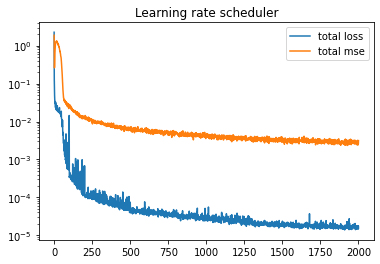

time: 438 ms (started: 2022-07-18 17:59:07 +00:00)


In [120]:
plt.plot(np.array(trainAlloc.train_losses)[:, 0])
plt.plot(np.array(trainAlloc.train_losses)[:, 2:].sum(axis=1))
plt.yscale('log')
plt.legend(['total loss', 'total mse'])
plt.title('Learning rate scheduler')

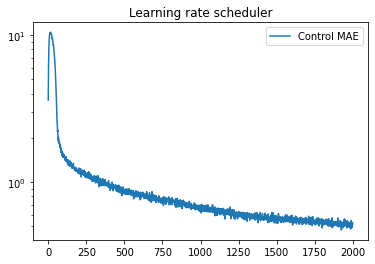

time: 343 ms (started: 2022-07-18 17:59:46 +00:00)


In [121]:
plt.plot(np.array(value_equation.control_losses)[:, 1])
plt.yscale('log')
plt.legend(['Control MAE'])
plt.title('Learning rate scheduler')
plt.show()

Text(0.5, 1.0, 'Learning rate scheduler')

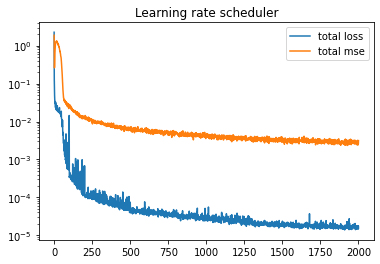

time: 436 ms (started: 2022-07-18 17:59:52 +00:00)


In [122]:
plt.plot(np.array(trainAlloc.train_losses)[:, 0])
plt.plot(np.array(trainAlloc.train_losses)[:, 2:].sum(axis=1))
plt.yscale('log')
plt.legend(['total loss', 'total mse'])
plt.title('Learning rate scheduler')

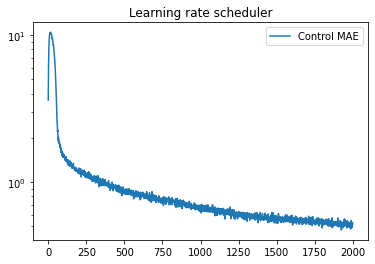

time: 237 ms (started: 2022-07-18 18:00:01 +00:00)


In [123]:
plt.plot(np.array(value_equation.control_losses)[:, 1])
plt.yscale('log')
plt.legend(['Control MAE'])
plt.title('Learning rate scheduler')
plt.show()

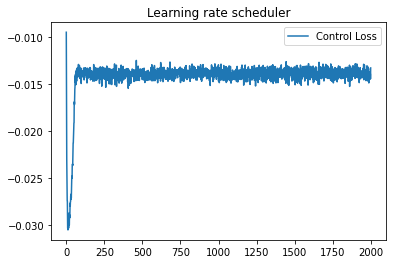

time: 131 ms (started: 2022-07-18 18:00:05 +00:00)


In [124]:
plt.plot(np.array(value_equation.control_losses)[:, 0])
plt.legend(['Control Loss'])
plt.title('Learning rate scheduler')
plt.show()

In [125]:
internal_sample, terminal_sample = trainAlloc.model.sample(size=2048, to_cpu=False)
all_samples = torch.cat([internal_sample, terminal_sample], dim=0)

time: 7.85 ms (started: 2022-07-18 18:00:18 +00:00)


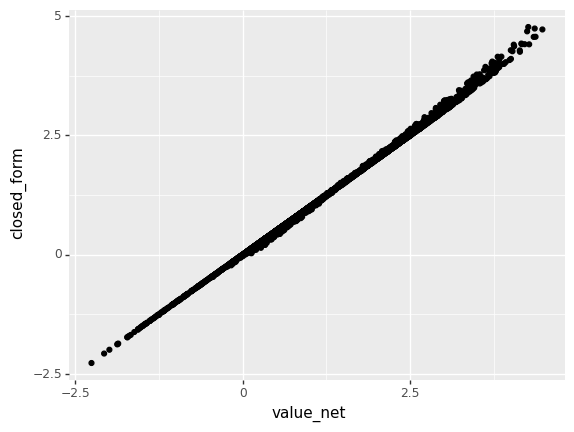

<ggplot: (8748704609093)>

time: 357 ms (started: 2022-07-18 18:00:23 +00:00)


In [126]:
value_net_results = trainAlloc.model.value_net(all_samples).detach().cpu().numpy().reshape(-1).tolist()
htx_results = HtxSq(all_samples).cpu().detach().numpy().reshape(-1).tolist()

dataf2 = pd.DataFrame( { 'value_net': value_net_results, 'closed_form': htx_results } )
ggplot(dataf2, aes(x='value_net', y='closed_form')) + geom_point()

In [127]:
np.mean((dataf2['value_net'] - dataf2['closed_form']) ** 2)

0.0015145709870304667

time: 5.04 ms (started: 2022-07-18 18:00:31 +00:00)


In [128]:
np.mean(np.abs(dataf2['value_net'] - dataf2['closed_form']))

0.014766294570563332

time: 4.93 ms (started: 2022-07-18 18:00:35 +00:00)


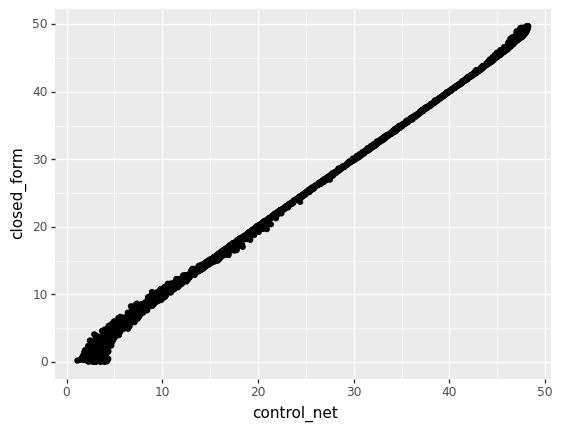

<ggplot: (8748704551773)>

time: 393 ms (started: 2022-07-18 18:00:43 +00:00)


In [129]:
# plot the control function vs the closed form (ideally straight line...)
dataf = pd.DataFrame( { 'control_net': value_equation.control_net(all_samples).cpu().detach().numpy().reshape(-1).tolist(), 
                       'closed_form': nu_star(all_samples).cpu().detach().numpy().reshape(-1).tolist() } )

ggplot(dataf, aes(x='control_net', y='closed_form')) + geom_point()

In [130]:
np.mean(np.abs(dataf['control_net'] - dataf['closed_form']))

0.3753357832002564

time: 4.93 ms (started: 2022-07-18 18:00:50 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/DGM'

Mounted at /content/drive
time: 24.1 s (started: 2022-07-18 09:02:09 +00:00)


In [ ]:
torch.save(trainAlloc4.model.value_net.state_dict(), os.path.join(filepath, 'CJ_value_net_trained_130k_epochs_lr_3e-4_multistep.pt'))
torch.save(value_equation4.control_net.state_dict(), os.path.join(filepath, 'CJ_control_net_trained_130k_epochs_2ep_lr_1e-3.pt'))

time: 37.9 ms (started: 2022-07-13 20:45:11 +00:00)


In [84]:
def save_model_train(training, eqObject, lr, eqLossFn, sample_method, loss, batch_size, epoch): 

  model_id_base_str =  f"{eqObject.__class__.__name__}_{datetime.datetime.now():%Y%m%d%H%M%S}_{batch_size}_{str(torch.round(loss,decimals=2)).replace('.','p')}"
  model_id_base_str = model_id_base_str + f"_{eqLossFn}_{sample_method}_{epoch}_{str(lr).replace('.','p')}"  
  model_id_base_str = model_id_base_str + f"_U{eqObject.u_net.neurons}_U{eqObject.u_net.depth}_P{eqObject.pi_net.neurons}_P{eqObject.pi_net.depth}"
  
  torch.save(eqObject.u_net.state_dict(),  f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{model_id_base_str}_U")
  torch.save(eqObject.pi_net.state_dict(), f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{model_id_base_str}_P")

  df_at_hookintervals = None
  train_losses = None
  validation_losses = None
  try:
      df_at_hookintervals = getattr(training, "history_surfaces_hooks")
      if df_at_hookintervals is not None:
        df_at_hookintervals.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationHook_{training.hook_interval}_{model_id_base_str}.csv", index=False)
  except AttributeError:
      print("Class `{}` does not have `{}`".format(training.__class__.__name__, "history_surfaces_hooks"))

  try:
      train_losses = getattr(training,"train_losses")
      if train_losses is not None:
        train_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainlosses_{model_id_base_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(training.__class__.__name__, "train_losses"))
      # raise NotImplementedError("Class `{}` does not have `{}`".format(trainObj.__class__.__name__, "train_losses"))

  try:
      validation_losses = getattr(training,"validation_losses")
      if validation_losses is not None:
        validation_losses.tofile(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/validationlosses_{model_id_base_str}.csv", sep = ',')    
  except AttributeError:
      print("Class `{}` does not have `{}`".format(training.__class__.__name__, "validation_losses"))

  import numpy as np

  training_dict = dict({ "BATCH_SIZE" : training.BATCH_SIZE,
                         "use_early_stop" : training.use_early_stop,
                        "early_stop_patience" : training.early_stop_patience,
                        "early_stop_delta" : training.early_stop_delta,
                        "monitored_loss_type" : training.monitored_loss_type,
                        "use_early_stop" : training.use_early_stop,
                        "stop_epoch" : training.stop_epoch            })
  equation_dict = dict({ "wgamma" : eqObject.wgamma,
                        "xbreaks" : eqObject.xbreaks,
                        "tbreaks" : eqObject.tbreaks,
                        "MAX_X" : eqObject.MAX_X,
                        "T" : eqObject.T,
                        "MAX_MU" : eqObject.MAX_MU,
                        "MAX_SIGMA" : eqObject.MAX_SIGMA,
                        "pi_net_epoch" : eqObject.pi_net_epoch,
                        "wgamma" : eqObject.wgamma,
                        "pi_net_lr" : eqObject.pi_net_lr,
                        "loss_multiply" : eqObject.loss_multiply,
                        "epoch_of_u" : eqObject.epoch_of_u,
                        "adapt_pi_epochs" : eqObject.adapt_pi_epochs,
                        "start_adapt_epochs" : eqObject.start_adapt_epochs,
                        "was_loss_beaten" : eqObject.was_loss_beaten  })

  np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/trainingDict_{model_id_base_str}.npy", training_dict)
  np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/equationDict_{model_id_base_str}.npy", equation_dict) 


time: 28.9 ms (started: 2022-07-18 15:47:57 +00:00)


In [ ]:
x0 = torch.tensor([[1, 2, 3], [0, 1, 2], [2,3,2],[10, 20, 30]]).float()
x0

tensor([[ 1.,  2.,  3.],
        [ 0.,  1.,  2.],
        [ 2.,  3.,  2.],
        [10., 20., 30.]])

time: 8.16 ms (started: 2022-07-16 11:39:17 +00:00)


In [ ]:
x0xl = torch.bmm(x0.unsqueeze(-1), x0.unsqueeze(-2))
x0xl

tensor([[[  1.,   2.,   3.],
         [  2.,   4.,   6.],
         [  3.,   6.,   9.]],

        [[  0.,   0.,   0.],
         [  0.,   1.,   2.],
         [  0.,   2.,   4.]],

        [[  4.,   6.,   4.],
         [  6.,   9.,   6.],
         [  4.,   6.,   4.]],

        [[100., 200., 300.],
         [200., 400., 600.],
         [300., 600., 900.]]])

time: 8.57 ms (started: 2022-07-16 11:39:22 +00:00)


In [ ]:
weights = torch.ones(3)
bias = torch.zeros(x0.shape[1])

time: 2.75 ms (started: 2022-07-16 11:41:40 +00:00)


In [ ]:
torch.tensordot(x0xl, weights, dims=[[-1], [0]])

tensor([[   6.,   12.,   18.],
        [   0.,    3.,    6.],
        [  14.,   21.,   14.],
        [ 600., 1200., 1800.]])

time: 6.91 ms (started: 2022-07-16 11:41:48 +00:00)


In [ ]:
torch.tensordot(x0xl, weights, dims=[[-1], [0]]).squeeze(-1)

tensor([[   6.,   12.,   18.],
        [   0.,    3.,    6.],
        [  14.,   21.,   14.],
        [ 600., 1200., 1800.]])

time: 7.38 ms (started: 2022-07-16 11:41:28 +00:00)


In [ ]:
x0xl[0]

tensor([[1., 2., 3.],
        [2., 4., 6.],
        [3., 6., 9.]])

time: 6.63 ms (started: 2022-07-16 11:20:10 +00:00)
